## Setup the Env


In [1]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Define IAM role
role = get_execution_role()
role

# Establish S3 bucket connection
import boto3

s3 = boto3.client("s3")
bucket = "capstone-bucket-4-friends"

# Take a look at current dir
print(os.getcwd())

from file_utilities import s3_download

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package

In [2]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings

warnings.filterwarnings("ignore")

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


## Load Data

In [3]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [4]:
os.getcwd()

'/home/sagemaker-user/capstone-2024-summer/src/shuo'

In [5]:
!pwd

/home/sagemaker-user/capstone-2024-summer/src/shuo


In [6]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [7]:
df

date permno_id ncusip_id  cusip_id ticker share_code  \
9263    2018-01-02     10104  68389X10  68389X10   ORCL       11.0   
9264    2018-01-03     10104  68389X10  68389X10   ORCL       11.0   
9265    2018-01-04     10104  68389X10  68389X10   ORCL       11.0   
9266    2018-01-05     10104  68389X10  68389X10   ORCL       11.0   
9267    2018-01-08     10104  68389X10  68389X10   ORCL       11.0   
...            ...       ...       ...       ...    ...        ...   
7656951 2023-12-22     93436  88160R10  88160R10   TSLA       11.0   
7656952 2023-12-26     93436  88160R10  88160R10   TSLA       11.0   
7656953 2023-12-27     93436  88160R10  88160R10   TSLA       11.0   
7656954 2023-12-28     93436  88160R10  88160R10   TSLA       11.0   
7656955 2023-12-29     93436  88160R10  88160R10   TSLA       11.0   

        share_code_type share_code_detail exchange_code company_name  ...  \
9263                  1                 1             1  ORACLE CORP  ...   
9264                  1                 1             1  ORACLE CORP  ...   
9265                  1                 1             1  ORACLE CORP  ...   
9266                  1                 1             1  ORACLE CORP  ...   
9267                  1                 1             1  ORACLE CORP  ...   
...                 ...               ...           ...          ...  ...   
7656951               1                 1             3    TESLA INC  ...   
7656952               1                 1             3    TESLA INC  ...   
7656953               1                 1             3    TESLA INC  ...   
7656954               1                 1             3    TESLA INC  ...   
7656955               1                 1             3    TESLA INC  ...   

        return_14 log_return_14 abs_log_return_14 price_28 return_28  \
9263     4.231880      0.131071          0.131071    48.15  0.334682   
9264     2.890159      0.107382          0.107382    48.49  0.157137   
9265     2.436310      0.097613          0.097613    49.45  0.263850   
9266     3.586591      0.120486          0.120486    50.64  0.483153   
9267     1.875391      0.083731          0.083731    50.71  0.366701   
...           ...           ...               ...      ...       ...   
7656951  0.000000      0.000000          0.000000     0.00  0.000000   
7656952  0.000000      0.000000          0.000000     0.00  0.000000   
7656953  0.000000      0.000000          0.000000     0.00  0.000000   
7656954  0.000000      0.000000          0.000000     0.00  0.000000   
7656955  0.000000      0.000000          0.000000     0.00  0.000000   

        log_return_28 abs_log_return_28  volatility_7  volatility_14  \
9263         0.011619          0.011619      0.136136       0.109282   
9264         0.006475          0.006475      0.091648       0.081082   
9265         0.009651          0.009651      0.089939       0.079524   
9266         0.015437          0.015437      0.105015       0.107098   
9267         0.012476          0.012476      0.105560       0.139328   
...               ...               ...           ...            ...   
7656951      0.000000          0.000000      0.000000       0.000000   
7656952      0.000000          0.000000      0.000000       0.000000   
7656953      0.000000          0.000000      0.000000       0.000000   
7656954      0.000000          0.000000      0.000000       0.000000   
7656955      0.000000          0.000000      0.000000       0.000000   

         volatility_28  
9263          0.276310  
9264          0.268724  
9265          0.273385  
9266          0.281463  
9267          0.280139  
...                ...  
7656951       0.000000  
7656952       0.000000  
7656953       0.000000  
7656954       0.000000  
7656955       0.000000  

[809883 rows x 54 columns]

In [8]:
df.dtypes

date                              datetime64[ns]
permno_id                                 object
ncusip_id                                 object
cusip_id                                  object
ticker                                    object
share_code                                object
share_code_type                           object
share_code_detail                         object
exchange_code                             object
company_name                              object
primary_exchange                          object
trading_status                            object
security_status                           object
naics                                     object
naics_sector                              object
naics_sector_name                         object
naics_secondary                           object
ask_or_high_price                        float64
ask_price                                float64
bid_or_low_price                         float64
bid_price           

In [9]:
max(df.groupby("permno_id")["ticker"].nunique())

3

In [10]:
# Group by 'PERMNO' and count unique 'TICKER', then filter for those with exactly 2 unique 'TICKER'
permno_with_multiple_tickers = df.groupby("permno_id")["ticker"].nunique()
permno_with_multiple_tickers = permno_with_multiple_tickers[permno_with_multiple_tickers == 2].index

# Display the PERMNO values
# data[data['PERMNO'].isin(permno_with_multiple_tickers)]
permno_with_multiple_tickers

Index(['10696', '12431', '13407', '14882', '16048', '16692', '16851', '17830',
       '19751', '24053', '24643', '25582', '42200', '52329', '57568', '62308',
       '64282', '67598', '71563', '75034', '76082', '81540', '82303', '86783',
       '89017', '89179', '90199', '90441', '90442', '91277'],
      dtype='object', name='permno_id')

In [11]:
df[df["permno_id"].isin(permno_with_multiple_tickers)]

date permno_id ncusip_id  cusip_id ticker share_code  \
68278   2018-01-02     10696  33773810  33773810   FISV       11.0   
68279   2018-01-03     10696  33773810  33773810   FISV       11.0   
68280   2018-01-04     10696  33773810  33773810   FISV       11.0   
68281   2018-01-05     10696  33773810  33773810   FISV       11.0   
68282   2018-01-08     10696  33773810  33773810   FISV       11.0   
...            ...       ...       ...       ...    ...        ...   
7140630 2023-12-22     91277  74915M10  74915M10  QRTEA       11.0   
7140631 2023-12-26     91277  74915M10  74915M10  QRTEA       11.0   
7140632 2023-12-27     91277  74915M10  74915M10  QRTEA       11.0   
7140633 2023-12-28     91277  74915M10  74915M10  QRTEA       11.0   
7140634 2023-12-29     91277  74915M10  74915M10  QRTEA       11.0   

        share_code_type share_code_detail exchange_code       company_name  \
68278                 1                 1             3         FISERV INC   
68279                 1                 1             3         FISERV INC   
68280                 1                 1             3         FISERV INC   
68281                 1                 1             3         FISERV INC   
68282                 1                 1             3         FISERV INC   
...                 ...               ...           ...                ...   
7140630               1                 1             3  QURATE RETAIL INC   
7140631               1                 1             3  QURATE RETAIL INC   
7140632               1                 1             3  QURATE RETAIL INC   
7140633               1                 1             3  QURATE RETAIL INC   
7140634               1                 1             3  QURATE RETAIL INC   

         ... return_14 log_return_14 abs_log_return_14   price_28 return_28  \
68278    ...  2.802348      0.100099          0.100099  138.64000  0.741796   
68279    ...  2.182780      0.086210          0.086210  139.03000  0.660814   
68280    ...  1.693096      0.073326          0.073326  138.39999  0.405810   
68281    ...  1.827519      0.077066          0.077066  140.45000  0.468490   
68282    ...  1.886495      0.078656          0.078656  142.72000  0.666114   
...      ...       ...           ...               ...        ...       ...   
7140630  ...  0.000000      0.000000          0.000000    0.00000  0.000000   
7140631  ...  0.000000      0.000000          0.000000    0.00000  0.000000   
7140632  ...  0.000000      0.000000          0.000000    0.00000  0.000000   
7140633  ...  0.000000      0.000000          0.000000    0.00000  0.000000   
7140634  ...  0.000000      0.000000          0.000000    0.00000  0.000000   

        log_return_28 abs_log_return_28  volatility_7  volatility_14  \
68278        0.020016          0.020016      0.062708       0.091308   
68279        0.018283          0.018283      0.097232       0.094987   
68280        0.012239          0.012239      0.082155       0.084828   
68281        0.013817          0.013817      0.073817       0.089158   
68282        0.018399          0.018399      0.082189       0.088761   
...               ...               ...           ...            ...   
7140630      0.000000          0.000000      0.000000       0.000000   
7140631      0.000000          0.000000      0.000000       0.000000   
7140632      0.000000          0.000000      0.000000       0.000000   
7140633      0.000000          0.000000      0.000000       0.000000   
7140634      0.000000          0.000000      0.000000       0.000000   

         volatility_28  
68278         0.249650  
68279         0.248987  
68280         0.246870  
68281         0.248848  
68282         0.252631  
...                ...  
7140630       0.000000  
7140631       0.000000  
7140632       0.000000  
7140633       0.000000  
7140634       0.000000  

[42179 rows x 54 columns]

## Feature Engineering

In [12]:
data_1 = df[
    [
        "date",
        "permno_id",
        "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
]
data_1

date permno_id     naics  log_return  abs_log_return  \
9263    2018-01-02     10104  511210.0   -0.013843        0.013843   
9264    2018-01-03     10104  511210.0    0.022897        0.022897   
9265    2018-01-04     10104  511210.0    0.009803        0.009803   
9266    2018-01-05     10104  511210.0    0.006001        0.006001   
9267    2018-01-08     10104  511210.0    0.010467        0.010467   
...            ...       ...       ...         ...             ...   
7656951 2023-12-22     93436  336110.0   -0.007731        0.007731   
7656952 2023-12-26     93436  336110.0    0.015988        0.015988   
7656953 2023-12-27     93436  336110.0    0.018647        0.018647   
7656954 2023-12-28     93436  336110.0   -0.032104        0.032104   
7656955 2023-12-29     93436  336110.0   -0.018738        0.018738   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                           0.000000                      0.000000   
9264                           0.006404                      0.004872   
9265                           0.004048                      0.000960   
9266                           0.009581                      0.006722   
9267                           0.002142                      0.005354   
...                                 ...                           ...   
7656951                        0.000259                      0.007069   
7656952                        0.007335                      0.009616   
7656953                        0.002344                      0.001393   
7656954                       -0.001451                     -0.000214   
7656955                       -0.005400                     -0.005035   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                    0.000000               0.000000      0.309424   
9264                    0.005904               0.007983      0.234088   
9265                    0.004021               0.000852      0.183199   
9266                    0.006193               0.002919      0.230474   
9267                    0.001829               0.005828      0.161223   
...                          ...                    ...           ...   
7656951                 0.002502               0.004469      0.000000   
7656952                 0.005189               0.003873      0.000000   
7656953                 0.001653               0.001163      0.000000   
7656954                -0.000266               0.002184      0.000000   
7656955                -0.004121              -0.004627      0.000000   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.309424       0.131071           0.131071       0.011619   
9264             0.234088       0.107382           0.107382       0.006475   
9265             0.183199       0.097613           0.097613       0.009651   
9266             0.230474       0.120486           0.120486       0.015437   
9267             0.161223       0.083731           0.083731       0.012476   
...                   ...            ...                ...            ...   
7656951          0.000000       0.000000           0.000000       0.000000   
7656952          0.000000       0.000000           0.000000       0.000000   
7656953          0.000000       0.000000           0.000000       0.000000   
7656954          0.000000       0.000000           0.000000       0.000000   
7656955          0.000000       0.000000           0.000000       0.000000   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263              0.011619      0.136136       0.109282       0.276310  
9264              0.006475      0.091648       0.081082       0.268724  
9265              0.009651      0.089939       0.079524       0.273385  
9266              0.015437      0.105015       0.107098       0.281463  
9267              0.012476      0.105560       0.139328       0.280139  
...                    ...           ...    

In [13]:
data_1["naics_sector_digits"] = data_1["naics"].astype(str).str[:2]
data_1

date permno_id     naics  log_return  abs_log_return  \
9263    2018-01-02     10104  511210.0   -0.013843        0.013843   
9264    2018-01-03     10104  511210.0    0.022897        0.022897   
9265    2018-01-04     10104  511210.0    0.009803        0.009803   
9266    2018-01-05     10104  511210.0    0.006001        0.006001   
9267    2018-01-08     10104  511210.0    0.010467        0.010467   
...            ...       ...       ...         ...             ...   
7656951 2023-12-22     93436  336110.0   -0.007731        0.007731   
7656952 2023-12-26     93436  336110.0    0.015988        0.015988   
7656953 2023-12-27     93436  336110.0    0.018647        0.018647   
7656954 2023-12-28     93436  336110.0   -0.032104        0.032104   
7656955 2023-12-29     93436  336110.0   -0.018738        0.018738   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                           0.000000                      0.000000   
9264                           0.006404                      0.004872   
9265                           0.004048                      0.000960   
9266                           0.009581                      0.006722   
9267                           0.002142                      0.005354   
...                                 ...                           ...   
7656951                        0.000259                      0.007069   
7656952                        0.007335                      0.009616   
7656953                        0.002344                      0.001393   
7656954                       -0.001451                     -0.000214   
7656955                       -0.005400                     -0.005035   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                    0.000000               0.000000      0.309424   
9264                    0.005904               0.007983      0.234088   
9265                    0.004021               0.000852      0.183199   
9266                    0.006193               0.002919      0.230474   
9267                    0.001829               0.005828      0.161223   
...                          ...                    ...           ...   
7656951                 0.002502               0.004469      0.000000   
7656952                 0.005189               0.003873      0.000000   
7656953                 0.001653               0.001163      0.000000   
7656954                -0.000266               0.002184      0.000000   
7656955                -0.004121              -0.004627      0.000000   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.309424       0.131071           0.131071       0.011619   
9264             0.234088       0.107382           0.107382       0.006475   
9265             0.183199       0.097613           0.097613       0.009651   
9266             0.230474       0.120486           0.120486       0.015437   
9267             0.161223       0.083731           0.083731       0.012476   
...                   ...            ...                ...            ...   
7656951          0.000000       0.000000           0.000000       0.000000   
7656952          0.000000       0.000000           0.000000       0.000000   
7656953          0.000000       0.000000           0.000000       0.000000   
7656954          0.000000       0.000000           0.000000       0.000000   
7656955          0.000000       0.000000           0.000000       0.000000   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  \
9263              0.011619      0.136136       0.109282       0.276310   
9264              0.006475      0.091648       0.081082       0.268724   
9265              0.009651      0.089939       0.079524       0.273385   
9266              0.015437      0.105015       0.107098       0.281463   
9267              0.012476      0.105560       0.139328       0.280139   
...                    ...           .

In [14]:
data_2 = data_1[
    [
        "date",
        "permno_id",
        "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
]
data_2

date permno_id     naics  log_return  abs_log_return  \
9263    2018-01-02     10104  511210.0   -0.013843        0.013843   
9264    2018-01-03     10104  511210.0    0.022897        0.022897   
9265    2018-01-04     10104  511210.0    0.009803        0.009803   
9266    2018-01-05     10104  511210.0    0.006001        0.006001   
9267    2018-01-08     10104  511210.0    0.010467        0.010467   
...            ...       ...       ...         ...             ...   
7656951 2023-12-22     93436  336110.0   -0.007731        0.007731   
7656952 2023-12-26     93436  336110.0    0.015988        0.015988   
7656953 2023-12-27     93436  336110.0    0.018647        0.018647   
7656954 2023-12-28     93436  336110.0   -0.032104        0.032104   
7656955 2023-12-29     93436  336110.0   -0.018738        0.018738   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                           0.000000                      0.000000   
9264                           0.006404                      0.004872   
9265                           0.004048                      0.000960   
9266                           0.009581                      0.006722   
9267                           0.002142                      0.005354   
...                                 ...                           ...   
7656951                        0.000259                      0.007069   
7656952                        0.007335                      0.009616   
7656953                        0.002344                      0.001393   
7656954                       -0.001451                     -0.000214   
7656955                       -0.005400                     -0.005035   

         weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                    0.000000               0.000000      0.309424   
9264                    0.005904               0.007983      0.234088   
9265                    0.004021               0.000852      0.183199   
9266                    0.006193               0.002919      0.230474   
9267                    0.001829               0.005828      0.161223   
...                          ...                    ...           ...   
7656951                 0.002502               0.004469      0.000000   
7656952                 0.005189               0.003873      0.000000   
7656953                 0.001653               0.001163      0.000000   
7656954                -0.000266               0.002184      0.000000   
7656955                -0.004121              -0.004627      0.000000   

         abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
9263             0.309424       0.131071           0.131071       0.011619   
9264             0.234088       0.107382           0.107382       0.006475   
9265             0.183199       0.097613           0.097613       0.009651   
9266             0.230474       0.120486           0.120486       0.015437   
9267             0.161223       0.083731           0.083731       0.012476   
...                   ...            ...                ...            ...   
7656951          0.000000       0.000000           0.000000       0.000000   
7656952          0.000000       0.000000           0.000000       0.000000   
7656953          0.000000       0.000000           0.000000       0.000000   
7656954          0.000000       0.000000           0.000000       0.000000   
7656955          0.000000       0.000000           0.000000       0.000000   

         abs_log_return_28  volatility_7  volatility_14  volatility_28  
9263              0.011619      0.136136       0.109282       0.276310  
9264              0.006475      0.091648       0.081082       0.268724  
9265              0.009651      0.089939       0.079524       0.273385  
9266              0.015437      0.105015       0.107098       0.281463  
9267              0.012476      0.105560       0.139328       0.280139  
...                    ...           ...    

## Model-Step 1 (Baseline)

In [15]:
data = data_2

In [16]:
def check_data(df):
    if df.isnull().values.any():
        print("Data contains NaNs")
    if np.isinf(pd.to_numeric(df.stack(), errors="coerce")).any():
        print("Data contains Infinities")


check_data(data)

In [17]:
data[-30:]

date permno_id     naics  log_return  abs_log_return  \
7656926 2023-11-16     93436  336110.0   -0.038835        0.038835   
7656927 2023-11-17     93436  336110.0    0.003035        0.003035   
7656928 2023-11-20     93436  336110.0    0.005533        0.005533   
7656929 2023-11-21     93436  336110.0    0.023491        0.023491   
7656930 2023-11-22     93436  336110.0   -0.029408        0.029408   
7656931 2023-11-24     93436  336110.0    0.005280        0.005280   
7656932 2023-11-27     93436  336110.0    0.002672        0.002672   
7656933 2023-11-28     93436  336110.0    0.044083        0.044083   
7656934 2023-11-29     93436  336110.0   -0.010512        0.010512   
7656935 2023-11-30     93436  336110.0   -0.016770        0.016770   
7656936 2023-12-01     93436  336110.0   -0.005221        0.005221   
7656937 2023-12-04     93436  336110.0   -0.013701        0.013701   
7656938 2023-12-05     93436  336110.0    0.013241        0.013241   
7656939 2023-12-06     93436  336110.0    0.002719        0.002719   
7656940 2023-12-07     93436  336110.0    0.013569        0.013569   
7656941 2023-12-08     93436  336110.0    0.004934        0.004934   
7656942 2023-12-11     93436  336110.0   -0.016957        0.016957   
7656943 2023-12-12     93436  336110.0   -0.011452        0.011452   
7656944 2023-12-13     93436  336110.0    0.009574        0.009574   
7656945 2023-12-14     93436  336110.0    0.047976        0.047976   
7656946 2023-12-15     93436  336110.0    0.009712        0.009712   
7656947 2023-12-18     93436  336110.0   -0.005618        0.005618   
7656948 2023-12-19     93436  336110.0    0.020185        0.020185   
7656949 2023-12-20     93436  336110.0   -0.039977        0.039977   
7656950 2023-12-21     93436  336110.0    0.029346        0.029346   
7656951 2023-12-22     93436  336110.0   -0.007731        0.007731   
7656952 2023-12-26     93436  336110.0    0.015988        0.015988   
7656953 2023-12-27     93436  336110.0    0.018647        0.018647   
7656954 2023-12-28     93436  336110.0   -0.032104        0.032104   
7656955 2023-12-29     93436  336110.0   -0.018738        0.018738   

         sector_weighted_avg_log_return  sector_simple_avg_log_return  \
7656926                       -0.000869                     -0.004937   
7656927                        0.002385                      0.003949   
7656928                        0.009430                      0.007483   
7656929                       -0.002472                     -0.003581   
7656930                       -0.001036                      0.004794   
7656931                       -0.000404                      0.006189   
7656932                       -0.001712                     -0.003564   
7656933                       -0.000177                     -0.008462   
7656934                        0.002796                      0.005689   
7656935                       -0.000674                      0.003475   
7656936                        0.007898                      0.015791   
7656937                       -0.006439                      0.003941   
7656938                        0.002450                     -0.010666   
7656939                       -0.003945                      0.001380   
7656940                        0.010809                      0.008507   
7656941                        0.006484                      0.004414   
7656942                        0.005285                      0.011091   
7656943                        0.006402                      0.003710   
7656944                        0.015230                      0.020983   
7656945                        0.015424                      0.026980   
7656946                        0.000329                     -0.003656   
7656947                       -0.000060                      0.002260   
7656948                        0.007102                      0.012314   
7656949                       -0.019465                     -0.017907   
7656950           

In [18]:
data.describe()

date     log_return  abs_log_return  \
count                         809883  809883.000000   809883.000000   
mean   2021-01-02 19:26:16.187671808       0.000347        0.015239   
min              2018-01-02 00:00:00      -0.773592        0.000000   
25%              2019-07-10 00:00:00      -0.009627        0.004608   
50%              2021-01-05 00:00:00       0.000817        0.010260   
75%              2022-07-01 00:00:00       0.010825        0.019626   
max              2023-12-29 00:00:00       0.629788        0.773592   
std                              NaN       0.023655        0.018095   

       sector_weighted_avg_log_return  sector_simple_avg_log_return  \
count                   809883.000000                 809883.000000   
mean                         0.000340                      0.000143   
min                         -1.949859                     -0.510336   
25%                         -0.006371                     -0.006763   
50%                          0.000887                      0.000677   
75%                          0.007900                      0.008082   
max                          4.629079                      1.409433   
std                          0.018470                      0.015654   

       weighted_avg_log_return  simple_avg_log_return   log_return_7  \
count            809883.000000          809883.000000  809883.000000   
mean                  0.000335               0.000226       0.062016   
min                  -0.129686              -0.095060      -0.999627   
25%                  -0.005049              -0.005496      -0.119866   
50%                   0.000743               0.000637       0.024535   
75%                   0.007133               0.006488       0.181726   
max                   0.090241               0.100972     122.448772   
std                   0.013260               0.012536       0.483496   

       abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
count     809883.000000  809883.000000      809883.000000  809883.000000   
mean           0.221782       0.011755           0.075367       0.003473   
min            0.000000      -0.918449           0.000000      -0.505787   
25%            0.067578      -0.043232           0.024668      -0.014979   
50%            0.150276       0.010485           0.054429       0.004058   
75%            0.279142       0.063910           0.100071       0.023282   
max          122.448772       4.453196           4.453196       0.758288   
std            0.434081       0.108734           0.079254       0.037834   

       abs_log_return_28   volatility_7  volatility_14  volatility_28  
count      809883.000000  809883.000000  809883.000000  809883.000000  
mean            0.026526       0.299785       0.309311       0.315029  
min             0.000000       0.000000       0.000000       0.000000  
25%             0.008843       0.167155       0.186708       0.200940  
50%             0.019569       0.243410       0.259283       0.269265  
75%             0.035404       0.359321       0.363738       0.365940  
max             0.758288       5.258937       4.398254       3.282485  
std             0.027200       0.228246       0.212317       0.200876

In [19]:
data[data["log_return_14"] == np.inf]

Empty DataFrame
Columns: [date, permno_id, naics, log_return, abs_log_return, sector_weighted_avg_log_return, sector_simple_avg_log_return, weighted_avg_log_return, simple_avg_log_return, log_return_7, abs_log_return_7, log_return_14, abs_log_return_14, log_return_28, abs_log_return_28, volatility_7, volatility_14, volatility_28]
Index: []

In [20]:
# Check if there are any infinite values in the entire DataFrame
infinite_values = data.isin([np.inf, -np.inf]).values.any()
print(f"Data contains Infinities: {infinite_values}")

# Check for specific columns
column_with_inf = data.isin([np.inf, -np.inf]).any()
print("Columns with Infinities:")
print(column_with_inf[column_with_inf].index.tolist())

Data contains Infinities: False
Columns with Infinities:
[]


In [21]:
data_inf_rows = data[np.isinf(data["log_return_7"])]
data_inf_rows

Empty DataFrame
Columns: [date, permno_id, naics, log_return, abs_log_return, sector_weighted_avg_log_return, sector_simple_avg_log_return, weighted_avg_log_return, simple_avg_log_return, log_return_7, abs_log_return_7, log_return_14, abs_log_return_14, log_return_28, abs_log_return_28, volatility_7, volatility_14, volatility_28]
Index: []

In [22]:
data_inf_rows = data[(data == np.inf) | (data == -np.inf)].any(axis=1)
data[data_inf_rows]

Empty DataFrame
Columns: [date, permno_id, naics, log_return, abs_log_return, sector_weighted_avg_log_return, sector_simple_avg_log_return, weighted_avg_log_return, simple_avg_log_return, log_return_7, abs_log_return_7, log_return_14, abs_log_return_14, log_return_28, abs_log_return_28, volatility_7, volatility_14, volatility_28]
Index: []

In [23]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [24]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

date permno_id     naics  log_return  abs_log_return  \
794341 2023-10-09     93436  336110.0   -0.003306        0.003306   
794342 2023-10-10     93436  336110.0    0.015097        0.015097   
794343 2023-10-11     93436  336110.0   -0.002393        0.002393   
794344 2023-10-12     93436  336110.0   -0.015790        0.015790   
794345 2023-10-13     93436  336110.0   -0.030395        0.030395   
794346 2023-10-16     93436  336110.0    0.011088        0.011088   
794347 2023-10-17     93436  336110.0    0.003656        0.003656   
794348 2023-10-18     93436  336110.0   -0.048932        0.048932   
794349 2023-10-19     93436  336110.0   -0.097616        0.097616   
794350 2023-10-20     93436  336110.0   -0.037589        0.037589   
794351 2023-10-23     93436  336110.0    0.000425        0.000425   
794352 2023-10-24     93436  336110.0    0.020720        0.020720   
794353 2023-10-25     93436  336110.0   -0.019118        0.019118   
794354 2023-10-26     93436  336110.0   -0.031855        0.031855   
794355 2023-10-27     93436  336110.0    0.007456        0.007456   
794356 2023-10-30     93436  336110.0   -0.049138        0.049138   
794357 2023-10-31     93436  336110.0    0.017479        0.017479   
794358 2023-11-01     93436  336110.0    0.023716        0.023716   
794359 2023-11-02     93436  336110.0    0.060608        0.060608   
794360 2023-11-03     93436  336110.0    0.006614        0.006614   
794361 2023-11-06     93436  336110.0   -0.003142        0.003142   
794362 2023-11-07     93436  336110.0    0.013184        0.013184   
794363 2023-11-08     93436  336110.0   -0.000315        0.000315   
794364 2023-11-09     93436  336110.0   -0.056161        0.056161   
794365 2023-11-10     93436  336110.0    0.021996        0.021996   
794366 2023-11-13     93436  336110.0    0.041342        0.041342   
794367 2023-11-14     93436  336110.0    0.059438        0.059438   
794368 2023-11-15     93436  336110.0    0.022614        0.022614   
794369 2023-11-16     93436  336110.0   -0.038835        0.038835   
794370 2023-11-17     93436  336110.0    0.003035        0.003035   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
794341                        0.004974                      0.006552   
794342                        0.005459                      0.009881   
794343                        0.004413                      0.000132   
794344                       -0.006896                     -0.016643   
794345                       -0.141350                     -0.013752   
794346                        0.008951                      0.013014   
794347                       -0.005996                      0.002844   
794348                       -0.019949                     -0.024705   
794349                       -0.013942                     -0.014399   
794350                       -0.013804                     -0.011470   
794351                        0.000231                     -0.006776   
794352                        0.008403                      0.004851   
794353                       -0.019946                     -0.019247   
794354                       -0.014721                     -0.004846   
794355                       -0.000144                     -0.008881   
794356                        0.001988                      0.000545   
794357                        0.007268                      0.009611   
794358                        0.015639                      0.007678   
794359                        0.022060                      0.020936   
794360                        0.011770                      0.020035   
794361                        0.002605                     -0.004837   
794362                        0.004400                     -0.001645   
794363                        0.001536                     -0.002913   
794364                       -0.008717                     -0.007077   
794365                        0.020915                      0.017300   
7

In [25]:
# data.replace([np.inf, -np.inf],0, inplace=True)

In [26]:
# data.describe()

In [27]:
# train_data = data[(data["date"] <= "2022-12-31") & (data["date"] >= "2022-01-02")]
# train_data = data[data["date"] <= "2022-12-31"]
# validation_data = data[data["date"] > "2022-12-31"]
train_data = cleaned_data[cleaned_data["date"] <= "2022-12-31"]
validation_data = cleaned_data[cleaned_data["date"] > "2022-12-31"]

In [28]:
train_data

date permno_id     naics  log_return  abs_log_return  \
0      2018-01-02     10104  511210.0   -0.013843        0.013843   
1      2018-01-03     10104  511210.0    0.022897        0.022897   
2      2018-01-04     10104  511210.0    0.009803        0.009803   
3      2018-01-05     10104  511210.0    0.006001        0.006001   
4      2018-01-08     10104  511210.0    0.010467        0.010467   
...           ...       ...       ...         ...             ...   
794144 2022-12-23     93436  336111.0   -0.017707        0.017707   
794145 2022-12-27     93436  336111.0   -0.121139        0.121139   
794146 2022-12-28     93436  336111.0    0.032553        0.032553   
794147 2022-12-29     93436  336111.0    0.077726        0.077726   
794148 2022-12-30     93436  336111.0    0.011102        0.011102   

        sector_weighted_avg_log_return  sector_simple_avg_log_return  \
0                             0.000000                      0.000000   
1                             0.006404                      0.004872   
2                             0.004048                      0.000960   
3                             0.009581                      0.006722   
4                             0.002142                      0.005354   
...                                ...                           ...   
794144                        0.000002                     -0.006463   
794145                       -0.012210                     -0.002921   
794146                       -0.014643                     -0.013117   
794147                        0.024794                      0.022896   
794148                       -0.003204                     -0.001388   

        weighted_avg_log_return  simple_avg_log_return  log_return_7  \
0                      0.000000               0.000000      0.309424   
1                      0.005904               0.007983      0.234088   
2                      0.004021               0.000852      0.183199   
3                      0.006193               0.002919      0.230474   
4                      0.001829               0.005828      0.161223   
...                         ...                    ...           ...   
794144                 0.005100               0.009920     -0.431567   
794145                -0.004281              -0.002320      0.201255   
794146                -0.012660              -0.006697      0.366781   
794147                 0.018379               0.020048     -0.119207   
794148                -0.003635              -0.000213      0.001676   

        abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
0               0.309424       0.131071           0.131071       0.011619   
1               0.234088       0.107382           0.107382       0.006475   
2               0.183199       0.097613           0.097613       0.009651   
3               0.230474       0.120486           0.120486       0.015437   
4               0.161223       0.083731           0.083731       0.012476   
...                  ...            ...                ...            ...   
794144          0.431567       0.087902           0.087902       0.158739   
794145          0.201255       0.237663           0.237663       0.208809   
794146          0.366781       0.167886           0.167886       0.204912   
794147          0.119207       0.124060           0.124060       0.186385   
794148          0.001676       0.219637           0.219637       0.162707   

        abs_log_return_28  volatility_7  volatility_14  volatility_28  
0                0.011619      0.136136       0.109282       0.276310  
1                0.006475      0.091648       0.081082       0.268724  
2                0.009651      0.089939       0.079524       0.273385  
3                0.015437      0.105015       0.107098       0.281463  
4                0.012476      0.105560       0.139328       0.280139  
...                   ...           ...            ...            ...  
794144           0.158739

In [29]:
# validation_data

In [30]:
first_month_data = data[data["date"] < "2018-02-01"]
# first_month_data

### Check and make sure no missing values

In [31]:
first_month_data.dtypes

date                              datetime64[ns]
permno_id                                 object
naics                                     object
log_return                               float64
abs_log_return                           float64
sector_weighted_avg_log_return           float64
sector_simple_avg_log_return             float64
weighted_avg_log_return                  float64
simple_avg_log_return                    float64
log_return_7                             float64
abs_log_return_7                         float64
log_return_14                            float64
abs_log_return_14                        float64
log_return_28                            float64
abs_log_return_28                        float64
volatility_7                             float64
volatility_14                            float64
volatility_28                            float64
dtype: object

In [32]:
train_data[train_data["log_return"].isnull() == 1]

Empty DataFrame
Columns: [date, permno_id, naics, log_return, abs_log_return, sector_weighted_avg_log_return, sector_simple_avg_log_return, weighted_avg_log_return, simple_avg_log_return, log_return_7, abs_log_return_7, log_return_14, abs_log_return_14, log_return_28, abs_log_return_28, volatility_7, volatility_14, volatility_28]
Index: []

In [33]:
train_data[train_data["date"].isnull() == 1]

Empty DataFrame
Columns: [date, permno_id, naics, log_return, abs_log_return, sector_weighted_avg_log_return, sector_simple_avg_log_return, weighted_avg_log_return, simple_avg_log_return, log_return_7, abs_log_return_7, log_return_14, abs_log_return_14, log_return_28, abs_log_return_28, volatility_7, volatility_14, volatility_28]
Index: []

In [34]:
train_data.isnull().sum()

date                              0
permno_id                         0
naics                             0
log_return                        0
abs_log_return                    0
sector_weighted_avg_log_return    0
sector_simple_avg_log_return      0
weighted_avg_log_return           0
simple_avg_log_return             0
log_return_7                      0
abs_log_return_7                  0
log_return_14                     0
abs_log_return_14                 0
log_return_28                     0
abs_log_return_28                 0
volatility_7                      0
volatility_14                     0
volatility_28                     0
dtype: int64

In [35]:
first_month_data.isnull().sum()

date                              0
permno_id                         0
naics                             0
log_return                        0
abs_log_return                    0
sector_weighted_avg_log_return    0
sector_simple_avg_log_return      0
weighted_avg_log_return           0
simple_avg_log_return             0
log_return_7                      0
abs_log_return_7                  0
log_return_14                     0
abs_log_return_14                 0
log_return_28                     0
abs_log_return_28                 0
volatility_7                      0
volatility_14                     0
volatility_28                     0
dtype: int64

In [36]:
len(first_month_data)

11025

### Build Model & Get Embedding
1. The current model uses positional encodings.
2. Need to add ordinal position for each return.
3. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
4. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block

#### Model-Step 1
Features:  
'log_return'  
'postional encoding'

In [37]:
train_data[train_data["permno_id"] == "10104"]

date permno_id     naics  log_return  abs_log_return  \
0    2018-01-02     10104  511210.0   -0.013843        0.013843   
1    2018-01-03     10104  511210.0    0.022897        0.022897   
2    2018-01-04     10104  511210.0    0.009803        0.009803   
3    2018-01-05     10104  511210.0    0.006001        0.006001   
4    2018-01-08     10104  511210.0    0.010467        0.010467   
...         ...       ...       ...         ...             ...   
1254 2022-12-23     10104  511210.0    0.004463        0.004463   
1255 2022-12-27     10104  511210.0    0.001607        0.001607   
1256 2022-12-28     10104  511210.0   -0.008059        0.008059   
1257 2022-12-29     10104  511210.0    0.013232        0.013232   
1258 2022-12-30     10104  511210.0    0.004168        0.004168   

      sector_weighted_avg_log_return  sector_simple_avg_log_return  \
0                           0.000000                      0.000000   
1                           0.006404                      0.004872   
2                           0.004048                      0.000960   
3                           0.009581                      0.006722   
4                           0.002142                      0.005354   
...                              ...                           ...   
1254                        0.002641                      0.000440   
1255                       -0.005155                     -0.010350   
1256                       -0.011746                     -0.011982   
1257                        0.026479                      0.028541   
1258                       -0.002466                     -0.002471   

      weighted_avg_log_return  simple_avg_log_return  log_return_7  \
0                    0.000000               0.000000      0.309424   
1                    0.005904               0.007983      0.234088   
2                    0.004021               0.000852      0.183199   
3                    0.006193               0.002919      0.230474   
4                    0.001829               0.005828      0.161223   
...                       ...                    ...           ...   
1254                 0.005100               0.009920      0.240496   
1255                -0.004281              -0.002320      0.335016   
1256                -0.012660              -0.006697      0.484128   
1257                 0.018379               0.020048      0.393108   
1258                -0.003635              -0.000213      0.542588   

      abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
0             0.309424       0.131071           0.131071       0.011619   
1             0.234088       0.107382           0.107382       0.006475   
2             0.183199       0.097613           0.097613       0.009651   
3             0.230474       0.120486           0.120486       0.015437   
4             0.161223       0.083731           0.083731       0.012476   
...                ...            ...                ...            ...   
1254          0.240496       0.130254           0.130254       0.030822   
1255          0.335016       0.097081           0.097081       0.027325   
1256          0.484128       0.095868           0.095868       0.026012   
1257          0.393108       0.098543           0.098543       0.021506   
1258          0.542588       0.120443           0.120443       0.021989   

      abs_log_return_28  volatility_7  volatility_14  volatility_28  
0              0.011619      0.136136       0.109282       0.276310  
1              0.006475      0.091648       0.081082       0.268724  
2              0.009651      0.089939       0.079524       0.273385  
3              0.015437      0.105015       0.107098       0.281463  
4              0.012476      0.105560       0.139328       0.280139  
...                 ...           ...            ...            ...  
1254           0.030822      0.167463       0.160461       0.193399  
1255           0.027325      0.173581       0.200194       0.19

Epoch 1/10, Training Loss: 0.10873418599367142, Validation Loss: 0.026138246680299442
Epoch 2/10, Training Loss: 0.07264202139340341, Validation Loss: 0.011836704487601915
Epoch 3/10, Training Loss: 0.052412782702594994, Validation Loss: 0.010479272032777468
Epoch 4/10, Training Loss: 0.03881917544640601, Validation Loss: 0.012850195169448853
Epoch 5/10, Training Loss: 0.02914880677126348, Validation Loss: 0.011085977467397848
Epoch 6/10, Training Loss: 0.026282249111682178, Validation Loss: 0.010783347922066847
Epoch 7/10, Training Loss: 0.02397866144310683, Validation Loss: 0.020484281703829765
Epoch 8/10, Training Loss: 0.021339315362274645, Validation Loss: 0.017431732267141342
Early stopping triggered.
Training Complete


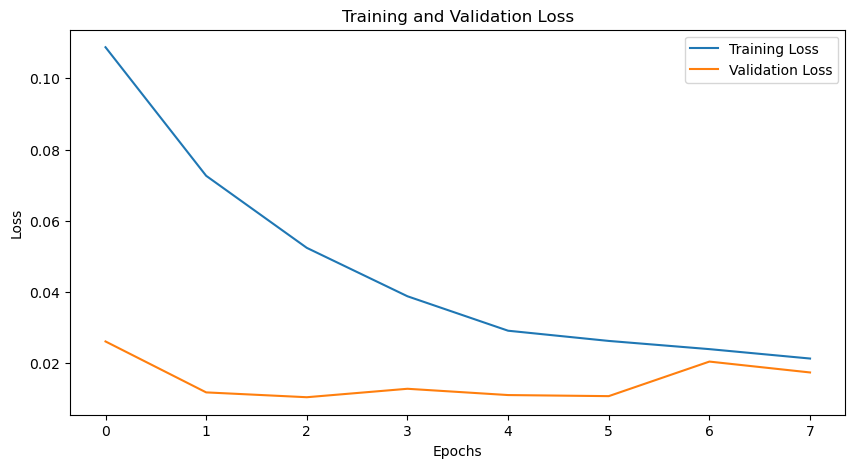

In [51]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Prepare Data
# dataset = FinancialDataset(first_month_data[:1000])
# dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

train_dataset = FinancialDataset(train_data[train_data["permno_id"] == "10104"])
val_dataset = FinancialDataset(validation_data[:100])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize Model
model = TransformerModel(
    input_dim=7 * 1 + 1,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=6,
    output_dim=len(train_dataset.target_columns),
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()

# for epoch in range(5):
#     for batch in dataloader:
#         optimizer.zero_grad()
#         output, _ = model(batch["features"])
#         loss = criterion(output, batch["target"])
#         # print(f'loss: {loss}')
#         loss.backward()
#         optimizer.step()

# print("Training Complete")

train_losses = []
val_losses = []

num_epochs = 10
patience = 5
best_val_loss = float("inf")
patience_counter = 0

# num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        # print(f'loss: {loss}')
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    # Check for early stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [52]:
dataloader = train_dataloader
dataset = train_dataset

In [53]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [54]:
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [55]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-0.42990145,  1.3533293 , -0.36372676, -0.07823209, -1.1189771 ,
         -0.68884283,  0.57743555, -0.40500188,  0.51060176, -1.5522065 ,
          1.1585369 , -0.29067165,  0.52121186,  1.4222393 ,  0.10390822,
          0.84991497,  1.7819719 , -0.15890291, -1.0585308 , -0.01216337,
         -1.1562217 , -0.9960542 ,  0.20628737, -0.95873946, -0.53296906,
          1.3163637 ,  0.84888065, -1.120194  , -0.11171466, -0.89421713,
          1.1610254 ,  0.68668485, -0.30894706,  0.28665504,  0.3529007 ,
          0.83957726,  2.3627298 ,  1.5661166 , -1.4622937 ,  0.3412617 ,
         -1.0132707 , -0.07746607,  1.0715566 ,  1.1692797 , -1.089213  ,
         -2.6595094 ,  1.8868518 ,  0.41697884, -0.70612   ,  0.585481  ,
          1.2251501 , -0.9394358 ,  0.5201406 ,  0.7405599 , -0.14943665,
          0.8647065 ,  0.41813558,  0.87019646,  0.7833466 , -0.64362735,
         -1.3166394 , -0.62675124, -0.21949622, -0.26068363, -1.2170113 ,
         -0.5124887 , -0.36

#### Model Features Check

In [44]:
for batch in dataloader:
    print(batch)
    break

{'features': tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  8.4490e-03,
          6.8240e-03,  1.2800e+02],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  8.6340e-03,
          3.0460e-03,  1.2900e+02],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  1.2769e-02,
          9.2920e-03,  1.3000e+02],
        ...,
        [ 7.0362e-03,  3.6530e-03,  8.6740e-03,  ..., -9.3130e-03,
         -6.7900e-03,  1.5700e+02],
        [ 1.9605e-02,  1.4844e-02,  1.8032e-02,  ...,  7.9830e-03,
          1.0099e-02,  1.5800e+02],
        [ 2.3780e-02,  1.5021e-02,  1.4210e-02,  ...,  3.6560e-03,
          2.3290e-03,  1.5900e+02]]), 'target': tensor([[ 1.2909e-02,  1.2909e-02,  3.9730e-01,  3.9730e-01,  8.6375e-02,
          8.6375e-02,  1.3961e-02,  1.3961e-02,  8.1100e-02,  1.0398e-01,
          1.2514e-01],
        [ 1.5745e-02,  1.5745e-02,  2.5376e-01,  2.5376e-01,  5.7886e-02,
          5.7886e-02,  1.0602e-02,  1.0602e-02,  1.0557e-01,  9.7839e-02,
          1.1782e-01],
  

In [45]:
batch["features"].shape

torch.Size([32, 641])

In [46]:
batch["target"].shape

torch.Size([32, 11])

In [47]:
len(batch["permno_id"])

32

In [48]:
batch["features"][:5]

tensor([[-1.3843e-02,  0.0000e+00,  0.0000e+00,  ...,  8.4490e-03,
          6.8240e-03,  1.2800e+02],
        [ 2.2897e-02,  6.4040e-03,  4.8720e-03,  ...,  8.6340e-03,
          3.0460e-03,  1.2900e+02],
        [ 9.8028e-03,  4.0480e-03,  9.6000e-04,  ...,  1.2769e-02,
          9.2920e-03,  1.3000e+02],
        [ 6.0010e-03,  9.5810e-03,  6.7220e-03,  ...,  3.1830e-03,
         -1.4870e-03,  1.3100e+02],
        [ 1.0467e-02,  2.1420e-03,  5.3540e-03,  ..., -1.2551e-02,
          2.1730e-03,  1.3200e+02]])

In [50]:
model(batch["features"].to(device))

(tensor([[0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0.0140, 0.0357, 0.1624, 0.0172, 0.0598, 0.0089, 0.0221, 0.2595,
          0.2763, 0.2888],
         [0.0010, 0

In [51]:
dataset.sequences[:5]

[(array([-1.38433789e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  2.28968548e-02,  6.40400000e-03,  4.87200000e-03,
          5.90400000e-03,  7.98300000e-03,  9.80279522e-03,  4.04800000e-03,
          9.60000000e-04,  4.02100000e-03,  8.52000000e-04,  6.00095818e-03,
          9.58100000e-03,  6.72200000e-03,  6.19300000e-03,  2.91900000e-03,
          1.04670290e-02,  2.14200000e-03,  5.35400000e-03,  1.82900000e-03,
          5.82800000e-03,  5.49686452e-03, -2.63400000e-03, -2.70400000e-03,
          7.34000000e-04,  3.86000000e-04, -5.31409482e-03, -2.41900000e-03,
         -1.92800000e-03, -1.53900000e-03,  6.60500000e-03,  3.06928492e-03,
          6.46500000e-03,  9.75500000e-03,  8.26400000e-03,  7.22900000e-03,
          1.13750580e-02,  4.34800000e-03,  6.71800000e-03,  6.24600000e-03,
          1.21380000e-02,  1.61469568e-03, -6.57800000e-03, -6.44000000e-03,
         -4.55800000e-03, -2.58900000e-03,  1.36188412e-02,  8.18000000e-03,

In [52]:
np.array(stock_embeddings["10104"]).shape

(256,)

In [53]:
first_month_data[first_month_data["permno_id"] == "10104"]

date permno_id     naics  log_return  abs_log_return  \
9263 2018-01-02     10104  511210.0   -0.013843        0.013843   
9264 2018-01-03     10104  511210.0    0.022897        0.022897   
9265 2018-01-04     10104  511210.0    0.009803        0.009803   
9266 2018-01-05     10104  511210.0    0.006001        0.006001   
9267 2018-01-08     10104  511210.0    0.010467        0.010467   
9268 2018-01-09     10104  511210.0    0.005497        0.005497   
9269 2018-01-10     10104  511210.0   -0.005314        0.005314   
9270 2018-01-11     10104  511210.0    0.003069        0.003069   
9271 2018-01-12     10104  511210.0    0.011375        0.011375   
9272 2018-01-16     10104  511210.0    0.001615        0.001615   
9273 2018-01-17     10104  511210.0    0.013619        0.013619   
9274 2018-01-18     10104  511210.0   -0.000796        0.000796   
9275 2018-01-19     10104  511210.0    0.006944        0.006944   
9276 2018-01-22     10104  511210.0    0.002567        0.002567   
9277 2018-01-23     10104  511210.0    0.008052        0.008052   
9278 2018-01-24     10104  511210.0    0.006434        0.006434   
9279 2018-01-25     10104  511210.0    0.002911        0.002911   
9280 2018-01-26     10104  511210.0    0.022042        0.022042   
9281 2018-01-29     10104  511210.0   -0.015474        0.015474   
9282 2018-01-30     10104  511210.0   -0.019048        0.019048   
9283 2018-01-31     10104  511210.0    0.012287        0.012287   

      sector_weighted_avg_log_return  sector_simple_avg_log_return  \
9263                        0.000000                      0.000000   
9264                        0.006404                      0.004872   
9265                        0.004048                      0.000960   
9266                        0.009581                      0.006722   
9267                        0.002142                      0.005354   
9268                       -0.002634                     -0.002704   
9269                       -0.002419                     -0.001928   
9270                        0.006465                      0.009755   
9271                        0.004348                      0.006718   
9272                       -0.006578                     -0.006440   
9273                        0.008180                      0.006923   
9274                        0.001671                      0.001744   
9275                        0.005238                      0.006409   
9276                        0.013577                      0.007760   
9277                        0.005864                      0.005903   
9278                        0.000861                     -0.002589   
9279                        0.004018                      0.002598   
9280                        0.012870                      0.011550   
9281                       -0.007661                     -0.006313   
9282                       -0.006185                     -0.006102   
9283                        0.005935                      0.003197   

      weighted_avg_log_return  simple_avg_log_return  log_return_7  \
9263                 0.000000               0.000000      0.309424   
9264                 0.005904               0.007983      0.234088   
9265                 0.004021               0.000852      0.183199   
9266                 0.006193               0.002919      0.230474   
9267                 0.001829               0.005828      0.161223   
9268                 0.000734               0.000386      0.169896   
9269                -0.001539               0.006605      0.218286   
9270                 0.008264               0.007229      0.249912   
9271                 0.006246               0.012138      0.218552   
9272                -0.004558              -0.002589      0.226701   
9273                 0.009008               0.014848      0.281010   
9274                -0.001948              -0.004149      0.187872   
9275                 0.005693               0.003366      0.039240   
9276           

## Model-Compare (L1 loss - mean)

In [38]:
train_data[train_data["permno_id"] == "10104"]

date permno_id     naics  log_return  abs_log_return  \
0    2018-01-02     10104  511210.0   -0.013843        0.013843   
1    2018-01-03     10104  511210.0    0.022897        0.022897   
2    2018-01-04     10104  511210.0    0.009803        0.009803   
3    2018-01-05     10104  511210.0    0.006001        0.006001   
4    2018-01-08     10104  511210.0    0.010467        0.010467   
...         ...       ...       ...         ...             ...   
1254 2022-12-23     10104  511210.0    0.004463        0.004463   
1255 2022-12-27     10104  511210.0    0.001607        0.001607   
1256 2022-12-28     10104  511210.0   -0.008059        0.008059   
1257 2022-12-29     10104  511210.0    0.013232        0.013232   
1258 2022-12-30     10104  511210.0    0.004168        0.004168   

      sector_weighted_avg_log_return  sector_simple_avg_log_return  \
0                           0.000000                      0.000000   
1                           0.006404                      0.004872   
2                           0.004048                      0.000960   
3                           0.009581                      0.006722   
4                           0.002142                      0.005354   
...                              ...                           ...   
1254                        0.002641                      0.000440   
1255                       -0.005155                     -0.010350   
1256                       -0.011746                     -0.011982   
1257                        0.026479                      0.028541   
1258                       -0.002466                     -0.002471   

      weighted_avg_log_return  simple_avg_log_return  log_return_7  \
0                    0.000000               0.000000      0.309424   
1                    0.005904               0.007983      0.234088   
2                    0.004021               0.000852      0.183199   
3                    0.006193               0.002919      0.230474   
4                    0.001829               0.005828      0.161223   
...                       ...                    ...           ...   
1254                 0.005100               0.009920      0.240496   
1255                -0.004281              -0.002320      0.335016   
1256                -0.012660              -0.006697      0.484128   
1257                 0.018379               0.020048      0.393108   
1258                -0.003635              -0.000213      0.542588   

      abs_log_return_7  log_return_14  abs_log_return_14  log_return_28  \
0             0.309424       0.131071           0.131071       0.011619   
1             0.234088       0.107382           0.107382       0.006475   
2             0.183199       0.097613           0.097613       0.009651   
3             0.230474       0.120486           0.120486       0.015437   
4             0.161223       0.083731           0.083731       0.012476   
...                ...            ...                ...            ...   
1254          0.240496       0.130254           0.130254       0.030822   
1255          0.335016       0.097081           0.097081       0.027325   
1256          0.484128       0.095868           0.095868       0.026012   
1257          0.393108       0.098543           0.098543       0.021506   
1258          0.542588       0.120443           0.120443       0.021989   

      abs_log_return_28  volatility_7  volatility_14  volatility_28  
0              0.011619      0.136136       0.109282       0.276310  
1              0.006475      0.091648       0.081082       0.268724  
2              0.009651      0.089939       0.079524       0.273385  
3              0.015437      0.105015       0.107098       0.281463  
4              0.012476      0.105560       0.139328       0.280139  
...                 ...           ...            ...            ...  
1254           0.030822      0.167463       0.160461       0.193399  
1255           0.027325      0.173581       0.200194       0.19

In [39]:
id = train_data["permno_id"].unique()
id[:5]

array(['10104', '10107', '10138', '10145', '10516'], dtype=object)

In [40]:
for i in id[::50]:
    print(f"permno_id: {i}")

permno_id: 10104
permno_id: 13688
permno_id: 17005
permno_id: 21936
permno_id: 30681
permno_id: 50876
permno_id: 64653
permno_id: 77274
permno_id: 81774
permno_id: 86745
permno_id: 89866
permno_id: 93246


### Case 1: Past 7 days 1 feauture 1 target

Training for permno_id: 10104
Starting Training...
Epoch 1/10, Training Loss: 0.0691805200651288, Validation Loss: 0.020402623961369198
Epoch 2/10, Training Loss: 0.04643136179074645, Validation Loss: 0.017197975267966587
Epoch 3/10, Training Loss: 0.03593236091546714, Validation Loss: 0.010423732300599417
Epoch 4/10, Training Loss: 0.029089028108865024, Validation Loss: 0.01053159466634194
Epoch 5/10, Training Loss: 0.024280759785324336, Validation Loss: 0.013057247425119082
Epoch 6/10, Training Loss: 0.02110991405788809, Validation Loss: 0.014053739917774996
Epoch 7/10, Training Loss: 0.02051570189651102, Validation Loss: 0.017385246232151985
Epoch 8/10, Training Loss: 0.018900136067532002, Validation Loss: 0.014611285800735155
Early stopping triggered.
Training Complete


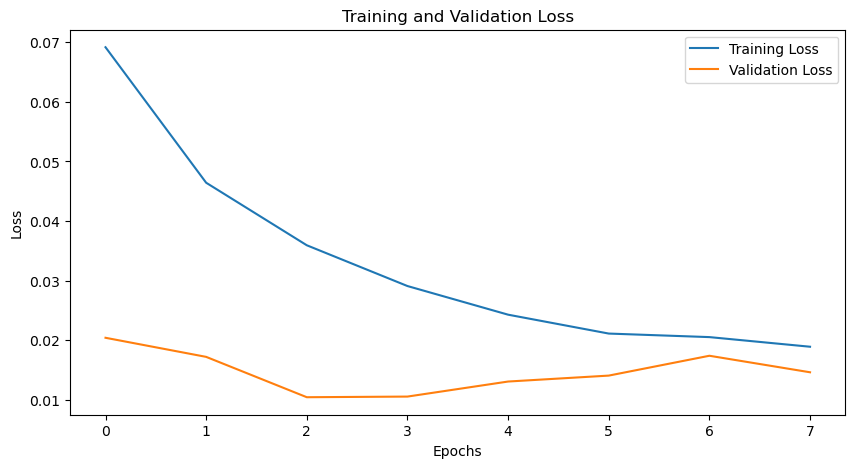

Training for permno_id: 13688
Starting Training...
Epoch 1/10, Training Loss: 0.06322703124023973, Validation Loss: 0.010602097027003765
Epoch 2/10, Training Loss: 0.046222159266471864, Validation Loss: 0.013597496785223484
Epoch 3/10, Training Loss: 0.037350491038523614, Validation Loss: 0.014155689006050428
Epoch 4/10, Training Loss: 0.0339876277372241, Validation Loss: 0.011822622269392014
Epoch 5/10, Training Loss: 0.031321628205478194, Validation Loss: 0.010341157826284567
Epoch 6/10, Training Loss: 0.02959208234678954, Validation Loss: 0.010234495624899864
Epoch 7/10, Training Loss: 0.029190427577123045, Validation Loss: 0.010141252540051937
Epoch 8/10, Training Loss: 0.02833605739288032, Validation Loss: 0.010575809516012669
Epoch 9/10, Training Loss: 0.028042342234402894, Validation Loss: 0.01013209174076716
Epoch 10/10, Training Loss: 0.028011976974084973, Validation Loss: 0.010007732547819614
Training Complete


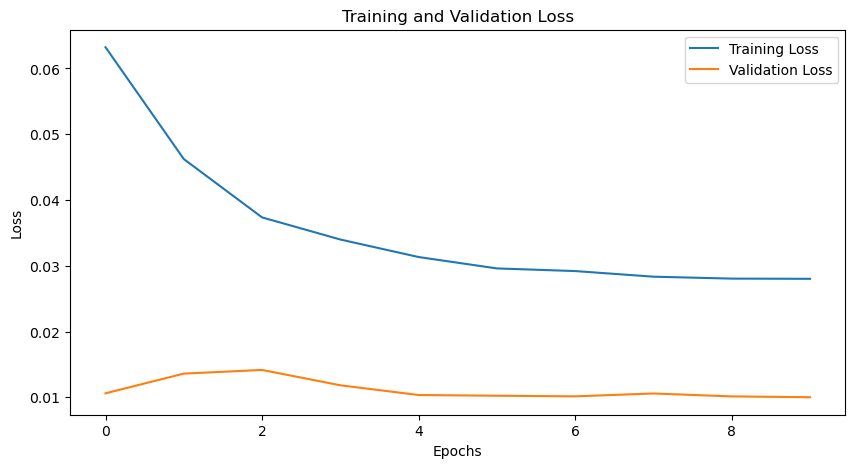

Training for permno_id: 17005
Starting Training...
Epoch 1/10, Training Loss: 0.0821225623600185, Validation Loss: 0.011415294061104456
Epoch 2/10, Training Loss: 0.05282648056745529, Validation Loss: 0.013142015784978867
Epoch 3/10, Training Loss: 0.03998582665808499, Validation Loss: 0.011811137509842714
Epoch 4/10, Training Loss: 0.03091020812280476, Validation Loss: 0.011280419925848642
Epoch 5/10, Training Loss: 0.025171432085335253, Validation Loss: 0.015562398980061213
Epoch 6/10, Training Loss: 0.020682931574992836, Validation Loss: 0.01027051235238711
Epoch 7/10, Training Loss: 0.018357807118445636, Validation Loss: 0.01139475932965676
Epoch 8/10, Training Loss: 0.01775340021122247, Validation Loss: 0.011241616991659006
Epoch 9/10, Training Loss: 0.016410689568147063, Validation Loss: 0.011614305898547173
Epoch 10/10, Training Loss: 0.016253041359595953, Validation Loss: 0.01190822571516037
Training Complete


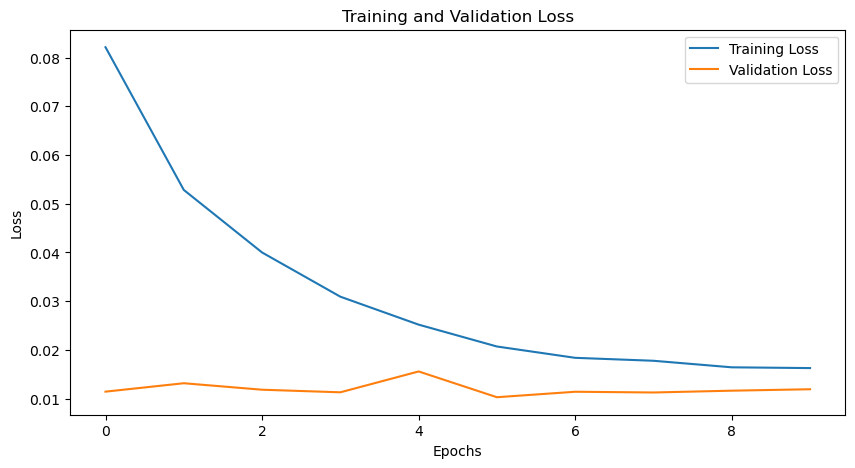

Training for permno_id: 21936
Starting Training...
Epoch 1/10, Training Loss: 0.10538831828162074, Validation Loss: 0.04486209526658058
Epoch 2/10, Training Loss: 0.05208198418840766, Validation Loss: 0.015429742013414701
Epoch 3/10, Training Loss: 0.03595982152037323, Validation Loss: 0.01728144194930792
Epoch 4/10, Training Loss: 0.0273725216742605, Validation Loss: 0.011131304937104384
Epoch 5/10, Training Loss: 0.022973456885665655, Validation Loss: 0.013236197332541147
Epoch 6/10, Training Loss: 0.021103739412501453, Validation Loss: 0.014441259515782198
Epoch 7/10, Training Loss: 0.019396347110159695, Validation Loss: 0.017315921373665333
Epoch 8/10, Training Loss: 0.018988893926143648, Validation Loss: 0.012737464780608812
Epoch 9/10, Training Loss: 0.018857204052619637, Validation Loss: 0.010987992708881697
Epoch 10/10, Training Loss: 0.018280122010037304, Validation Loss: 0.015205197036266327
Training Complete


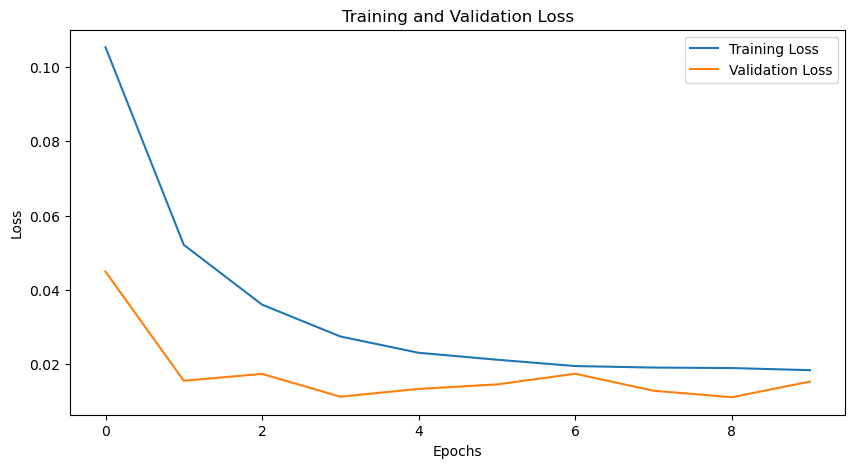

Training for permno_id: 30681
Starting Training...
Epoch 1/10, Training Loss: 0.06675313170999289, Validation Loss: 0.013352288243671259
Epoch 2/10, Training Loss: 0.04828299907967448, Validation Loss: 0.014011746893326441
Epoch 3/10, Training Loss: 0.03556696642190218, Validation Loss: 0.014258705079555511
Epoch 4/10, Training Loss: 0.028480391995981336, Validation Loss: 0.01285465806722641
Epoch 5/10, Training Loss: 0.023994855303317308, Validation Loss: 0.01147544321914514
Epoch 6/10, Training Loss: 0.022287047654390334, Validation Loss: 0.012302665350337824
Epoch 7/10, Training Loss: 0.020432697841897607, Validation Loss: 0.013839696223537127
Epoch 8/10, Training Loss: 0.019165234360843896, Validation Loss: 0.011113559206326803
Epoch 9/10, Training Loss: 0.018243960989639162, Validation Loss: 0.012121526213983694
Epoch 10/10, Training Loss: 0.017857405659742653, Validation Loss: 0.012196912430226803
Training Complete


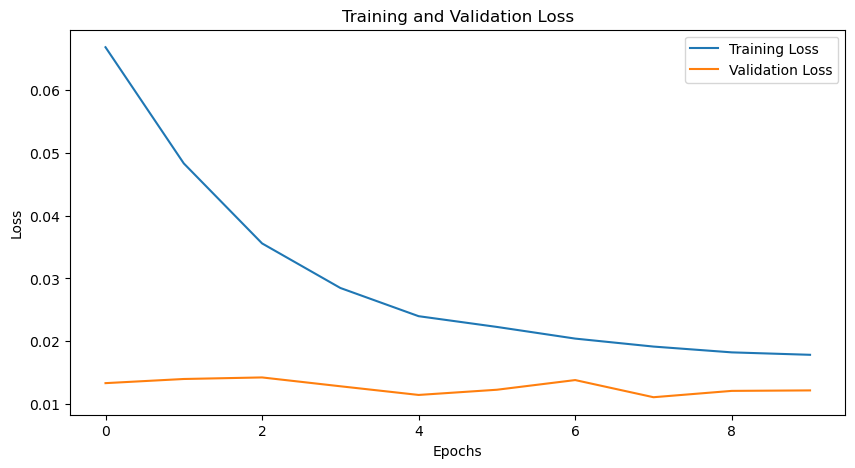

Training for permno_id: 50876
Starting Training...
Epoch 1/10, Training Loss: 0.07063598595559598, Validation Loss: 0.023744069660703342
Epoch 2/10, Training Loss: 0.04676504414528608, Validation Loss: 0.010885264103611311
Epoch 3/10, Training Loss: 0.03491527899168432, Validation Loss: 0.010047757687668005
Epoch 4/10, Training Loss: 0.026648906478658318, Validation Loss: 0.010903261912365755
Epoch 5/10, Training Loss: 0.022117812046781184, Validation Loss: 0.014818662777543068
Epoch 6/10, Training Loss: 0.019605092611163853, Validation Loss: 0.014384815779825052
Epoch 7/10, Training Loss: 0.018728953879326583, Validation Loss: 0.013923601557811102
Epoch 8/10, Training Loss: 0.01813396895304322, Validation Loss: 0.013867496823271116
Early stopping triggered.
Training Complete


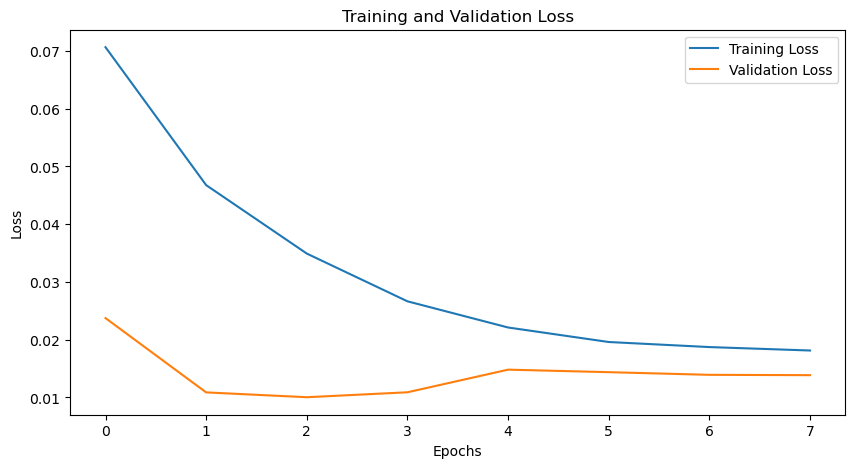

Training for permno_id: 64653
Starting Training...
Epoch 1/10, Training Loss: 0.06778835309669376, Validation Loss: 0.016365316075583298
Epoch 2/10, Training Loss: 0.045542383845895526, Validation Loss: 0.01904984066883723
Epoch 3/10, Training Loss: 0.033164848061278465, Validation Loss: 0.010151830191413561
Epoch 4/10, Training Loss: 0.025252934219315647, Validation Loss: 0.01336288390060266
Epoch 5/10, Training Loss: 0.02057023362722248, Validation Loss: 0.011987480645378431
Epoch 6/10, Training Loss: 0.018325416627340017, Validation Loss: 0.01205552245179812
Epoch 7/10, Training Loss: 0.01638290835544467, Validation Loss: 0.010469347548981508
Epoch 8/10, Training Loss: 0.015005637565627694, Validation Loss: 0.011022442020475864
Early stopping triggered.
Training Complete


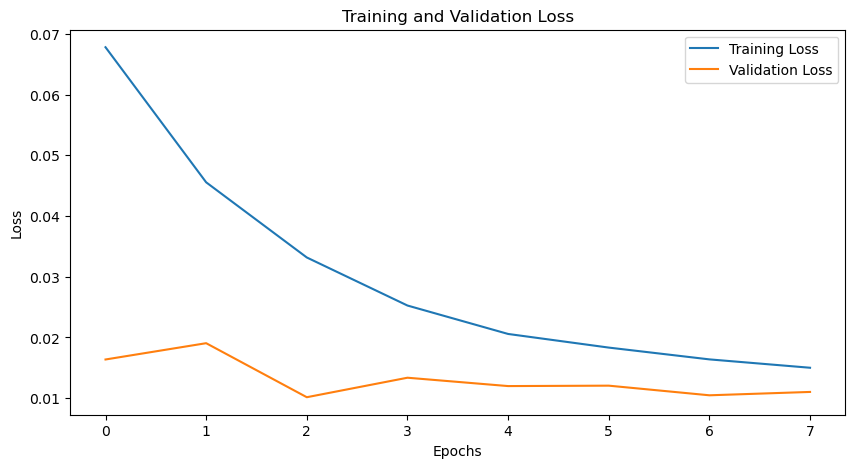

Training for permno_id: 77274
Starting Training...
Epoch 1/10, Training Loss: 0.09557416019961237, Validation Loss: 0.02582076129813989
Epoch 2/10, Training Loss: 0.050360515061765906, Validation Loss: 0.020813381920258205
Epoch 3/10, Training Loss: 0.03507840088568628, Validation Loss: 0.012266273920734724
Epoch 4/10, Training Loss: 0.029342840891331434, Validation Loss: 0.011326621597011885
Epoch 5/10, Training Loss: 0.024293321603909134, Validation Loss: 0.012311316716174284
Epoch 6/10, Training Loss: 0.021806485112756492, Validation Loss: 0.02136663782099883
Epoch 7/10, Training Loss: 0.0206614003283903, Validation Loss: 0.01702422679712375
Epoch 8/10, Training Loss: 0.019554565264843404, Validation Loss: 0.01684349620093902
Epoch 9/10, Training Loss: 0.019475546153262257, Validation Loss: 0.015064030264814695
Early stopping triggered.
Training Complete


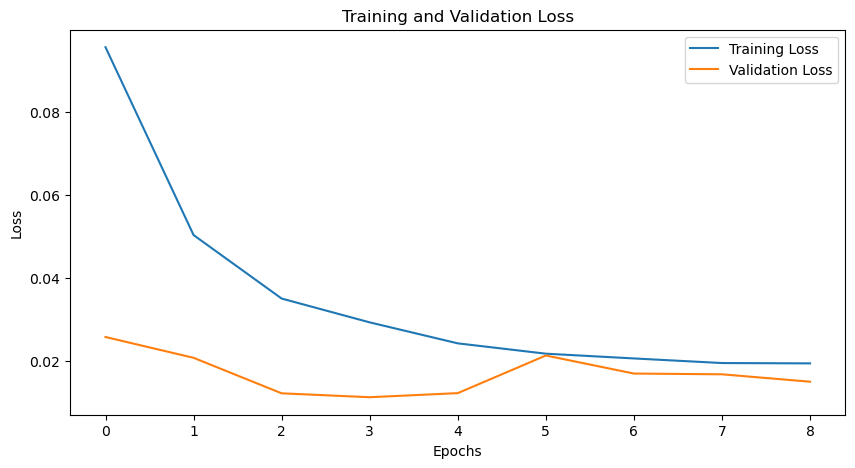

Training for permno_id: 81774
Starting Training...
Epoch 1/10, Training Loss: 0.06223439257591963, Validation Loss: 0.010711132548749447
Epoch 2/10, Training Loss: 0.04611487742513418, Validation Loss: 0.016523248826464016
Epoch 3/10, Training Loss: 0.03694439330138266, Validation Loss: 0.010302292493482431
Epoch 4/10, Training Loss: 0.033397397072985766, Validation Loss: 0.01085922277222077
Epoch 5/10, Training Loss: 0.031302190572023394, Validation Loss: 0.01057602372020483
Epoch 6/10, Training Loss: 0.030015247547999023, Validation Loss: 0.010759150298933188
Epoch 7/10, Training Loss: 0.02915763552300632, Validation Loss: 0.012570176894466082
Epoch 8/10, Training Loss: 0.02902283319272101, Validation Loss: 0.01704558916389942
Early stopping triggered.
Training Complete


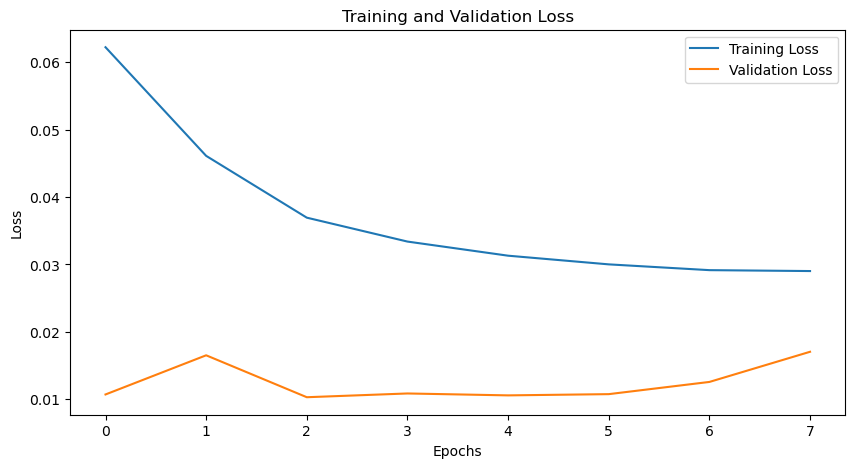

Training for permno_id: 86745
Starting Training...
Epoch 1/10, Training Loss: 0.07288029221817852, Validation Loss: 0.018955962732434273
Epoch 2/10, Training Loss: 0.04996980596333742, Validation Loss: 0.013066322853167852
Epoch 3/10, Training Loss: 0.04075795109383762, Validation Loss: 0.010158483870327473
Epoch 4/10, Training Loss: 0.03691621352918446, Validation Loss: 0.015174351322154203
Epoch 5/10, Training Loss: 0.03401145390234887, Validation Loss: 0.011650558871527513
Epoch 6/10, Training Loss: 0.03222840488888323, Validation Loss: 0.015496168285608292
Epoch 7/10, Training Loss: 0.03170627215877175, Validation Loss: 0.013087954993049303
Epoch 8/10, Training Loss: 0.030631180107593536, Validation Loss: 0.011926999626060327
Early stopping triggered.
Training Complete


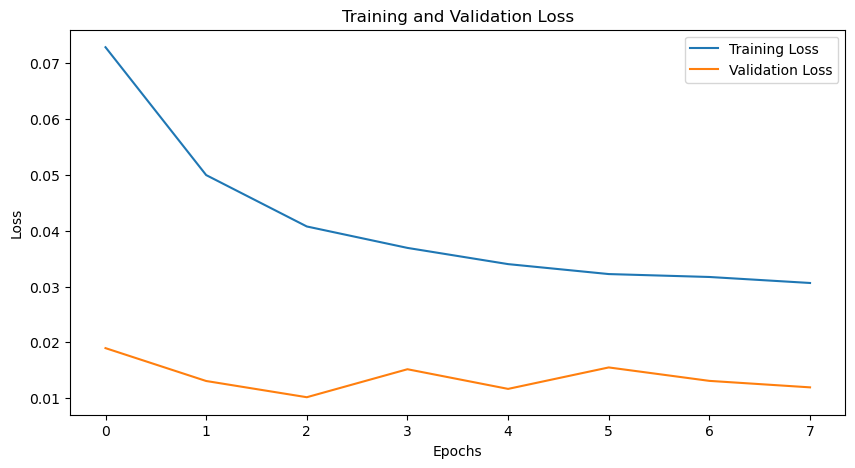

Training for permno_id: 89866
Starting Training...
Epoch 1/10, Training Loss: 0.12704665213823318, Validation Loss: 0.0516199084619681
Epoch 2/10, Training Loss: 0.06195730464532971, Validation Loss: 0.021681996683279674
Epoch 3/10, Training Loss: 0.04726981548592448, Validation Loss: 0.0257597416639328
Epoch 4/10, Training Loss: 0.036446484224870804, Validation Loss: 0.011456515019138655
Epoch 5/10, Training Loss: 0.02839599861763418, Validation Loss: 0.01727086802323659
Epoch 6/10, Training Loss: 0.024411380547098814, Validation Loss: 0.014684733003377914
Epoch 7/10, Training Loss: 0.022125937370583416, Validation Loss: 0.011685806637008985
Epoch 8/10, Training Loss: 0.020303210010752082, Validation Loss: 0.010888929789264997
Epoch 9/10, Training Loss: 0.019140373542904855, Validation Loss: 0.012968425638973713
Epoch 10/10, Training Loss: 0.0186161944642663, Validation Loss: 0.01086574544509252
Training Complete


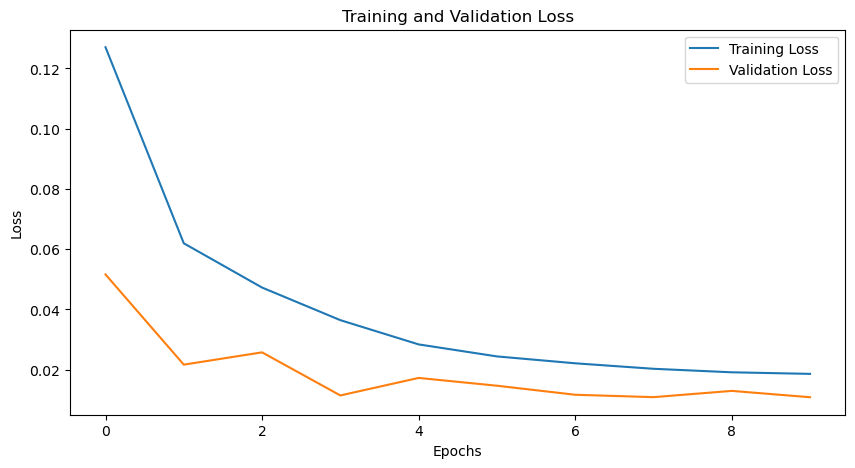

Training for permno_id: 93246
Starting Training...
Epoch 1/10, Training Loss: 0.07006751541048288, Validation Loss: 0.0329008890936772
Epoch 2/10, Training Loss: 0.04933219477534294, Validation Loss: 0.0171795350809892
Epoch 3/10, Training Loss: 0.035961311962455514, Validation Loss: 0.010024511565764746
Epoch 4/10, Training Loss: 0.03132607671432197, Validation Loss: 0.010248905047774315
Epoch 5/10, Training Loss: 0.02893082913942635, Validation Loss: 0.013741264740626017
Epoch 6/10, Training Loss: 0.02660210863687098, Validation Loss: 0.013611646679540476
Epoch 7/10, Training Loss: 0.025959584419615565, Validation Loss: 0.013237065635621548
Epoch 8/10, Training Loss: 0.02552905734628439, Validation Loss: 0.011310700016717115
Early stopping triggered.
Training Complete


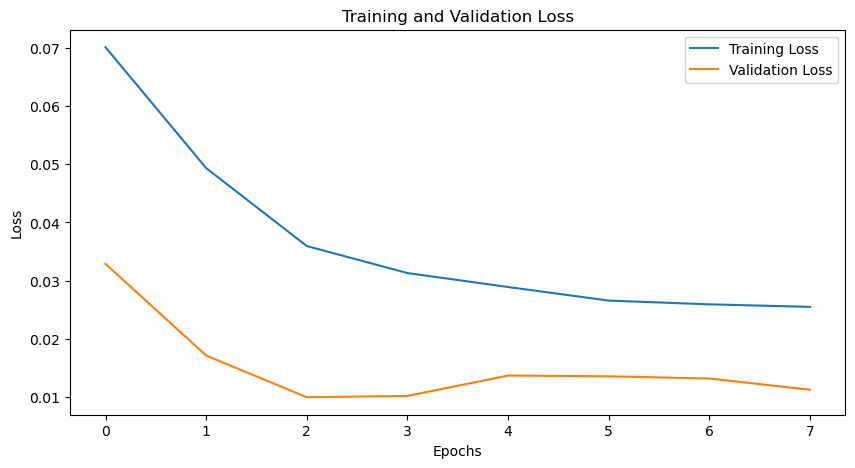

In [74]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Iterate over each unique permno_id in the dataset
unique_permno_ids = train_data["permno_id"].unique()
stock_embeddings = {}

for permno_id in unique_permno_ids[::50]:
    # set_seed(0)  # Set seed for reproducibility
    print(f"Training for permno_id: {permno_id}")

    # Prepare Data
    # dataset = FinancialDataset(first_month_data[:1000])
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
    val_dataset = FinancialDataset(validation_data[:100])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize Model
    model = TransformerModel(
        input_dim=7 * 1 + 1,
        embed_dim=256,
        n_heads=16,
        ff_dim=1024,
        n_layers=6,
        output_dim=len(train_dataset.target_columns),
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training Loop
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
    criterion = nn.L1Loss()

    # for epoch in range(5):
    #     for batch in dataloader:
    #         optimizer.zero_grad()
    #         output, _ = model(batch["features"])
    #         loss = criterion(output, batch["target"])
    #         # print(f'loss: {loss}')
    #         loss.backward()
    #         optimizer.step()

    # print("Training Complete")

    train_losses = []
    val_losses = []

    num_epochs = 10
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    print("Starting Training...")
    # num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            # print(f'loss: {loss}')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                output, _ = model(batch["features"].to(device))
                loss = criterion(output, batch["target"].to(device))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training Complete")

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Extract embeddings for each stock
    model.eval()
    with torch.no_grad():
        permno_embeddings = []
        for batch in train_dataloader:
            _, embeddings = model(batch["features"].to(device))
            permno_embeddings.extend(embeddings.cpu().numpy())

        # Average the embeddings for this permno_id
        stock_embeddings[permno_id] = np.mean(permno_embeddings, axis=0)

    # Extract embeddings for each stock
    # stock_embeddings = {}
    # model.eval()
    # with torch.no_grad():
    #     for batch in train_dataloader:
    #         _, embeddings = model(batch["features"].to(device))
    #         for i, permno_id in enumerate(batch["permno_id"]):
    #             if permno_id not in stock_embeddings:
    #                 stock_embeddings[permno_id] = []
    #             stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

    # # Average the embeddings for each stock
    # for permno_id in stock_embeddings:
    #     stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [75]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 0.53109306, -1.2880319 ,  0.0515605 ,  1.1228507 ,  1.1052736 ,
          0.3942453 , -0.3717118 , -1.3430152 , -0.93846893,  0.3056379 ,
         -0.19596384, -0.20031762, -0.2550949 , -0.18763311,  0.13096271,
          1.592272  ,  0.6411865 ,  0.41833526,  1.4007053 , -1.5665329 ,
         -0.30270445, -1.3504661 , -0.75373274, -0.03171021, -0.5096214 ,
         -0.25956014,  2.0732496 , -0.76553935,  1.0124091 ,  0.08861801,
          0.36512572, -1.5183986 , -0.38069445, -1.7928458 ,  0.11898896,
         -0.28244787, -0.10914864, -1.4155493 , -0.49485105,  0.63271075,
          0.9315318 , -0.625624  ,  0.71100074, -0.06697676, -0.6080242 ,
          0.03510144,  0.578965  ,  0.48332742, -1.8264697 ,  1.088905  ,
         -0.8479897 ,  0.8817474 , -0.8386248 ,  0.95953214, -0.25972086,
         -1.2836435 , -0.0377087 ,  0.87544966,  0.2560594 , -0.6249216 ,
         -0.16597535,  0.04563215, -0.58972263, -2.5342996 , -0.84194076,
          0.30795035,  0.56

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[ 1.00000000e+00, -1.20968744e-02,  4.78992686e-02,
        -3.99134234e-02,  6.76873997e-02, -7.84777403e-02,
        -4.92593087e-02,  1.07391858e-02,  2.31948104e-02,
        -2.17693839e-02, -5.11828437e-02, -3.81899974e-03],
       [-1.20968744e-02,  1.00000012e+00, -1.31715313e-02,
        -7.42333829e-02,  3.94926816e-02, -4.60555108e-04,
        -6.96506649e-02, -4.48155887e-02,  8.52049589e-02,
         9.43394750e-02,  5.29153831e-03, -1.59200374e-02],
       [ 4.78992686e-02, -1.31715313e-02,  1.00000012e+00,
        -4.34030741e-02,  6.18687719e-02,  1.73041373e-02,
         1.08486056e-01, -5.80739155e-02,  7.51726925e-02,
        -5.12199923e-02,  1.05074205e-01,  1.82014838e-01],
       [-3.99134234e-02, -7.42333829e-02, -4.34030741e-02,
         9.99999821e-01,  9.68018398e-02, -2.05816906e-02,
        -9.89963561e-02,  1.29002452e-01, -3.90951075e-02,
         5.77059537e-02,  4.42129076e-02, -2.53365207e-02],
       [ 6.76873997e-02,  3.94926816e-02,  6.1868771

### Case 2: Past 7 days 1 feauture 11 targets

Training for permno_id: 10104
Starting Training...
Epoch 1/10, Training Loss: 0.17176173776388168, Validation Loss: 0.09940169751644135
Epoch 2/10, Training Loss: 0.12706019785255193, Validation Loss: 0.07386937489112218
Epoch 3/10, Training Loss: 0.10986849348992109, Validation Loss: 0.05951701973875364
Epoch 4/10, Training Loss: 0.10348564479500055, Validation Loss: 0.05678065617879232
Epoch 5/10, Training Loss: 0.098969448171556, Validation Loss: 0.0539464478691419
Epoch 6/10, Training Loss: 0.09697764534503221, Validation Loss: 0.053702774147192635
Epoch 7/10, Training Loss: 0.09511279286816716, Validation Loss: 0.052585311233997345
Epoch 8/10, Training Loss: 0.09389689704403281, Validation Loss: 0.05368740359942118
Epoch 9/10, Training Loss: 0.0922265550121665, Validation Loss: 0.05306069180369377
Epoch 10/10, Training Loss: 0.09081886438652872, Validation Loss: 0.05259170445303122
Training Complete


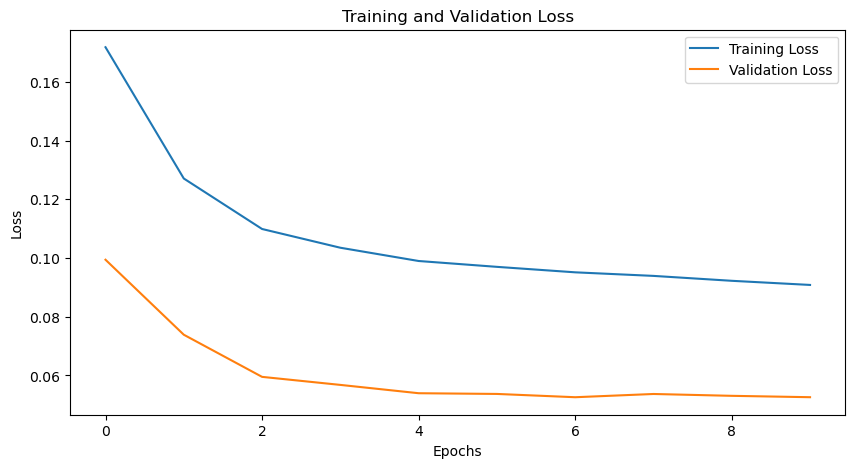

Training for permno_id: 13688
Starting Training...
Epoch 1/10, Training Loss: 0.2914330752566457, Validation Loss: 0.06612159684300423
Epoch 2/10, Training Loss: 0.25098714269697664, Validation Loss: 0.059979760398467384
Epoch 3/10, Training Loss: 0.23772674351930617, Validation Loss: 0.06536393736799558
Epoch 4/10, Training Loss: 0.23260934501886368, Validation Loss: 0.06631372372309367
Epoch 5/10, Training Loss: 0.22911127153784036, Validation Loss: 0.06675482913851738
Epoch 6/10, Training Loss: 0.2273126496002078, Validation Loss: 0.0665638546148936
Epoch 7/10, Training Loss: 0.22704311553388834, Validation Loss: 0.06619738290707271
Early stopping triggered.
Training Complete


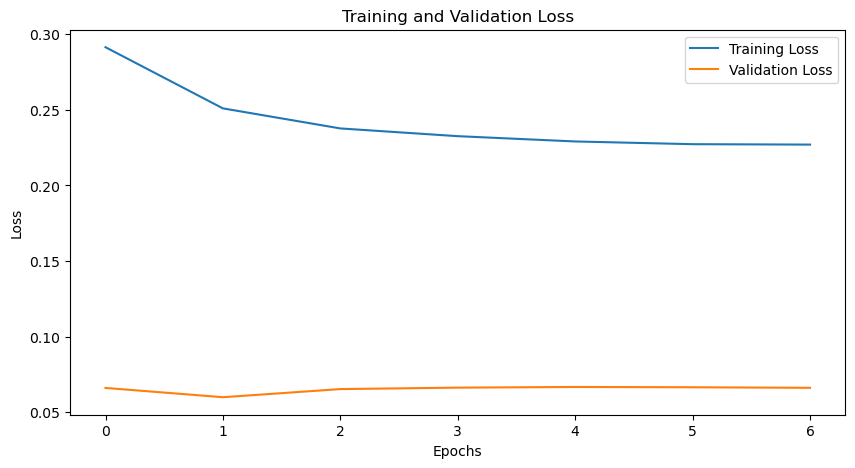

Training for permno_id: 17005
Starting Training...
Epoch 1/10, Training Loss: 0.13231186978518963, Validation Loss: 0.07027434930205345
Epoch 2/10, Training Loss: 0.09581204177811742, Validation Loss: 0.05491522327065468
Epoch 3/10, Training Loss: 0.08776017678901553, Validation Loss: 0.05466571884850661
Epoch 4/10, Training Loss: 0.08448973866179585, Validation Loss: 0.053614490975936256
Epoch 5/10, Training Loss: 0.0824684277176857, Validation Loss: 0.05425032787024975
Epoch 6/10, Training Loss: 0.08086227755993605, Validation Loss: 0.05340781559546789
Epoch 7/10, Training Loss: 0.07953153420239686, Validation Loss: 0.05335588877399763
Epoch 8/10, Training Loss: 0.07890269653871655, Validation Loss: 0.053009480237960815
Epoch 9/10, Training Loss: 0.07789666056632996, Validation Loss: 0.05267223591605822
Epoch 10/10, Training Loss: 0.07772850282490254, Validation Loss: 0.05463504853347937
Training Complete


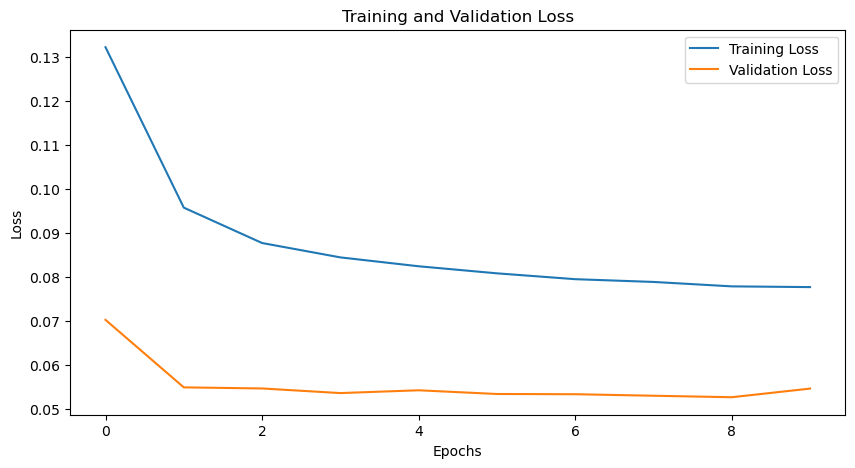

Training for permno_id: 21936
Starting Training...
Epoch 1/10, Training Loss: 0.12652632165700198, Validation Loss: 0.07230871170759201
Epoch 2/10, Training Loss: 0.09398316498845816, Validation Loss: 0.05417695268988609
Epoch 3/10, Training Loss: 0.08866248652338982, Validation Loss: 0.054810864229997
Epoch 4/10, Training Loss: 0.08474620059132576, Validation Loss: 0.05290344605843226
Epoch 5/10, Training Loss: 0.08150109266862274, Validation Loss: 0.053498029708862305
Epoch 6/10, Training Loss: 0.08023758614435791, Validation Loss: 0.05322650074958801
Epoch 7/10, Training Loss: 0.07921204175800085, Validation Loss: 0.05156225711107254
Epoch 8/10, Training Loss: 0.0782801728695631, Validation Loss: 0.05199083064993223
Epoch 9/10, Training Loss: 0.0776086869649589, Validation Loss: 0.051151029765605927
Epoch 10/10, Training Loss: 0.07692941343411804, Validation Loss: 0.051593647028009094
Training Complete


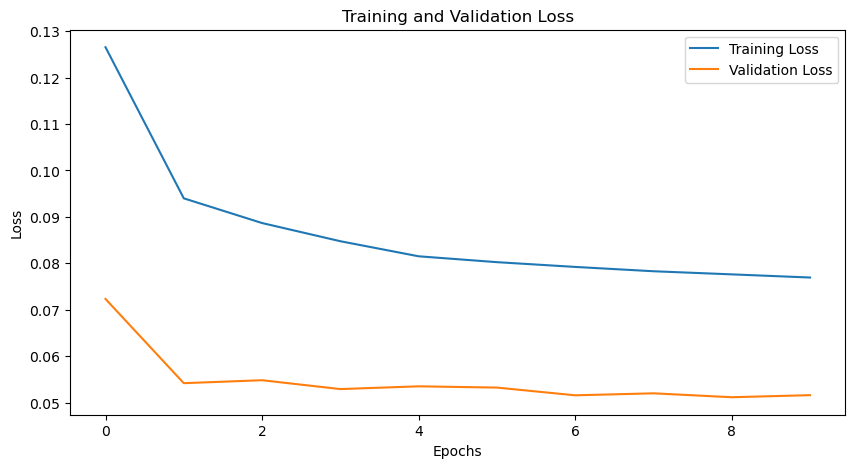

Training for permno_id: 30681
Starting Training...
Epoch 1/10, Training Loss: 0.15776216983795166, Validation Loss: 0.07980266958475113
Epoch 2/10, Training Loss: 0.11410086490213871, Validation Loss: 0.05819926535089811
Epoch 3/10, Training Loss: 0.10353898433968425, Validation Loss: 0.05475962286194166
Epoch 4/10, Training Loss: 0.09892721595242619, Validation Loss: 0.05434699480732282
Epoch 5/10, Training Loss: 0.09621252305805683, Validation Loss: 0.05288489411274592
Epoch 6/10, Training Loss: 0.09445022754371166, Validation Loss: 0.05229784548282623
Epoch 7/10, Training Loss: 0.0928858982399106, Validation Loss: 0.05374214984476566
Epoch 8/10, Training Loss: 0.09237807812169194, Validation Loss: 0.052349175016085304
Epoch 9/10, Training Loss: 0.09038233552128076, Validation Loss: 0.053468567629655205
Epoch 10/10, Training Loss: 0.09032520847395062, Validation Loss: 0.05281872053941091
Training Complete


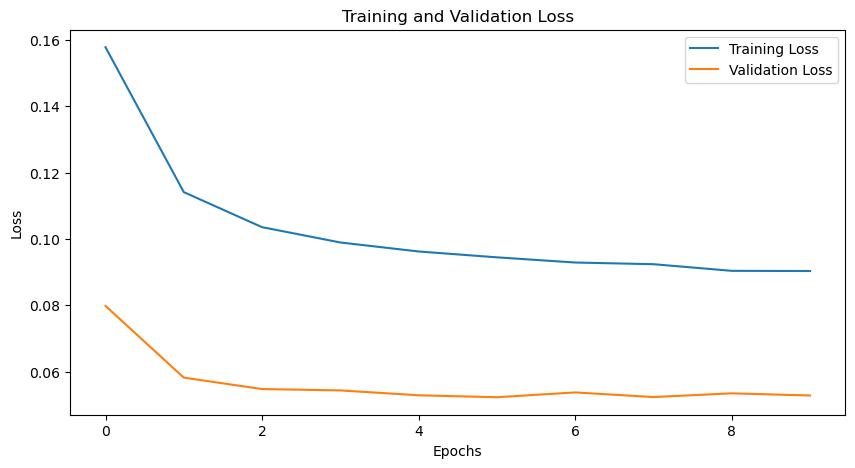

Training for permno_id: 50876
Starting Training...
Epoch 1/10, Training Loss: 0.13776086792349815, Validation Loss: 0.07403108725945155
Epoch 2/10, Training Loss: 0.10600362047553062, Validation Loss: 0.05767285575469335
Epoch 3/10, Training Loss: 0.09503539921715856, Validation Loss: 0.05548166359464327
Epoch 4/10, Training Loss: 0.09153517950326204, Validation Loss: 0.0546561311930418
Epoch 5/10, Training Loss: 0.08786725047975778, Validation Loss: 0.05371042092641195
Epoch 6/10, Training Loss: 0.08634294886142016, Validation Loss: 0.05399371683597565
Epoch 7/10, Training Loss: 0.08514670971781016, Validation Loss: 0.053912373880545296
Epoch 8/10, Training Loss: 0.08390240352600813, Validation Loss: 0.05312115574876467
Epoch 9/10, Training Loss: 0.08173292186111211, Validation Loss: 0.05310362453262011
Epoch 10/10, Training Loss: 0.08167939940467477, Validation Loss: 0.05437001585960388
Training Complete


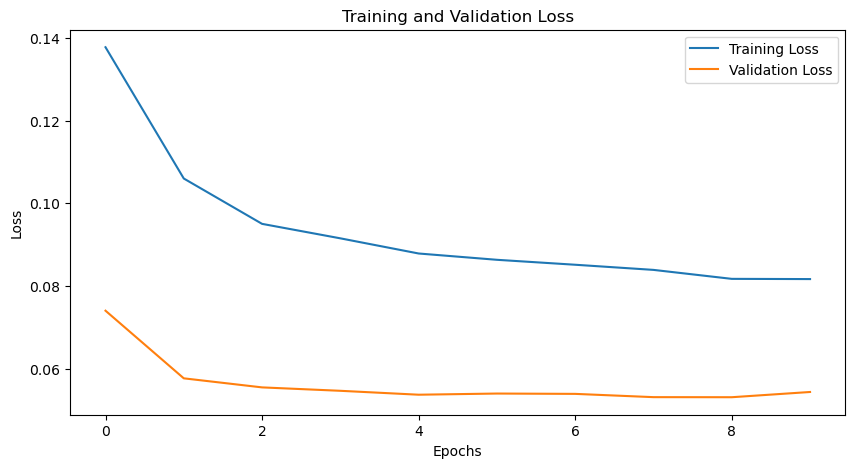

Training for permno_id: 64653
Starting Training...
Epoch 1/10, Training Loss: 0.1428127782419324, Validation Loss: 0.0806756541132927
Epoch 2/10, Training Loss: 0.09935801364481449, Validation Loss: 0.0598524771630764
Epoch 3/10, Training Loss: 0.08726777574047447, Validation Loss: 0.056840021163225174
Epoch 4/10, Training Loss: 0.08359721889719367, Validation Loss: 0.054087972889343895
Epoch 5/10, Training Loss: 0.08092330768704414, Validation Loss: 0.05325611556569735
Epoch 6/10, Training Loss: 0.07938201799988746, Validation Loss: 0.054192995031674705
Epoch 7/10, Training Loss: 0.07853341465815902, Validation Loss: 0.05504699920614561
Epoch 8/10, Training Loss: 0.07675707228481769, Validation Loss: 0.05381528412302335
Epoch 9/10, Training Loss: 0.07606365643441677, Validation Loss: 0.05271045925716559
Epoch 10/10, Training Loss: 0.07593483412638306, Validation Loss: 0.05316937590638796
Training Complete


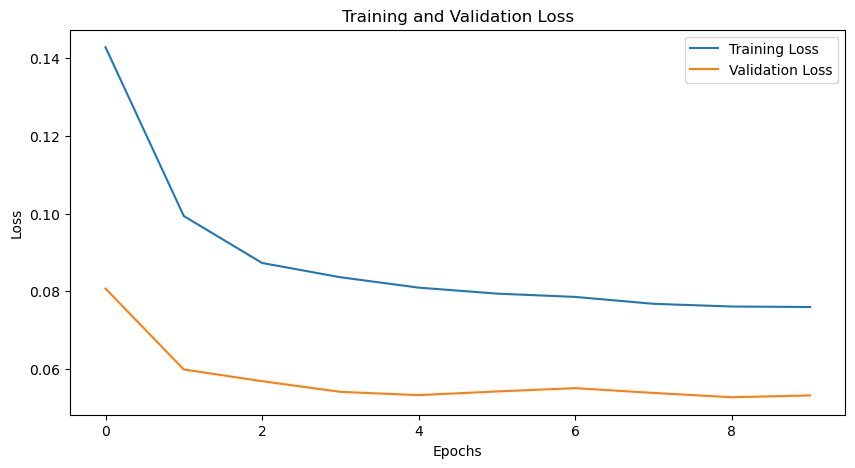

Training for permno_id: 77274
Starting Training...
Epoch 1/10, Training Loss: 0.15306899677962066, Validation Loss: 0.09084975471099217
Epoch 2/10, Training Loss: 0.0998470088467002, Validation Loss: 0.06111147999763489
Epoch 3/10, Training Loss: 0.08871201006695628, Validation Loss: 0.05814841203391552
Epoch 4/10, Training Loss: 0.08311125775799155, Validation Loss: 0.056194476783275604
Epoch 5/10, Training Loss: 0.07982433894649148, Validation Loss: 0.05607011293371519
Epoch 6/10, Training Loss: 0.07759610554203392, Validation Loss: 0.05460634455084801
Epoch 7/10, Training Loss: 0.0760076155886054, Validation Loss: 0.05547633394598961
Epoch 8/10, Training Loss: 0.07476261779665946, Validation Loss: 0.05460625266035398
Epoch 9/10, Training Loss: 0.07368692457675934, Validation Loss: 0.054353270679712296
Epoch 10/10, Training Loss: 0.0721506136469543, Validation Loss: 0.054517149925231934
Training Complete


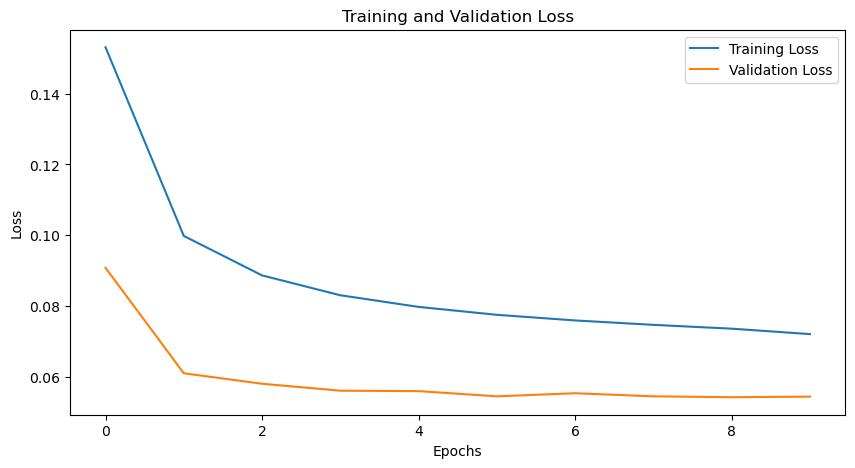

Training for permno_id: 81774
Starting Training...
Epoch 1/10, Training Loss: 0.2908950515091419, Validation Loss: 0.10969555874665578
Epoch 2/10, Training Loss: 0.23460495769977568, Validation Loss: 0.08676847567160924
Epoch 3/10, Training Loss: 0.18973559737205506, Validation Loss: 0.09374798089265823
Epoch 4/10, Training Loss: 0.16883729957044125, Validation Loss: 0.10695663342873256
Epoch 5/10, Training Loss: 0.16231633834540843, Validation Loss: 0.10540243238210678
Epoch 6/10, Training Loss: 0.16138148363679647, Validation Loss: 0.10556625078121822
Epoch 7/10, Training Loss: 0.15756663773208857, Validation Loss: 0.1088187446196874
Early stopping triggered.
Training Complete


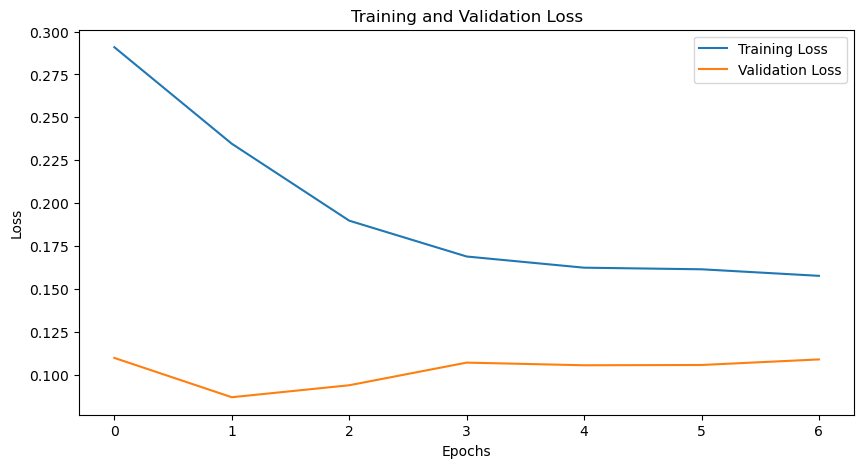

Training for permno_id: 86745
Starting Training...
Epoch 1/10, Training Loss: 0.32221919372677804, Validation Loss: 0.07253177091479301
Epoch 2/10, Training Loss: 0.25411550514400005, Validation Loss: 0.106813778479894
Epoch 3/10, Training Loss: 0.2437413115054369, Validation Loss: 0.11228523155053456
Epoch 4/10, Training Loss: 0.2410587090998888, Validation Loss: 0.11332410822312038
Epoch 5/10, Training Loss: 0.23771971166133882, Validation Loss: 0.121318685511748
Epoch 6/10, Training Loss: 0.237731372192502, Validation Loss: 0.1162579283118248
Early stopping triggered.
Training Complete


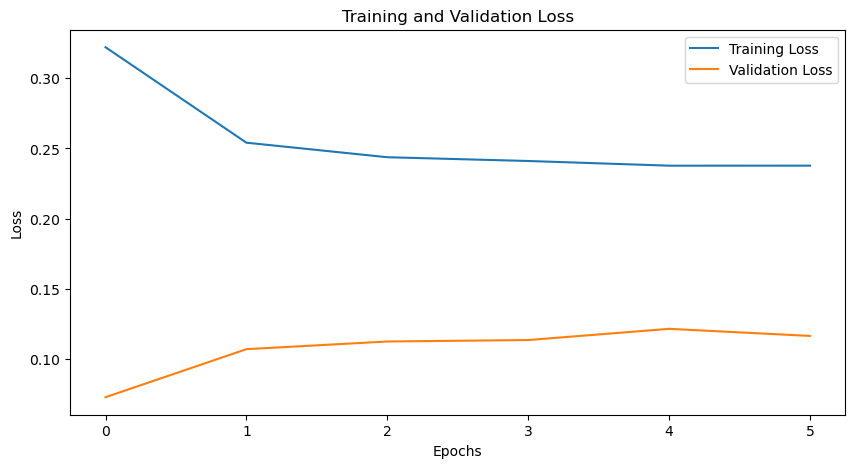

Training for permno_id: 89866
Starting Training...
Epoch 1/10, Training Loss: 0.2205322589725256, Validation Loss: 0.1118382140994072
Epoch 2/10, Training Loss: 0.1483532555401325, Validation Loss: 0.055442728102207184
Epoch 3/10, Training Loss: 0.12465519346296787, Validation Loss: 0.053853953878084816
Epoch 4/10, Training Loss: 0.11768020940944553, Validation Loss: 0.05582169070839882
Epoch 5/10, Training Loss: 0.11348655428737402, Validation Loss: 0.05459794029593468
Epoch 6/10, Training Loss: 0.11185594899579883, Validation Loss: 0.058541204780340195
Epoch 7/10, Training Loss: 0.11045841528102755, Validation Loss: 0.057260158161322273
Epoch 8/10, Training Loss: 0.10876673003658652, Validation Loss: 0.058304060250520706
Early stopping triggered.
Training Complete


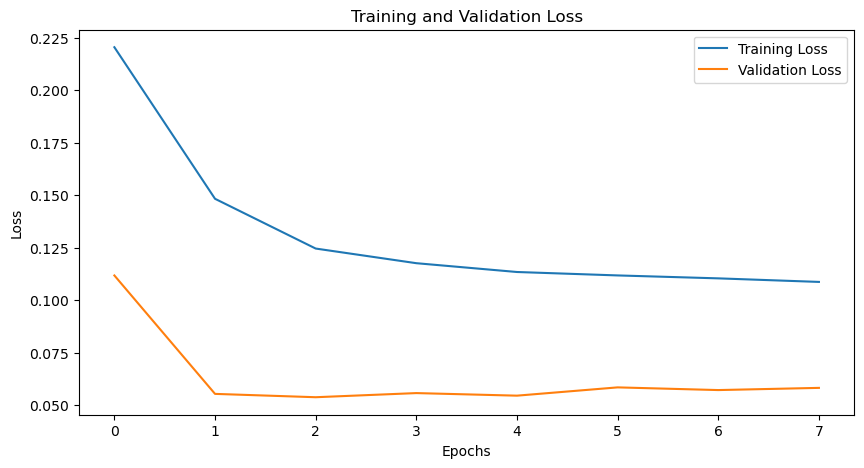

Training for permno_id: 93246
Starting Training...
Epoch 1/10, Training Loss: 0.20918570905923844, Validation Loss: 0.06617314616839091
Epoch 2/10, Training Loss: 0.16223057452589273, Validation Loss: 0.07850347956021626
Epoch 3/10, Training Loss: 0.15249179266393184, Validation Loss: 0.07965753724177678
Epoch 4/10, Training Loss: 0.14739284813404083, Validation Loss: 0.08647023886442184
Epoch 5/10, Training Loss: 0.14447645526379346, Validation Loss: 0.08912008007367452
Epoch 6/10, Training Loss: 0.14297364465892315, Validation Loss: 0.08925504734118779
Early stopping triggered.
Training Complete


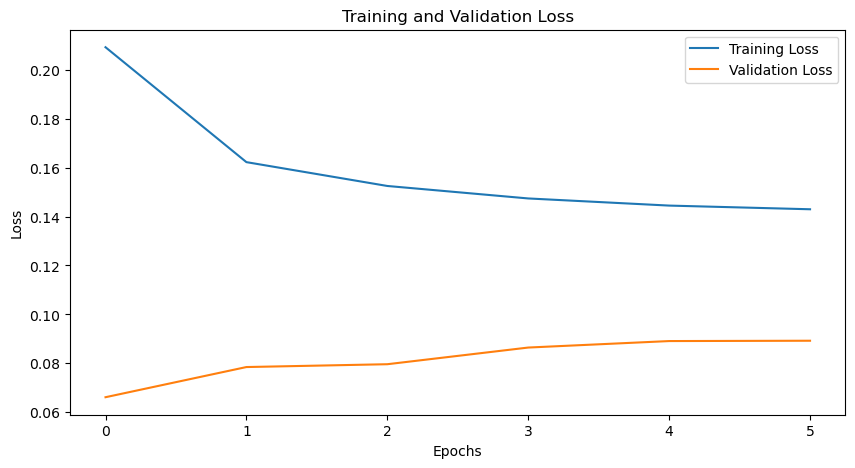

In [75]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Iterate over each unique permno_id in the dataset
unique_permno_ids = train_data["permno_id"].unique()
stock_embeddings = {}

for permno_id in unique_permno_ids[::50]:
    # set_seed(0)  # Set seed for reproducibility
    print(f"Training for permno_id: {permno_id}")

    # Prepare Data
    # dataset = FinancialDataset(first_month_data[:1000])
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
    val_dataset = FinancialDataset(validation_data[:100])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize Model
    model = TransformerModel(
        input_dim=7 * 1 + 1,
        embed_dim=256,
        n_heads=16,
        ff_dim=1024,
        n_layers=6,
        output_dim=len(train_dataset.target_columns),
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training Loop
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
    criterion = nn.L1Loss()

    # for epoch in range(5):
    #     for batch in dataloader:
    #         optimizer.zero_grad()
    #         output, _ = model(batch["features"])
    #         loss = criterion(output, batch["target"])
    #         # print(f'loss: {loss}')
    #         loss.backward()
    #         optimizer.step()

    # print("Training Complete")

    train_losses = []
    val_losses = []

    num_epochs = 10
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    print("Starting Training...")
    # num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            # print(f'loss: {loss}')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                output, _ = model(batch["features"].to(device))
                loss = criterion(output, batch["target"].to(device))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training Complete")

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Extract embeddings for each stock
    model.eval()
    with torch.no_grad():
        permno_embeddings = []
        for batch in train_dataloader:
            _, embeddings = model(batch["features"].to(device))
            permno_embeddings.extend(embeddings.cpu().numpy())

        # Average the embeddings for this permno_id
        stock_embeddings[permno_id] = np.mean(permno_embeddings, axis=0)

    # Extract embeddings for each stock
    # stock_embeddings = {}
    # model.eval()
    # with torch.no_grad():
    #     for batch in train_dataloader:
    #         _, embeddings = model(batch["features"].to(device))
    #         for i, permno_id in enumerate(batch["permno_id"]):
    #             if permno_id not in stock_embeddings:
    #                 stock_embeddings[permno_id] = []
    #             stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

    # # Average the embeddings for each stock
    # for permno_id in stock_embeddings:
    #     stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [76]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 0.43237942, -2.0208035 , -0.18147121, -0.6603974 , -1.7145147 ,
         -2.021409  , -1.3181858 , -0.10654511,  0.7612951 ,  0.9753272 ,
          1.4603401 , -0.32419398, -0.9898257 , -1.3174334 ,  0.8500501 ,
          0.49174944, -0.972997  , -1.0860127 , -0.92649   ,  0.4610167 ,
         -1.852286  ,  3.6549864 , -0.18200046, -0.22805636,  0.63624334,
         -0.20418829,  0.92670876,  1.2228296 , -0.15067194,  0.23742177,
          0.20707151,  0.5509861 , -0.05531519, -0.39111722,  0.7156975 ,
          0.47746408,  0.27800035,  0.39001602, -0.8922292 ,  0.29153788,
         -1.389712  ,  0.29068866, -0.31089628,  0.89168346,  0.17020512,
          0.18003327,  0.10600289,  0.06307901,  2.8974605 , -0.3662742 ,
         -0.31223303,  1.5956095 ,  0.9475953 , -0.4517738 , -0.7928356 ,
          0.63191146,  1.6890177 ,  1.5399047 , -1.3293217 ,  0.5205492 ,
          1.384002  , -2.0216582 , -0.07173498,  0.22000207,  0.17264447,
          0.36497322, -0.53

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[ 1.0000001e+00, -1.4636013e-01, -1.1994187e-02, -4.8079200e-02,
         3.1764463e-02, -3.4424055e-02,  9.0800762e-02, -2.4487713e-02,
         2.1604878e-04, -9.7084746e-02,  6.2043805e-02,  8.3591148e-02],
       [-1.4636013e-01,  9.9999988e-01, -1.2487272e-02,  3.8792135e-03,
         3.6837719e-02,  8.0638537e-03, -1.7050218e-02,  1.0402260e-01,
         1.1988430e-02, -5.3438819e-03,  3.4677550e-02, -5.3558879e-02],
       [-1.1994187e-02, -1.2487272e-02,  1.0000004e+00,  3.7313178e-02,
        -5.1482148e-02,  2.5141351e-02,  1.2460023e-01, -5.2969478e-02,
        -5.6278553e-02, -1.3271274e-02,  7.4728727e-02, -5.1860582e-02],
       [-4.8079200e-02,  3.8792135e-03,  3.7313178e-02,  9.9999982e-01,
         9.4747253e-02, -4.5729931e-02,  3.8659882e-02,  9.7934298e-02,
        -6.3226465e-03,  7.9008285e-03, -1.3053225e-02,  2.4756320e-02],
       [ 3.1764463e-02,  3.6837719e-02, -5.1482148e-02,  9.4747253e-02,
         9.9999994e-01, -2.2905168e-01,  2.5623288e-02, -4.3

### Case 3: Past 7 days 5 feautures 1 targets

Training for permno_id: 10104
Starting Training...
Epoch 1/10, Training Loss: 0.0671267150901258, Validation Loss: 0.011465008991460005
Epoch 2/10, Training Loss: 0.047704423358663914, Validation Loss: 0.011597517256935438
Epoch 3/10, Training Loss: 0.03450185614638031, Validation Loss: 0.010974610845247904
Epoch 4/10, Training Loss: 0.026126322988420724, Validation Loss: 0.010190600529313087
Epoch 5/10, Training Loss: 0.021934242686256766, Validation Loss: 0.011295088256398836
Epoch 6/10, Training Loss: 0.019167374062817544, Validation Loss: 0.010715416943033537
Epoch 7/10, Training Loss: 0.01693406803533435, Validation Loss: 0.010425221485396227
Epoch 8/10, Training Loss: 0.01610191825311631, Validation Loss: 0.010633247904479504
Epoch 9/10, Training Loss: 0.015658779651857913, Validation Loss: 0.01023649579534928
Early stopping triggered.
Training Complete


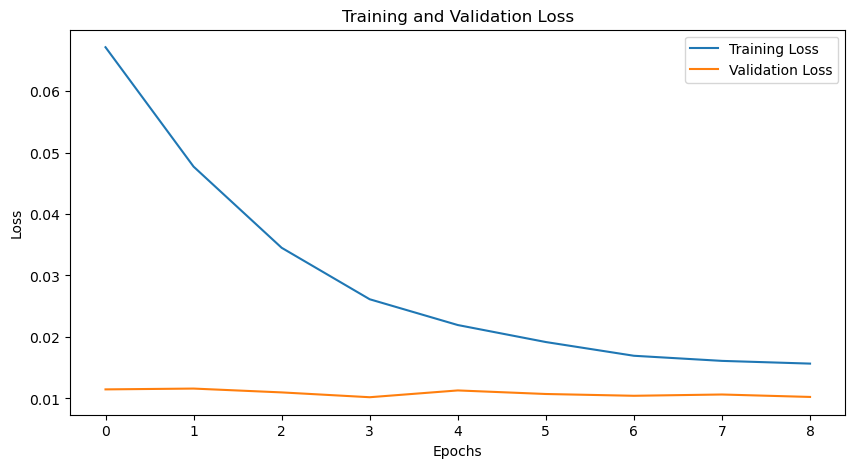

Training for permno_id: 13688
Starting Training...
Epoch 1/10, Training Loss: 0.07331319469958544, Validation Loss: 0.02281639228264491
Epoch 2/10, Training Loss: 0.054022631142288446, Validation Loss: 0.012037605978548527
Epoch 3/10, Training Loss: 0.04489478091709316, Validation Loss: 0.02060390015443166
Epoch 4/10, Training Loss: 0.040062091127038, Validation Loss: 0.014286508783698082
Epoch 5/10, Training Loss: 0.03689721622504294, Validation Loss: 0.01773788593709469
Epoch 6/10, Training Loss: 0.034873003233224155, Validation Loss: 0.012677900803585848
Epoch 7/10, Training Loss: 0.03423608797602355, Validation Loss: 0.0196542094151179
Early stopping triggered.
Training Complete


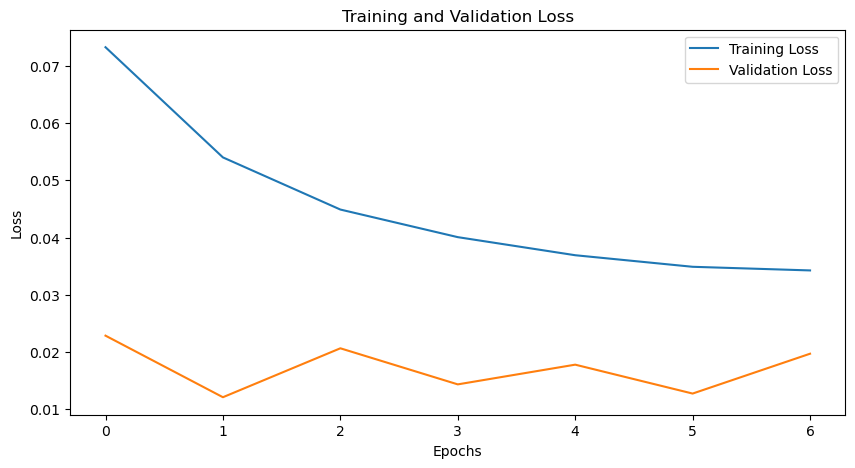

Training for permno_id: 17005
Starting Training...
Epoch 1/10, Training Loss: 0.06069270297884941, Validation Loss: 0.01067951445778211
Epoch 2/10, Training Loss: 0.04036970655433834, Validation Loss: 0.017098823251823585
Epoch 3/10, Training Loss: 0.030907581700012086, Validation Loss: 0.011609365232288837
Epoch 4/10, Training Loss: 0.025244924193248152, Validation Loss: 0.012164519168436527
Epoch 5/10, Training Loss: 0.021924422588199377, Validation Loss: 0.011653682527442774
Epoch 6/10, Training Loss: 0.019006312754936517, Validation Loss: 0.013279233748714129
Early stopping triggered.
Training Complete


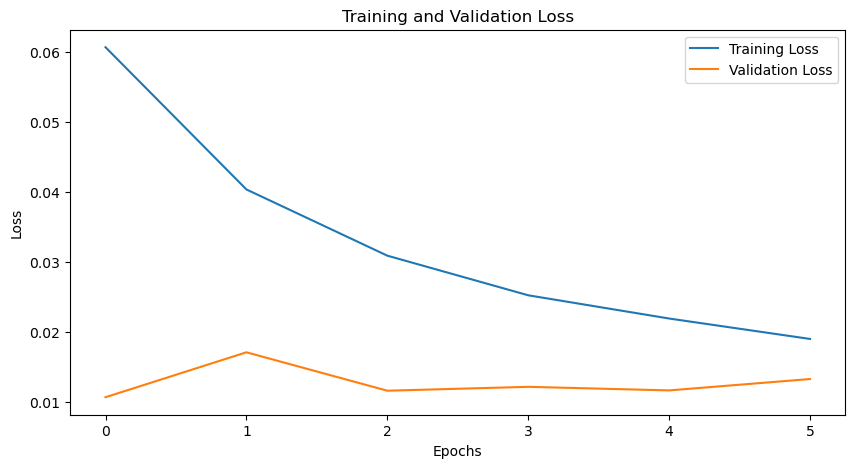

Training for permno_id: 21936
Starting Training...
Epoch 1/10, Training Loss: 0.06439657295122743, Validation Loss: 0.010147706605494022
Epoch 2/10, Training Loss: 0.04553001299500466, Validation Loss: 0.011719717644155025
Epoch 3/10, Training Loss: 0.030528921354562043, Validation Loss: 0.01794273902972539
Epoch 4/10, Training Loss: 0.02565192338079214, Validation Loss: 0.031445578982432686
Epoch 5/10, Training Loss: 0.02265331130474806, Validation Loss: 0.026748470962047577
Epoch 6/10, Training Loss: 0.021007969486527146, Validation Loss: 0.02696004758278529
Early stopping triggered.
Training Complete


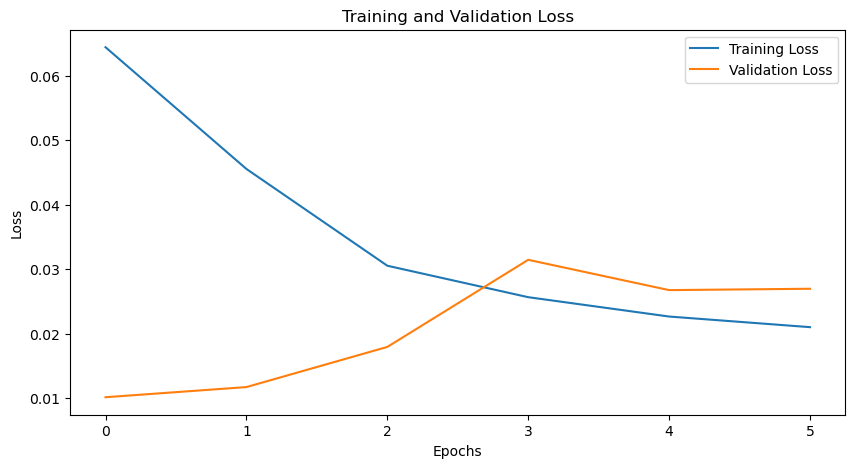

Training for permno_id: 30681
Starting Training...
Epoch 1/10, Training Loss: 0.10487946253269911, Validation Loss: 0.060348751644293465
Epoch 2/10, Training Loss: 0.04771048128604889, Validation Loss: 0.019493612150351208
Epoch 3/10, Training Loss: 0.0334491235204041, Validation Loss: 0.010558344423770905
Epoch 4/10, Training Loss: 0.027167421765625477, Validation Loss: 0.013422472712894281
Epoch 5/10, Training Loss: 0.022746903519146145, Validation Loss: 0.012306100067993006
Epoch 6/10, Training Loss: 0.020668356399983167, Validation Loss: 0.01454268799473842
Epoch 7/10, Training Loss: 0.01945156781002879, Validation Loss: 0.014746489624182383
Epoch 8/10, Training Loss: 0.018168252683244644, Validation Loss: 0.015074161812663078
Early stopping triggered.
Training Complete


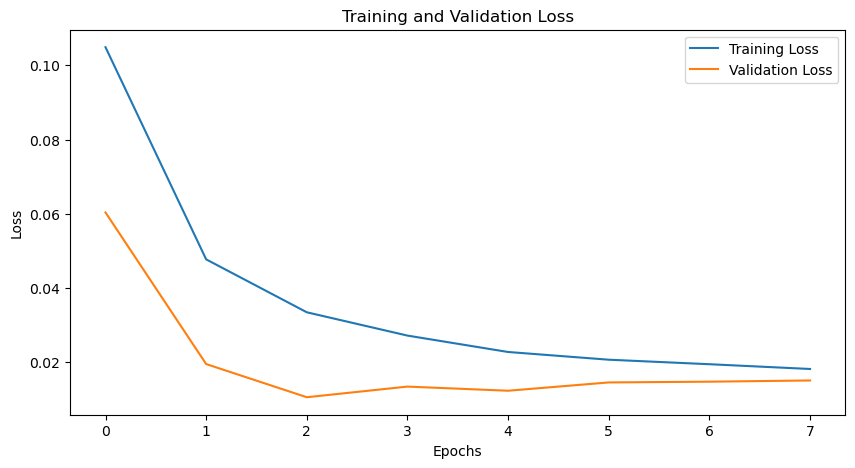

Training for permno_id: 50876
Starting Training...
Epoch 1/10, Training Loss: 0.07170588774606586, Validation Loss: 0.012971962491671244
Epoch 2/10, Training Loss: 0.04802101049572229, Validation Loss: 0.011321572897334894
Epoch 3/10, Training Loss: 0.03404190549626947, Validation Loss: 0.011036116319398085
Epoch 4/10, Training Loss: 0.02801982159726322, Validation Loss: 0.010277845896780491
Epoch 5/10, Training Loss: 0.026299203187227248, Validation Loss: 0.02370726503431797
Epoch 6/10, Training Loss: 0.022459078533574938, Validation Loss: 0.029733908052245777
Epoch 7/10, Training Loss: 0.0220136234536767, Validation Loss: 0.01662167099614938
Epoch 8/10, Training Loss: 0.02064450797624886, Validation Loss: 0.01754600430528323
Epoch 9/10, Training Loss: 0.020503970421850683, Validation Loss: 0.02092236652970314
Early stopping triggered.
Training Complete


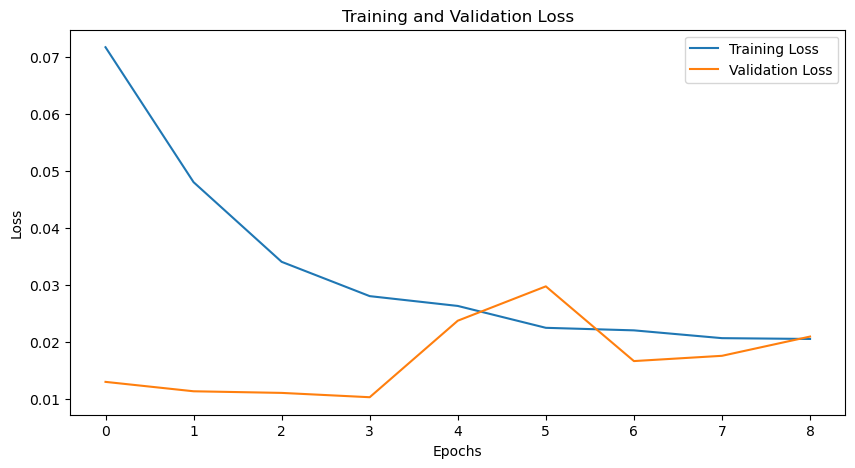

Training for permno_id: 64653
Starting Training...
Epoch 1/10, Training Loss: 0.08290859833359718, Validation Loss: 0.05053909495472908
Epoch 2/10, Training Loss: 0.041373711358755824, Validation Loss: 0.013825693167746067
Epoch 3/10, Training Loss: 0.029697316512465478, Validation Loss: 0.014564240972201029
Epoch 4/10, Training Loss: 0.02250170730985701, Validation Loss: 0.013232370217641195
Epoch 5/10, Training Loss: 0.01856724584940821, Validation Loss: 0.012286038137972355
Epoch 6/10, Training Loss: 0.016752256033942103, Validation Loss: 0.016258640835682552
Epoch 7/10, Training Loss: 0.015268004895187915, Validation Loss: 0.014997583503524462
Epoch 8/10, Training Loss: 0.014632480777800083, Validation Loss: 0.016537607337037723
Epoch 9/10, Training Loss: 0.014073748653754593, Validation Loss: 0.013210712000727654
Epoch 10/10, Training Loss: 0.013706261129118501, Validation Loss: 0.012707915467520555
Early stopping triggered.
Training Complete


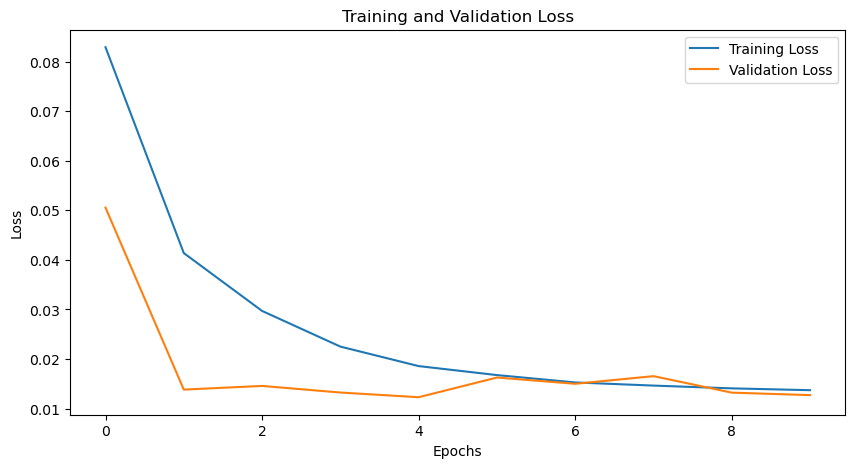

Training for permno_id: 77274
Starting Training...
Epoch 1/10, Training Loss: 0.061977474857121705, Validation Loss: 0.01800258768101533
Epoch 2/10, Training Loss: 0.04237567624077201, Validation Loss: 0.012455602797369162
Epoch 3/10, Training Loss: 0.029452946037054062, Validation Loss: 0.013376809346179167
Epoch 4/10, Training Loss: 0.02543169353157282, Validation Loss: 0.01237174030393362
Epoch 5/10, Training Loss: 0.022652975050732493, Validation Loss: 0.01629866783817609
Epoch 6/10, Training Loss: 0.020463755028322338, Validation Loss: 0.015206359947721163
Epoch 7/10, Training Loss: 0.019568155962042512, Validation Loss: 0.017541452621420223
Epoch 8/10, Training Loss: 0.018839081819169223, Validation Loss: 0.015369645009438196
Epoch 9/10, Training Loss: 0.017940353811718525, Validation Loss: 0.01577195276816686
Early stopping triggered.
Training Complete


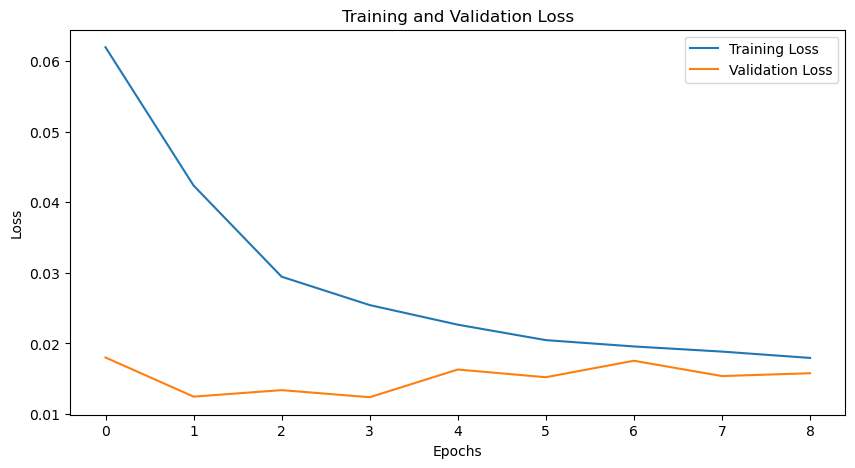

Training for permno_id: 81774
Starting Training...
Epoch 1/10, Training Loss: 0.07019292581826449, Validation Loss: 0.013119917983810106
Epoch 2/10, Training Loss: 0.05144076580181718, Validation Loss: 0.015259909133116404
Epoch 3/10, Training Loss: 0.038798725698143244, Validation Loss: 0.010194369281331698
Epoch 4/10, Training Loss: 0.03230412439443171, Validation Loss: 0.010454396406809488
Epoch 5/10, Training Loss: 0.030842590145766735, Validation Loss: 0.011505004639426867
Epoch 6/10, Training Loss: 0.029230760829523205, Validation Loss: 0.010067667191227278
Epoch 7/10, Training Loss: 0.02807304044254124, Validation Loss: 0.01009898322323958
Epoch 8/10, Training Loss: 0.02744617573916912, Validation Loss: 0.010417378197113672
Epoch 9/10, Training Loss: 0.02746910071000457, Validation Loss: 0.010103676157693068
Epoch 10/10, Training Loss: 0.026871759491041303, Validation Loss: 0.010116154638429483
Training Complete


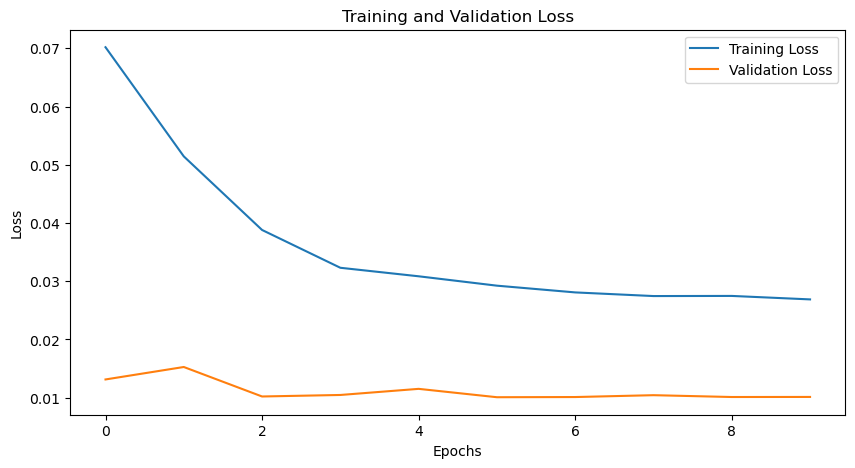

Training for permno_id: 86745
Starting Training...
Epoch 1/10, Training Loss: 0.06913154926151037, Validation Loss: 0.012474960337082544
Epoch 2/10, Training Loss: 0.05157839506864548, Validation Loss: 0.02613759972155094
Epoch 3/10, Training Loss: 0.04062645467929542, Validation Loss: 0.018473477413256962
Epoch 4/10, Training Loss: 0.03525257888250053, Validation Loss: 0.021062611291805904
Epoch 5/10, Training Loss: 0.03182144379243255, Validation Loss: 0.023165386791030567
Epoch 6/10, Training Loss: 0.030460943328216673, Validation Loss: 0.022699165468414623
Early stopping triggered.
Training Complete


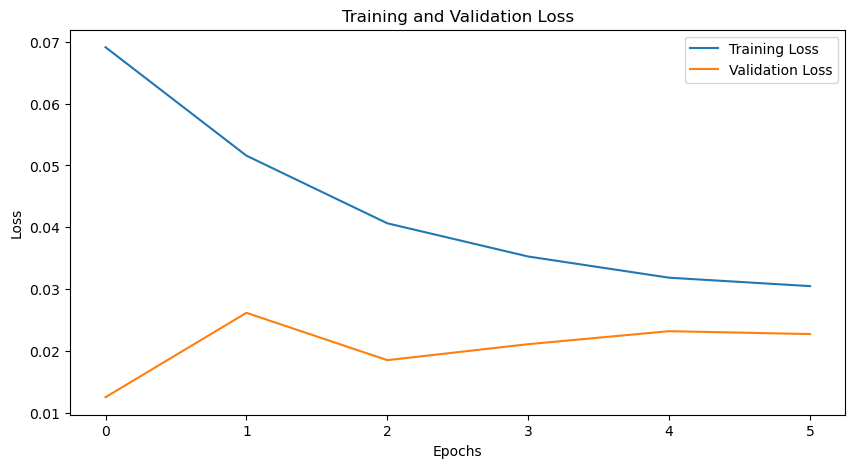

Training for permno_id: 89866
Starting Training...
Epoch 1/10, Training Loss: 0.10948785059154034, Validation Loss: 0.045333340764045715
Epoch 2/10, Training Loss: 0.0605158650316298, Validation Loss: 0.027993798876802128
Epoch 3/10, Training Loss: 0.04473993992432952, Validation Loss: 0.014918140756587187
Epoch 4/10, Training Loss: 0.03301586522720754, Validation Loss: 0.012216855150957903
Epoch 5/10, Training Loss: 0.027886717393994332, Validation Loss: 0.010464358143508434
Epoch 6/10, Training Loss: 0.02564586400985718, Validation Loss: 0.012702605066200098
Epoch 7/10, Training Loss: 0.024308052379637957, Validation Loss: 0.01416295456389586
Epoch 8/10, Training Loss: 0.023546746373176573, Validation Loss: 0.01724022999405861
Epoch 9/10, Training Loss: 0.022523969411849976, Validation Loss: 0.01906501315534115
Epoch 10/10, Training Loss: 0.022305711056105793, Validation Loss: 0.021515866741538048
Early stopping triggered.
Training Complete


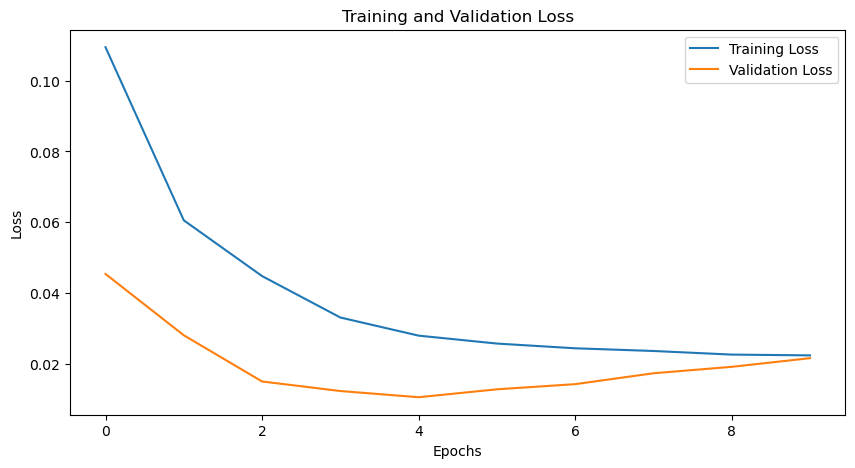

Training for permno_id: 93246
Starting Training...
Epoch 1/10, Training Loss: 0.08611064879223704, Validation Loss: 0.024120525146524113
Epoch 2/10, Training Loss: 0.04850685810670256, Validation Loss: 0.010526841195921103
Epoch 3/10, Training Loss: 0.03917773496359587, Validation Loss: 0.01271063182502985
Epoch 4/10, Training Loss: 0.0323139572981745, Validation Loss: 0.011793699425955614
Epoch 5/10, Training Loss: 0.029951115930452944, Validation Loss: 0.01027766428887844
Epoch 6/10, Training Loss: 0.027509719831869006, Validation Loss: 0.010371977152923742
Epoch 7/10, Training Loss: 0.026292541017755865, Validation Loss: 0.01060497605552276
Epoch 8/10, Training Loss: 0.02511417306959629, Validation Loss: 0.011803270317614079
Epoch 9/10, Training Loss: 0.024467081925831736, Validation Loss: 0.0110056030874451
Epoch 10/10, Training Loss: 0.024309387570247053, Validation Loss: 0.010994724308451017
Early stopping triggered.
Training Complete


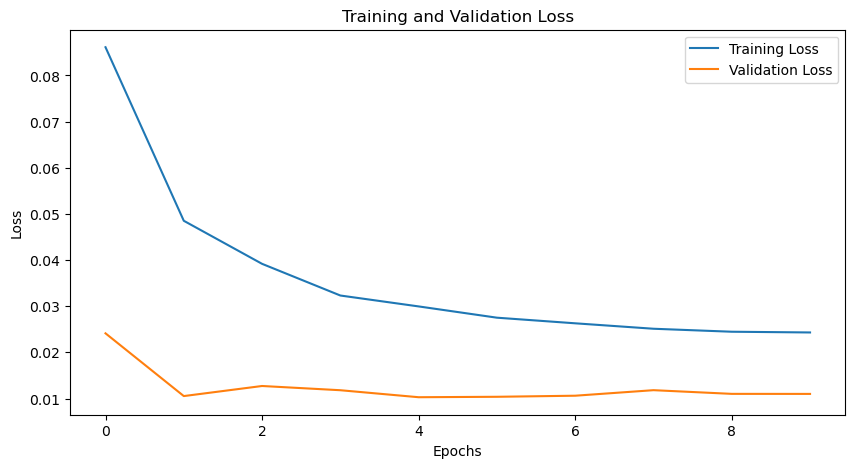

In [79]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Iterate over each unique permno_id in the dataset
unique_permno_ids = train_data["permno_id"].unique()
stock_embeddings = {}

for permno_id in unique_permno_ids[::50]:
    # set_seed(0)  # Set seed for reproducibility
    print(f"Training for permno_id: {permno_id}")

    # Prepare Data
    # dataset = FinancialDataset(first_month_data[:1000])
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
    val_dataset = FinancialDataset(validation_data[:100])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize Model
    model = TransformerModel(
        input_dim=7 * 5 + 1,
        embed_dim=256,
        n_heads=16,
        ff_dim=1024,
        n_layers=6,
        output_dim=len(train_dataset.target_columns),
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training Loop
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
    criterion = nn.L1Loss()

    # for epoch in range(5):
    #     for batch in dataloader:
    #         optimizer.zero_grad()
    #         output, _ = model(batch["features"])
    #         loss = criterion(output, batch["target"])
    #         # print(f'loss: {loss}')
    #         loss.backward()
    #         optimizer.step()

    # print("Training Complete")

    train_losses = []
    val_losses = []

    num_epochs = 10
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    print("Starting Training...")
    # num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            # print(f'loss: {loss}')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                output, _ = model(batch["features"].to(device))
                loss = criterion(output, batch["target"].to(device))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training Complete")

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Extract embeddings for each stock
    model.eval()
    with torch.no_grad():
        permno_embeddings = []
        for batch in train_dataloader:
            _, embeddings = model(batch["features"].to(device))
            permno_embeddings.extend(embeddings.cpu().numpy())

        # Average the embeddings for this permno_id
        stock_embeddings[permno_id] = np.mean(permno_embeddings, axis=0)

    # Extract embeddings for each stock
    # stock_embeddings = {}
    # model.eval()
    # with torch.no_grad():
    #     for batch in train_dataloader:
    #         _, embeddings = model(batch["features"].to(device))
    #         for i, permno_id in enumerate(batch["permno_id"]):
    #             if permno_id not in stock_embeddings:
    #                 stock_embeddings[permno_id] = []
    #             stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

    # # Average the embeddings for each stock
    # for permno_id in stock_embeddings:
    #     stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [80]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-4.5075327e-01, -1.6329819e+00,  4.4633138e-01,  8.9547610e-01,
         -1.0751376e+00,  1.7441547e+00,  1.0612292e+00, -1.0970510e+00,
          1.3397825e+00,  5.2166957e-01,  1.6040960e-01, -1.0673970e+00,
          3.2668123e-01,  8.8922644e-01, -1.9268823e-01,  9.9592388e-01,
         -2.4469688e+00, -1.9151514e+00, -1.5640529e+00,  7.5553477e-02,
          1.4685331e-01,  9.2080140e-01, -8.3247848e-02, -1.0418354e+00,
         -5.0397456e-01,  3.1839412e-01,  5.7441849e-01,  1.1790838e+00,
         -9.4255185e-01, -7.9650903e-01,  9.3809718e-01,  3.5750639e-01,
          2.2065447e-01,  8.5434742e-02, -2.5577021e+00, -5.7753164e-01,
          5.7946658e-01, -1.1520679e+00,  8.8254172e-01, -6.4085472e-01,
         -1.4537810e+00, -9.9113566e-01,  9.0549576e-01,  5.4096812e-01,
         -4.1807702e-01,  8.8205755e-01, -2.6778540e-01, -4.8565766e-01,
         -1.2223500e+00,  9.7405237e-01, -3.0557433e-01,  5.5371457e-01,
          3.8505441e-01, -1.2401755e+00,

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[ 9.99999583e-01, -7.60176256e-02, -2.07483117e-02,
        -6.39609843e-02, -4.73640263e-02,  1.85949448e-02,
        -2.10610200e-02,  2.62062475e-02,  1.17528528e-01,
         4.04227804e-03,  1.47074992e-02,  5.64832091e-02],
       [-7.60176256e-02,  9.99999762e-01,  5.19680828e-02,
         2.21818294e-02, -4.79475735e-03,  5.51674739e-02,
         4.41558361e-02,  5.50115407e-02,  9.30412859e-02,
        -8.75809789e-03, -2.06527319e-02, -3.35739702e-02],
       [-2.07483117e-02,  5.19680828e-02,  1.00000024e+00,
         1.05731681e-01, -2.64260190e-04,  2.57441141e-02,
        -1.08026065e-01,  6.41124398e-02, -5.96220456e-02,
        -1.22677963e-02,  5.46286888e-02, -2.32669641e-03],
       [-6.39609843e-02,  2.21818294e-02,  1.05731681e-01,
         9.99999940e-01, -3.14575098e-02, -2.67864689e-02,
         1.85993146e-02, -1.66536748e-01, -3.78551520e-02,
        -3.45967561e-02, -1.43691702e-02, -3.09675205e-02],
       [-4.73640263e-02, -4.79475735e-03, -2.6426019

### Case 4: Past 7 days 5 feautures 11 targets

Training for permno_id: 10104
Starting Training...
Epoch 1/10, Training Loss: 0.13382615335285664, Validation Loss: 0.06048199161887169
Epoch 2/10, Training Loss: 0.1021446418017149, Validation Loss: 0.05285828063885371
Epoch 3/10, Training Loss: 0.09092386187985539, Validation Loss: 0.05305774758259455
Epoch 4/10, Training Loss: 0.08606571583077312, Validation Loss: 0.05350874736905098
Epoch 5/10, Training Loss: 0.0835659091360867, Validation Loss: 0.05386488139629364
Epoch 6/10, Training Loss: 0.08134056087583304, Validation Loss: 0.052990992863972984
Epoch 7/10, Training Loss: 0.08094514477998019, Validation Loss: 0.052174828946590424
Epoch 8/10, Training Loss: 0.07932431846857071, Validation Loss: 0.050854562471310295
Epoch 9/10, Training Loss: 0.07860751366242766, Validation Loss: 0.051774157832066216
Epoch 10/10, Training Loss: 0.07817707750946283, Validation Loss: 0.05066271250446638
Training Complete


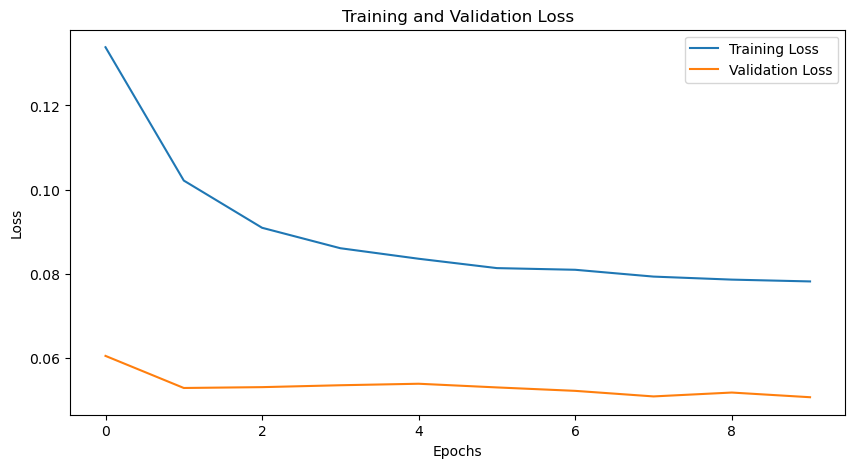

Training for permno_id: 13688
Starting Training...
Epoch 1/10, Training Loss: 0.28377025108784437, Validation Loss: 0.06478491798043251
Epoch 2/10, Training Loss: 0.23830184135586024, Validation Loss: 0.0758462759355704
Epoch 3/10, Training Loss: 0.22916020788252353, Validation Loss: 0.07726227988799413
Epoch 4/10, Training Loss: 0.2263573193922639, Validation Loss: 0.07449277242024739
Epoch 5/10, Training Loss: 0.2253849681466818, Validation Loss: 0.07323216646909714
Epoch 6/10, Training Loss: 0.22301923036575316, Validation Loss: 0.07132575164238612
Early stopping triggered.
Training Complete


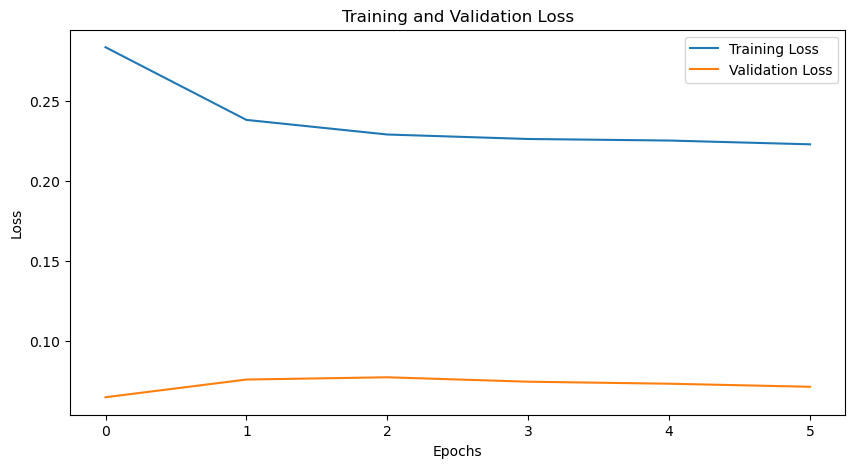

Training for permno_id: 17005
Starting Training...
Epoch 1/10, Training Loss: 0.17631037309765815, Validation Loss: 0.08794175585110982
Epoch 2/10, Training Loss: 0.1221549091860652, Validation Loss: 0.05509009460608164
Epoch 3/10, Training Loss: 0.09950417093932629, Validation Loss: 0.05130183324217796
Epoch 4/10, Training Loss: 0.09115821970626711, Validation Loss: 0.052129244431853294
Epoch 5/10, Training Loss: 0.08715963242575527, Validation Loss: 0.052142128348350525
Epoch 6/10, Training Loss: 0.08418386690318584, Validation Loss: 0.05258593522012234
Epoch 7/10, Training Loss: 0.08333423361182213, Validation Loss: 0.05263257337113222
Epoch 8/10, Training Loss: 0.08179529774934054, Validation Loss: 0.05231360159814358
Early stopping triggered.
Training Complete


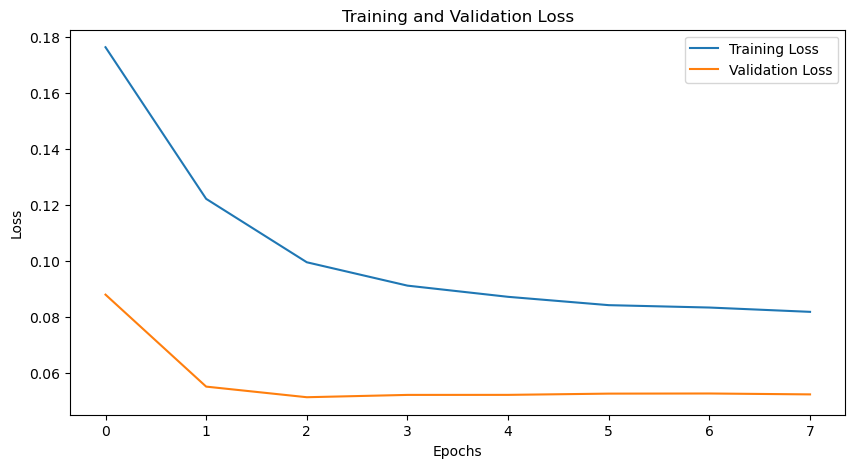

Training for permno_id: 21936
Starting Training...
Epoch 1/10, Training Loss: 0.1333080168813467, Validation Loss: 0.073082584887743
Epoch 2/10, Training Loss: 0.10663870330899954, Validation Loss: 0.06150318682193756
Epoch 3/10, Training Loss: 0.09698364231735468, Validation Loss: 0.05845617006222407
Epoch 4/10, Training Loss: 0.09042669823393226, Validation Loss: 0.05768049011627833
Epoch 5/10, Training Loss: 0.0879928688518703, Validation Loss: 0.05660031611720721
Epoch 6/10, Training Loss: 0.0863726545125246, Validation Loss: 0.05520558481415113
Epoch 7/10, Training Loss: 0.08492770446464419, Validation Loss: 0.053541681418816246
Epoch 8/10, Training Loss: 0.08442290732637048, Validation Loss: 0.05224560697873434
Epoch 9/10, Training Loss: 0.08171079764142633, Validation Loss: 0.05221740901470184
Epoch 10/10, Training Loss: 0.08235042337328195, Validation Loss: 0.05237302929162979
Training Complete


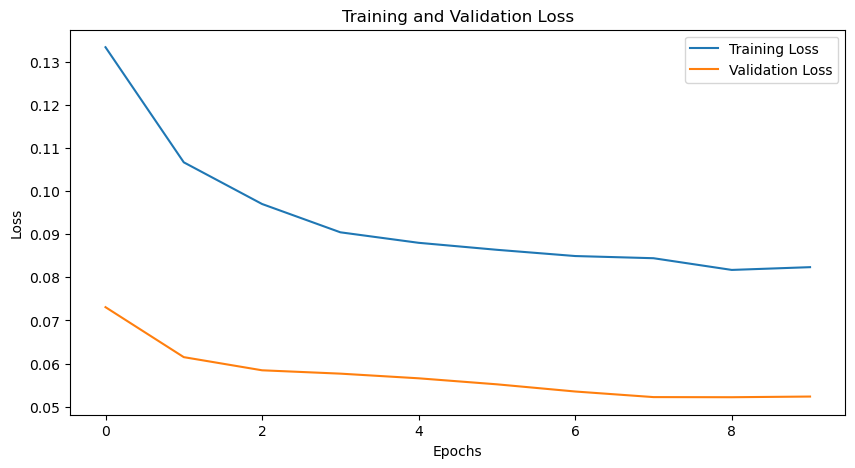

Training for permno_id: 30681
Starting Training...
Epoch 1/10, Training Loss: 0.16509362626820803, Validation Loss: 0.08487901588280995
Epoch 2/10, Training Loss: 0.10660240147262812, Validation Loss: 0.055585432797670364
Epoch 3/10, Training Loss: 0.09462710749357939, Validation Loss: 0.05401683102051417
Epoch 4/10, Training Loss: 0.09125627856701612, Validation Loss: 0.05388987064361572
Epoch 5/10, Training Loss: 0.08958223424851894, Validation Loss: 0.05486909424265226
Epoch 6/10, Training Loss: 0.08860724428668618, Validation Loss: 0.05419931809107462
Epoch 7/10, Training Loss: 0.08816910861060023, Validation Loss: 0.05297801146904627
Epoch 8/10, Training Loss: 0.08770522261038423, Validation Loss: 0.05221641001602014
Epoch 9/10, Training Loss: 0.08599572880193591, Validation Loss: 0.05279243613282839
Epoch 10/10, Training Loss: 0.08594595929607748, Validation Loss: 0.05262527118126551
Training Complete


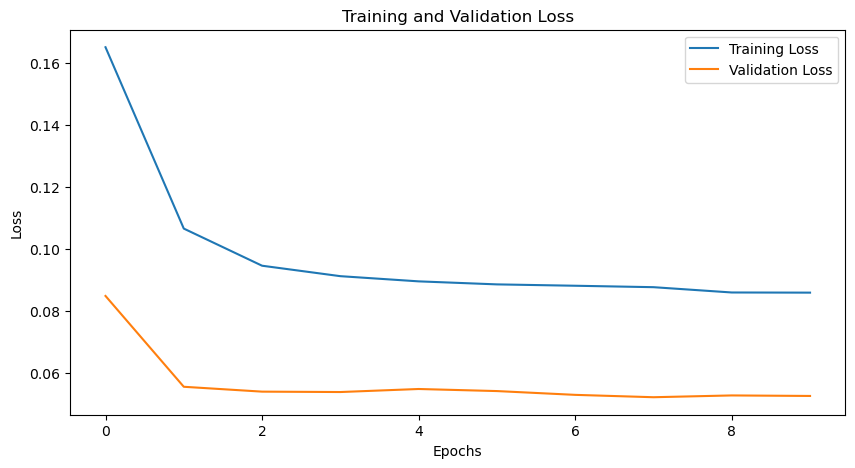

Training for permno_id: 50876
Starting Training...
Epoch 1/10, Training Loss: 0.17321795038878918, Validation Loss: 0.0822414147357146
Epoch 2/10, Training Loss: 0.10870863515883684, Validation Loss: 0.05401130144794782
Epoch 3/10, Training Loss: 0.09626193605363369, Validation Loss: 0.053105451787511505
Epoch 4/10, Training Loss: 0.09515573112294078, Validation Loss: 0.05113147385418415
Epoch 5/10, Training Loss: 0.09313292307779193, Validation Loss: 0.0518722248574098
Epoch 6/10, Training Loss: 0.0904671536758542, Validation Loss: 0.050795733307798706
Epoch 7/10, Training Loss: 0.08868366284295917, Validation Loss: 0.05185725043217341
Epoch 8/10, Training Loss: 0.08815918797627091, Validation Loss: 0.0514577254652977
Epoch 9/10, Training Loss: 0.08653120016679168, Validation Loss: 0.052055412282546364
Epoch 10/10, Training Loss: 0.0861664853990078, Validation Loss: 0.05234551429748535
Training Complete


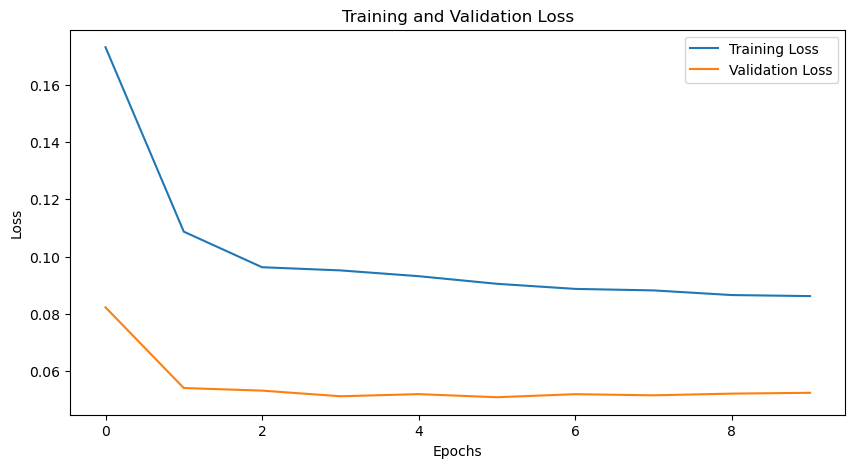

Training for permno_id: 64653
Starting Training...
Epoch 1/10, Training Loss: 0.14851448144763707, Validation Loss: 0.08413524180650711
Epoch 2/10, Training Loss: 0.09635117622092366, Validation Loss: 0.05852703129251798
Epoch 3/10, Training Loss: 0.07833856847137213, Validation Loss: 0.054069788505633674
Epoch 4/10, Training Loss: 0.07365340813994407, Validation Loss: 0.05324274984498819
Epoch 5/10, Training Loss: 0.07074230145663023, Validation Loss: 0.053967746595541634
Epoch 6/10, Training Loss: 0.06966830370947719, Validation Loss: 0.05356855317950249
Epoch 7/10, Training Loss: 0.06918815979734064, Validation Loss: 0.05263871078689893
Epoch 8/10, Training Loss: 0.06854886664077639, Validation Loss: 0.05257213736573855
Epoch 9/10, Training Loss: 0.06813152553513646, Validation Loss: 0.05234013559917609
Epoch 10/10, Training Loss: 0.06787779815495014, Validation Loss: 0.05306587119897207
Training Complete


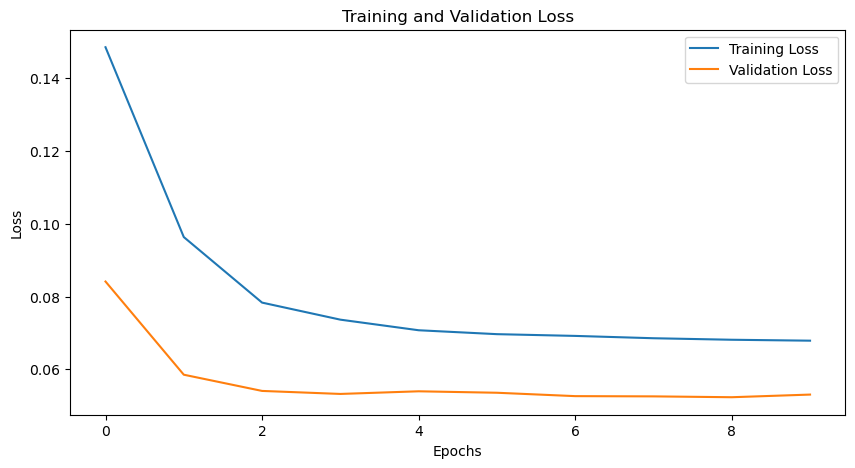

Training for permno_id: 77274
Starting Training...
Epoch 1/10, Training Loss: 0.12664221227169037, Validation Loss: 0.06743356833855312
Epoch 2/10, Training Loss: 0.08648945139721036, Validation Loss: 0.05478019267320633
Epoch 3/10, Training Loss: 0.07808787124231457, Validation Loss: 0.054520983869830765
Epoch 4/10, Training Loss: 0.07577738016843796, Validation Loss: 0.056135471910238266
Epoch 5/10, Training Loss: 0.0739307609386742, Validation Loss: 0.054595102866490684
Epoch 6/10, Training Loss: 0.07247533751651644, Validation Loss: 0.055159046004215874
Epoch 7/10, Training Loss: 0.07123524956405163, Validation Loss: 0.05519862100481987
Epoch 8/10, Training Loss: 0.07005805177614093, Validation Loss: 0.055057426914572716
Early stopping triggered.
Training Complete


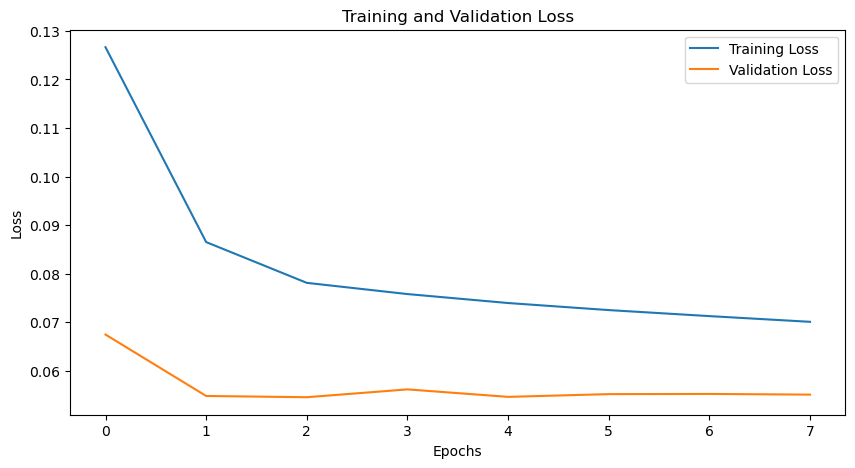

Training for permno_id: 81774
Starting Training...
Epoch 1/10, Training Loss: 0.25793696083128453, Validation Loss: 0.07242207104961078
Epoch 2/10, Training Loss: 0.19823629446327687, Validation Loss: 0.0762410859266917
Epoch 3/10, Training Loss: 0.16662817727774382, Validation Loss: 0.10325814286867778
Epoch 4/10, Training Loss: 0.16055989507585763, Validation Loss: 0.10690294454495113
Epoch 5/10, Training Loss: 0.15771554186940193, Validation Loss: 0.11220553517341614
Epoch 6/10, Training Loss: 0.15571031216531991, Validation Loss: 0.11088098833958308
Early stopping triggered.
Training Complete


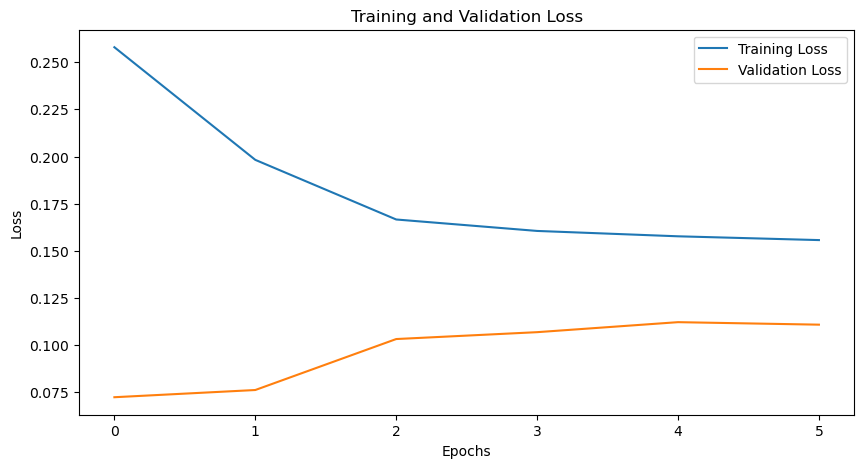

Training for permno_id: 86745
Starting Training...
Epoch 1/10, Training Loss: 0.3236644580960274, Validation Loss: 0.08679954210917155
Epoch 2/10, Training Loss: 0.2684817459434271, Validation Loss: 0.09130662182966869
Epoch 3/10, Training Loss: 0.24869245309382676, Validation Loss: 0.10438643644253413
Epoch 4/10, Training Loss: 0.24295864589512348, Validation Loss: 0.1120913028717041
Epoch 5/10, Training Loss: 0.2412881450727582, Validation Loss: 0.10920707633097966
Epoch 6/10, Training Loss: 0.2366472862660885, Validation Loss: 0.10905618717273076
Early stopping triggered.
Training Complete


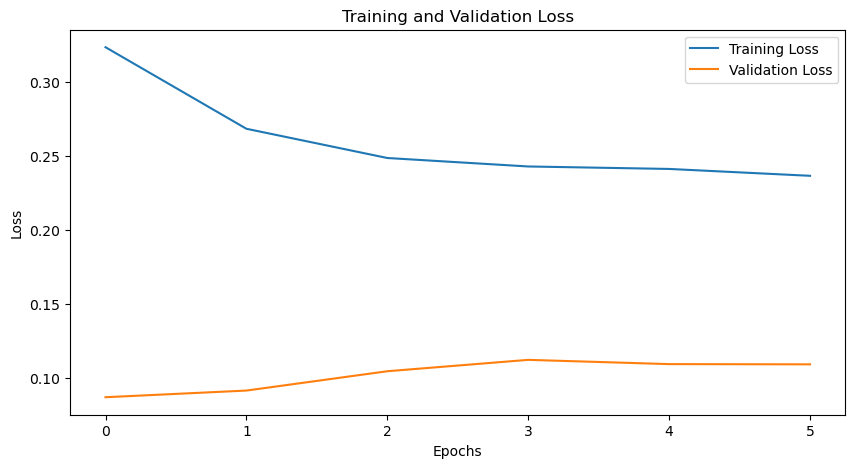

Training for permno_id: 89866
Starting Training...
Epoch 1/10, Training Loss: 0.18020486794412136, Validation Loss: 0.0865403339266777
Epoch 2/10, Training Loss: 0.13709567338228226, Validation Loss: 0.056718396643797554
Epoch 3/10, Training Loss: 0.12237693145871162, Validation Loss: 0.052947127570708595
Epoch 4/10, Training Loss: 0.11731314435601234, Validation Loss: 0.052793851122260094
Epoch 5/10, Training Loss: 0.11368330447003246, Validation Loss: 0.054354788114627205
Epoch 6/10, Training Loss: 0.11145574189722537, Validation Loss: 0.0555432066321373
Epoch 7/10, Training Loss: 0.10881385505199433, Validation Loss: 0.05314562718073527
Epoch 8/10, Training Loss: 0.10912948045879603, Validation Loss: 0.05495650445421537
Epoch 9/10, Training Loss: 0.10747410785406827, Validation Loss: 0.055549509823322296
Early stopping triggered.
Training Complete


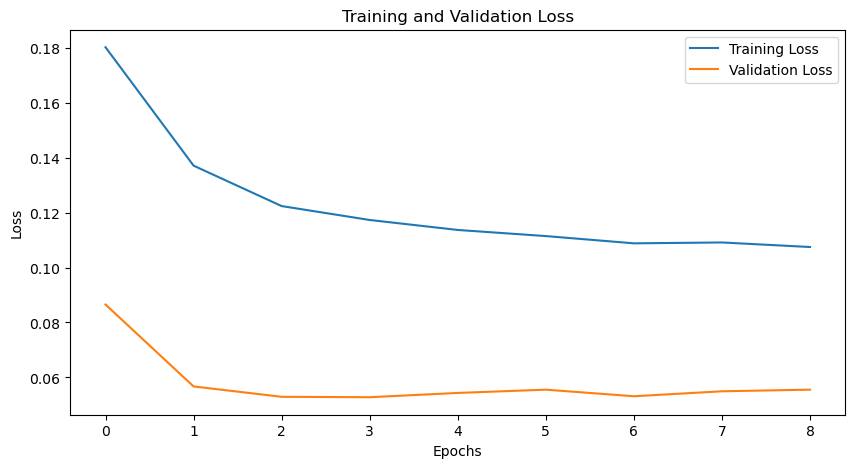

Training for permno_id: 93246
Starting Training...
Epoch 1/10, Training Loss: 0.25089781582355497, Validation Loss: 0.091510775188605
Epoch 2/10, Training Loss: 0.17606171686202288, Validation Loss: 0.08716496576865514
Epoch 3/10, Training Loss: 0.16094083916395902, Validation Loss: 0.09278493126233418
Epoch 4/10, Training Loss: 0.15396420359611512, Validation Loss: 0.09302750726540883
Epoch 5/10, Training Loss: 0.15189118925482034, Validation Loss: 0.08644237617651622
Epoch 6/10, Training Loss: 0.14849749244749547, Validation Loss: 0.08463955173889796
Epoch 7/10, Training Loss: 0.14600610826164484, Validation Loss: 0.08701573063929875
Epoch 8/10, Training Loss: 0.1467883612960577, Validation Loss: 0.08475648860136668
Epoch 9/10, Training Loss: 0.14417795557528734, Validation Loss: 0.08223239580790202
Epoch 10/10, Training Loss: 0.14424426462501289, Validation Loss: 0.08259697258472443
Training Complete


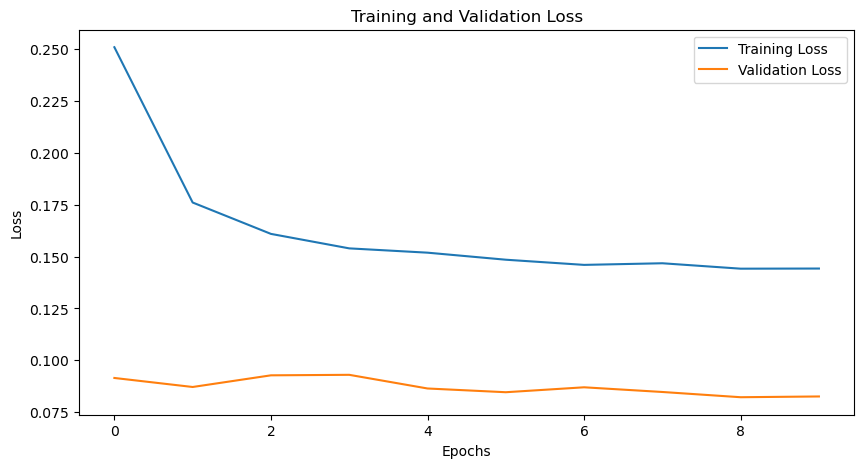

In [84]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Iterate over each unique permno_id in the dataset
unique_permno_ids = train_data["permno_id"].unique()
stock_embeddings = {}

for permno_id in unique_permno_ids[::50]:
    # set_seed(0)  # Set seed for reproducibility
    print(f"Training for permno_id: {permno_id}")

    # Prepare Data
    # dataset = FinancialDataset(first_month_data[:1000])
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
    val_dataset = FinancialDataset(validation_data[:100])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize Model
    model = TransformerModel(
        input_dim=7 * 5 + 1,
        embed_dim=256,
        n_heads=16,
        ff_dim=1024,
        n_layers=6,
        output_dim=len(train_dataset.target_columns),
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training Loop
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
    criterion = nn.L1Loss()

    # for epoch in range(5):
    #     for batch in dataloader:
    #         optimizer.zero_grad()
    #         output, _ = model(batch["features"])
    #         loss = criterion(output, batch["target"])
    #         # print(f'loss: {loss}')
    #         loss.backward()
    #         optimizer.step()

    # print("Training Complete")

    train_losses = []
    val_losses = []

    num_epochs = 10
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    print("Starting Training...")
    # num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            # print(f'loss: {loss}')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                output, _ = model(batch["features"].to(device))
                loss = criterion(output, batch["target"].to(device))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training Complete")

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Extract embeddings for each stock
    model.eval()
    with torch.no_grad():
        permno_embeddings = []
        for batch in train_dataloader:
            _, embeddings = model(batch["features"].to(device))
            permno_embeddings.extend(embeddings.cpu().numpy())

        # Average the embeddings for this permno_id
        stock_embeddings[permno_id] = np.mean(permno_embeddings, axis=0)

    # Extract embeddings for each stock
    # stock_embeddings = {}
    # model.eval()
    # with torch.no_grad():
    #     for batch in train_dataloader:
    #         _, embeddings = model(batch["features"].to(device))
    #         for i, permno_id in enumerate(batch["permno_id"]):
    #             if permno_id not in stock_embeddings:
    #                 stock_embeddings[permno_id] = []
    #             stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

    # # Average the embeddings for each stock
    # for permno_id in stock_embeddings:
    #     stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [85]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 1.3147380e+00,  3.2025599e+00,  4.2801436e-02,  1.9423771e-01,
          6.8979228e-01, -2.6049721e-01, -8.4166789e-01,  1.6409179e+00,
          7.0114595e-01, -1.0027776e+00, -3.0160624e-01,  7.4252778e-01,
          7.8021240e-01, -8.3355255e-02, -9.8153102e-01,  1.0705265e+00,
         -1.9181041e+00, -1.2309398e-01,  1.9685337e-01,  2.5875282e-01,
          2.5178891e-01,  4.9427173e-01,  2.0327151e+00,  6.1445832e-01,
         -6.6407394e-01,  6.1452353e-01, -4.3257058e-01,  1.3798586e+00,
          6.6312057e-01,  3.5208493e-01,  2.1622229e+00, -1.5074139e+00,
         -8.4433287e-01,  2.6999891e-01, -1.8845090e+00,  2.4829285e-01,
         -1.6231831e+00, -2.5819284e-01,  1.0957656e+00, -1.1665098e-01,
         -1.6765361e-01, -2.8814378e-01,  5.6425166e-01, -3.1579179e-01,
          5.1663756e-01, -5.1349384e-01,  8.2945812e-01, -3.4161049e-01,
          1.8817568e+00,  2.4421489e+00,  4.6999928e-01, -4.6210325e-01,
          3.1265175e-01,  7.1551234e-01,

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[ 1.00000012e+00,  3.95085178e-02, -1.01893127e-01,
         7.12286821e-03,  5.69280200e-02,  1.47169651e-02,
         6.52396157e-02,  7.59315351e-03,  3.57969245e-03,
         6.93833604e-02, -4.43380326e-04,  7.26922823e-04],
       [ 3.95085178e-02,  9.99999702e-01, -1.01719297e-01,
        -9.01185498e-02, -1.58736035e-02,  2.79799867e-02,
         1.32194668e-01,  3.94403823e-02,  5.71340881e-02,
         1.00240996e-02, -3.70008312e-02, -7.92554487e-03],
       [-1.01893127e-01, -1.01719297e-01,  1.00000024e+00,
         1.21510066e-02,  8.14521238e-02, -5.36189675e-02,
        -2.09234525e-02, -1.23122118e-01, -9.40920562e-02,
         8.19440000e-03, -2.01994777e-02, -6.73283041e-02],
       [ 7.12286821e-03, -9.01185498e-02,  1.21510066e-02,
         9.99999940e-01, -1.03936307e-01, -2.02763155e-02,
         6.11488931e-02, -9.82029829e-03,  1.01380095e-01,
        -1.01573355e-02,  1.21815717e-02,  8.49625990e-02],
       [ 5.69280200e-02, -1.58736035e-02,  8.1452123

### Case 5: Past 128 days 1 feauture 1 target

Training for permno_id: 10104
Starting Training...
Epoch 1/10, Training Loss: 0.12126949025938909, Validation Loss: 0.04157455855359634
Epoch 2/10, Training Loss: 0.04813191765505406, Validation Loss: 0.012217932924007377
Epoch 3/10, Training Loss: 0.035081233001417585, Validation Loss: 0.01274697893920044
Epoch 4/10, Training Loss: 0.028067412993146315, Validation Loss: 0.014682269732778272
Epoch 5/10, Training Loss: 0.023900754594554503, Validation Loss: 0.014746340224519372
Epoch 6/10, Training Loss: 0.0213709930734088, Validation Loss: 0.015163241342330972
Epoch 7/10, Training Loss: 0.020055187271080084, Validation Loss: 0.01475970974812905
Early stopping triggered.
Training Complete


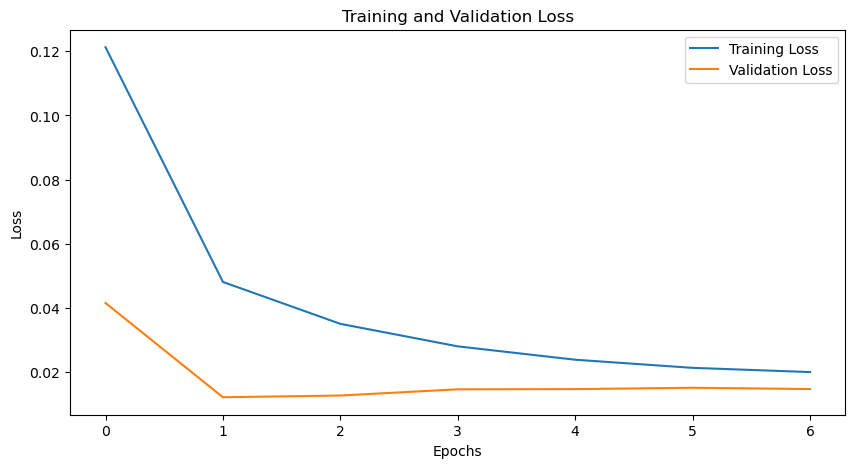

Training for permno_id: 13688
Starting Training...
Epoch 1/10, Training Loss: 0.0774055477231741, Validation Loss: 0.011605476262047887
Epoch 2/10, Training Loss: 0.05731805294959082, Validation Loss: 0.012808801606297493
Epoch 3/10, Training Loss: 0.04717255782129036, Validation Loss: 0.02530264590556423
Epoch 4/10, Training Loss: 0.04112759382567472, Validation Loss: 0.013526953058317304
Epoch 5/10, Training Loss: 0.0374125270690355, Validation Loss: 0.011941132756570974
Epoch 6/10, Training Loss: 0.034816180924988456, Validation Loss: 0.015495135060821971
Early stopping triggered.
Training Complete


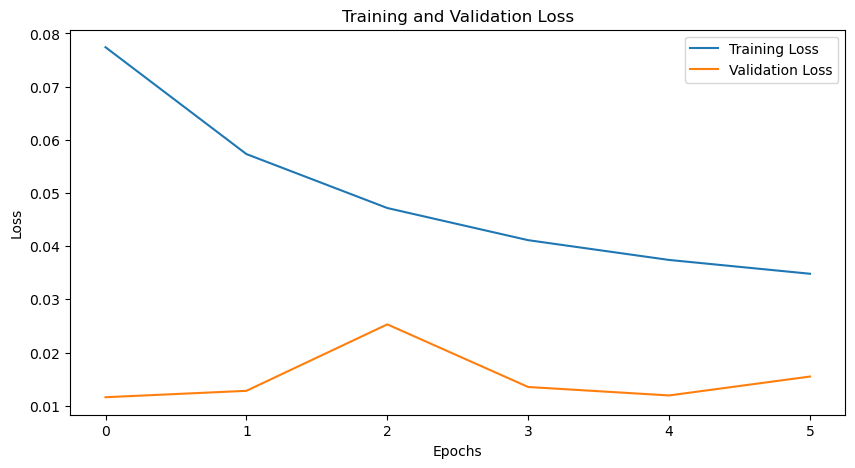

Training for permno_id: 17005
Starting Training...
Epoch 1/10, Training Loss: 0.07051059955524074, Validation Loss: 0.014321775020410618
Epoch 2/10, Training Loss: 0.04788054075712959, Validation Loss: 0.014839983157192668
Epoch 3/10, Training Loss: 0.03325227591105633, Validation Loss: 0.011795481240066389
Epoch 4/10, Training Loss: 0.02519913048793872, Validation Loss: 0.012033457091699043
Epoch 5/10, Training Loss: 0.021529971414970026, Validation Loss: 0.011679687226812044
Epoch 6/10, Training Loss: 0.019189159877391324, Validation Loss: 0.013957357577358684
Epoch 7/10, Training Loss: 0.01811747273637189, Validation Loss: 0.014828430643926064
Epoch 8/10, Training Loss: 0.017298762971121404, Validation Loss: 0.014023939380422235
Epoch 9/10, Training Loss: 0.01719183474779129, Validation Loss: 0.013177980746453008
Epoch 10/10, Training Loss: 0.016931872789023653, Validation Loss: 0.01220100411834816
Early stopping triggered.
Training Complete


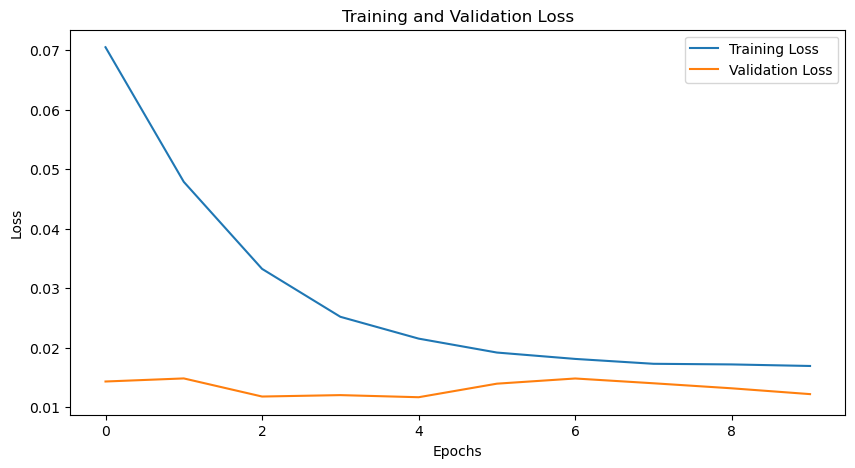

Training for permno_id: 21936
Starting Training...
Epoch 1/10, Training Loss: 0.07374598924070597, Validation Loss: 0.020154078025370836
Epoch 2/10, Training Loss: 0.05138305243518618, Validation Loss: 0.012846274689460794
Epoch 3/10, Training Loss: 0.03852210111088223, Validation Loss: 0.013100892615815004
Epoch 4/10, Training Loss: 0.03081698834689127, Validation Loss: 0.015715449970836442
Epoch 5/10, Training Loss: 0.023744333018031385, Validation Loss: 0.011758223486443361
Epoch 6/10, Training Loss: 0.020991413284920983, Validation Loss: 0.011563098834206661
Epoch 7/10, Training Loss: 0.018579192666543856, Validation Loss: 0.01158658997155726
Epoch 8/10, Training Loss: 0.01723726753455897, Validation Loss: 0.011304880725219846
Epoch 9/10, Training Loss: 0.016423850165059168, Validation Loss: 0.011272899340838194
Epoch 10/10, Training Loss: 0.01594580681477156, Validation Loss: 0.011363714467734098
Training Complete


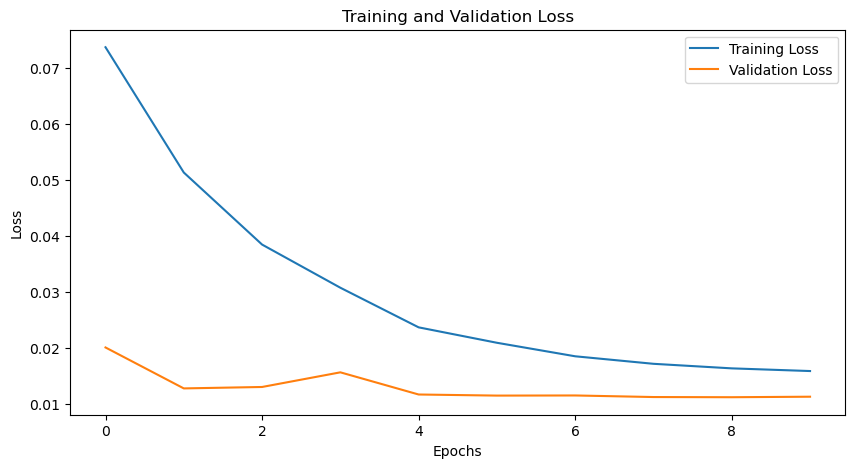

Training for permno_id: 30681
Starting Training...
Epoch 1/10, Training Loss: 0.06551895497573747, Validation Loss: 0.0128737004318585
Epoch 2/10, Training Loss: 0.047007812911437616, Validation Loss: 0.02017728053033352
Epoch 3/10, Training Loss: 0.035006329158527985, Validation Loss: 0.011310765209297339
Epoch 4/10, Training Loss: 0.0281219059187505, Validation Loss: 0.01649279713941117
Epoch 5/10, Training Loss: 0.025452212016615603, Validation Loss: 0.020765978066871565
Epoch 6/10, Training Loss: 0.02272636665859156, Validation Loss: 0.02259051116804282
Epoch 7/10, Training Loss: 0.02144316356215212, Validation Loss: 0.02257325251897176
Epoch 8/10, Training Loss: 0.020951408789389663, Validation Loss: 0.017685607075691223
Early stopping triggered.
Training Complete


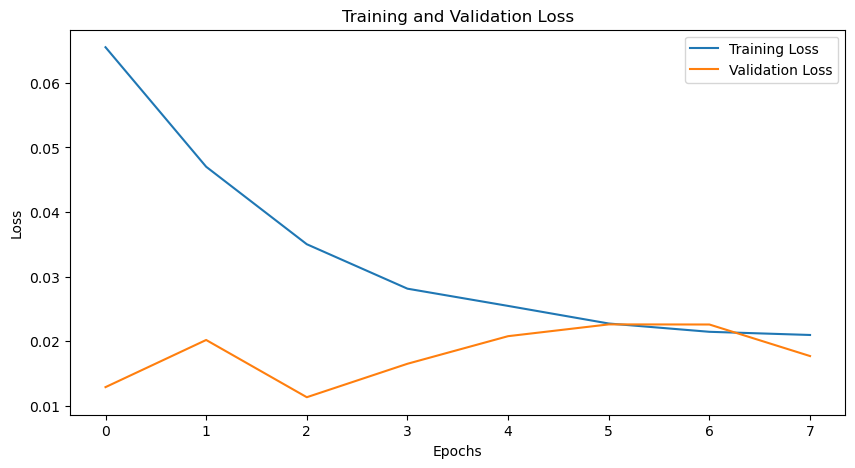

Training for permno_id: 50876
Starting Training...
Epoch 1/10, Training Loss: 0.0569271557033062, Validation Loss: 0.014496767971043786
Epoch 2/10, Training Loss: 0.0401748183907734, Validation Loss: 0.011563620918119947
Epoch 3/10, Training Loss: 0.030381232655296724, Validation Loss: 0.011340357130393386
Epoch 4/10, Training Loss: 0.023137284960183833, Validation Loss: 0.012296590954065323
Epoch 5/10, Training Loss: 0.019433172083356313, Validation Loss: 0.011456168334310254
Epoch 6/10, Training Loss: 0.01765018535984887, Validation Loss: 0.011331704289962849
Epoch 7/10, Training Loss: 0.01655576817898287, Validation Loss: 0.01142785573999087
Epoch 8/10, Training Loss: 0.01560297297934691, Validation Loss: 0.011606508400291204
Epoch 9/10, Training Loss: 0.015075587201863527, Validation Loss: 0.011895993879685799
Epoch 10/10, Training Loss: 0.014597953555898534, Validation Loss: 0.011387997927765051
Training Complete


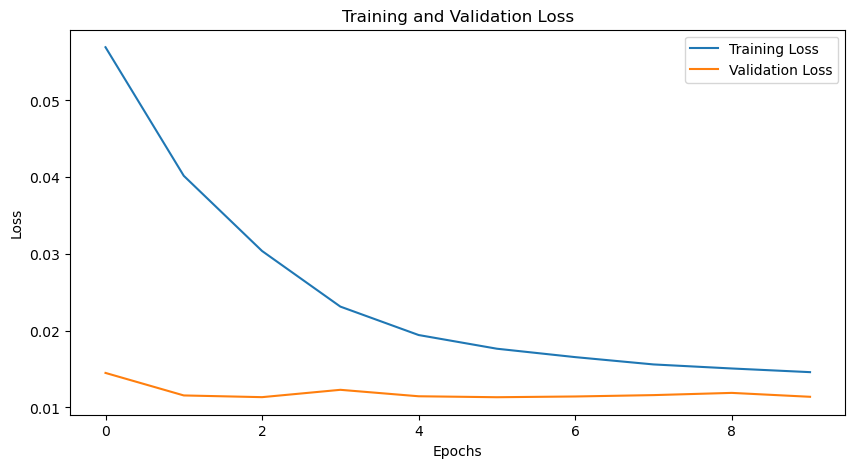

Training for permno_id: 64653
Starting Training...
Epoch 1/10, Training Loss: 0.07546685118642119, Validation Loss: 0.014871723018586636
Epoch 2/10, Training Loss: 0.053658942278060645, Validation Loss: 0.01980697107501328
Epoch 3/10, Training Loss: 0.04029928949765033, Validation Loss: 0.01745917151371638
Epoch 4/10, Training Loss: 0.029546167184081342, Validation Loss: 0.01514094245309631
Epoch 5/10, Training Loss: 0.02368980837571952, Validation Loss: 0.011567226494662464
Epoch 6/10, Training Loss: 0.020077875090969935, Validation Loss: 0.015270002108688155
Epoch 7/10, Training Loss: 0.018777455643026367, Validation Loss: 0.015960161574184895
Epoch 8/10, Training Loss: 0.01690130613537298, Validation Loss: 0.013392320678879818
Epoch 9/10, Training Loss: 0.016310365172103047, Validation Loss: 0.013705248711630702
Epoch 10/10, Training Loss: 0.015781684830370877, Validation Loss: 0.013770691119134426
Early stopping triggered.
Training Complete


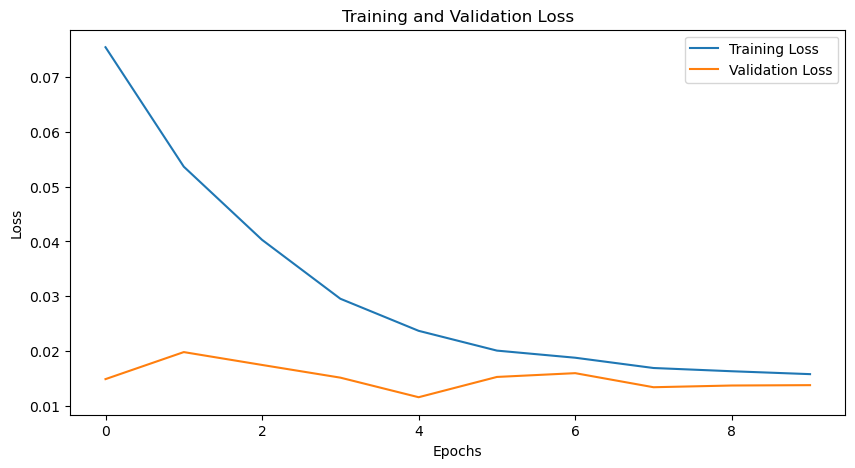

Training for permno_id: 77274
Starting Training...
Epoch 1/10, Training Loss: 0.07663699094620016, Validation Loss: 0.042722887670000396
Epoch 2/10, Training Loss: 0.04569813986826274, Validation Loss: 0.02609836511934797
Epoch 3/10, Training Loss: 0.037340949186020427, Validation Loss: 0.017214153970902164
Epoch 4/10, Training Loss: 0.028376020905044343, Validation Loss: 0.01170080341398716
Epoch 5/10, Training Loss: 0.023058079441802368, Validation Loss: 0.012857352383434772
Epoch 6/10, Training Loss: 0.019991171261709597, Validation Loss: 0.011392529821023345
Epoch 7/10, Training Loss: 0.017658656747597788, Validation Loss: 0.011651269004990658
Epoch 8/10, Training Loss: 0.016913730909840927, Validation Loss: 0.011536758315439025
Epoch 9/10, Training Loss: 0.01578300115134981, Validation Loss: 0.01143299462273717
Epoch 10/10, Training Loss: 0.015547045221966174, Validation Loss: 0.011698674488191804
Training Complete


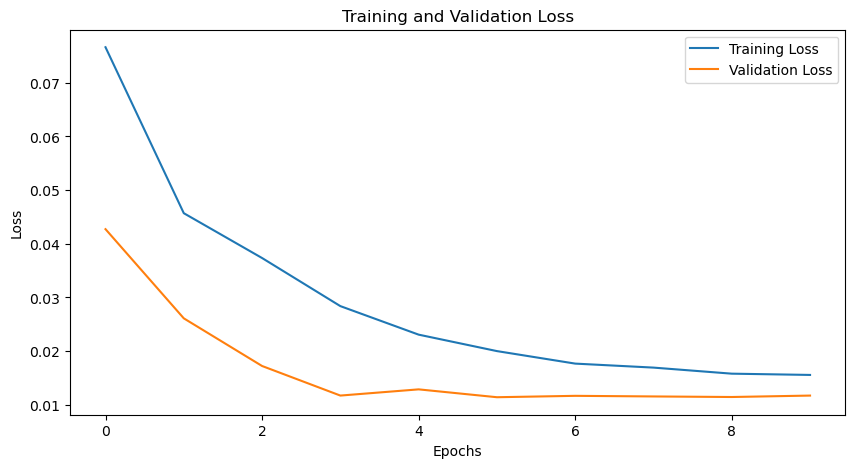

Training for permno_id: 81774
Starting Training...
Epoch 1/10, Training Loss: 0.07198737706575128, Validation Loss: 0.012150440753127137
Epoch 2/10, Training Loss: 0.05531387827876541, Validation Loss: 0.01320368330925703
Epoch 3/10, Training Loss: 0.04373262325922648, Validation Loss: 0.012563787866383791
Epoch 4/10, Training Loss: 0.03583871640471949, Validation Loss: 0.012857294486214718
Epoch 5/10, Training Loss: 0.03199146827682853, Validation Loss: 0.013518973952159286
Epoch 6/10, Training Loss: 0.02972349038140641, Validation Loss: 0.013922637018064657
Early stopping triggered.
Training Complete


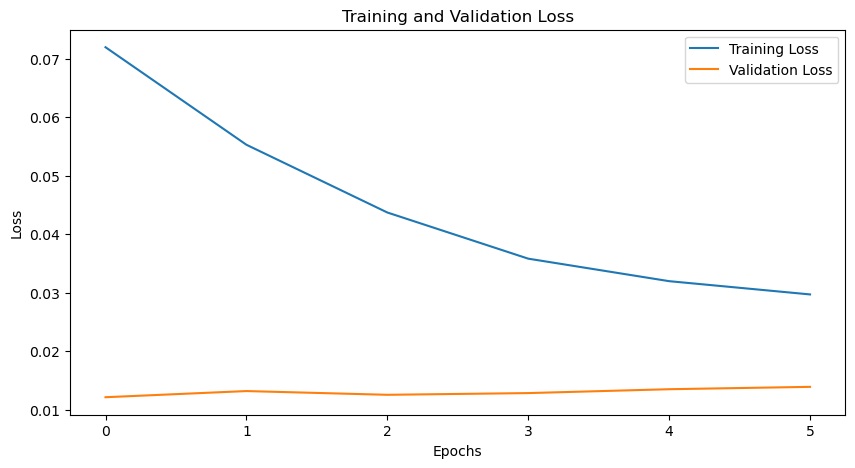

Training for permno_id: 86745
Starting Training...
Epoch 1/10, Training Loss: 0.08014084191785918, Validation Loss: 0.024940439965575933
Epoch 2/10, Training Loss: 0.061399680458837085, Validation Loss: 0.011795068935801586
Epoch 3/10, Training Loss: 0.04963909099913306, Validation Loss: 0.017739306048800547
Epoch 4/10, Training Loss: 0.040814554732706815, Validation Loss: 0.011326128772149483
Epoch 5/10, Training Loss: 0.03486727053920428, Validation Loss: 0.011732060772677263
Epoch 6/10, Training Loss: 0.032979688296715416, Validation Loss: 0.011437640059739351
Epoch 7/10, Training Loss: 0.03153623857845863, Validation Loss: 0.011461758753284812
Epoch 8/10, Training Loss: 0.03046512495105465, Validation Loss: 0.011439892463386059
Epoch 9/10, Training Loss: 0.02991284766337938, Validation Loss: 0.011372074019163847
Early stopping triggered.
Training Complete


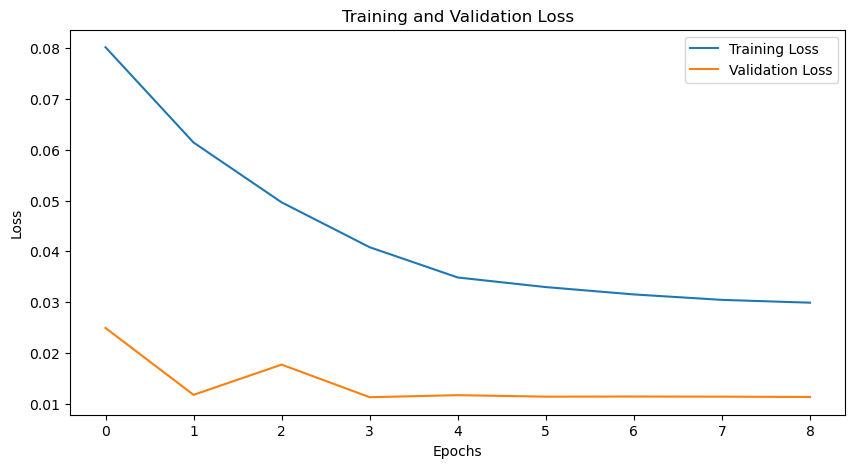

Training for permno_id: 89866
Starting Training...
Epoch 1/10, Training Loss: 0.054668758167988725, Validation Loss: 0.014770436566323042
Epoch 2/10, Training Loss: 0.04443273900283708, Validation Loss: 0.031181698975463707
Epoch 3/10, Training Loss: 0.03653339772588677, Validation Loss: 0.012102892971597612
Epoch 4/10, Training Loss: 0.03123086892689268, Validation Loss: 0.017569312437747914
Epoch 5/10, Training Loss: 0.026857646906541452, Validation Loss: 0.020575938746333122
Epoch 6/10, Training Loss: 0.025384205755674176, Validation Loss: 0.020673304951439302
Epoch 7/10, Training Loss: 0.023900239987091884, Validation Loss: 0.018339879888420303
Epoch 8/10, Training Loss: 0.023423782963719633, Validation Loss: 0.024757836169252794
Early stopping triggered.
Training Complete


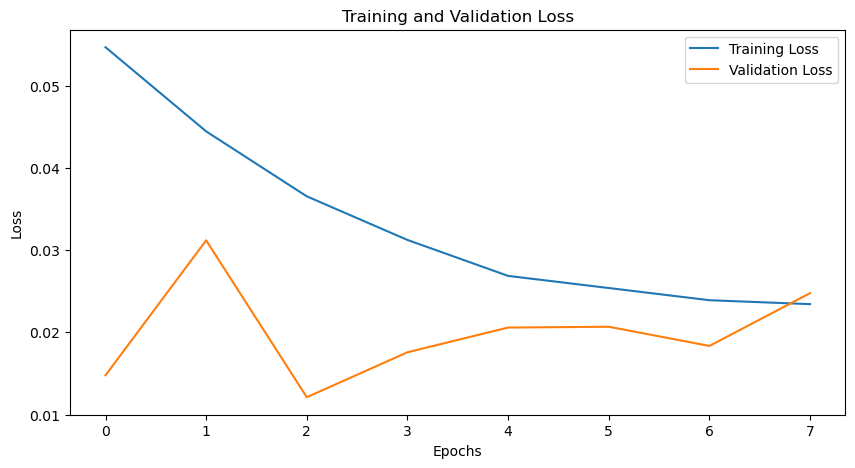

Training for permno_id: 93246
Starting Training...
Epoch 1/10, Training Loss: 0.07122547996954785, Validation Loss: 0.011900961903544763
Epoch 2/10, Training Loss: 0.058725165099733405, Validation Loss: 0.01296139524007837
Epoch 3/10, Training Loss: 0.04209228868906697, Validation Loss: 0.011390341406998536
Epoch 4/10, Training Loss: 0.03376739358322488, Validation Loss: 0.014190617948770523
Epoch 5/10, Training Loss: 0.031632005547483764, Validation Loss: 0.01145627877364556
Epoch 6/10, Training Loss: 0.028875271893209882, Validation Loss: 0.011335883367185792
Epoch 7/10, Training Loss: 0.027730399690982368, Validation Loss: 0.013641932280734181
Epoch 8/10, Training Loss: 0.027166015934199095, Validation Loss: 0.011679106780017415
Epoch 9/10, Training Loss: 0.025947809995462496, Validation Loss: 0.011613337090238929
Epoch 10/10, Training Loss: 0.025638227713190846, Validation Loss: 0.012258147277558843
Training Complete


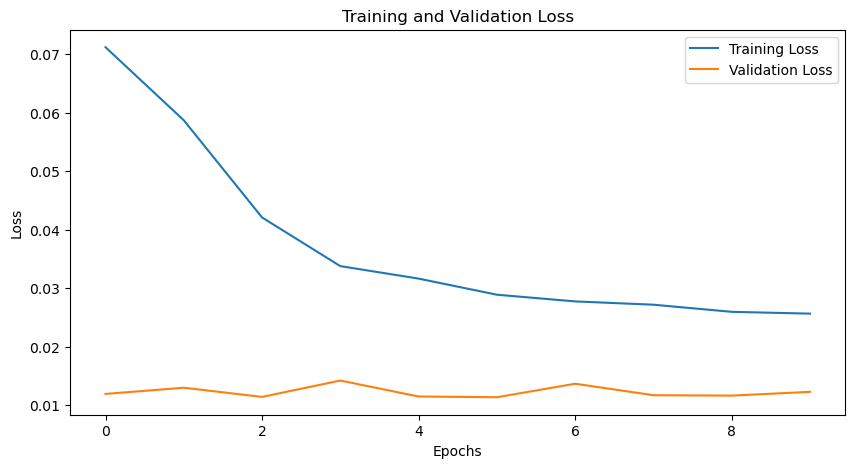

In [89]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Iterate over each unique permno_id in the dataset
unique_permno_ids = train_data["permno_id"].unique()
stock_embeddings = {}

for permno_id in unique_permno_ids[::50]:
    # set_seed(0)  # Set seed for reproducibility
    print(f"Training for permno_id: {permno_id}")

    # Prepare Data
    # dataset = FinancialDataset(first_month_data[:1000])
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
    val_dataset = FinancialDataset(validation_data[:1000])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize Model
    model = TransformerModel(
        input_dim=128 * 1 + 1,
        embed_dim=256,
        n_heads=16,
        ff_dim=1024,
        n_layers=6,
        output_dim=len(train_dataset.target_columns),
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training Loop
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
    criterion = nn.L1Loss()

    # for epoch in range(5):
    #     for batch in dataloader:
    #         optimizer.zero_grad()
    #         output, _ = model(batch["features"])
    #         loss = criterion(output, batch["target"])
    #         # print(f'loss: {loss}')
    #         loss.backward()
    #         optimizer.step()

    # print("Training Complete")

    train_losses = []
    val_losses = []

    num_epochs = 10
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    print("Starting Training...")
    # num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            # print(f'loss: {loss}')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                output, _ = model(batch["features"].to(device))
                loss = criterion(output, batch["target"].to(device))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training Complete")

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Extract embeddings for each stock
    model.eval()
    with torch.no_grad():
        permno_embeddings = []
        for batch in train_dataloader:
            _, embeddings = model(batch["features"].to(device))
            permno_embeddings.extend(embeddings.cpu().numpy())

        # Average the embeddings for this permno_id
        stock_embeddings[permno_id] = np.mean(permno_embeddings, axis=0)

    # Extract embeddings for each stock
    # stock_embeddings = {}
    # model.eval()
    # with torch.no_grad():
    #     for batch in train_dataloader:
    #         _, embeddings = model(batch["features"].to(device))
    #         for i, permno_id in enumerate(batch["permno_id"]):
    #             if permno_id not in stock_embeddings:
    #                 stock_embeddings[permno_id] = []
    #             stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

    # # Average the embeddings for each stock
    # for permno_id in stock_embeddings:
    #     stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [90]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 3.16216171e-01, -9.53502893e-01,  1.03802180e+00,  3.65403920e-01,
          1.29656777e-01,  4.67370570e-01,  2.36517727e-01,  5.57041168e-01,
          9.48707014e-02,  1.16637063e+00,  3.68217528e-01, -8.65704492e-02,
          3.01825142e+00, -5.86236060e-01, -1.67040452e-01,  1.03140461e+00,
          2.75211185e-01,  7.34101906e-02, -7.64362574e-01, -2.09743679e-01,
          7.39219904e-01, -6.35940969e-01, -7.14193821e-01,  2.27892709e+00,
         -9.83825505e-01,  9.01312113e-01,  8.75647068e-01, -7.85971954e-02,
          1.12592924e+00,  1.51939243e-01, -9.34413075e-01, -7.17433333e-01,
          1.86305847e-02, -6.03974819e-01, -1.36198366e+00,  2.17654443e+00,
          6.13661230e-01, -5.57699621e-01, -1.26717758e+00, -2.98230380e-01,
         -1.58038330e+00,  3.40409189e-01,  3.00796509e-01,  4.01785374e-01,
         -1.08328557e+00,  1.11189806e+00, -7.64796734e-01, -2.85998225e-01,
          2.38129683e-02, -1.53624666e+00,  1.04735875e+00, -3.33

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[ 0.9999994 , -0.05065507, -0.01621397,  0.05463705, -0.00600969,
        -0.01909274, -0.02061374, -0.07094409,  0.0210289 ,  0.01667954,
        -0.06622764, -0.10845758],
       [-0.05065507,  0.99999994,  0.02944442, -0.02919667,  0.13826372,
         0.06350636,  0.08136816,  0.04259483, -0.06193471, -0.03824576,
        -0.0042092 ,  0.05771206],
       [-0.01621397,  0.02944442,  1.        ,  0.02753547, -0.07101076,
         0.13399369,  0.09436473, -0.04075782, -0.05258219,  0.05621267,
         0.008722  , -0.01035464],
       [ 0.05463705, -0.02919667,  0.02753547,  0.99999994,  0.05763741,
        -0.0411462 ,  0.0063308 ,  0.05229213,  0.04380053, -0.00492806,
        -0.1363869 ,  0.03548425],
       [-0.00600969,  0.13826372, -0.07101076,  0.05763741,  1.0000001 ,
        -0.02513357, -0.01183601,  0.01866183, -0.06169397, -0.01463225,
         0.03486379,  0.06800487],
       [-0.01909274,  0.06350636,  0.13399369, -0.0411462 , -0.02513357,
         0.99999976,  

### Case 6: Past 128 days 1 feauture 11 targets

Training for permno_id: 10104
Starting Training...
Epoch 1/10, Training Loss: 0.1645627911720011, Validation Loss: 0.09386999408404033
Epoch 2/10, Training Loss: 0.11470215146740277, Validation Loss: 0.06536261023332675
Epoch 3/10, Training Loss: 0.09351132106449869, Validation Loss: 0.0602937468017141
Epoch 4/10, Training Loss: 0.08744485966033405, Validation Loss: 0.05936484318226576
Epoch 5/10, Training Loss: 0.08499294271071751, Validation Loss: 0.059124913066625595
Epoch 6/10, Training Loss: 0.08294408323450221, Validation Loss: 0.05871965208401283
Epoch 7/10, Training Loss: 0.08160086162388325, Validation Loss: 0.059219563069442906
Epoch 8/10, Training Loss: 0.08078046225839192, Validation Loss: 0.059005934124191604
Epoch 9/10, Training Loss: 0.08012173852572839, Validation Loss: 0.05895612885554632
Epoch 10/10, Training Loss: 0.07953853356755441, Validation Loss: 0.059520132218798004
Training Complete


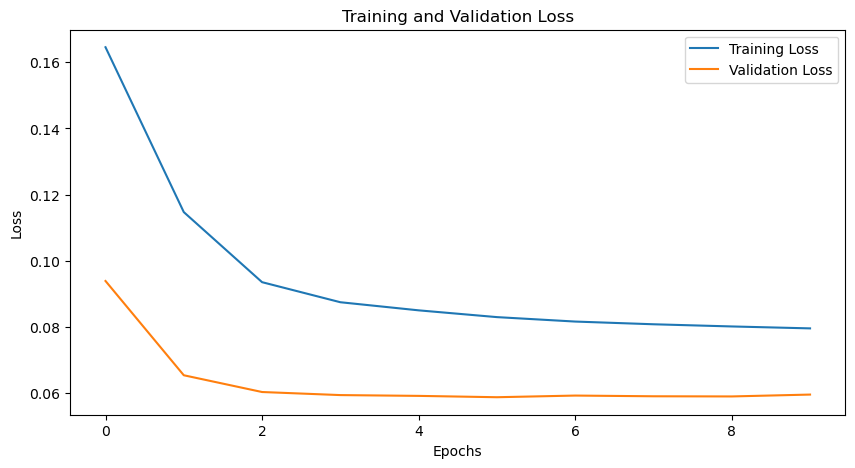

Training for permno_id: 13688
Starting Training...
Epoch 1/10, Training Loss: 0.3219650000747707, Validation Loss: 0.08323898197462161
Epoch 2/10, Training Loss: 0.2853943250245518, Validation Loss: 0.07080040996273358
Epoch 3/10, Training Loss: 0.26325593495534527, Validation Loss: 0.06810862353692453
Epoch 4/10, Training Loss: 0.2511476195520825, Validation Loss: 0.0719135260830323
Epoch 5/10, Training Loss: 0.24929805741541916, Validation Loss: 0.07246599874148767
Epoch 6/10, Training Loss: 0.2457976554416948, Validation Loss: 0.07206228096038103
Epoch 7/10, Training Loss: 0.2450427148077223, Validation Loss: 0.07268082567801078
Epoch 8/10, Training Loss: 0.24261676085491976, Validation Loss: 0.07311058510094881
Early stopping triggered.
Training Complete


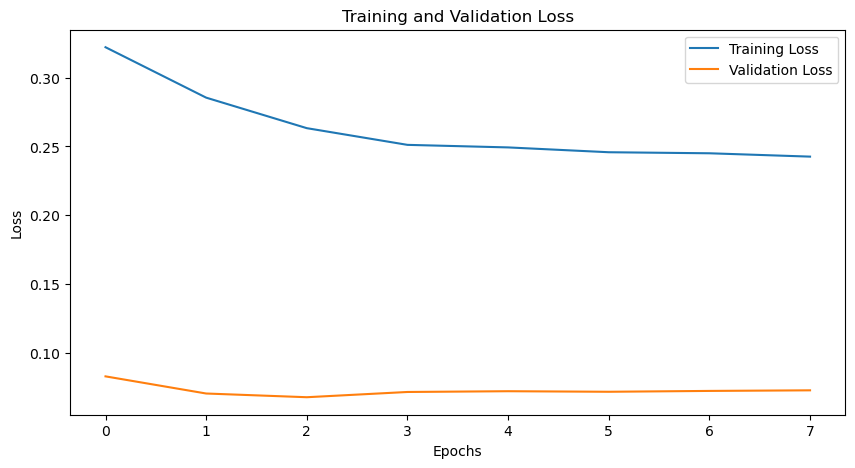

Training for permno_id: 17005
Starting Training...
Epoch 1/10, Training Loss: 0.13966266810894012, Validation Loss: 0.07542813879748185
Epoch 2/10, Training Loss: 0.10053779598739412, Validation Loss: 0.06346954684704542
Epoch 3/10, Training Loss: 0.09212331297910875, Validation Loss: 0.059980000369250774
Epoch 4/10, Training Loss: 0.08559788991179731, Validation Loss: 0.060383343137800694
Epoch 5/10, Training Loss: 0.08292761486437586, Validation Loss: 0.05901705101132393
Epoch 6/10, Training Loss: 0.08097182742009561, Validation Loss: 0.059182033874094486
Epoch 7/10, Training Loss: 0.08071420269293918, Validation Loss: 0.0592106431722641
Epoch 8/10, Training Loss: 0.07922943495213985, Validation Loss: 0.05900003667920828
Epoch 9/10, Training Loss: 0.07830286191569434, Validation Loss: 0.05894312045226494
Epoch 10/10, Training Loss: 0.0772261114584075, Validation Loss: 0.058766402614613376
Training Complete


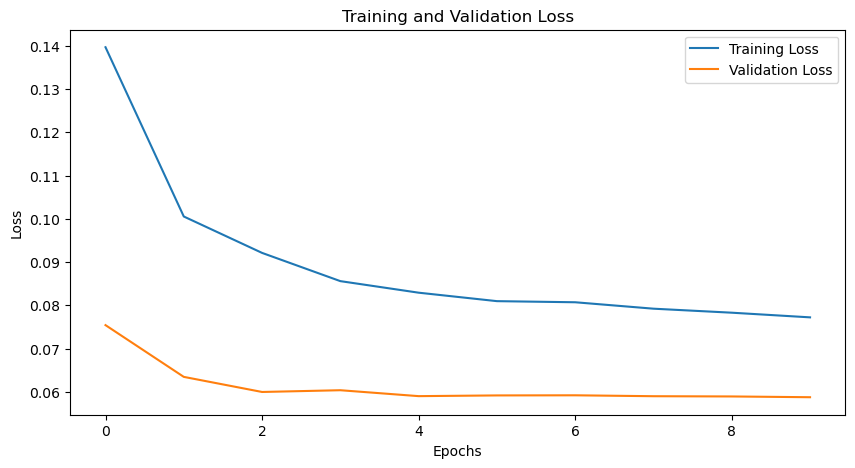

Training for permno_id: 21936
Starting Training...
Epoch 1/10, Training Loss: 0.15590061019692156, Validation Loss: 0.0937627237290144
Epoch 2/10, Training Loss: 0.10362269087798065, Validation Loss: 0.05969996998707453
Epoch 3/10, Training Loss: 0.08927597581512398, Validation Loss: 0.06061626970767975
Epoch 4/10, Training Loss: 0.08449812781893545, Validation Loss: 0.06100994752099117
Epoch 5/10, Training Loss: 0.08199495863583353, Validation Loss: 0.05946072408308586
Epoch 6/10, Training Loss: 0.08032423413048188, Validation Loss: 0.05935537784049908
Epoch 7/10, Training Loss: 0.07883024836579959, Validation Loss: 0.060386150144040585
Epoch 8/10, Training Loss: 0.07868227517853181, Validation Loss: 0.05933318628619114
Epoch 9/10, Training Loss: 0.07790022074348396, Validation Loss: 0.05909604268769423
Epoch 10/10, Training Loss: 0.07739966517935197, Validation Loss: 0.05872479826211929
Training Complete


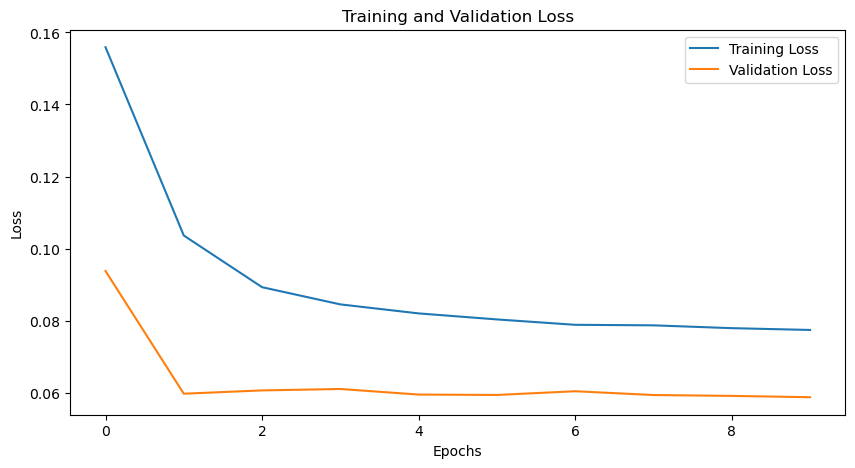

Training for permno_id: 30681
Starting Training...
Epoch 1/10, Training Loss: 0.15453129365212387, Validation Loss: 0.08712586139639218
Epoch 2/10, Training Loss: 0.11264827143814829, Validation Loss: 0.06286534542838733
Epoch 3/10, Training Loss: 0.10321223156319724, Validation Loss: 0.06153562323500713
Epoch 4/10, Training Loss: 0.09979255580239826, Validation Loss: 0.06062706466764212
Epoch 5/10, Training Loss: 0.09580363343573278, Validation Loss: 0.06207737264533838
Epoch 6/10, Training Loss: 0.09503378874311845, Validation Loss: 0.0603264377762874
Epoch 7/10, Training Loss: 0.09328179485681984, Validation Loss: 0.061103189984957375
Epoch 8/10, Training Loss: 0.09469372106509076, Validation Loss: 0.059710560676952205
Epoch 9/10, Training Loss: 0.09217479193790092, Validation Loss: 0.05937384286274513
Epoch 10/10, Training Loss: 0.09108519492050011, Validation Loss: 0.059087851705650486
Training Complete


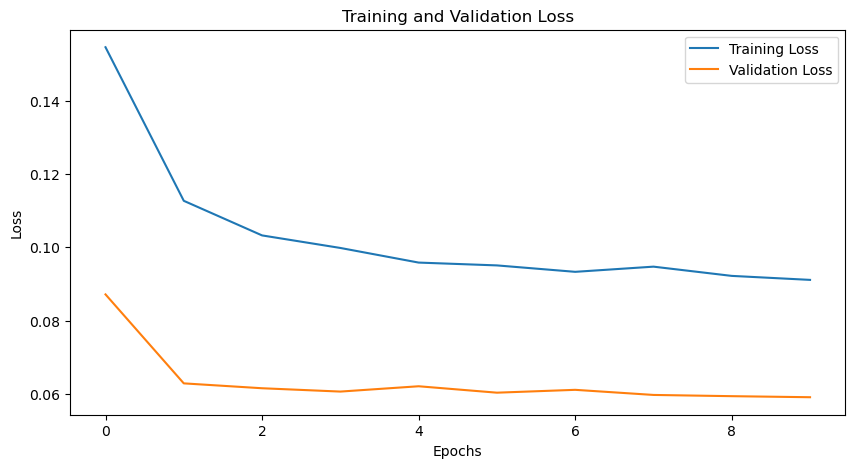

Training for permno_id: 50876
Starting Training...
Epoch 1/10, Training Loss: 0.1743946729434861, Validation Loss: 0.09860733710229397
Epoch 2/10, Training Loss: 0.12659333356552654, Validation Loss: 0.0721255283181866
Epoch 3/10, Training Loss: 0.10528343481322129, Validation Loss: 0.061518825901051365
Epoch 4/10, Training Loss: 0.09807232208549976, Validation Loss: 0.06123537911723057
Epoch 5/10, Training Loss: 0.0958224700556861, Validation Loss: 0.06171646248549223
Epoch 6/10, Training Loss: 0.09324443195429113, Validation Loss: 0.06093687781443199
Epoch 7/10, Training Loss: 0.0913087051982681, Validation Loss: 0.06116746583332618
Epoch 8/10, Training Loss: 0.09142857614076799, Validation Loss: 0.05999956807742516
Epoch 9/10, Training Loss: 0.08965213338120116, Validation Loss: 0.060227142026027046
Epoch 10/10, Training Loss: 0.0881712246272299, Validation Loss: 0.05931060078243414
Training Complete


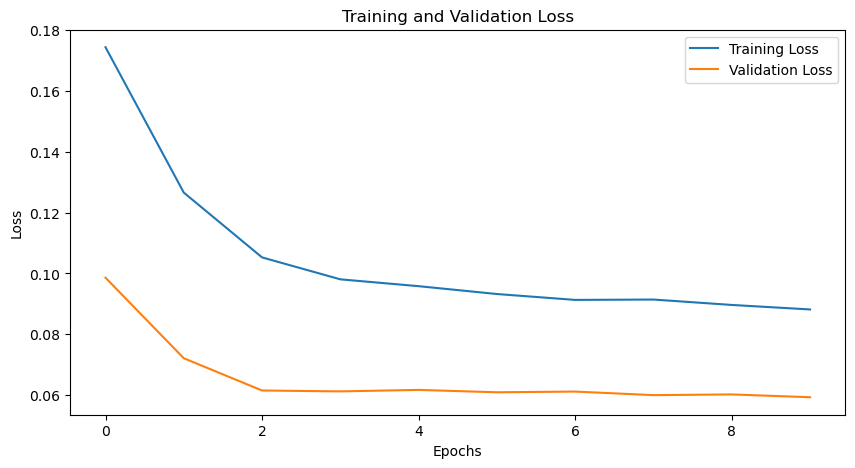

Training for permno_id: 64653
Starting Training...
Epoch 1/10, Training Loss: 0.1417971785283751, Validation Loss: 0.09044628776609898
Epoch 2/10, Training Loss: 0.09991421881649229, Validation Loss: 0.05979324349512657
Epoch 3/10, Training Loss: 0.08695955036414994, Validation Loss: 0.05921461712568998
Epoch 4/10, Training Loss: 0.0830650201274289, Validation Loss: 0.05929090082645416
Epoch 5/10, Training Loss: 0.08026087563484907, Validation Loss: 0.05853454644481341
Epoch 6/10, Training Loss: 0.07833444213287698, Validation Loss: 0.05847558751702309
Epoch 7/10, Training Loss: 0.07716038978348176, Validation Loss: 0.05838500584165255
Epoch 8/10, Training Loss: 0.07565478494183885, Validation Loss: 0.05791310717662176
Epoch 9/10, Training Loss: 0.07448474783450365, Validation Loss: 0.058249756383399166
Epoch 10/10, Training Loss: 0.07464622292253706, Validation Loss: 0.05790575407445431
Training Complete


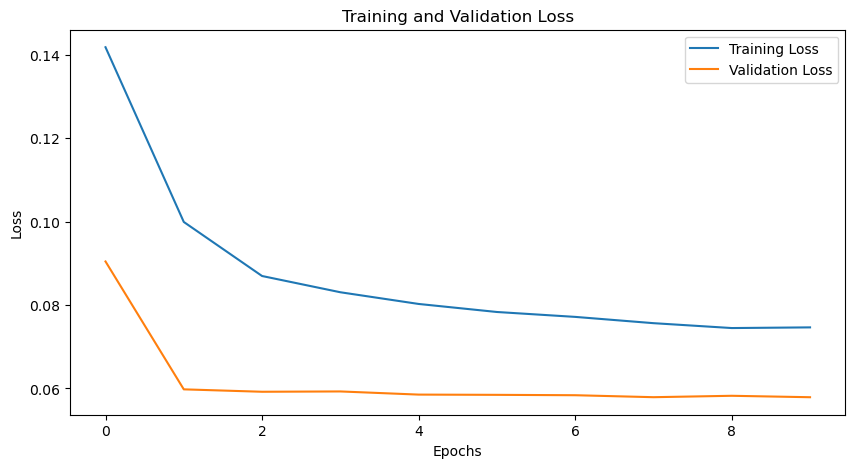

Training for permno_id: 77274
Starting Training...
Epoch 1/10, Training Loss: 0.16393370905684101, Validation Loss: 0.1065303652236859
Epoch 2/10, Training Loss: 0.10817615129053593, Validation Loss: 0.06728771670411031
Epoch 3/10, Training Loss: 0.09262394263512558, Validation Loss: 0.06252099138995011
Epoch 4/10, Training Loss: 0.08707065652641985, Validation Loss: 0.061846090170244374
Epoch 5/10, Training Loss: 0.0831475043669343, Validation Loss: 0.06089130168159803
Epoch 6/10, Training Loss: 0.0805846821102831, Validation Loss: 0.062313780188560486
Epoch 7/10, Training Loss: 0.07959493218610685, Validation Loss: 0.0624857060611248
Epoch 8/10, Training Loss: 0.07779348817550474, Validation Loss: 0.061228632306059204
Epoch 9/10, Training Loss: 0.07685876596305105, Validation Loss: 0.06381779722869396
Epoch 10/10, Training Loss: 0.07707981817010376, Validation Loss: 0.06360628021260102
Early stopping triggered.
Training Complete


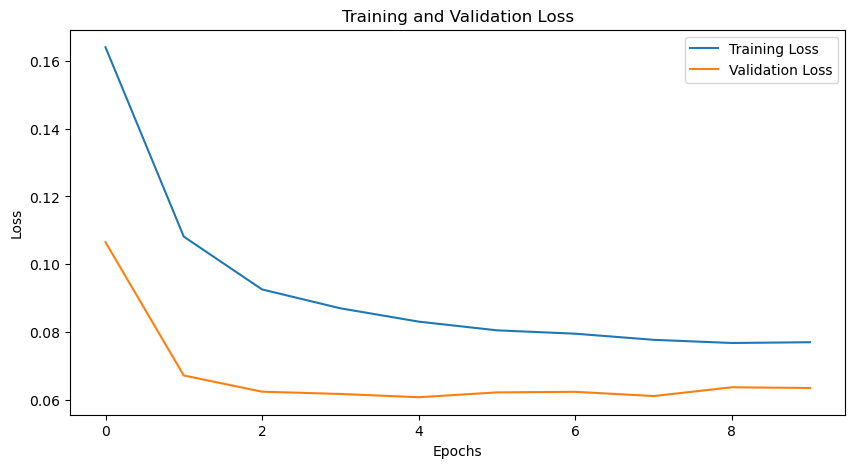

Training for permno_id: 81774
Starting Training...
Epoch 1/10, Training Loss: 0.2563471156689856, Validation Loss: 0.09183922720452149
Epoch 2/10, Training Loss: 0.20172688530551064, Validation Loss: 0.08181371974448363
Epoch 3/10, Training Loss: 0.17505077541702324, Validation Loss: 0.0949133150279522
Epoch 4/10, Training Loss: 0.1634273272421625, Validation Loss: 0.10449992306530476
Epoch 5/10, Training Loss: 0.1611694045778778, Validation Loss: 0.1117016381273667
Epoch 6/10, Training Loss: 0.15607420086032814, Validation Loss: 0.11626344732940197
Epoch 7/10, Training Loss: 0.15479186487694582, Validation Loss: 0.11197784418861072
Early stopping triggered.
Training Complete


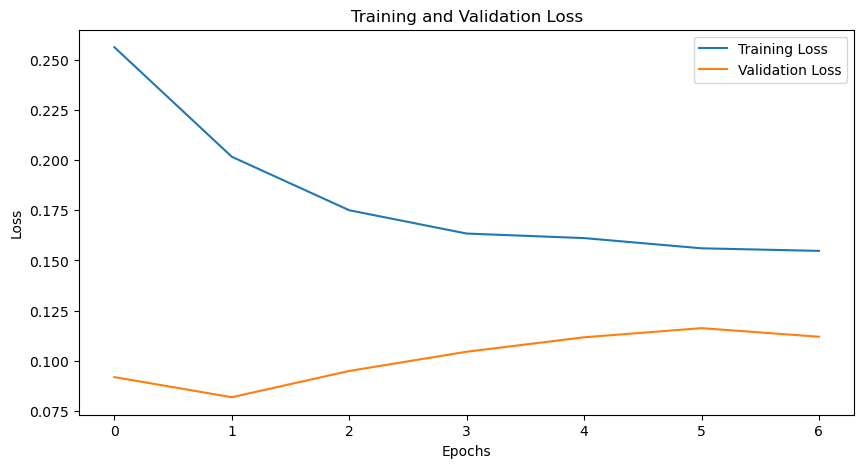

Training for permno_id: 86745
Starting Training...
Epoch 1/10, Training Loss: 0.33712231119473773, Validation Loss: 0.095811627805233
Epoch 2/10, Training Loss: 0.30526160779926514, Validation Loss: 0.08283825280765693
Epoch 3/10, Training Loss: 0.28328957926068044, Validation Loss: 0.0805339099218448
Epoch 4/10, Training Loss: 0.26834482202927273, Validation Loss: 0.08876521947483222
Epoch 5/10, Training Loss: 0.2591936370978753, Validation Loss: 0.09948536505301793
Epoch 6/10, Training Loss: 0.2573390416800976, Validation Loss: 0.09929000586271286
Epoch 7/10, Training Loss: 0.25414986577298904, Validation Loss: 0.10063087195158005
Epoch 8/10, Training Loss: 0.2504162359982729, Validation Loss: 0.10340897055963676
Early stopping triggered.
Training Complete


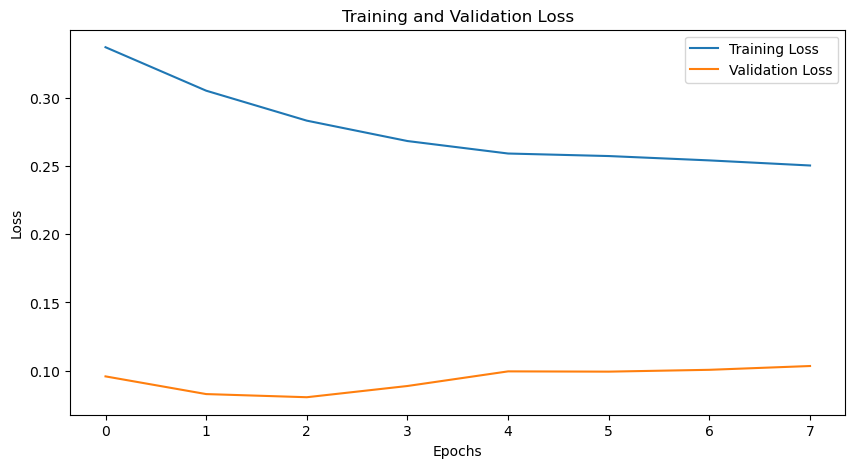

Training for permno_id: 89866
Starting Training...
Epoch 1/10, Training Loss: 0.18076794325477546, Validation Loss: 0.08886829887827237
Epoch 2/10, Training Loss: 0.1351680364459753, Validation Loss: 0.0628393931935231
Epoch 3/10, Training Loss: 0.11861470652123292, Validation Loss: 0.06284183853616317
Epoch 4/10, Training Loss: 0.11514692525896761, Validation Loss: 0.06271644340207179
Epoch 5/10, Training Loss: 0.11226975617723332, Validation Loss: 0.061995928486188255
Epoch 6/10, Training Loss: 0.1096168336355024, Validation Loss: 0.06280415908743937
Epoch 7/10, Training Loss: 0.10817500110715628, Validation Loss: 0.062118339352309704
Epoch 8/10, Training Loss: 0.10723914350900385, Validation Loss: 0.06114207487553358
Epoch 9/10, Training Loss: 0.10655831845684184, Validation Loss: 0.06297002080827951
Epoch 10/10, Training Loss: 0.10682204148421685, Validation Loss: 0.06074865348637104
Training Complete


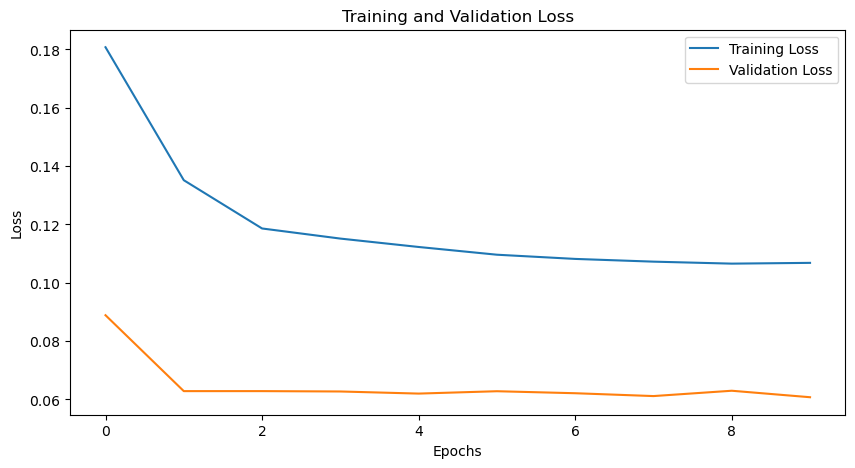

Training for permno_id: 93246
Starting Training...
Epoch 1/10, Training Loss: 0.23246041354205874, Validation Loss: 0.09171101388831933
Epoch 2/10, Training Loss: 0.18547530327406195, Validation Loss: 0.08233457369108994
Epoch 3/10, Training Loss: 0.16894715651869774, Validation Loss: 0.09158368036150932
Epoch 4/10, Training Loss: 0.16452205760611427, Validation Loss: 0.09276394297679265
Epoch 5/10, Training Loss: 0.15995355736878183, Validation Loss: 0.08655090381701787
Epoch 6/10, Training Loss: 0.1574296181400617, Validation Loss: 0.09020021309455235
Epoch 7/10, Training Loss: 0.1569323063724571, Validation Loss: 0.09136868889133136
Early stopping triggered.
Training Complete


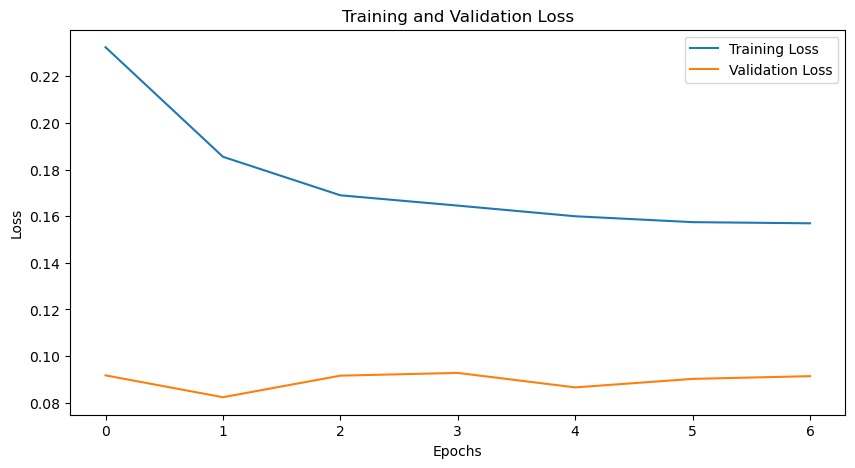

In [92]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Iterate over each unique permno_id in the dataset
unique_permno_ids = train_data["permno_id"].unique()
stock_embeddings = {}

for permno_id in unique_permno_ids[::50]:
    # set_seed(0)  # Set seed for reproducibility
    print(f"Training for permno_id: {permno_id}")

    # Prepare Data
    # dataset = FinancialDataset(first_month_data[:1000])
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
    val_dataset = FinancialDataset(validation_data[:1000])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize Model
    model = TransformerModel(
        input_dim=128 * 1 + 1,
        embed_dim=256,
        n_heads=16,
        ff_dim=1024,
        n_layers=6,
        output_dim=len(train_dataset.target_columns),
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training Loop
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
    criterion = nn.L1Loss()

    # for epoch in range(5):
    #     for batch in dataloader:
    #         optimizer.zero_grad()
    #         output, _ = model(batch["features"])
    #         loss = criterion(output, batch["target"])
    #         # print(f'loss: {loss}')
    #         loss.backward()
    #         optimizer.step()

    # print("Training Complete")

    train_losses = []
    val_losses = []

    num_epochs = 10
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    print("Starting Training...")
    # num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            # print(f'loss: {loss}')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                output, _ = model(batch["features"].to(device))
                loss = criterion(output, batch["target"].to(device))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training Complete")

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Extract embeddings for each stock
    model.eval()
    with torch.no_grad():
        permno_embeddings = []
        for batch in train_dataloader:
            _, embeddings = model(batch["features"].to(device))
            permno_embeddings.extend(embeddings.cpu().numpy())

        # Average the embeddings for this permno_id
        stock_embeddings[permno_id] = np.mean(permno_embeddings, axis=0)

    # Extract embeddings for each stock
    # stock_embeddings = {}
    # model.eval()
    # with torch.no_grad():
    #     for batch in train_dataloader:
    #         _, embeddings = model(batch["features"].to(device))
    #         for i, permno_id in enumerate(batch["permno_id"]):
    #             if permno_id not in stock_embeddings:
    #                 stock_embeddings[permno_id] = []
    #             stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

    # # Average the embeddings for each stock
    # for permno_id in stock_embeddings:
    #     stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [93]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-1.66863091e-02, -1.51464784e+00, -1.62101996e+00, -1.06642067e+00,
          1.73057830e+00, -4.15495098e-01, -1.55420983e+00, -1.16273835e-01,
         -5.84103346e-01, -1.85636437e+00, -2.01589018e-01,  4.53619123e-01,
          1.17854679e+00, -7.83480644e-01, -9.67128873e-01, -8.24701071e-01,
          1.85476333e-01, -1.07780313e+00,  1.58813310e+00,  4.44750518e-01,
         -2.13761076e-01,  4.31964695e-01, -1.77825496e-01,  5.03251135e-01,
          1.20541883e+00, -4.90027249e-01,  3.84092987e-01, -5.76221526e-01,
          1.37150669e+00,  2.72084326e-01,  1.13954329e+00,  7.77839541e-01,
         -7.29631111e-02,  5.17866552e-01, -4.38853502e-01,  1.87503970e+00,
         -3.34115744e-01,  1.67691275e-01,  1.26613212e+00, -9.39704716e-01,
          1.82506704e+00,  1.71384722e-01, -1.83501816e+00,  5.29319167e-01,
          1.01421857e+00, -1.95874706e-01,  5.37041605e-01, -2.05887899e-01,
          2.12312594e-01,  7.98991144e-01,  1.68390181e-02,  7.01

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[ 9.9999976e-01,  4.1673508e-02, -1.8395677e-02,  1.4040643e-02,
        -2.1168198e-02, -4.9851816e-02, -4.6664670e-02, -1.8191695e-03,
        -2.9841133e-03, -9.7703233e-02,  1.8874327e-02, -7.3640309e-02],
       [ 4.1673508e-02,  9.9999970e-01,  4.3188669e-02, -3.3679623e-02,
        -4.0379252e-02,  8.2049333e-02, -7.8550823e-02,  9.9451512e-02,
         4.8333872e-02,  1.3555156e-02, -7.7795535e-02, -8.0653310e-02],
       [-1.8395677e-02,  4.3188669e-02,  9.9999988e-01, -2.0026132e-02,
         6.2247287e-02,  1.2029732e-01,  8.7036908e-02,  6.4976383e-03,
         8.2951710e-03,  4.2097129e-02, -4.0276155e-02,  2.9346634e-02],
       [ 1.4040643e-02, -3.3679623e-02, -2.0026132e-02,  1.0000002e+00,
        -4.5401797e-02, -3.8870819e-02, -7.9483271e-02, -1.1222587e-01,
         6.1658882e-02, -2.4849128e-02,  4.7299065e-02,  5.1117722e-02],
       [-2.1168198e-02, -4.0379252e-02,  6.2247287e-02, -4.5401797e-02,
         1.0000006e+00,  1.2724140e-02,  2.4283202e-02, -9.5

### Case 7: Past 128 days 5 feautures 1 targets

Training for permno_id: 10104
Starting Training...
Epoch 1/10, Training Loss: 0.17984205060121086, Validation Loss: 0.05584397943069538
Epoch 2/10, Training Loss: 0.07223421231740051, Validation Loss: 0.01737831944289307
Epoch 3/10, Training Loss: 0.04921975980202357, Validation Loss: 0.021159459992001455
Epoch 4/10, Training Loss: 0.03585117915645242, Validation Loss: 0.012521825963631272
Epoch 5/10, Training Loss: 0.029756326745781634, Validation Loss: 0.014857365594555935
Epoch 6/10, Training Loss: 0.02584937758122881, Validation Loss: 0.01496175459275643
Epoch 7/10, Training Loss: 0.022120858697841566, Validation Loss: 0.014494331475968162
Epoch 8/10, Training Loss: 0.02078181541421347, Validation Loss: 0.015841027721762657
Epoch 9/10, Training Loss: 0.019531012072952256, Validation Loss: 0.016956648013244074
Early stopping triggered.
Training Complete


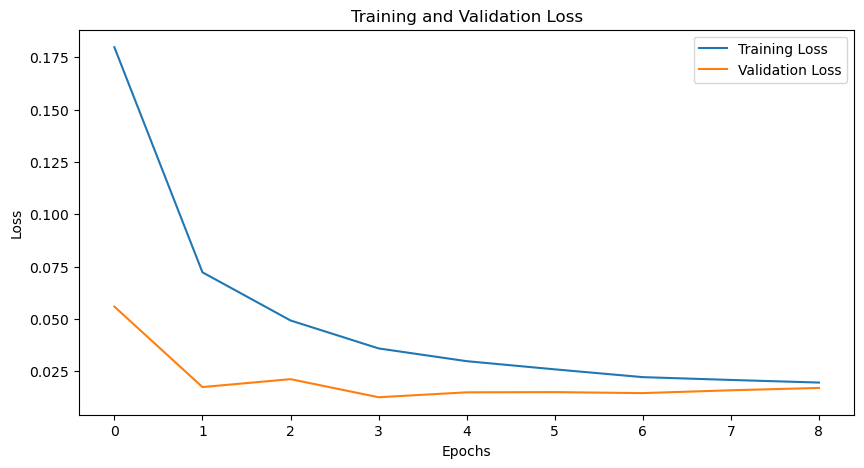

Training for permno_id: 13688
Starting Training...
Epoch 1/10, Training Loss: 0.0681636007502675, Validation Loss: 0.03383087879046798
Epoch 2/10, Training Loss: 0.052997633090449706, Validation Loss: 0.01128288529192408
Epoch 3/10, Training Loss: 0.04235926498141554, Validation Loss: 0.01557958172634244
Epoch 4/10, Training Loss: 0.03652830173571905, Validation Loss: 0.011422889423556626
Epoch 5/10, Training Loss: 0.033328725723549724, Validation Loss: 0.013342396278555194
Epoch 6/10, Training Loss: 0.03200006593639652, Validation Loss: 0.014204411845033368
Epoch 7/10, Training Loss: 0.03097866597171459, Validation Loss: 0.013747425361846885
Early stopping triggered.
Training Complete


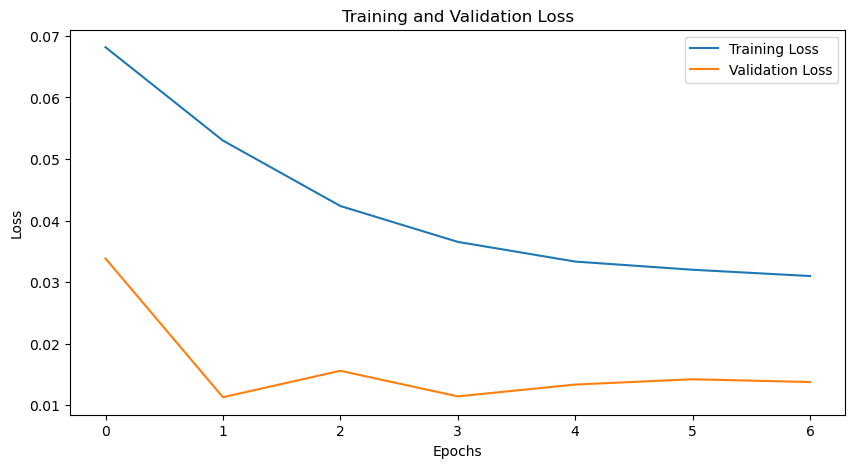

Training for permno_id: 17005
Starting Training...
Epoch 1/10, Training Loss: 0.07069443890617953, Validation Loss: 0.011718253411042193
Epoch 2/10, Training Loss: 0.04877442204289966, Validation Loss: 0.012474148844679197
Epoch 3/10, Training Loss: 0.040685941465198994, Validation Loss: 0.017915695284803707
Epoch 4/10, Training Loss: 0.03428602725681332, Validation Loss: 0.018256095548470814
Epoch 5/10, Training Loss: 0.02808424276817176, Validation Loss: 0.021594291552901268
Epoch 6/10, Training Loss: 0.02522721208838953, Validation Loss: 0.017488281630600493
Early stopping triggered.
Training Complete


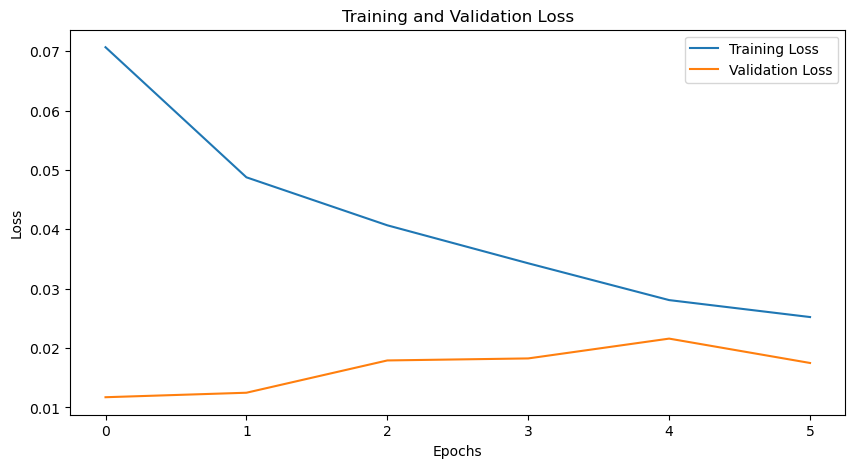

Training for permno_id: 21936
Starting Training...
Epoch 1/10, Training Loss: 0.11198511595527331, Validation Loss: 0.0457690820718805
Epoch 2/10, Training Loss: 0.061026178714301854, Validation Loss: 0.01901543994123737
Epoch 3/10, Training Loss: 0.04479498716278209, Validation Loss: 0.011398387684797248
Epoch 4/10, Training Loss: 0.03512657961497704, Validation Loss: 0.0113559040085723
Epoch 5/10, Training Loss: 0.029330740734520886, Validation Loss: 0.011537490723033747
Epoch 6/10, Training Loss: 0.02527097048651841, Validation Loss: 0.012239756838728985
Epoch 7/10, Training Loss: 0.022472875115151208, Validation Loss: 0.014163954105849067
Epoch 8/10, Training Loss: 0.020038312404519983, Validation Loss: 0.011699964835618934
Epoch 9/10, Training Loss: 0.019882446956924267, Validation Loss: 0.01285950878324608
Early stopping triggered.
Training Complete


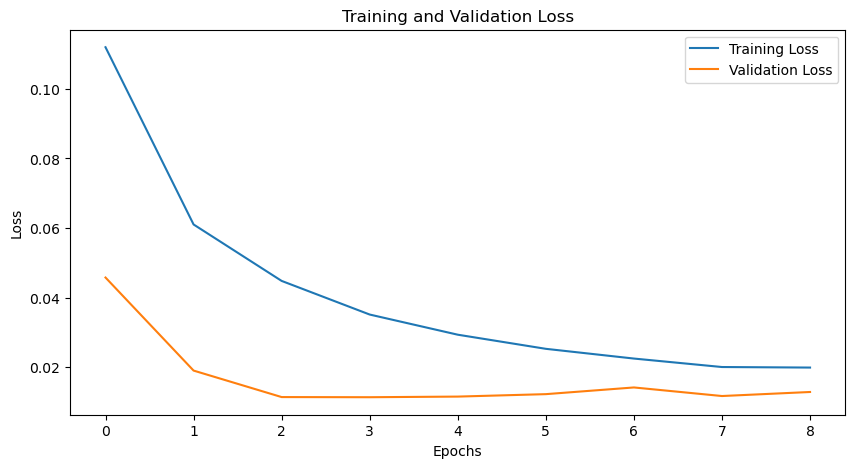

Training for permno_id: 30681
Starting Training...
Epoch 1/10, Training Loss: 0.06821816062761678, Validation Loss: 0.01144698029384017
Epoch 2/10, Training Loss: 0.050508080360790096, Validation Loss: 0.012385569124793014
Epoch 3/10, Training Loss: 0.035784260318097144, Validation Loss: 0.012549970376615724
Epoch 4/10, Training Loss: 0.027492577986170847, Validation Loss: 0.011412995983846486
Epoch 5/10, Training Loss: 0.024381109616822667, Validation Loss: 0.01349736307747662
Epoch 6/10, Training Loss: 0.02196274884045124, Validation Loss: 0.015555712083975473
Epoch 7/10, Training Loss: 0.020652107713330124, Validation Loss: 0.013384954771026969
Epoch 8/10, Training Loss: 0.01916135076640381, Validation Loss: 0.01293966251735886
Epoch 9/10, Training Loss: 0.01866495366104775, Validation Loss: 0.01318593043833971
Early stopping triggered.
Training Complete


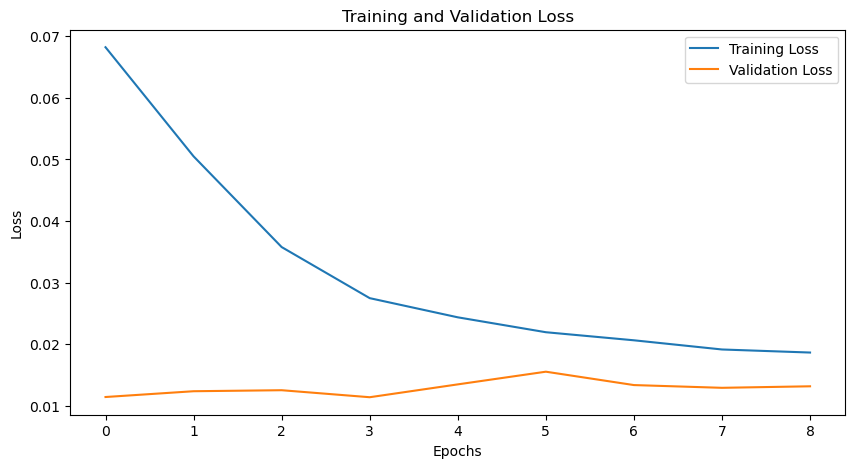

Training for permno_id: 50876
Starting Training...
Epoch 1/10, Training Loss: 0.06851009155313174, Validation Loss: 0.0124884481386592
Epoch 2/10, Training Loss: 0.048332960034410156, Validation Loss: 0.01195685084288319
Epoch 3/10, Training Loss: 0.03422154843186339, Validation Loss: 0.012698993785306811
Epoch 4/10, Training Loss: 0.030409775881303683, Validation Loss: 0.017840914893895388
Epoch 5/10, Training Loss: 0.024180207815435197, Validation Loss: 0.01243620466751357
Epoch 6/10, Training Loss: 0.02167685914577709, Validation Loss: 0.012435488790894548
Epoch 7/10, Training Loss: 0.019638736732304096, Validation Loss: 0.012788460667555531
Early stopping triggered.
Training Complete


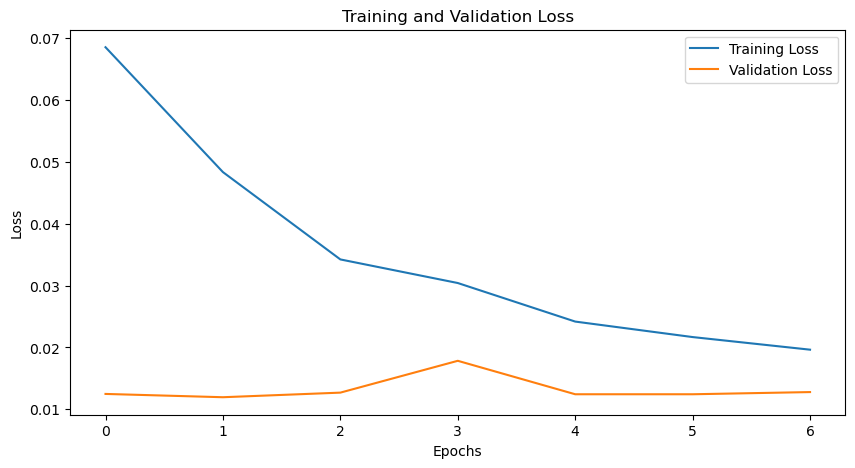

Training for permno_id: 64653
Starting Training...
Epoch 1/10, Training Loss: 0.08003428609420855, Validation Loss: 0.011791886296123266
Epoch 2/10, Training Loss: 0.05906085939043098, Validation Loss: 0.012577894997472564
Epoch 3/10, Training Loss: 0.04311003308329317, Validation Loss: 0.011336988808276752
Epoch 4/10, Training Loss: 0.031261139187133975, Validation Loss: 0.01426164316944778
Epoch 5/10, Training Loss: 0.02436424251128402, Validation Loss: 0.011585274012759328
Epoch 6/10, Training Loss: 0.021627298090606928, Validation Loss: 0.011756117378051082
Epoch 7/10, Training Loss: 0.019410039039535656, Validation Loss: 0.012024098619197806
Epoch 8/10, Training Loss: 0.016966783622693684, Validation Loss: 0.01491411798633635
Early stopping triggered.
Training Complete


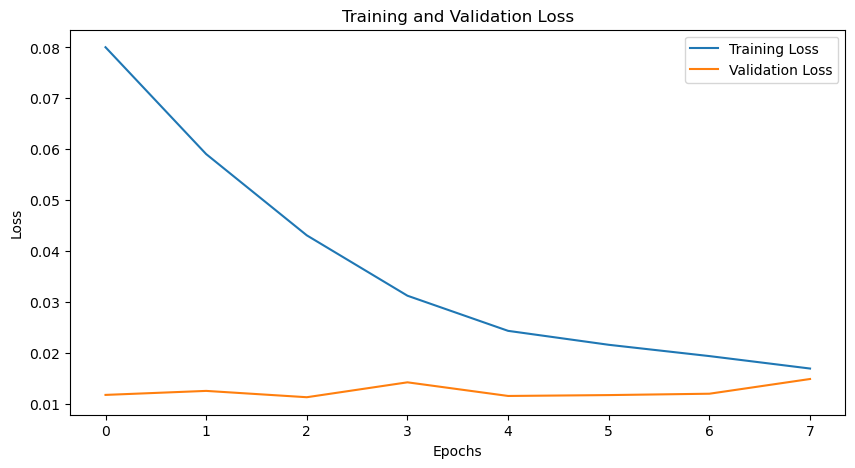

Training for permno_id: 77274
Starting Training...
Epoch 1/10, Training Loss: 0.08329642522666189, Validation Loss: 0.03830513947953781
Epoch 2/10, Training Loss: 0.04883893103235298, Validation Loss: 0.019598894752562046
Epoch 3/10, Training Loss: 0.0337516217906442, Validation Loss: 0.012701746930057803
Epoch 4/10, Training Loss: 0.02742360941030913, Validation Loss: 0.012363018933683634
Epoch 5/10, Training Loss: 0.021469305631601147, Validation Loss: 0.013680552210037908
Epoch 6/10, Training Loss: 0.018601072253659368, Validation Loss: 0.013702229596674442
Epoch 7/10, Training Loss: 0.017464288950173393, Validation Loss: 0.013965896175553402
Epoch 8/10, Training Loss: 0.016219818861120276, Validation Loss: 0.011428904991286496
Epoch 9/10, Training Loss: 0.015606695579157935, Validation Loss: 0.01334750473809739
Epoch 10/10, Training Loss: 0.015047316129008928, Validation Loss: 0.013246913828576604
Training Complete


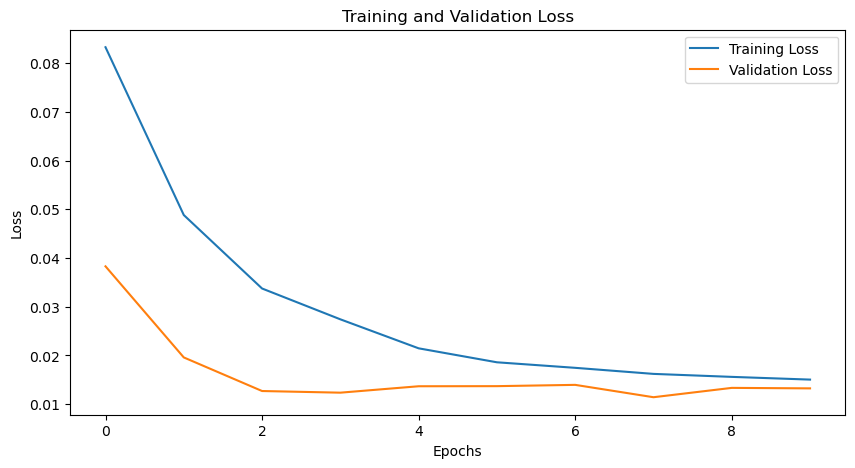

Training for permno_id: 81774
Starting Training...
Epoch 1/10, Training Loss: 0.14712023052076498, Validation Loss: 0.07420655339956284
Epoch 2/10, Training Loss: 0.062075076521270804, Validation Loss: 0.020299032330513
Epoch 3/10, Training Loss: 0.047541607067816787, Validation Loss: 0.015077116899192333
Epoch 4/10, Training Loss: 0.04145946198453506, Validation Loss: 0.011289235902950168
Epoch 5/10, Training Loss: 0.03735469814596905, Validation Loss: 0.01301446269887189
Epoch 6/10, Training Loss: 0.03307648820595609, Validation Loss: 0.013657644080619017
Epoch 7/10, Training Loss: 0.030936345354550414, Validation Loss: 0.013536131785561642
Epoch 8/10, Training Loss: 0.029770184825691912, Validation Loss: 0.014047332651292285
Epoch 9/10, Training Loss: 0.029052516135076683, Validation Loss: 0.01999242991829912
Early stopping triggered.
Training Complete


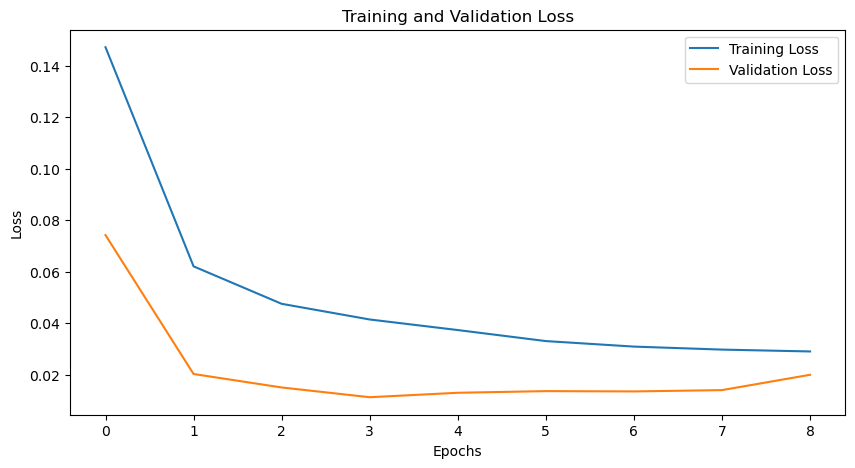

Training for permno_id: 86745
Starting Training...
Epoch 1/10, Training Loss: 0.07734159897598955, Validation Loss: 0.05173031737407049
Epoch 2/10, Training Loss: 0.058576152039070926, Validation Loss: 0.058819751565655075
Epoch 3/10, Training Loss: 0.04580227409799894, Validation Loss: 0.050059626499811806
Epoch 4/10, Training Loss: 0.038581052174170814, Validation Loss: 0.03143348420659701
Epoch 5/10, Training Loss: 0.03349251698495613, Validation Loss: 0.029279813636094332
Epoch 6/10, Training Loss: 0.03194030358766516, Validation Loss: 0.025988435838371515
Epoch 7/10, Training Loss: 0.03087260051526957, Validation Loss: 0.024600312889864046
Epoch 8/10, Training Loss: 0.03017368783346481, Validation Loss: 0.024492773693054914
Epoch 9/10, Training Loss: 0.029724959180586867, Validation Loss: 0.01865699514746666
Epoch 10/10, Training Loss: 0.0294601250336402, Validation Loss: 0.019180271308869123
Training Complete


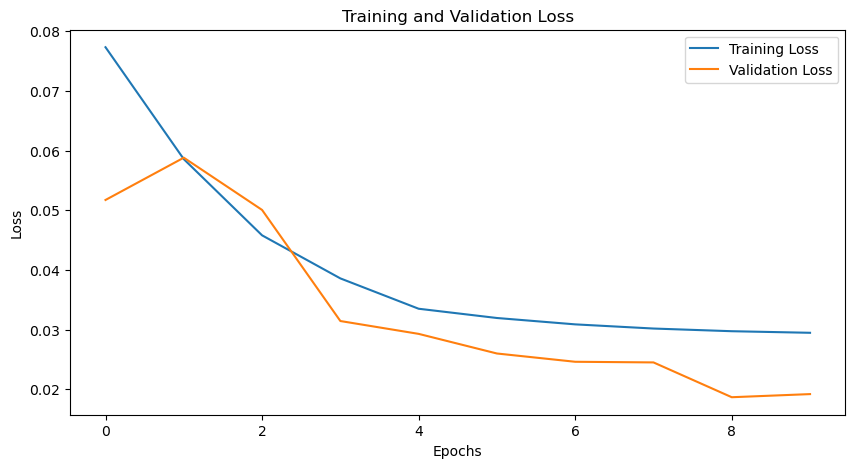

Training for permno_id: 89866
Starting Training...
Epoch 1/10, Training Loss: 0.09949989668611023, Validation Loss: 0.051149600806335606
Epoch 2/10, Training Loss: 0.05632552794284291, Validation Loss: 0.021527340325216453
Epoch 3/10, Training Loss: 0.03711048746481538, Validation Loss: 0.023161415476351976
Epoch 4/10, Training Loss: 0.030549803386545844, Validation Loss: 0.011354660925765833
Epoch 5/10, Training Loss: 0.02478250555901064, Validation Loss: 0.011371891247108579
Epoch 6/10, Training Loss: 0.022091828571218584, Validation Loss: 0.011438509255337218
Epoch 7/10, Training Loss: 0.020506406151172187, Validation Loss: 0.011360225034877658
Epoch 8/10, Training Loss: 0.019444194363637105, Validation Loss: 0.011396173659401635
Epoch 9/10, Training Loss: 0.018706961586657498, Validation Loss: 0.01131512550637126
Epoch 10/10, Training Loss: 0.018373592472117808, Validation Loss: 0.011389612841109434
Training Complete


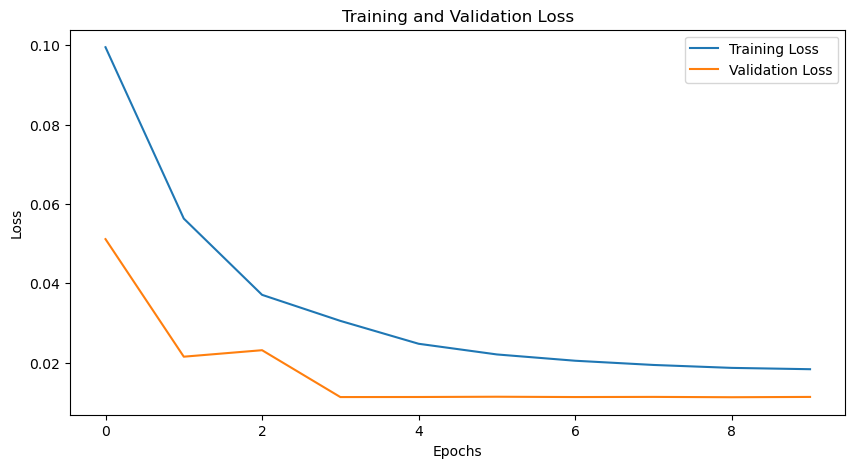

Training for permno_id: 93246
Starting Training...
Epoch 1/10, Training Loss: 0.08562515231056346, Validation Loss: 0.011791690097500881
Epoch 2/10, Training Loss: 0.059641620972090297, Validation Loss: 0.013944539396713177
Epoch 3/10, Training Loss: 0.047073577944603234, Validation Loss: 0.025572910749663908
Epoch 4/10, Training Loss: 0.036683042326735124, Validation Loss: 0.01529772913393875
Epoch 5/10, Training Loss: 0.031232762305686872, Validation Loss: 0.014014970821638903
Epoch 6/10, Training Loss: 0.029446820831961103, Validation Loss: 0.018777340184897184
Early stopping triggered.
Training Complete


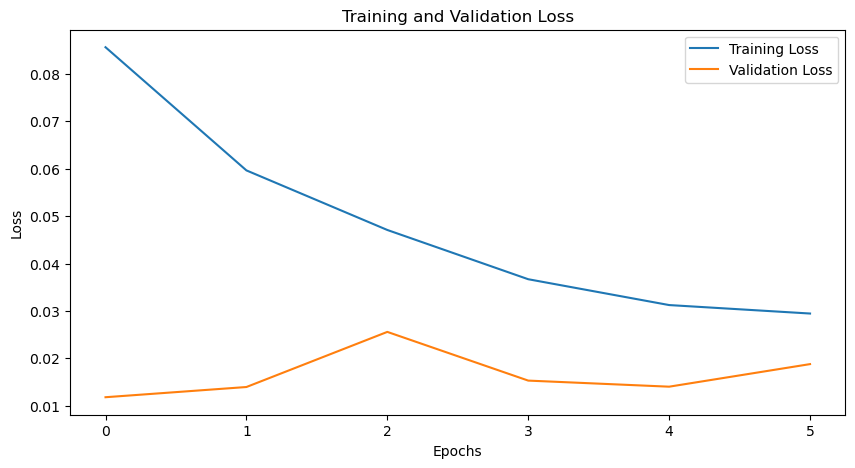

In [95]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Iterate over each unique permno_id in the dataset
unique_permno_ids = train_data["permno_id"].unique()
stock_embeddings = {}

for permno_id in unique_permno_ids[::50]:
    # set_seed(0)  # Set seed for reproducibility
    print(f"Training for permno_id: {permno_id}")

    # Prepare Data
    # dataset = FinancialDataset(first_month_data[:1000])
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
    val_dataset = FinancialDataset(validation_data[:1000])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize Model
    model = TransformerModel(
        input_dim=128 * 5 + 1,
        embed_dim=256,
        n_heads=16,
        ff_dim=1024,
        n_layers=6,
        output_dim=len(train_dataset.target_columns),
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training Loop
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
    criterion = nn.L1Loss()

    # for epoch in range(5):
    #     for batch in dataloader:
    #         optimizer.zero_grad()
    #         output, _ = model(batch["features"])
    #         loss = criterion(output, batch["target"])
    #         # print(f'loss: {loss}')
    #         loss.backward()
    #         optimizer.step()

    # print("Training Complete")

    train_losses = []
    val_losses = []

    num_epochs = 10
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    print("Starting Training...")
    # num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            # print(f'loss: {loss}')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                output, _ = model(batch["features"].to(device))
                loss = criterion(output, batch["target"].to(device))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training Complete")

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Extract embeddings for each stock
    model.eval()
    with torch.no_grad():
        permno_embeddings = []
        for batch in train_dataloader:
            _, embeddings = model(batch["features"].to(device))
            permno_embeddings.extend(embeddings.cpu().numpy())

        # Average the embeddings for this permno_id
        stock_embeddings[permno_id] = np.mean(permno_embeddings, axis=0)

    # Extract embeddings for each stock
    # stock_embeddings = {}
    # model.eval()
    # with torch.no_grad():
    #     for batch in train_dataloader:
    #         _, embeddings = model(batch["features"].to(device))
    #         for i, permno_id in enumerate(batch["permno_id"]):
    #             if permno_id not in stock_embeddings:
    #                 stock_embeddings[permno_id] = []
    #             stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

    # # Average the embeddings for each stock
    # for permno_id in stock_embeddings:
    #     stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [96]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-2.31048942e-01,  1.97144106e-01, -5.70267320e-01,  2.35448956e+00,
         -9.22667086e-01, -1.03943527e+00, -2.05715609e+00, -2.88378984e-01,
         -1.83161914e+00, -2.52041042e-01,  9.79752839e-01, -5.32386005e-01,
          4.72652912e-01,  9.45090294e-01,  4.99069631e-01, -1.50313959e-01,
         -2.39117599e+00, -5.28669311e-03,  4.39771503e-01, -1.28251684e+00,
         -3.19758087e-01, -3.69909763e-01, -1.86514199e+00, -1.80065930e+00,
          8.65110219e-01, -3.36565614e-01,  2.17074826e-01,  1.51991868e+00,
          1.53384936e+00, -1.13136366e-01,  3.17430794e-01,  1.06006622e+00,
         -8.35495114e-01, -5.45841940e-02, -7.84733057e-01, -2.12003335e-01,
          1.09533206e-01, -1.44215631e+00,  9.45802391e-01,  4.62433845e-01,
          1.83786500e+00, -3.23730320e-01,  3.45800072e-02,  9.17636216e-01,
         -1.46059430e+00,  3.21765631e-01, -5.86751223e-01,  5.42218126e-02,
          2.22676948e-01, -4.81877476e-01, -9.89041090e-01, -3.19

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[ 9.9999988e-01,  1.9105103e-02,  3.5858899e-02, -2.1966139e-03,
         2.0453339e-03, -1.8333526e-02, -5.8258448e-02,  4.8013188e-02,
        -2.4666883e-02,  2.2455078e-02, -1.1504195e-01, -3.4617677e-02],
       [ 1.9105103e-02,  1.0000002e+00,  3.5993863e-02,  1.0588818e-01,
         2.2944598e-02, -8.9339115e-02,  1.0992873e-01, -6.8675883e-02,
        -1.7551662e-02, -1.3390216e-01, -4.7005828e-02,  2.0576438e-02],
       [ 3.5858899e-02,  3.5993863e-02,  9.9999994e-01,  7.0565188e-04,
         1.6116047e-01,  2.9874856e-02, -6.2677525e-02, -6.8863179e-03,
         4.7717397e-03, -4.6170574e-02,  1.6379612e-02, -4.4316566e-03],
       [-2.1966139e-03,  1.0588818e-01,  7.0565188e-04,  1.0000002e+00,
         1.6467115e-02,  5.2988496e-02, -4.9840081e-02, -3.6833812e-02,
        -7.6420464e-02,  4.4356946e-02, -4.9662612e-02,  3.7259765e-02],
       [ 2.0453339e-03,  2.2944598e-02,  1.6116047e-01,  1.6467115e-02,
         1.0000002e+00,  1.2700702e-01, -3.3533432e-02,  2.1

### Case 8: Past 128 days 5 feautures 11 targets

Training for permno_id: 10104
Starting Training...
Epoch 1/10, Training Loss: 0.16024024639692572, Validation Loss: 0.09165076601008575
Epoch 2/10, Training Loss: 0.10720868532856305, Validation Loss: 0.06166028200338284
Epoch 3/10, Training Loss: 0.09475722205307749, Validation Loss: 0.05978066318978866
Epoch 4/10, Training Loss: 0.09042692670805587, Validation Loss: 0.060397643285493054
Epoch 5/10, Training Loss: 0.08842748651901881, Validation Loss: 0.0588274821639061
Epoch 6/10, Training Loss: 0.08599247814466555, Validation Loss: 0.05945984305193027
Epoch 7/10, Training Loss: 0.08514202882846196, Validation Loss: 0.05976863795270523
Epoch 8/10, Training Loss: 0.08316904875553316, Validation Loss: 0.05977691585818926
Epoch 9/10, Training Loss: 0.08220158475968573, Validation Loss: 0.059140936471521854
Epoch 10/10, Training Loss: 0.08128019163591994, Validation Loss: 0.059351700668533645
Early stopping triggered.
Training Complete


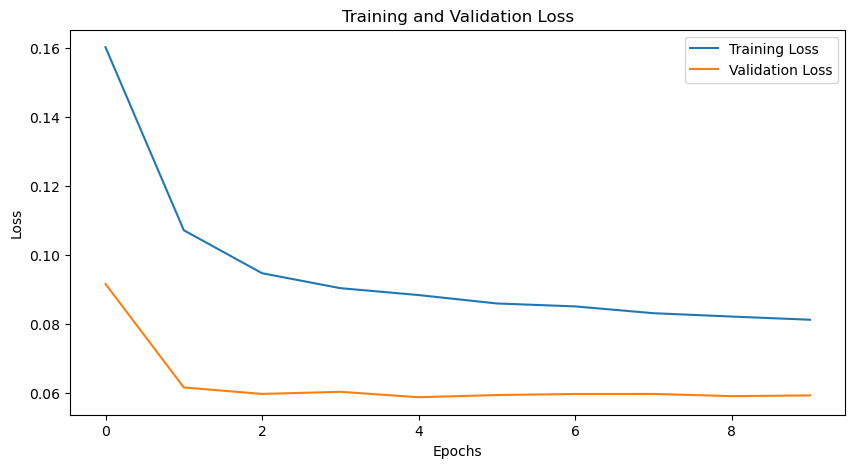

Training for permno_id: 13688
Starting Training...
Epoch 1/10, Training Loss: 0.352849617600441, Validation Loss: 0.08580541796982288
Epoch 2/10, Training Loss: 0.27863006355861825, Validation Loss: 0.07194352677712838
Epoch 3/10, Training Loss: 0.2598655358370807, Validation Loss: 0.07719163782894611
Epoch 4/10, Training Loss: 0.25440381922655636, Validation Loss: 0.0745484239111344
Epoch 5/10, Training Loss: 0.2513427034848266, Validation Loss: 0.07483164966106415
Epoch 6/10, Training Loss: 0.24870947231021193, Validation Loss: 0.07326125384618838
Epoch 7/10, Training Loss: 0.24740298175149494, Validation Loss: 0.07311055498818557
Early stopping triggered.
Training Complete


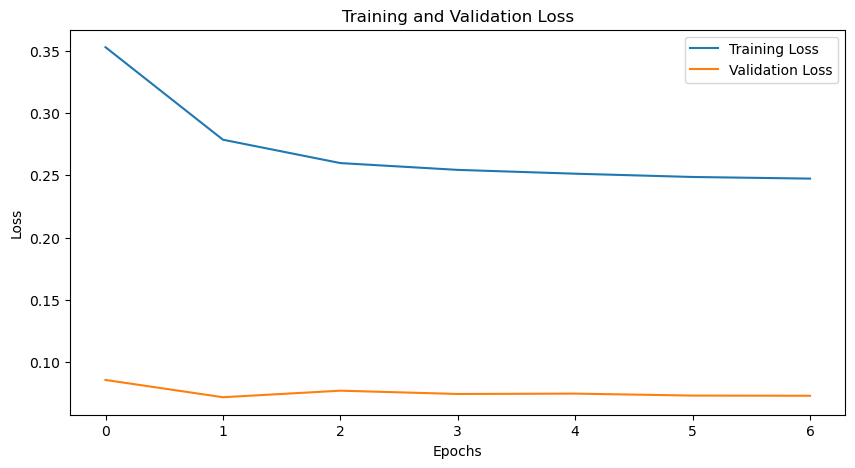

Training for permno_id: 17005
Starting Training...
Epoch 1/10, Training Loss: 0.1501389721201526, Validation Loss: 0.0808577248826623
Epoch 2/10, Training Loss: 0.10568055220776135, Validation Loss: 0.06256220365564029
Epoch 3/10, Training Loss: 0.09329525153670046, Validation Loss: 0.06073439586907625
Epoch 4/10, Training Loss: 0.08829084018038379, Validation Loss: 0.060043844083944954
Epoch 5/10, Training Loss: 0.08554644655022356, Validation Loss: 0.05931571312248707
Epoch 6/10, Training Loss: 0.08345874750779735, Validation Loss: 0.05911439936608076
Epoch 7/10, Training Loss: 0.08153113981501924, Validation Loss: 0.05859688203781843
Epoch 8/10, Training Loss: 0.08168513876282507, Validation Loss: 0.05915179724494616
Epoch 9/10, Training Loss: 0.08072803976635139, Validation Loss: 0.059074540001650654
Epoch 10/10, Training Loss: 0.07983348539306058, Validation Loss: 0.058844503636161484
Training Complete


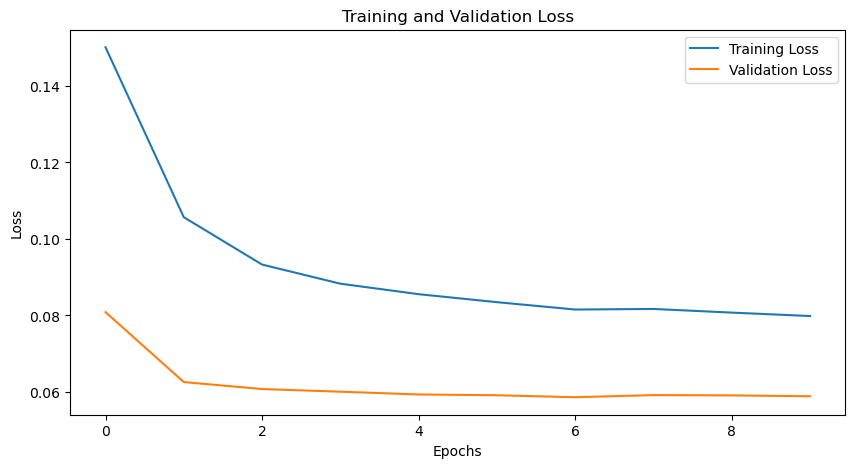

Training for permno_id: 21936
Starting Training...
Epoch 1/10, Training Loss: 0.1375660521702634, Validation Loss: 0.08092468107740085
Epoch 2/10, Training Loss: 0.1019463458408912, Validation Loss: 0.06113448832184076
Epoch 3/10, Training Loss: 0.09242375443379085, Validation Loss: 0.05956919273982445
Epoch 4/10, Training Loss: 0.08840791612035698, Validation Loss: 0.06002223615845045
Epoch 5/10, Training Loss: 0.08565795556124714, Validation Loss: 0.05813785797605912
Epoch 6/10, Training Loss: 0.08341692315621509, Validation Loss: 0.05830160342156887
Epoch 7/10, Training Loss: 0.08268527717640002, Validation Loss: 0.05792390089482069
Epoch 8/10, Training Loss: 0.0818687201374107, Validation Loss: 0.0583948049073418
Epoch 9/10, Training Loss: 0.08137214773645003, Validation Loss: 0.05818670894950628
Epoch 10/10, Training Loss: 0.08118219301104546, Validation Loss: 0.058784623009463154
Training Complete


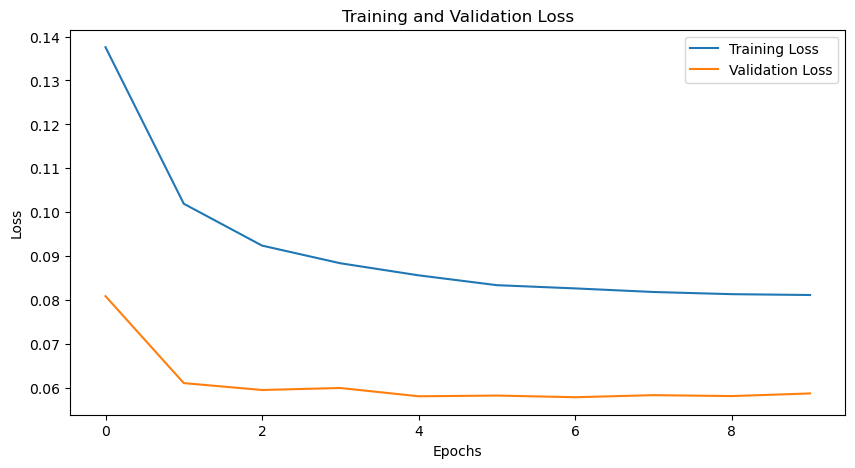

Training for permno_id: 30681
Starting Training...
Epoch 1/10, Training Loss: 0.13811251459022364, Validation Loss: 0.08003834045181672
Epoch 2/10, Training Loss: 0.10811541384706895, Validation Loss: 0.06223982355246941
Epoch 3/10, Training Loss: 0.10023029314147101, Validation Loss: 0.060518146492540836
Epoch 4/10, Training Loss: 0.09715771726850006, Validation Loss: 0.059461607287327446
Epoch 5/10, Training Loss: 0.09498839214858082, Validation Loss: 0.059990624276300274
Epoch 6/10, Training Loss: 0.09411714546796349, Validation Loss: 0.060248265974223614
Epoch 7/10, Training Loss: 0.09248471870604488, Validation Loss: 0.059123014410336815
Epoch 8/10, Training Loss: 0.09150294131702846, Validation Loss: 0.05919301106284062
Epoch 9/10, Training Loss: 0.09048550493187374, Validation Loss: 0.059578804609676204
Epoch 10/10, Training Loss: 0.09042498676313294, Validation Loss: 0.05909176481266817
Training Complete


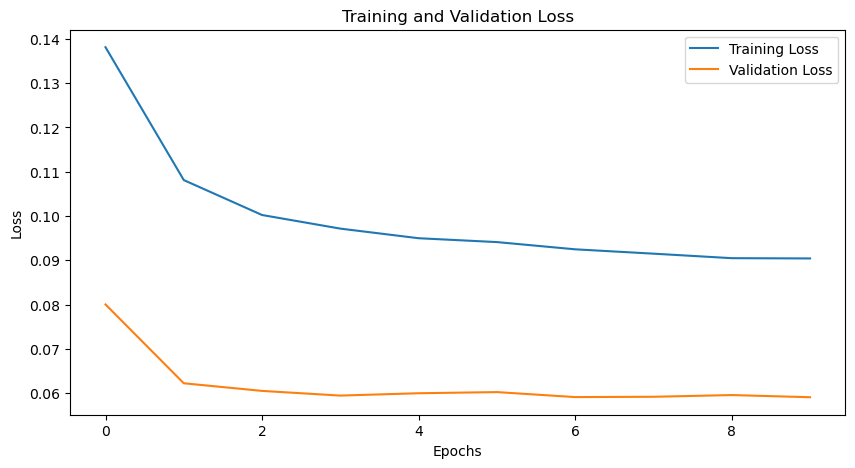

Training for permno_id: 50876
Starting Training...
Epoch 1/10, Training Loss: 0.19048897984127203, Validation Loss: 0.11852406772474448
Epoch 2/10, Training Loss: 0.12548924340969986, Validation Loss: 0.06511652438590924
Epoch 3/10, Training Loss: 0.10064563920928372, Validation Loss: 0.06059335141132275
Epoch 4/10, Training Loss: 0.0963743765734964, Validation Loss: 0.060053606517612934
Epoch 5/10, Training Loss: 0.0938385965095626, Validation Loss: 0.06132458274563154
Epoch 6/10, Training Loss: 0.09211431402299139, Validation Loss: 0.060604970902204514
Epoch 7/10, Training Loss: 0.09212841155628364, Validation Loss: 0.06111708780129751
Epoch 8/10, Training Loss: 0.0907850894663069, Validation Loss: 0.06061198624471823
Epoch 9/10, Training Loss: 0.0901533542200923, Validation Loss: 0.06007898040115833
Early stopping triggered.
Training Complete


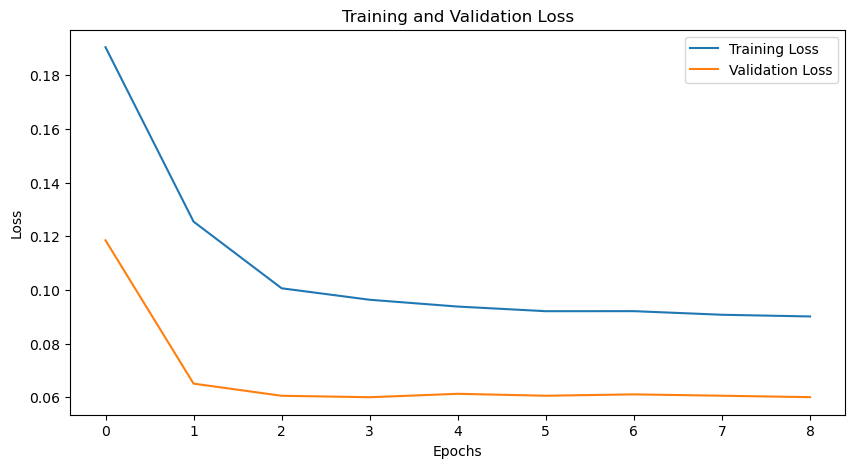

Training for permno_id: 64653
Starting Training...
Epoch 1/10, Training Loss: 0.1450344595230288, Validation Loss: 0.09945924580097198
Epoch 2/10, Training Loss: 0.10095731520818339, Validation Loss: 0.06864208821207285
Epoch 3/10, Training Loss: 0.08850215644472176, Validation Loss: 0.0622638805458943
Epoch 4/10, Training Loss: 0.08399634342640638, Validation Loss: 0.06031209323555231
Epoch 5/10, Training Loss: 0.08097969957937796, Validation Loss: 0.0597125639518102
Epoch 6/10, Training Loss: 0.08020113356825379, Validation Loss: 0.060101949920256935
Epoch 7/10, Training Loss: 0.07777687534689903, Validation Loss: 0.05923653797556957
Epoch 8/10, Training Loss: 0.0766466623172164, Validation Loss: 0.060400440357625484
Epoch 9/10, Training Loss: 0.07619716475407283, Validation Loss: 0.059698947394887604
Epoch 10/10, Training Loss: 0.07498679962009192, Validation Loss: 0.058572460586826004
Training Complete


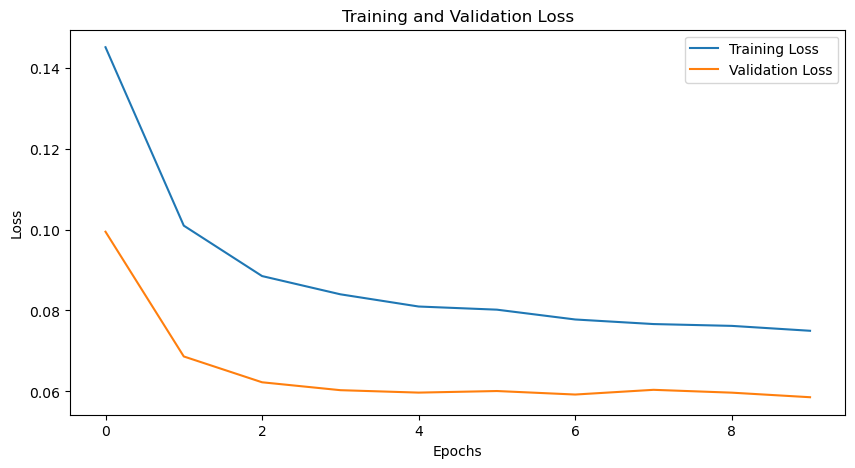

Training for permno_id: 77274
Starting Training...
Epoch 1/10, Training Loss: 0.1308861132711172, Validation Loss: 0.07255994776884715
Epoch 2/10, Training Loss: 0.09592122957110405, Validation Loss: 0.06105674027154843
Epoch 3/10, Training Loss: 0.08210491720173094, Validation Loss: 0.06155508073667685
Epoch 4/10, Training Loss: 0.07749120197776291, Validation Loss: 0.06255562417209148
Epoch 5/10, Training Loss: 0.07452914781040615, Validation Loss: 0.06231508714457353
Epoch 6/10, Training Loss: 0.07223480639772283, Validation Loss: 0.0619222034389774
Epoch 7/10, Training Loss: 0.07163571897480223, Validation Loss: 0.06047353707253933
Epoch 8/10, Training Loss: 0.07143125424368514, Validation Loss: 0.06307203757266204
Epoch 9/10, Training Loss: 0.06984925797830026, Validation Loss: 0.062131901582082115
Epoch 10/10, Training Loss: 0.07013794841865699, Validation Loss: 0.061318567022681236
Training Complete


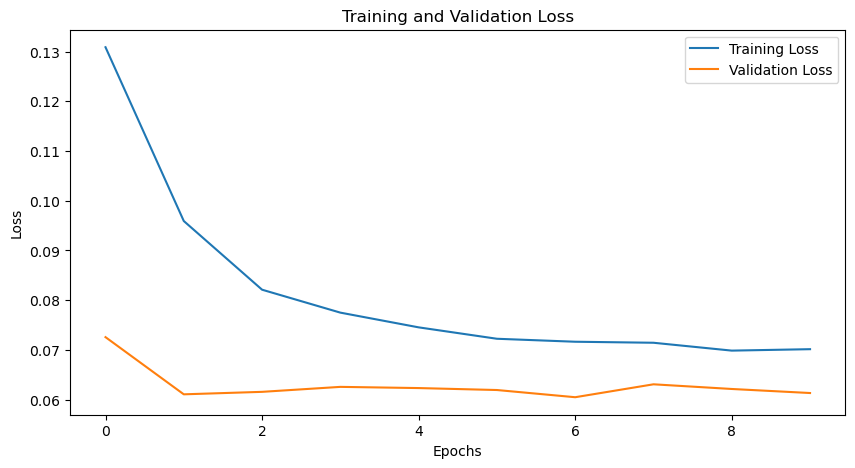

Training for permno_id: 81774
Starting Training...
Epoch 1/10, Training Loss: 0.22605023036400476, Validation Loss: 0.08182757844527562
Epoch 2/10, Training Loss: 0.18488412412504354, Validation Loss: 0.09964011174937089
Epoch 3/10, Training Loss: 0.17227264121174812, Validation Loss: 0.10351166501641273
Epoch 4/10, Training Loss: 0.16354015490247142, Validation Loss: 0.10923333403964837
Epoch 5/10, Training Loss: 0.1606202040695482, Validation Loss: 0.1129440621783336
Epoch 6/10, Training Loss: 0.1589843709435728, Validation Loss: 0.11402627701560657
Early stopping triggered.
Training Complete


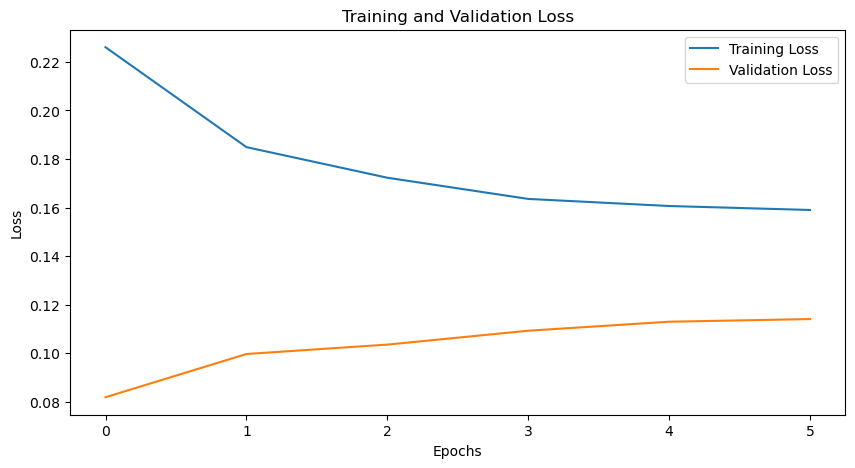

Training for permno_id: 86745
Starting Training...
Epoch 1/10, Training Loss: 0.31655559730198646, Validation Loss: 0.08580637226502101
Epoch 2/10, Training Loss: 0.2747453057931529, Validation Loss: 0.08861722859243552
Epoch 3/10, Training Loss: 0.2565546344137854, Validation Loss: 0.10431589744985104
Epoch 4/10, Training Loss: 0.2493570786383417, Validation Loss: 0.10722591355443001
Epoch 5/10, Training Loss: 0.24841585983004835, Validation Loss: 0.11140208753446738
Epoch 6/10, Training Loss: 0.24526442980600727, Validation Loss: 0.11476533549527328
Early stopping triggered.
Training Complete


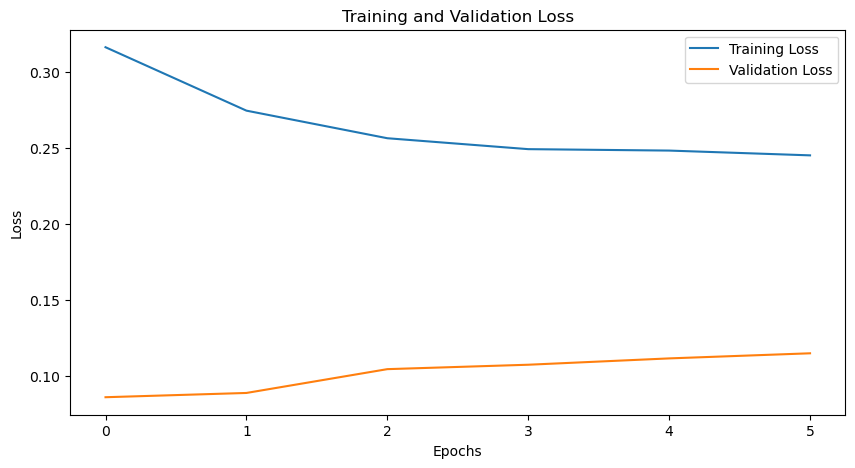

Training for permno_id: 89866
Starting Training...
Epoch 1/10, Training Loss: 0.19162798528042105, Validation Loss: 0.09606279184420903
Epoch 2/10, Training Loss: 0.14049314045243794, Validation Loss: 0.06382383530338605
Epoch 3/10, Training Loss: 0.12024650288124879, Validation Loss: 0.06313935046394666
Epoch 4/10, Training Loss: 0.1133120936445064, Validation Loss: 0.06404049539317687
Epoch 5/10, Training Loss: 0.10927390307188034, Validation Loss: 0.06265060386310022
Epoch 6/10, Training Loss: 0.10682087960756487, Validation Loss: 0.0640535056591034
Epoch 7/10, Training Loss: 0.10601834518214066, Validation Loss: 0.06324751488864422
Epoch 8/10, Training Loss: 0.10452292952686548, Validation Loss: 0.06332641591628392
Epoch 9/10, Training Loss: 0.10430333173523347, Validation Loss: 0.06278302799910307
Epoch 10/10, Training Loss: 0.10333311102456516, Validation Loss: 0.06183345119158427
Training Complete


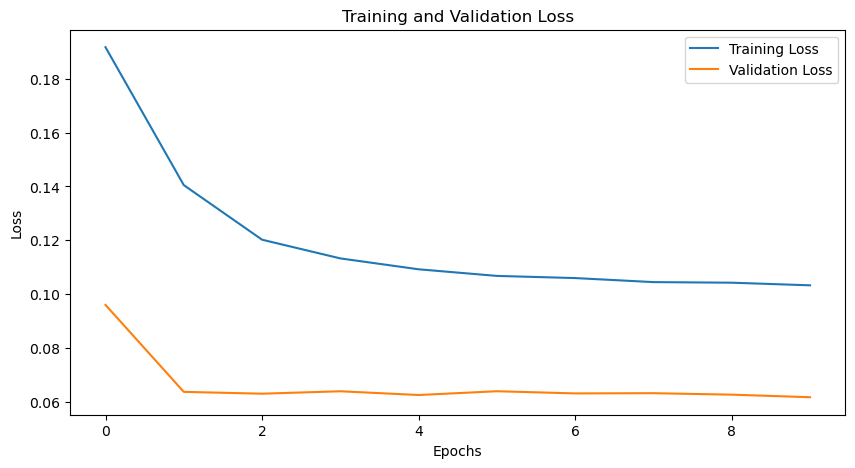

Training for permno_id: 93246
Starting Training...
Epoch 1/10, Training Loss: 0.20864403082264793, Validation Loss: 0.08113517488042514
Epoch 2/10, Training Loss: 0.15741681141985786, Validation Loss: 0.0968884111692508
Epoch 3/10, Training Loss: 0.15168036934402254, Validation Loss: 0.09670584462583065
Epoch 4/10, Training Loss: 0.14766549546685484, Validation Loss: 0.09033873366812865
Epoch 5/10, Training Loss: 0.14499089308083057, Validation Loss: 0.09292569942772388
Epoch 6/10, Training Loss: 0.1439585675381952, Validation Loss: 0.09307265157500903
Early stopping triggered.
Training Complete


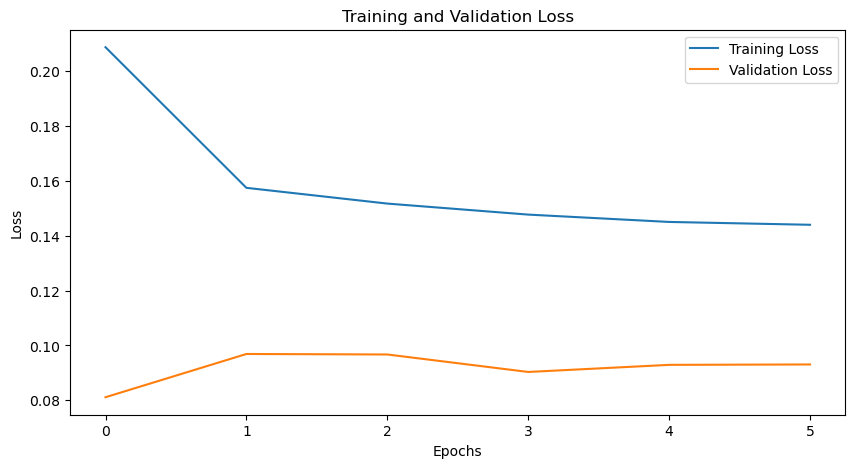

In [83]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=128):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            "sector_weighted_avg_log_return",
            "sector_simple_avg_log_return",
            "weighted_avg_log_return",
            "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Iterate over each unique permno_id in the dataset
unique_permno_ids = train_data["permno_id"].unique()
stock_embeddings = {}

for permno_id in unique_permno_ids[::50]:
    # set_seed(0)  # Set seed for reproducibility
    print(f"Training for permno_id: {permno_id}")

    # Prepare Data
    # dataset = FinancialDataset(first_month_data[:1000])
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
    val_dataset = FinancialDataset(validation_data[:1000])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize Model
    model = TransformerModel(
        input_dim=128 * 5 + 1,
        embed_dim=256,
        n_heads=16,
        ff_dim=1024,
        n_layers=6,
        output_dim=len(train_dataset.target_columns),
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training Loop
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
    criterion = nn.L1Loss()

    # for epoch in range(5):
    #     for batch in dataloader:
    #         optimizer.zero_grad()
    #         output, _ = model(batch["features"])
    #         loss = criterion(output, batch["target"])
    #         # print(f'loss: {loss}')
    #         loss.backward()
    #         optimizer.step()

    # print("Training Complete")

    train_losses = []
    val_losses = []

    num_epochs = 10
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    print("Starting Training...")
    # num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            # print(f'loss: {loss}')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                output, _ = model(batch["features"].to(device))
                loss = criterion(output, batch["target"].to(device))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training Complete")

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Extract embeddings for each stock
    model.eval()
    with torch.no_grad():
        permno_embeddings = []
        for batch in train_dataloader:
            _, embeddings = model(batch["features"].to(device))
            permno_embeddings.extend(embeddings.cpu().numpy())

        # Average the embeddings for this permno_id
        stock_embeddings[permno_id] = np.mean(permno_embeddings, axis=0)

    # Extract embeddings for each stock
    # stock_embeddings = {}
    # model.eval()
    # with torch.no_grad():
    #     for batch in train_dataloader:
    #         _, embeddings = model(batch["features"].to(device))
    #         for i, permno_id in enumerate(batch["permno_id"]):
    #             if permno_id not in stock_embeddings:
    #                 stock_embeddings[permno_id] = []
    #             stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

    # # Average the embeddings for each stock
    # for permno_id in stock_embeddings:
    #     stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [84]:
list(stock_embeddings.items())[:2]

[('10104',
  array([-1.3308574e+00,  4.9793631e-01,  5.2063066e-01, -1.7532238e+00,
         -1.0195408e-01, -8.8134909e-01, -3.4977444e-02,  1.3266706e+00,
         -8.5392201e-01,  2.9907316e-01, -1.2556977e+00,  1.6500483e+00,
         -1.8660921e-01, -1.0426255e+00,  4.8200527e-01, -6.6788733e-02,
          1.4163189e-01, -4.2772412e-01, -7.0525813e-01, -7.6592338e-01,
         -1.1642059e+00, -1.8961463e+00, -5.9219331e-01, -2.3347299e-01,
          5.1120734e-01,  3.0628370e-02,  1.7116416e-01,  9.1531646e-01,
          4.5962732e-02,  2.0502322e+00,  4.5311022e-01, -3.9713064e-01,
          1.6991880e+00,  1.6763556e-01,  4.9252418e-01, -5.6648827e-01,
         -1.5142392e+00,  3.6090899e-01,  5.5763334e-01, -1.6875387e+00,
          3.2547784e-01,  6.4848810e-01,  4.5454291e-01, -1.4713259e+00,
          8.6158907e-01,  3.3589106e-02,  1.5926139e+00, -1.6625011e-01,
          1.1520501e+00,  1.5996665e-01,  5.9116673e-01,  1.5014644e+00,
         -6.3814253e-01,  5.6780624e-01,

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[ 1.0000001e+00,  1.2079656e-02, -1.1269069e-02, -5.0056234e-02,
        -7.0238113e-03, -5.0496928e-02,  1.9227673e-01, -4.5194224e-02,
        -4.4580796e-03,  4.3376442e-02,  3.9951343e-02, -5.7871308e-02],
       [ 1.2079656e-02,  1.0000001e+00, -4.9328420e-02, -6.4717224e-03,
         9.6054070e-02, -1.3134849e-02, -2.3385076e-02,  1.4792792e-01,
        -2.2816034e-02,  8.7838039e-02,  4.7296481e-03,  9.7316705e-02],
       [-1.1269069e-02, -4.9328420e-02,  1.0000002e+00, -5.2807285e-03,
        -1.0513898e-02, -1.6176738e-02, -7.9587735e-02,  8.7971799e-02,
         2.3421099e-02, -3.3721998e-02,  8.9098178e-02, -2.7970372e-02],
       [-5.0056234e-02, -6.4717224e-03, -5.2807285e-03,  1.0000000e+00,
        -2.0630740e-02,  7.2309129e-02,  8.7249249e-02, -6.0076988e-03,
        -1.2548745e-03, -1.3147324e-02, -6.3728839e-02,  1.0510215e-01],
       [-7.0238113e-03,  9.6054070e-02, -1.0513898e-02, -2.0630740e-02,
         9.9999970e-01, -4.1892834e-02,  5.2361049e-02,  4.2

### Model-1 Parallel (Past 7 days 1 feature 1 target)

In [74]:
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, Dataset
# import matplotlib.pyplot as plt
# from multiprocessing import Pool, cpu_count

# class FinancialDataset(Dataset):
#     def __init__(self, data, window_size=7):
#         self.data = data
#         self.window_size = window_size
#         self.input_columns = [
#             "log_return",
#         ]
#         self.target_columns = [
#             "log_return",
#         ]

#         self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
#         self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
#         self.data = self.data.dropna()

#         # Group by permno_id
#         self.groups = self.data.groupby("permno_id")
#         self.sequences = []

#         for name, group in self.groups:
#             j = self.window_size
#             if len(group) > self.window_size:
#                 for i in range(len(group) - self.window_size):
#                     X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
#                     X = np.append(X, j)
#                     j += 1
#                     y = group[self.target_columns].iloc[i + self.window_size].values
#                     self.sequences.append((X, y, name))

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         X, y, permno_id = self.sequences[idx]
#         return {
#             "features": torch.tensor(X, dtype=torch.float),
#             "target": torch.tensor(y, dtype=torch.float),
#             "permno_id": permno_id,
#         }

# class TransformerModel(nn.Module):
#     def __init__(
#         self,
#         input_dim,
#         embed_dim,
#         n_heads,
#         ff_dim,
#         n_layers,
#         output_dim,
#         hidden_dims=[256, 128],
#         dropout=0.25,
#         attn_dropout=0.1,
#         residual_dropout=0.1,
#     ):
#         super(TransformerModel, self).__init__()
#         self.embedding = nn.Linear(input_dim, embed_dim)
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

#         # Adding hidden layers and dropout
#         self.hidden_layers = nn.Sequential(
#             nn.Linear(embed_dim, hidden_dims[0]),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dims[0], hidden_dims[1]),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#         )
#         self.fc = nn.Linear(hidden_dims[1], output_dim)
#         # self.fc = nn.Linear(embed_dim, output_dim)

#     def forward(self, x):
#         x = self.embedding(x)  # Apply embedding layer
#         x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
#         x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
#         embedding = x[:, -1, :]  # Get the last output token

#         # Apply hidden layers
#         x = self.hidden_layers(embedding)
#         x = self.fc(x)
#         # x = self.fc(embedding)  # Fully connected layer on the last output token
#         return x.squeeze(-1), embedding  # Return the final output and the embeddings

# def train_model_for_stock(permno_id):
#     print(f'Training for permno_id: {permno_id}')

#     # Prepare Data
#     train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
#     val_dataset = FinancialDataset(validation_data[validation_data["permno_id"] == permno_id])

#     train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
#     val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#     # Initialize Model
#     model = TransformerModel(
#         input_dim=7 * 1 + 1,
#         embed_dim=256,
#         n_heads=16,
#         ff_dim=1024,
#         n_layers=6,
#         output_dim=len(train_dataset.target_columns),
#         dropout=0.25,
#         attn_dropout=0.1,
#         residual_dropout=0.1,
#     )
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     # Training Loop
#     optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
#     criterion = nn.L1Loss()

#     train_losses = []
#     val_losses = []

#     num_epochs = 10
#     patience = 5
#     best_val_loss = float("inf")
#     patience_counter = 0

#     print("Starting Training...\n")
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for batch in train_dataloader:
#             optimizer.zero_grad()
#             output, _ = model(batch["features"].to(device))
#             loss = criterion(output, batch["target"].to(device))
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         train_losses.append(running_loss / len(train_dataloader))

#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for batch in val_dataloader:
#                 output, _ = model(batch["features"].to(device))
#                 loss = criterion(output, batch["target"].to(device))
#                 val_loss += loss.item()
#         val_losses.append(val_loss / len(val_dataloader))

#         print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

#         # Check for early stopping
#         if val_losses[-1] < best_val_loss:
#             best_val_loss = val_losses[-1]
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping triggered.")
#                 break

#     print("Training Complete")

#     # Extract embeddings for each stock
#     model.eval()
#     with torch.no_grad():
#         permno_embeddings = []
#         for batch in train_dataloader:
#             _, embeddings = model(batch["features"].to(device))
#             permno_embeddings.extend(embeddings.cpu().numpy())

#         # Average the embeddings for this permno_id
#         stock_embeddings = np.mean(permno_embeddings, axis=0)

#     return permno_id, stock_embeddings

# # if __name__ == "__main__":
# #     unique_permno_ids = train_data["permno_id"].unique()
    
# #     # Use multiprocessing to train models in parallel
# #     with Pool(cpu_count()) as pool:
# #         results = pool.map(train_model_for_stock, unique_permno_ids[::50])

# #     # Combine results into a dictionary
# #     stock_embeddings = {permno_id: embedding for permno_id, embedding in results}
    
# #     # Now `stock_embeddings` contains the embeddings for each `permno_id`.
# if __name__ == "__main__":
#     unique_permno_ids = train_data["permno_id"].unique()
#     num_gpus = torch.cuda.device_count()

#     # Use multiprocessing to train models in parallel
#     with Pool(processes=num_gpus) as pool:
#         results = pool.map(train_model_for_stock, [(permno_id, gpu_id % num_gpus) for gpu_id, permno_id in enumerate(unique_permno_ids[::50])])

#     # Combine results into a dictionary
#     stock_embeddings = {permno_id: embedding for permno_id, embedding in results}

#     # Now `stock_embeddings` contains the embeddings for each `permno_id`.

In [73]:
# stock_embeddings

## Model-Compare (L1 loss - sum)

### Case 1: Past 7 days 1 feauture 1 target

Training for permno_id: 10104
Starting Training...
Epoch 1/10, Training Loss: 50.49427162706852, Validation Loss: 10.219830513000488
Epoch 2/10, Training Loss: 31.560938355326652, Validation Loss: 16.575354258219402
Epoch 3/10, Training Loss: 25.968006274849177, Validation Loss: 18.688575744628906
Epoch 4/10, Training Loss: 23.69269347190857, Validation Loss: 16.258273760477703
Epoch 5/10, Training Loss: 22.325516068935393, Validation Loss: 16.50648562113444
Epoch 6/10, Training Loss: 20.545820976793767, Validation Loss: 15.218975385030111
Early stopping triggered.
Training Complete


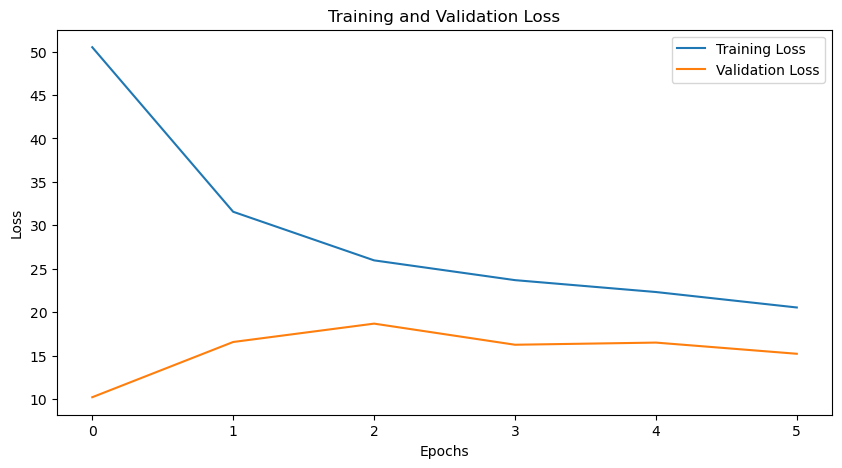

Training for permno_id: 13688
Starting Training...
Epoch 1/10, Training Loss: 73.12691653966904, Validation Loss: 28.05544598897298
Epoch 2/10, Training Loss: 41.464120449125765, Validation Loss: 19.899023056030273
Epoch 3/10, Training Loss: 35.93373354226351, Validation Loss: 19.46563720703125
Epoch 4/10, Training Loss: 33.470092949271205, Validation Loss: 17.200125694274902
Epoch 5/10, Training Loss: 32.64193470403552, Validation Loss: 20.265740712483723
Epoch 6/10, Training Loss: 31.545044855773448, Validation Loss: 13.846684455871582
Epoch 7/10, Training Loss: 30.95744285881519, Validation Loss: 17.598012288411457
Epoch 8/10, Training Loss: 30.845531901717187, Validation Loss: 23.01862335205078
Epoch 9/10, Training Loss: 30.438321327418087, Validation Loss: 17.72616195678711
Epoch 10/10, Training Loss: 29.708302149176596, Validation Loss: 17.10522206624349
Training Complete


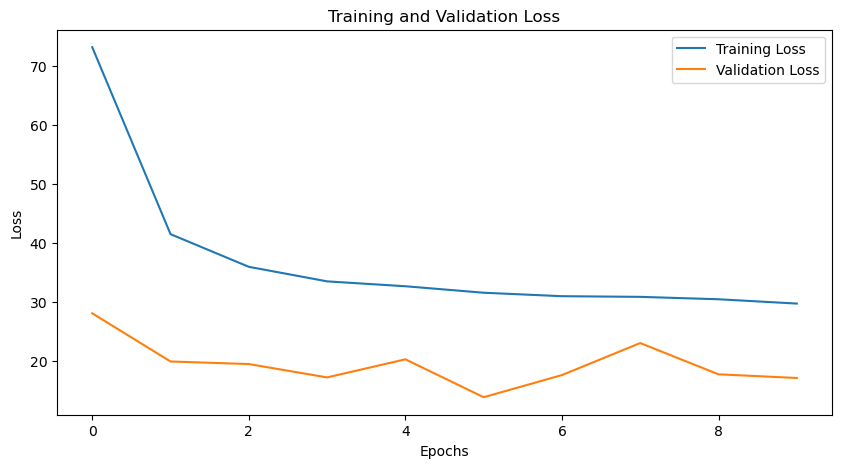

Training for permno_id: 17005
Starting Training...
Epoch 1/10, Training Loss: 69.62491962909698, Validation Loss: 14.591842333475748
Epoch 2/10, Training Loss: 33.20461977273226, Validation Loss: 13.182140032450357
Epoch 3/10, Training Loss: 26.497123041003942, Validation Loss: 11.000537236531576
Epoch 4/10, Training Loss: 23.24216545820236, Validation Loss: 16.622887293497723
Epoch 5/10, Training Loss: 20.87868213355541, Validation Loss: 15.813959121704102
Epoch 6/10, Training Loss: 19.51126099228859, Validation Loss: 18.619876225789387
Epoch 7/10, Training Loss: 18.664662546664477, Validation Loss: 17.867815335591633
Epoch 8/10, Training Loss: 18.303296049684285, Validation Loss: 19.298195521036785
Early stopping triggered.
Training Complete


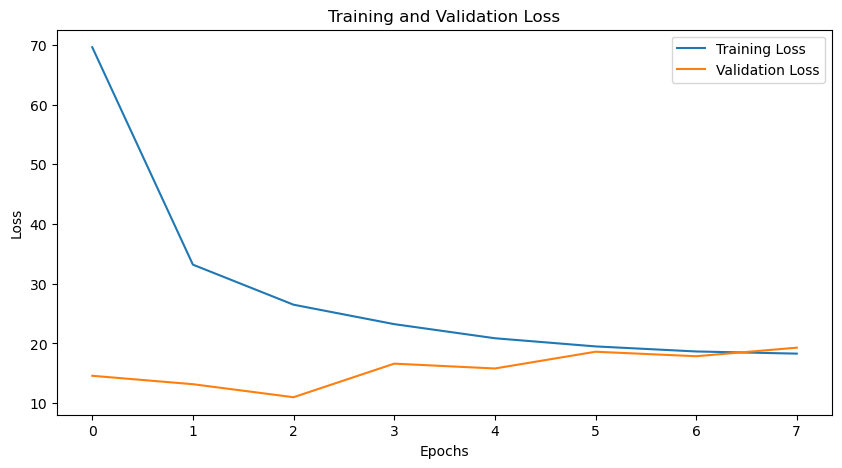

Training for permno_id: 21936
Starting Training...
Epoch 1/10, Training Loss: 37.79543023705482, Validation Loss: 12.283438682556152
Epoch 2/10, Training Loss: 27.86455199122429, Validation Loss: 24.00938669840495
Epoch 3/10, Training Loss: 24.487619797512888, Validation Loss: 16.94046433766683
Epoch 4/10, Training Loss: 22.431023666262625, Validation Loss: 24.84991709391276
Epoch 5/10, Training Loss: 20.326694111153483, Validation Loss: 20.398631413777668
Epoch 6/10, Training Loss: 19.122490464150907, Validation Loss: 20.85290018717448
Early stopping triggered.
Training Complete


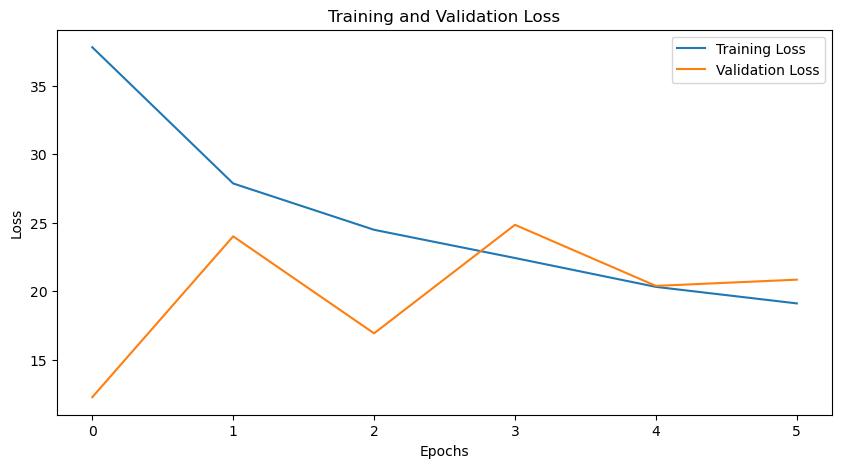

Training for permno_id: 30681
Starting Training...
Epoch 1/10, Training Loss: 58.51808091700077, Validation Loss: 17.085803349812824
Epoch 2/10, Training Loss: 33.10389486253261, Validation Loss: 9.806892077128092
Epoch 3/10, Training Loss: 26.81011185348034, Validation Loss: 10.151459376017252
Epoch 4/10, Training Loss: 23.467028070241213, Validation Loss: 10.134454091389975
Epoch 5/10, Training Loss: 20.634452747926115, Validation Loss: 10.01435661315918
Epoch 6/10, Training Loss: 18.69534618407488, Validation Loss: 9.844053268432617
Epoch 7/10, Training Loss: 17.15933965817094, Validation Loss: 9.801680564880371
Epoch 8/10, Training Loss: 16.15984984487295, Validation Loss: 10.05056635538737
Epoch 9/10, Training Loss: 15.680390530079602, Validation Loss: 9.962937037150065
Epoch 10/10, Training Loss: 15.206330655515194, Validation Loss: 9.819165547688803
Training Complete


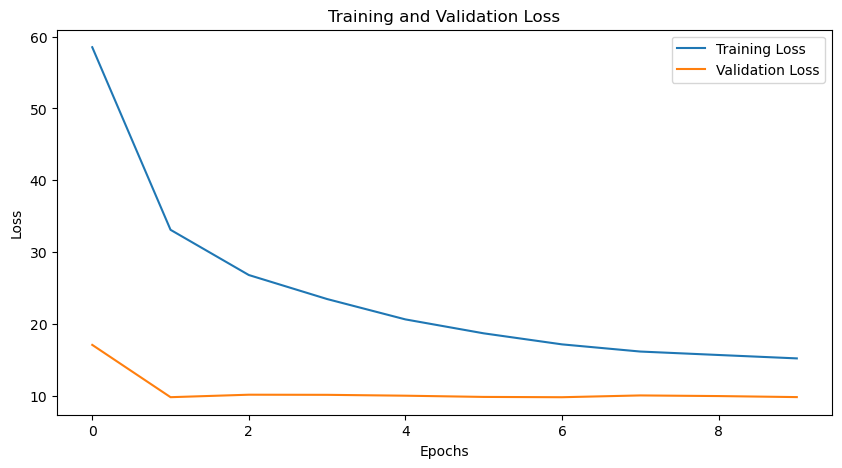

Training for permno_id: 50876
Starting Training...
Epoch 1/10, Training Loss: 128.6824467882514, Validation Loss: 16.868195215861004
Epoch 2/10, Training Loss: 32.77241052314639, Validation Loss: 10.362008094787598
Epoch 3/10, Training Loss: 24.3778814047575, Validation Loss: 10.080581982930502
Epoch 4/10, Training Loss: 20.38635215163231, Validation Loss: 12.253592809041342
Epoch 5/10, Training Loss: 18.551624942570925, Validation Loss: 14.331744511922201
Epoch 6/10, Training Loss: 16.993335467204453, Validation Loss: 13.481228510538736
Epoch 7/10, Training Loss: 16.191774320974947, Validation Loss: 13.279622713724772
Epoch 8/10, Training Loss: 15.80031962543726, Validation Loss: 13.684232393900553
Early stopping triggered.
Training Complete


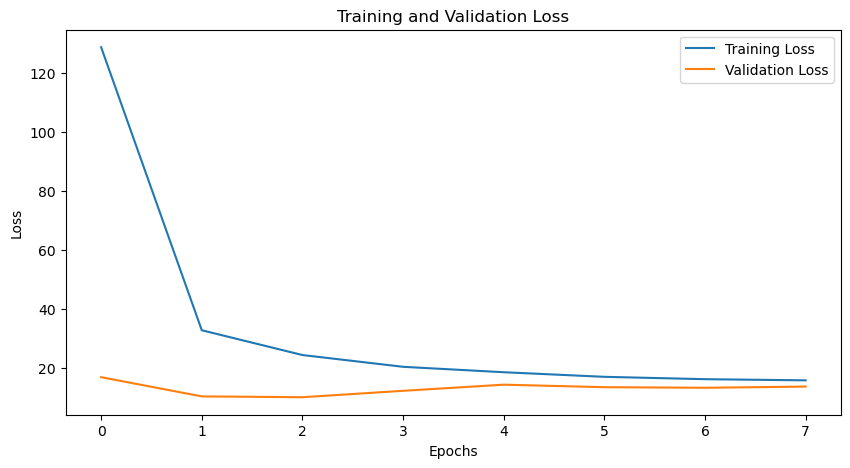

Training for permno_id: 64653
Starting Training...
Epoch 1/10, Training Loss: 43.37929224818945, Validation Loss: 10.04834016164144
Epoch 2/10, Training Loss: 24.071944982558488, Validation Loss: 11.303706169128418
Epoch 3/10, Training Loss: 20.151267586648466, Validation Loss: 9.78462028503418
Epoch 4/10, Training Loss: 17.83464080542326, Validation Loss: 10.17800203959147
Epoch 5/10, Training Loss: 16.34019445516169, Validation Loss: 9.891839345296225
Epoch 6/10, Training Loss: 15.67770400568843, Validation Loss: 10.578089078267416
Epoch 7/10, Training Loss: 15.103094926476478, Validation Loss: 10.241555531819662
Epoch 8/10, Training Loss: 14.431682951003314, Validation Loss: 11.43692429860433
Early stopping triggered.
Training Complete


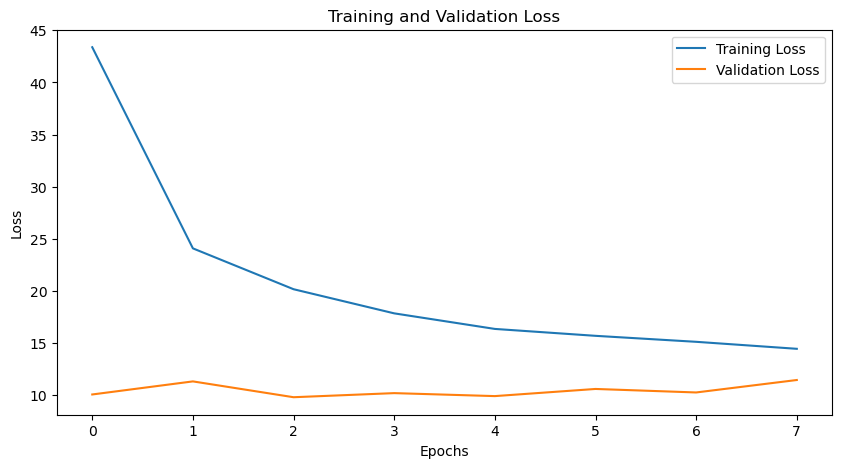

Training for permno_id: 77274
Starting Training...
Epoch 1/10, Training Loss: 60.98162306547165, Validation Loss: 9.717317581176758
Epoch 2/10, Training Loss: 26.45442925840616, Validation Loss: 19.39310646057129
Epoch 3/10, Training Loss: 21.79889473468065, Validation Loss: 11.214053789774576
Epoch 4/10, Training Loss: 20.707971400022508, Validation Loss: 11.77320671081543
Epoch 5/10, Training Loss: 19.300686898827554, Validation Loss: 15.383601506551107
Epoch 6/10, Training Loss: 18.02308348864317, Validation Loss: 14.328709284464518
Early stopping triggered.
Training Complete


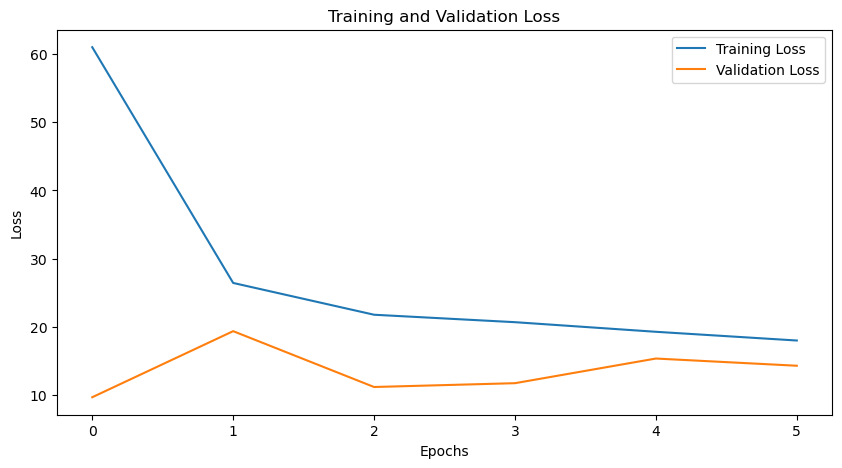

Training for permno_id: 81774
Starting Training...
Epoch 1/10, Training Loss: 108.03257349580527, Validation Loss: 28.322357813517254
Epoch 2/10, Training Loss: 44.63189744204283, Validation Loss: 19.485328674316406
Epoch 3/10, Training Loss: 36.83010754436255, Validation Loss: 19.30670992533366
Epoch 4/10, Training Loss: 33.02634501382708, Validation Loss: 16.901469866434734
Epoch 5/10, Training Loss: 30.940242093801498, Validation Loss: 18.549755096435547
Epoch 6/10, Training Loss: 29.619664736837148, Validation Loss: 17.322017669677734
Epoch 7/10, Training Loss: 28.98858302012086, Validation Loss: 18.34806760152181
Epoch 8/10, Training Loss: 28.332543160021306, Validation Loss: 18.79722277323405
Epoch 9/10, Training Loss: 28.33621482849121, Validation Loss: 21.80489985148112
Early stopping triggered.
Training Complete


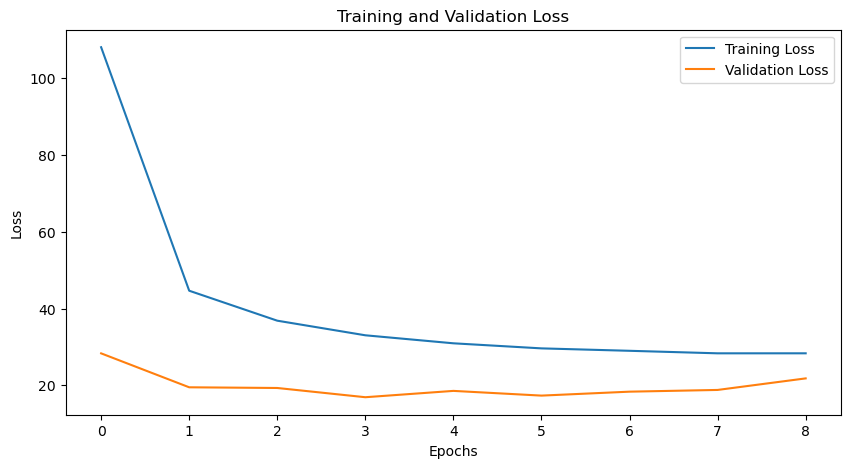

Training for permno_id: 86745
Starting Training...
Epoch 1/10, Training Loss: 63.40851188898087, Validation Loss: 23.395771662394207
Epoch 2/10, Training Loss: 35.56477839499712, Validation Loss: 17.776214599609375
Epoch 3/10, Training Loss: 32.66253651231527, Validation Loss: 18.993079503377277
Epoch 4/10, Training Loss: 30.583335909992456, Validation Loss: 18.741957664489746
Epoch 5/10, Training Loss: 29.14413602128625, Validation Loss: 13.399415651957193
Epoch 6/10, Training Loss: 28.232081476598978, Validation Loss: 10.86163584391276
Epoch 7/10, Training Loss: 27.90740140080452, Validation Loss: 11.531569480895996
Epoch 8/10, Training Loss: 27.534291297197342, Validation Loss: 10.903228441874186
Epoch 9/10, Training Loss: 27.34906325340271, Validation Loss: 11.90872859954834
Epoch 10/10, Training Loss: 27.244917619228364, Validation Loss: 12.02454694112142
Training Complete


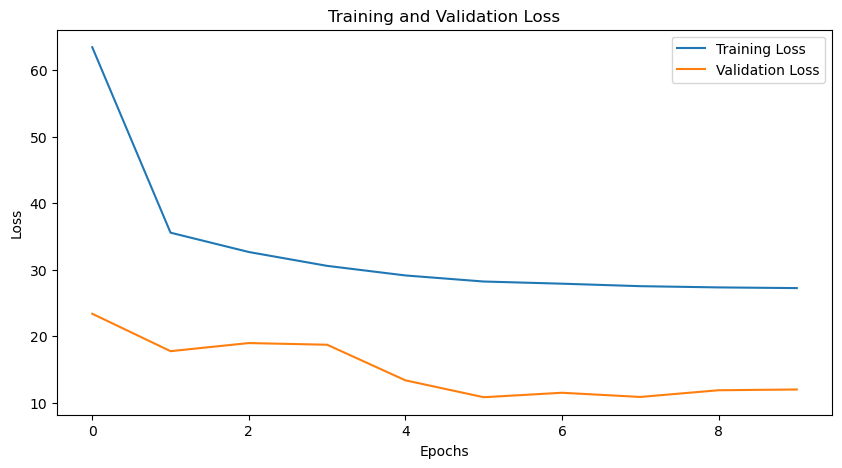

Training for permno_id: 89866
Starting Training...
Epoch 1/10, Training Loss: 65.75995093882084, Validation Loss: 10.303268114725748
Epoch 2/10, Training Loss: 31.682609572261573, Validation Loss: 10.276396115620932
Epoch 3/10, Training Loss: 26.174994375556707, Validation Loss: 12.785572052001953
Epoch 4/10, Training Loss: 23.90018873512745, Validation Loss: 12.544269561767578
Epoch 5/10, Training Loss: 22.011256051063537, Validation Loss: 15.499465624491373
Epoch 6/10, Training Loss: 21.205884547159076, Validation Loss: 14.601524353027344
Epoch 7/10, Training Loss: 20.565390661358833, Validation Loss: 13.716972668965658
Early stopping triggered.
Training Complete


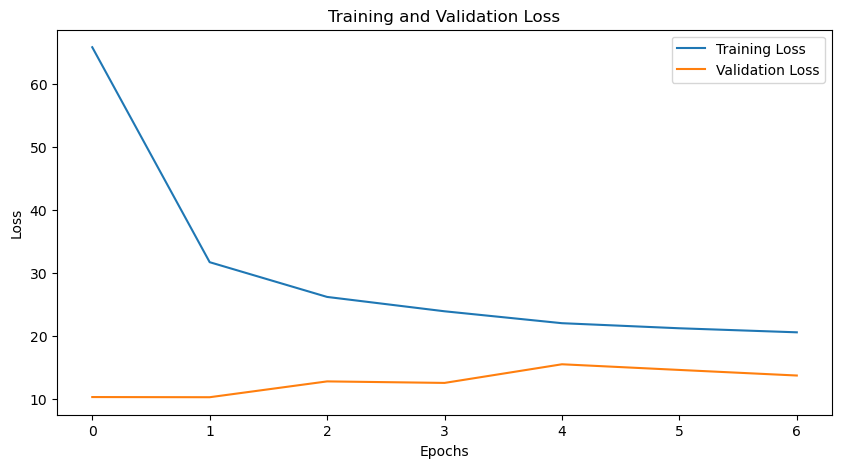

Training for permno_id: 93246
Starting Training...
Epoch 1/10, Training Loss: 64.00233046710491, Validation Loss: 11.703440348307291
Epoch 2/10, Training Loss: 32.97191062569618, Validation Loss: 10.42929744720459
Epoch 3/10, Training Loss: 27.856015411019325, Validation Loss: 11.788599332173666
Epoch 4/10, Training Loss: 25.449578721821307, Validation Loss: 10.897041320800781
Epoch 5/10, Training Loss: 24.449008794873954, Validation Loss: 10.743753433227539
Epoch 6/10, Training Loss: 23.764625702798366, Validation Loss: 9.73698361714681
Epoch 7/10, Training Loss: 23.43884268477559, Validation Loss: 9.720325152079264
Epoch 8/10, Training Loss: 23.048865450918676, Validation Loss: 9.684795379638672
Epoch 9/10, Training Loss: 22.912631314992904, Validation Loss: 10.16479237874349
Epoch 10/10, Training Loss: 22.789759789407253, Validation Loss: 9.685246149698893
Training Complete


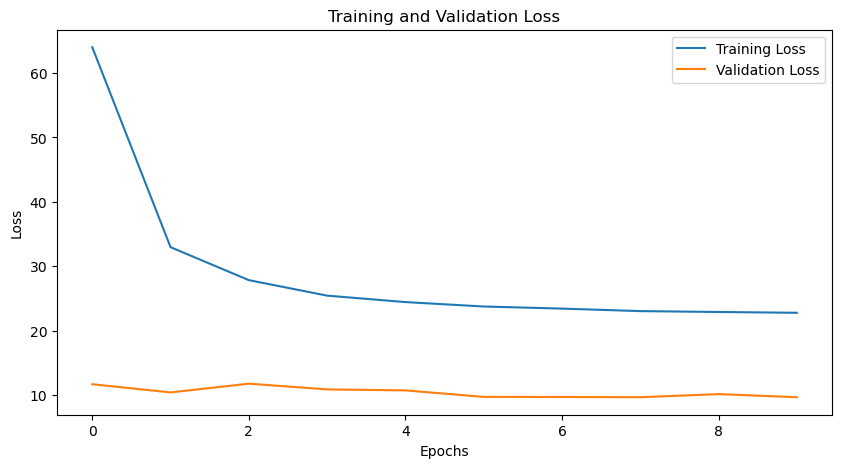

In [77]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings


# Iterate over each unique permno_id in the dataset
unique_permno_ids = train_data["permno_id"].unique()
stock_embeddings = {}

for permno_id in unique_permno_ids[::50]:
    # set_seed(0)  # Set seed for reproducibility
    print(f"Training for permno_id: {permno_id}")

    # Prepare Data
    # dataset = FinancialDataset(first_month_data[:1000])
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
    val_dataset = FinancialDataset(validation_data[:100])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize Model
    model = TransformerModel(
        input_dim=7 * 1 + 1,
        embed_dim=256,
        n_heads=16,
        ff_dim=1024,
        n_layers=6,
        output_dim=len(train_dataset.target_columns),
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training Loop
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
    criterion = nn.L1Loss(reduction='sum')

    # for epoch in range(5):
    #     for batch in dataloader:
    #         optimizer.zero_grad()
    #         output, _ = model(batch["features"])
    #         loss = criterion(output, batch["target"])
    #         # print(f'loss: {loss}')
    #         loss.backward()
    #         optimizer.step()

    # print("Training Complete")

    train_losses = []
    val_losses = []

    num_epochs = 10
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    print("Starting Training...")
    # num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            # print(f'loss: {loss}')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                output, _ = model(batch["features"].to(device))
                loss = criterion(output, batch["target"].to(device))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training Complete")

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Extract embeddings for each stock
    model.eval()
    with torch.no_grad():
        permno_embeddings = []
        for batch in train_dataloader:
            _, embeddings = model(batch["features"].to(device))
            permno_embeddings.extend(embeddings.cpu().numpy())

        # Average the embeddings for this permno_id
        stock_embeddings[permno_id] = np.mean(permno_embeddings, axis=0)

    # Extract embeddings for each stock
    # stock_embeddings = {}
    # model.eval()
    # with torch.no_grad():
    #     for batch in train_dataloader:
    #         _, embeddings = model(batch["features"].to(device))
    #         for i, permno_id in enumerate(batch["permno_id"]):
    #             if permno_id not in stock_embeddings:
    #                 stock_embeddings[permno_id] = []
    #             stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

    # # Average the embeddings for each stock
    # for permno_id in stock_embeddings:
    #     stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [78]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 1.4679099 , -0.6393276 ,  0.51274115,  0.20088835, -0.24918906,
         -1.1396297 , -0.1835109 , -1.0543305 ,  0.49434736, -0.15360859,
          0.08477564,  0.08825059, -0.38857076, -0.36600226,  0.5907614 ,
          0.67415464,  0.40204856, -0.68206745, -0.5394311 , -1.0190276 ,
         -0.8022321 ,  2.5033007 ,  0.66585016, -0.96185154, -0.07277206,
         -1.909091  , -0.05304163,  0.05278431,  1.0599045 ,  1.2572175 ,
         -0.72124016,  0.04700192,  0.8426882 , -1.0144519 ,  0.87293434,
         -0.42518702, -0.07649333, -0.45892328,  0.12412556, -0.08528827,
         -0.85817206, -0.01900641,  0.8685433 ,  0.5344392 ,  0.75730634,
          0.90239125, -0.6511082 ,  0.4456458 ,  2.438253  , -0.38667825,
          0.6746461 ,  1.4776973 ,  0.17489068,  0.24332076, -2.6396756 ,
         -0.8461523 ,  1.1572754 ,  0.99755204, -1.6511973 ,  0.00638022,
         -0.20000257, -1.1586794 ,  1.2357861 , -0.74111   , -1.1515793 ,
          0.2127975 , -0.05

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[ 1.00000036e+00,  1.06671453e-02, -4.70991246e-02,
        -1.66849166e-01,  2.07217485e-02, -3.56140621e-02,
        -3.33671980e-02,  1.13316989e-02, -2.11538561e-02,
        -9.92550049e-03, -8.54009949e-03,  2.61263526e-03],
       [ 1.06671453e-02,  1.00000000e+00, -3.81868854e-02,
         1.11880759e-02,  1.39770340e-02, -7.21541196e-02,
         6.45842925e-02, -3.28079751e-03,  6.01446396e-03,
         1.88851692e-02, -8.90847817e-02,  2.21409611e-02],
       [-4.70991246e-02, -3.81868854e-02,  1.00000060e+00,
         3.14116627e-02,  3.53748389e-02, -4.65859333e-03,
        -4.22956310e-02,  1.17557392e-01,  9.98912081e-02,
         6.64548366e-04,  2.10589655e-02, -3.89333293e-02],
       [-1.66849166e-01,  1.11880759e-02,  3.14116627e-02,
         9.99999821e-01,  4.38918695e-02,  9.46403369e-02,
         8.94701183e-02, -5.99052086e-02, -1.32679315e-02,
         5.82499020e-02,  2.01727804e-02, -1.54163525e-01],
       [ 2.07217485e-02,  1.39770340e-02,  3.5374838

## Model-Compare (L1 loss - sum&average)

### Case 1: Past 7 days 1 feauture 1 target

Training for permno_id: 10104
Starting Training...
Epoch 1/10, Training Loss: 2.0139861322939394, Validation Loss: 1.7646363973617554
Epoch 2/10, Training Loss: 1.5443913292139768, Validation Loss: 1.189163088798523
Epoch 3/10, Training Loss: 1.1515098161995412, Validation Loss: 0.3260045846303304
Epoch 4/10, Training Loss: 0.8381745167076587, Validation Loss: 0.41516487797101337
Epoch 5/10, Training Loss: 0.6970043820794671, Validation Loss: 0.3623649577299754
Epoch 6/10, Training Loss: 0.6131806593388319, Validation Loss: 0.3205530047416687
Epoch 7/10, Training Loss: 0.548851016908884, Validation Loss: 0.31407033403714496
Epoch 8/10, Training Loss: 0.5181689383462071, Validation Loss: 0.3192145327727
Epoch 9/10, Training Loss: 0.48727023117244245, Validation Loss: 0.3245712121327718
Epoch 10/10, Training Loss: 0.4803227074444294, Validation Loss: 0.3168037136395772
Training Complete


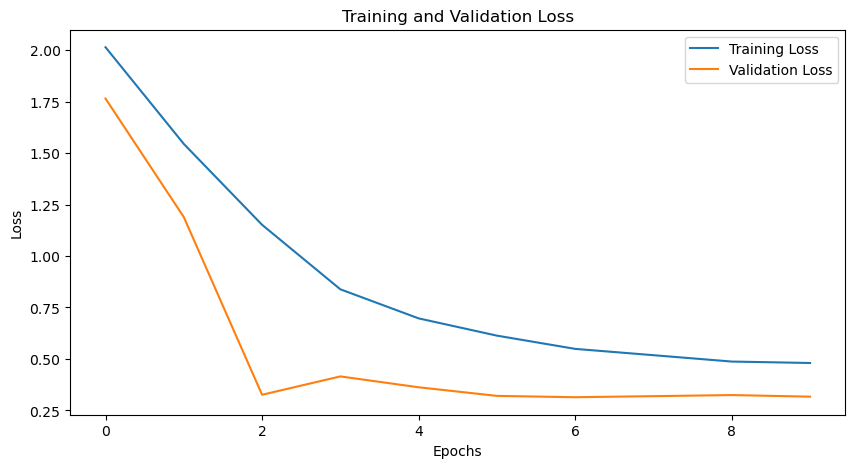

Training for permno_id: 13688
Starting Training...
Epoch 1/10, Training Loss: 2.069258726388216, Validation Loss: 0.3980872432390849
Epoch 2/10, Training Loss: 1.5568963322788476, Validation Loss: 0.5385547478993734
Epoch 3/10, Training Loss: 1.2129801427945495, Validation Loss: 0.493405153354009
Epoch 4/10, Training Loss: 1.0631439339369535, Validation Loss: 0.38278093934059143
Epoch 5/10, Training Loss: 0.9876112900674343, Validation Loss: 0.31253841519355774
Epoch 6/10, Training Loss: 0.949325493350625, Validation Loss: 0.3478679557641347
Epoch 7/10, Training Loss: 0.9254529595375061, Validation Loss: 0.31346169114112854
Epoch 8/10, Training Loss: 0.9012711673974991, Validation Loss: 0.31301116943359375
Epoch 9/10, Training Loss: 0.8976113827899098, Validation Loss: 0.312138964732488
Epoch 10/10, Training Loss: 0.8961403513327241, Validation Loss: 0.3193933963775635
Training Complete


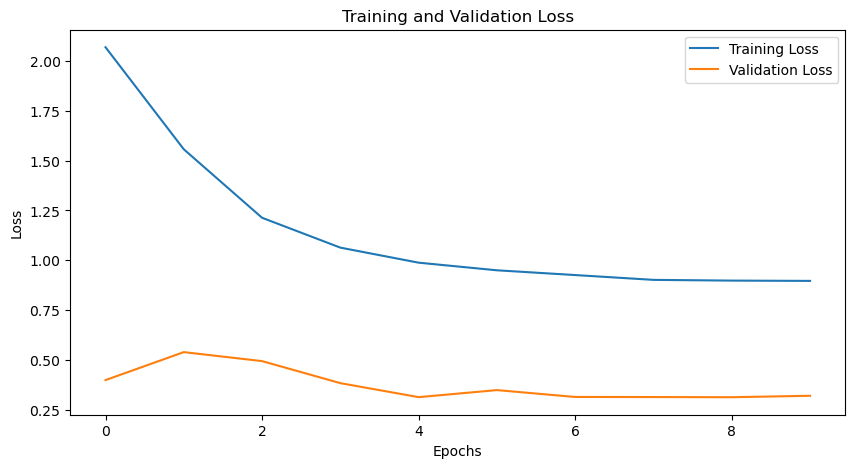

Training for permno_id: 17005
Starting Training...
Epoch 1/10, Training Loss: 2.243984456732869, Validation Loss: 0.514410525560379
Epoch 2/10, Training Loss: 1.5708161532878875, Validation Loss: 0.3921160201231639
Epoch 3/10, Training Loss: 1.20054228939116, Validation Loss: 0.31250303983688354
Epoch 4/10, Training Loss: 0.9244989667087793, Validation Loss: 0.3206566373507182
Epoch 5/10, Training Loss: 0.7782886439934373, Validation Loss: 0.486197551091512
Epoch 6/10, Training Loss: 0.713400505669415, Validation Loss: 0.43989563981692
Epoch 7/10, Training Loss: 0.6634886525571346, Validation Loss: 0.4823117752869924
Epoch 8/10, Training Loss: 0.6544608859345317, Validation Loss: 0.43176954984664917
Early stopping triggered.
Training Complete


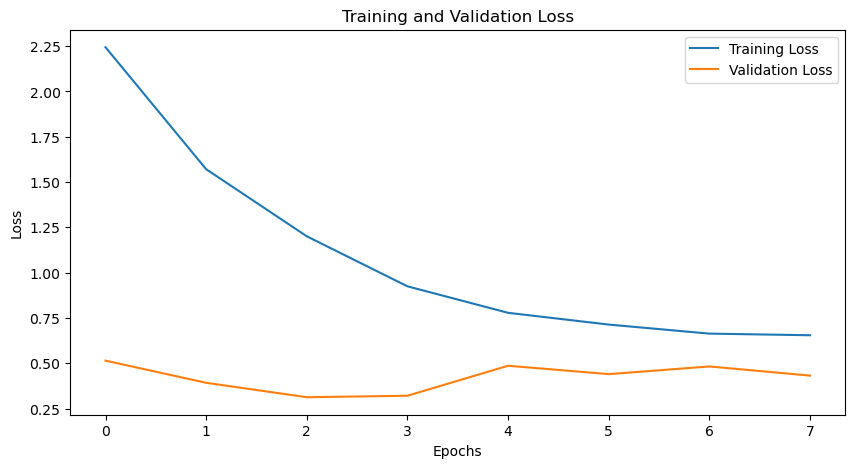

Training for permno_id: 21936
Starting Training...
Epoch 1/10, Training Loss: 2.0783194031566383, Validation Loss: 0.6927822430928549
Epoch 2/10, Training Loss: 1.5147465489804746, Validation Loss: 0.4936722715695699
Epoch 3/10, Training Loss: 1.1306882329285144, Validation Loss: 0.360018531481425
Epoch 4/10, Training Loss: 0.9435687027871609, Validation Loss: 0.3917962908744812
Epoch 5/10, Training Loss: 0.7886265333741903, Validation Loss: 0.42879419525464374
Epoch 6/10, Training Loss: 0.6928140047937632, Validation Loss: 0.39060041308403015
Epoch 7/10, Training Loss: 0.6461446769535542, Validation Loss: 0.34521738688151044
Epoch 8/10, Training Loss: 0.5944259911775589, Validation Loss: 0.5145095984141032
Epoch 9/10, Training Loss: 0.5720007605850697, Validation Loss: 0.4232183297475179
Epoch 10/10, Training Loss: 0.5649723834358156, Validation Loss: 0.4263802468776703
Training Complete


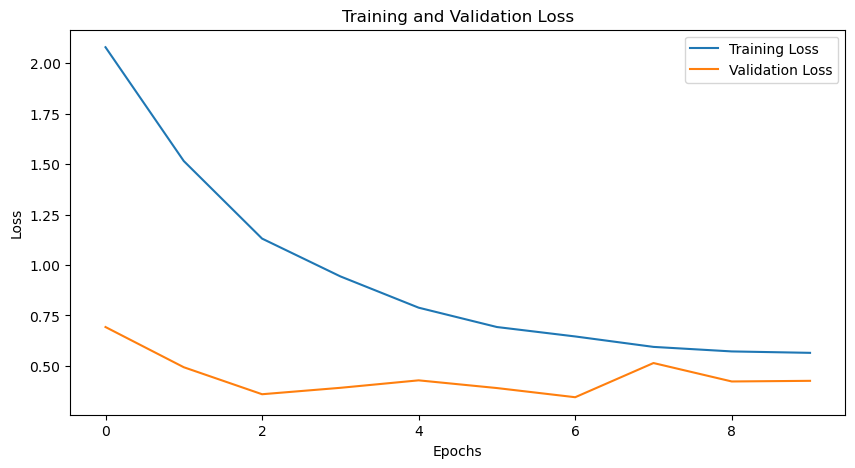

Training for permno_id: 30681
Starting Training...
Epoch 1/10, Training Loss: 2.1829648938030006, Validation Loss: 0.3851599097251892
Epoch 2/10, Training Loss: 1.6227117367088795, Validation Loss: 0.4911183814207713
Epoch 3/10, Training Loss: 1.1312382802367211, Validation Loss: 0.3131184975306193
Epoch 4/10, Training Loss: 0.8120440194383264, Validation Loss: 0.31730619072914124
Epoch 5/10, Training Loss: 0.6596780328080059, Validation Loss: 0.4238325854142507
Epoch 6/10, Training Loss: 0.5794121772050858, Validation Loss: 0.3976047933101654
Epoch 7/10, Training Loss: 0.5594985956326127, Validation Loss: 0.35113925735155743
Epoch 8/10, Training Loss: 0.5556844813749194, Validation Loss: 0.41982752084732056
Early stopping triggered.
Training Complete


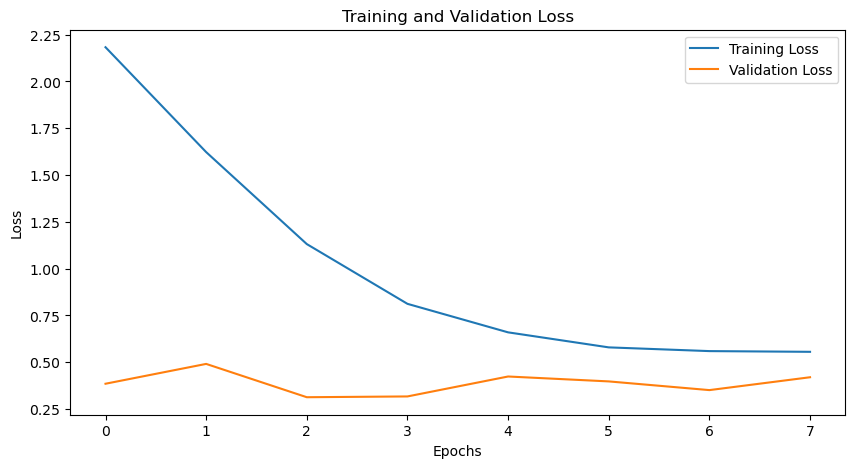

Training for permno_id: 50876
Starting Training...
Epoch 1/10, Training Loss: 1.847964259237051, Validation Loss: 0.3959745466709137
Epoch 2/10, Training Loss: 1.307651980407536, Validation Loss: 0.5663520594437917
Epoch 3/10, Training Loss: 0.9257395923137665, Validation Loss: 0.3642149567604065
Epoch 4/10, Training Loss: 0.7852444358170032, Validation Loss: 0.4439651668071747
Epoch 5/10, Training Loss: 0.684055282920599, Validation Loss: 0.5736611286799113
Epoch 6/10, Training Loss: 0.6269236389547587, Validation Loss: 0.49780623118082684
Epoch 7/10, Training Loss: 0.6111635820940137, Validation Loss: 0.5045288701852163
Epoch 8/10, Training Loss: 0.586986945103854, Validation Loss: 0.46758899092674255
Early stopping triggered.
Training Complete


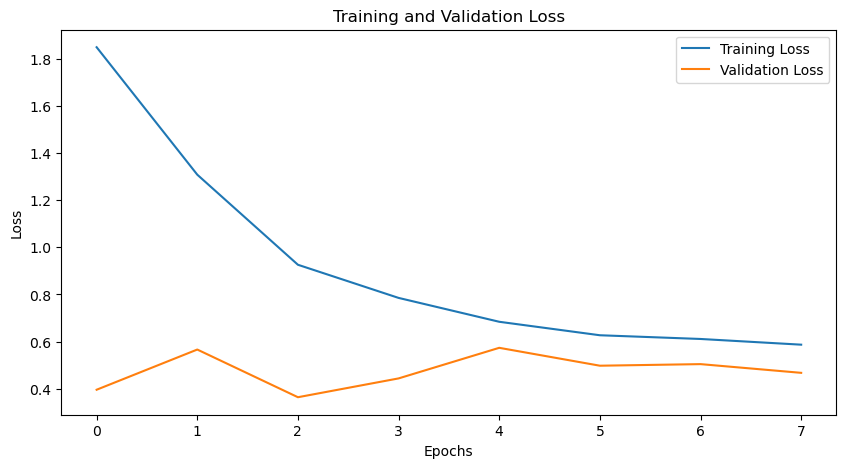

Training for permno_id: 64653
Starting Training...
Epoch 1/10, Training Loss: 1.840641725063324, Validation Loss: 0.5968406597773234
Epoch 2/10, Training Loss: 1.2211699342355131, Validation Loss: 0.46484850843747455
Epoch 3/10, Training Loss: 0.9650183830410242, Validation Loss: 0.42845116058985394
Epoch 4/10, Training Loss: 0.7495562266558409, Validation Loss: 0.3383602996667226
Epoch 5/10, Training Loss: 0.6422632383182645, Validation Loss: 0.3426665961742401
Epoch 6/10, Training Loss: 0.5763221278786659, Validation Loss: 0.3617119292418162
Epoch 7/10, Training Loss: 0.5431309968233109, Validation Loss: 0.3772275745868683
Epoch 8/10, Training Loss: 0.527969628944993, Validation Loss: 0.392877459526062
Epoch 9/10, Training Loss: 0.5092442596331239, Validation Loss: 0.4003385504086812
Early stopping triggered.
Training Complete


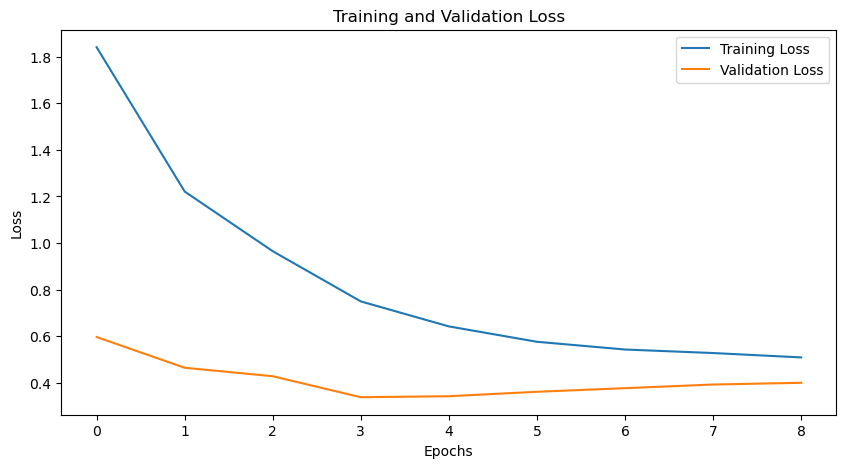

Training for permno_id: 77274
Starting Training...
Epoch 1/10, Training Loss: 2.2497071966528894, Validation Loss: 0.4683203895886739
Epoch 2/10, Training Loss: 1.598536651954055, Validation Loss: 0.41679741938908893
Epoch 3/10, Training Loss: 1.0923148160800338, Validation Loss: 0.32304439942042035
Epoch 4/10, Training Loss: 0.8646925734356046, Validation Loss: 0.8597706953684489
Epoch 5/10, Training Loss: 0.7534442074596882, Validation Loss: 0.5949485898017883
Epoch 6/10, Training Loss: 0.6939518578350544, Validation Loss: 0.46317803859710693
Epoch 7/10, Training Loss: 0.641404091194272, Validation Loss: 0.5419045587380728
Epoch 8/10, Training Loss: 0.6152153881266713, Validation Loss: 0.3965420126914978
Early stopping triggered.
Training Complete


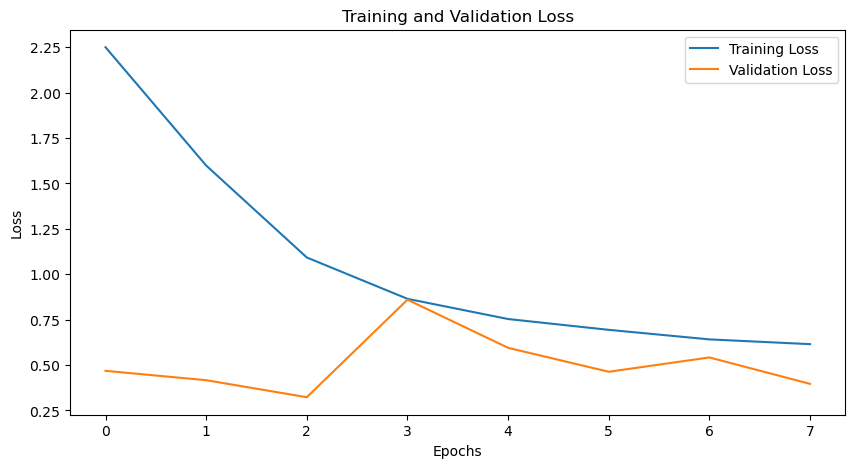

Training for permno_id: 81774
Starting Training...
Epoch 1/10, Training Loss: 1.8363995648920537, Validation Loss: 0.5438641607761383
Epoch 2/10, Training Loss: 1.343461507000029, Validation Loss: 0.4035292665163676
Epoch 3/10, Training Loss: 1.078003504499793, Validation Loss: 0.5021484990914663
Epoch 4/10, Training Loss: 0.9620124898850918, Validation Loss: 0.46315223972002667
Epoch 5/10, Training Loss: 0.9232519052922725, Validation Loss: 0.487829327583313
Epoch 6/10, Training Loss: 0.8833874577656389, Validation Loss: 0.41219021876653034
Epoch 7/10, Training Loss: 0.8594983544200658, Validation Loss: 0.4835065205891927
Early stopping triggered.
Training Complete


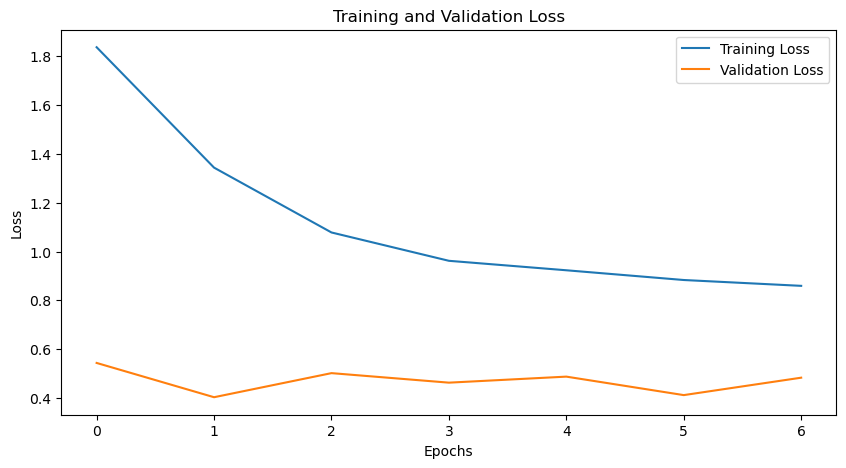

Training for permno_id: 86745
Starting Training...
Epoch 1/10, Training Loss: 2.289575503021479, Validation Loss: 0.4068619906902313
Epoch 2/10, Training Loss: 1.7055031314492226, Validation Loss: 0.5460801819960276
Epoch 3/10, Training Loss: 1.2701418593525886, Validation Loss: 0.5783212184906006
Epoch 4/10, Training Loss: 1.086418966203928, Validation Loss: 0.6657273372014364
Epoch 5/10, Training Loss: 1.014969046227634, Validation Loss: 0.8191205660502116
Epoch 6/10, Training Loss: 0.9831740453839302, Validation Loss: 0.8588664531707764
Early stopping triggered.
Training Complete


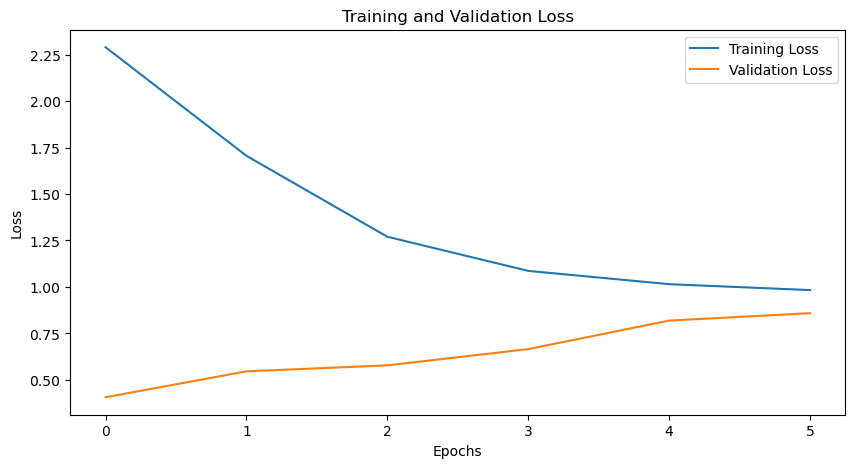

Training for permno_id: 89866
Starting Training...
Epoch 1/10, Training Loss: 2.0083116494119166, Validation Loss: 0.33684346079826355
Epoch 2/10, Training Loss: 1.3776552125811576, Validation Loss: 0.4961450695991516
Epoch 3/10, Training Loss: 1.0173575647175312, Validation Loss: 0.34606197476387024
Epoch 4/10, Training Loss: 0.8463909406214952, Validation Loss: 0.36130810777346295
Epoch 5/10, Training Loss: 0.7531667324714363, Validation Loss: 0.54548579454422
Epoch 6/10, Training Loss: 0.7130698893219233, Validation Loss: 0.34735555450121564
Early stopping triggered.
Training Complete


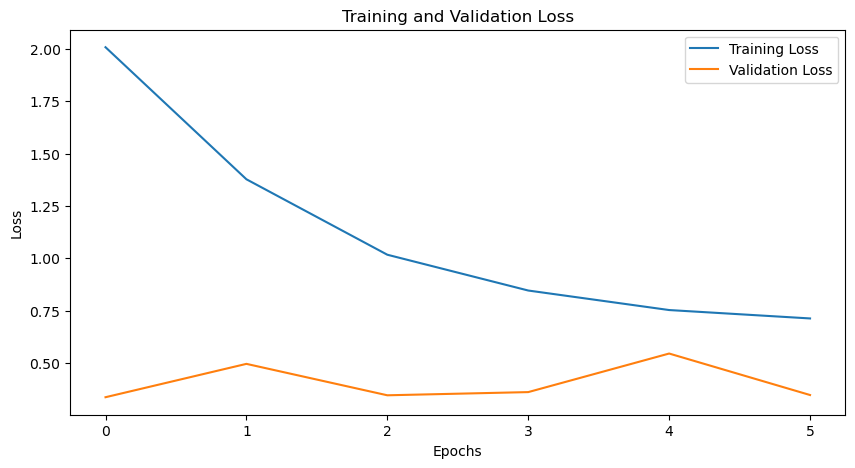

Training for permno_id: 93246
Starting Training...
Epoch 1/10, Training Loss: 2.1842676982283593, Validation Loss: 1.433108647664388
Epoch 2/10, Training Loss: 1.5790509654209017, Validation Loss: 0.4050680498282115
Epoch 3/10, Training Loss: 1.1656249765306712, Validation Loss: 0.568709005912145
Epoch 4/10, Training Loss: 1.0004789397120475, Validation Loss: 0.7563393910725912
Epoch 5/10, Training Loss: 0.9162194790318609, Validation Loss: 0.7861281633377075
Epoch 6/10, Training Loss: 0.8792448401451111, Validation Loss: 0.7079062064488729
Epoch 7/10, Training Loss: 0.8188338950276375, Validation Loss: 0.6311462620894114
Early stopping triggered.
Training Complete


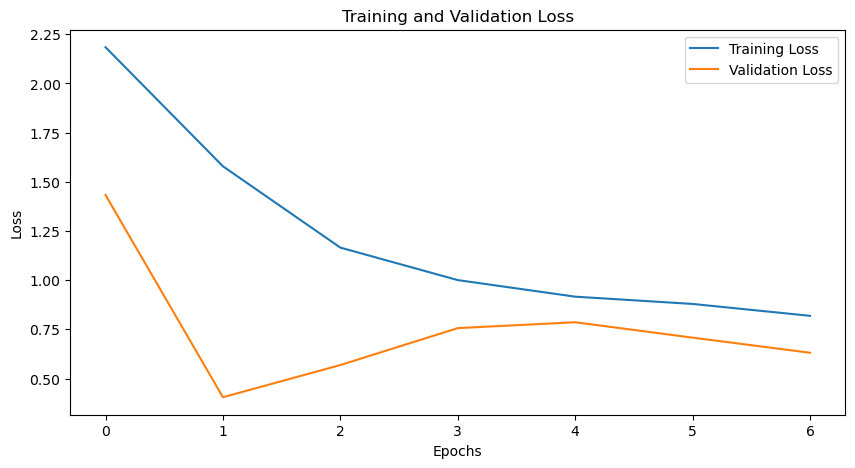

In [80]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
class FinancialDataset(Dataset):
    def __init__(self, data, window_size=7):
        self.data = data
        self.window_size = window_size
        self.input_columns = [
            "log_return",
            # "sector_weighted_avg_log_return",
            # "sector_simple_avg_log_return",
            # "weighted_avg_log_return",
            # "simple_avg_log_return"
        ]
        self.target_columns = [
            "log_return",
            # "abs_log_return",
            # "log_return_7",
            # "abs_log_return_7",
            # "log_return_14",
            # "abs_log_return_14",
            # "log_return_28",
            # "abs_log_return_28",
            # "volatility_7",
            # "volatility_14",
            # "volatility_28"
        ]

        self.data[self.input_columns] = self.data[self.input_columns].apply(pd.to_numeric, errors="coerce")
        self.data[self.target_columns] = self.data[self.target_columns].apply(pd.to_numeric, errors="coerce")
        # self.data["log_return"] = pd.to_numeric(self.data["log_return"], errors="coerce")
        self.data = self.data.dropna()

        # Group by permno_id
        self.groups = self.data.groupby("permno_id")
        self.sequences = []

        for name, group in self.groups:
            j = self.window_size
            if len(group) > self.window_size:
                for i in range(len(group) - self.window_size):
                    X = group[self.input_columns].iloc[i : i + self.window_size].values.flatten()
                    X = np.append(X, j)
                    j += 1
                    y = group[self.target_columns].iloc[i + self.window_size].values
                    # y = group["log_return"].iloc[i + self.window_size]
                    self.sequences.append((X, y, name))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y, permno_id = self.sequences[idx]
        return {
            "features": torch.tensor(X, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": permno_id,
        }


class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Adding hidden layers and dropout
        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = x.unsqueeze(1)  # Add a dimension for the transformer (batch_size, seq_len, embed_dim)
        x = self.transformer(x)  # Transformer expects input of shape (seq_len, batch_size, embed_dim)
        embedding = x[:, -1, :]  # Get the last output token

        # Apply hidden layers
        x = self.hidden_layers(embedding)

        x = self.fc(x)
        # x = self.fc(embedding)  # Fully connected layer on the last output token
        return x.squeeze(-1), embedding  # Return the final output and the embeddings

# Custom L1 Loss Function
class CustomL1Loss(nn.Module):
    def __init__(self):
        super(CustomL1Loss, self).__init__()

    def forward(self, output, target):
        l1_loss = torch.abs(output - target)
        sample_loss = torch.sum(l1_loss, dim=1)  # Sum L1 loss for each sample (across targets)
        batch_loss = torch.mean(sample_loss)     # Average loss over the batch
        return batch_loss
        
# Iterate over each unique permno_id in the dataset
unique_permno_ids = train_data["permno_id"].unique()
stock_embeddings = {}

for permno_id in unique_permno_ids[::50]:
    # set_seed(0)  # Set seed for reproducibility
    print(f"Training for permno_id: {permno_id}")

    # Prepare Data
    # dataset = FinancialDataset(first_month_data[:1000])
    # dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

    train_dataset = FinancialDataset(train_data[train_data["permno_id"] == permno_id])
    val_dataset = FinancialDataset(validation_data[:100])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize Model
    model = TransformerModel(
        input_dim=7 * 1 + 1,
        embed_dim=256,
        n_heads=16,
        ff_dim=1024,
        n_layers=6,
        output_dim=len(train_dataset.target_columns),
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training Loop
    optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
    # criterion = nn.L1Loss(reduction='sum')
    criterion = CustomL1Loss()

    # for epoch in range(5):
    #     for batch in dataloader:
    #         optimizer.zero_grad()
    #         output, _ = model(batch["features"])
    #         loss = criterion(output, batch["target"])
    #         # print(f'loss: {loss}')
    #         loss.backward()
    #         optimizer.step()

    # print("Training Complete")

    train_losses = []
    val_losses = []

    num_epochs = 10
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    print("Starting Training...")
    # num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_dataloader:
            optimizer.zero_grad()
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            # print(f'loss: {loss}')
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_dataloader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                output, _ = model(batch["features"].to(device))
                loss = criterion(output, batch["target"].to(device))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

        # Check for early stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training Complete")

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Extract embeddings for each stock
    model.eval()
    with torch.no_grad():
        permno_embeddings = []
        for batch in train_dataloader:
            _, embeddings = model(batch["features"].to(device))
            permno_embeddings.extend(embeddings.cpu().numpy())

        # Average the embeddings for this permno_id
        stock_embeddings[permno_id] = np.mean(permno_embeddings, axis=0)

    # Extract embeddings for each stock
    # stock_embeddings = {}
    # model.eval()
    # with torch.no_grad():
    #     for batch in train_dataloader:
    #         _, embeddings = model(batch["features"].to(device))
    #         for i, permno_id in enumerate(batch["permno_id"]):
    #             if permno_id not in stock_embeddings:
    #                 stock_embeddings[permno_id] = []
    #             stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

    # # Average the embeddings for each stock
    # for permno_id in stock_embeddings:
    #     stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [81]:
list(stock_embeddings.items())[:2]

[('10104',
  array([ 0.28910947,  0.39344504, -0.25412697,  0.24116914,  1.8065051 ,
         -1.1082754 ,  1.009829  , -0.51867664, -0.4534294 ,  0.9835996 ,
         -1.0945421 ,  1.215785  , -1.4962876 , -0.58406234,  1.653758  ,
          0.4644092 ,  0.64421374,  0.3837308 ,  0.1581181 , -1.6658374 ,
          1.2557722 ,  1.1398377 , -0.68562114,  1.0000193 ,  0.78750604,
          1.0705465 ,  1.3775342 , -0.36111084, -0.27155426,  1.4337211 ,
          2.0223854 , -1.6352633 ,  1.0232075 ,  0.5522275 ,  1.8141782 ,
          0.1470375 ,  0.6487005 ,  0.46766302,  0.6663132 , -0.8800813 ,
          0.68217623,  2.5060356 , -1.1556793 , -0.70081425,  0.29414552,
         -0.9325656 ,  0.3211542 , -0.01443744,  1.4163446 , -0.04305324,
         -1.1184239 ,  0.6989818 , -0.8249403 ,  0.9358032 ,  0.813796  ,
         -0.6757935 , -0.645561  , -0.45883694,  0.5400943 ,  2.0077527 ,
         -0.52917814, -1.3253874 ,  1.0091177 ,  0.72682935, -0.23030367,
          0.8751523 , -0.55

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

array([[ 0.9999998 , -0.18126598, -0.01218817,  0.04397112,  0.01457734,
        -0.05762611,  0.03525184,  0.02791377, -0.01309286,  0.04936686,
        -0.06060537, -0.03519529],
       [-0.18126598,  1.        , -0.0264435 , -0.10492283, -0.06102544,
         0.06873934,  0.00608077, -0.03621465, -0.05920402,  0.06009217,
         0.00692314, -0.03649262],
       [-0.01218817, -0.0264435 ,  1.        , -0.01263425,  0.10768554,
         0.01835587, -0.01859771, -0.00454483,  0.00526591, -0.09763364,
        -0.03048044,  0.06785441],
       [ 0.04397112, -0.10492283, -0.01263425,  0.99999976,  0.00536147,
         0.00752037, -0.0021396 , -0.0319845 ,  0.08222727, -0.092953  ,
        -0.02369472, -0.03090001],
       [ 0.01457734, -0.06102544,  0.10768554,  0.00536147,  0.99999994,
         0.0937987 , -0.11466631,  0.00727685, -0.04016272,  0.01368848,
         0.02073805, -0.0949619 ],
       [-0.05762611,  0.06873934,  0.01835587,  0.00752037,  0.0937987 ,
         1.0000002 , -

## Clustering the Stocks

#### K-means & squared Euclidean distances

Cluster 0: ['10107', '10516', '11308', '11403', '11404', '11600', '11762', '11891', '11955', '12345', '12449', '12490', '12558', '13210', '13379', '13407', '13628', '13788', '13963', '13964', '14541', '14702', '14763', '14776', '15291', '15408', '15720', '15998', '16000', '16851', '16968', '17005', '17144', '17478', '17750', '18163', '21178', '21186', '21792', '21936', '23660', '23931', '24010', '24205', '24643', '25081', '25320', '25419', '25582', '25953', '27633', '28484', '29946', '30681', '35044', '36003', '39917', '40272', '40539', '41080', '41355', '43350', '43449', '45751', '46674', '46886', '50876', '52038', '56274', '58683', '59176', '59300', '59328', '60206', '60506', '61241', '61735', '64186', '64282', '64311', '64936', '64995', '65541', '66093', '66181', '69032', '72726', '75591', '75607', '75825', '76076', '76082', '76709', '76744', '76841', '77037', '77129', '77182', '77649', '77661', '78981', '78987', '79637', '79881', '80080', '80100', '80286', '80329', '81540', '81696'

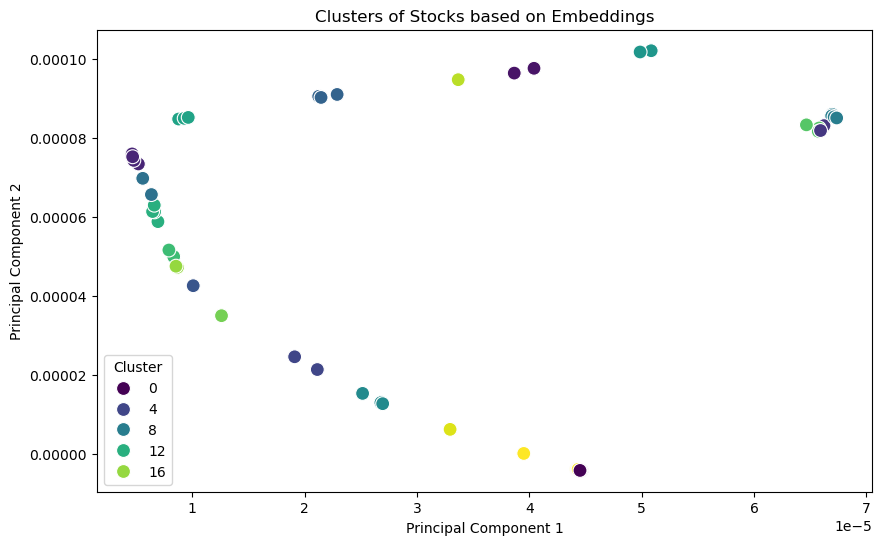

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Perform K-means clustering
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_array)

# Create a dataframe to store permno_id and their corresponding cluster

cluster_df = pd.DataFrame({"permno_id": permno_ids, "cluster": clusters})

# Print permno_id in each cluster
for cluster in range(n_clusters):
    cluster_members = cluster_df[cluster_df["cluster"] == cluster]["permno_id"].tolist()
    print(f"Cluster {cluster}: {cluster_members}")

# Plot the clusters using PCA for dimensionality reduction

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings_array)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=clusters,
    palette="viridis",
    s=100,
)
plt.title("Clusters of Stocks based on Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### K-means & AgglomerativeClustering

- In this approach, you directly apply Agglomerative Clustering to the original embeddings.
- The metric='cosine' parameter tells the algorithm to use cosine distance (1 - cosine similarity) as the metric for clustering.
- The linkage='average' parameter specifies that the distance between clusters is the average distance between points in the clusters.

Cluster 0: ['20057', '20189']
Cluster 1: ['17334', '19285', '19286']
Cluster 2: ['18484', '18576']
Cluster 3: ['17685', '17700', '82686']
Cluster 4: ['18312', '76201', '79996', '82759']
Cluster 5: ['22623', '77668']
Cluster 6: ['18911', '18940', '79265']
Cluster 7: ['11896', '18592', '18724', '18726']
Cluster 8: ['12650', '18420', '18421', '18428']
Cluster 9: ['22206', '22265', '90441', '90442']
Cluster 10: ['88436']
Cluster 11: ['10909']
Cluster 12: ['19751']
Cluster 13: ['11552', '91063']
Cluster 14: ['17341']
Cluster 15: ['22976', '25778', '89757']
Cluster 16: ['18143']
Cluster 17: ['17307']
Cluster 18: ['10104', '10107', '10138', '10145', '10516', '10696', '11308', '11403', '11404', '11600', '11618', '11674', '11691', '11762', '11850', '11891', '11955', '12036', '12052', '12060', '12062', '12084', '12308', '12345', '12369', '12431', '12449', '12476', '12490', '12558', '12622', '12623', '12872', '13035', '13103', '13168', '13210', '13323', '13356', '13379', '13407', '13447', '13511'

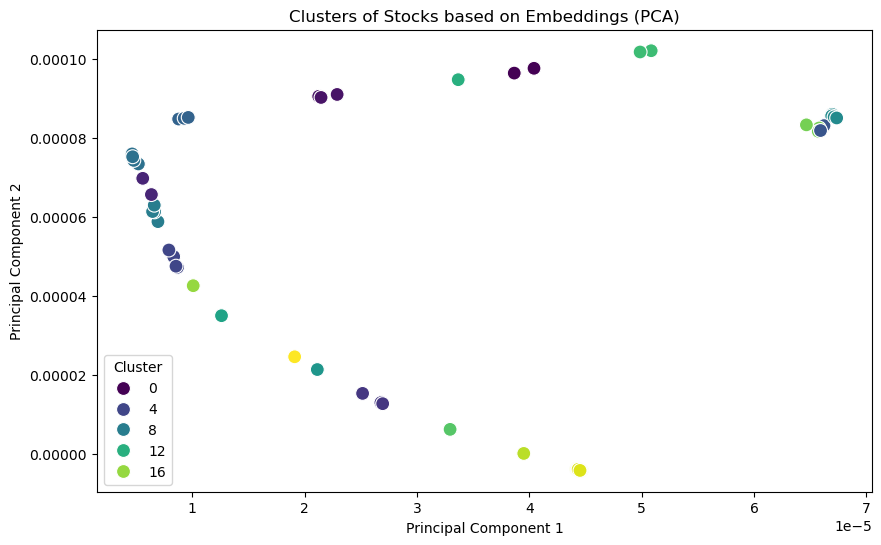

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings = np.array(list(stock_embeddings.values()))

# Perform Agglomerative Clustering with cosine affinity
n_clusters = 20
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric="cosine", linkage="average")
labels = clustering.fit_predict(embeddings)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(stock_embeddings.keys(), labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(stock_embeddings.keys()):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### K-means & Cosine Similarity
1. Cosine Similarity Transformation:  
    - Here, you first compute the cosine similarity matrix from the embeddings.
    - This matrix represents the cosine similarity between each pair of embeddings.
    - The similarity matrix is then used as the input to the KMeans clustering algorithm.  
2. KMeans Clustering:
    - KMeans is applied to the cosine similarity matrix, treating each similarity score as a feature.
    - This approach uses the similarity scores rather than the original embeddings to determine the clusters.

Cluster 0: ['64653']
Cluster 1: ['81774', '89866']
Cluster 2: ['10104', '13688', '30681']
Cluster 3: ['17005', '50876', '93246']
Cluster 4: ['21936', '77274', '86745']


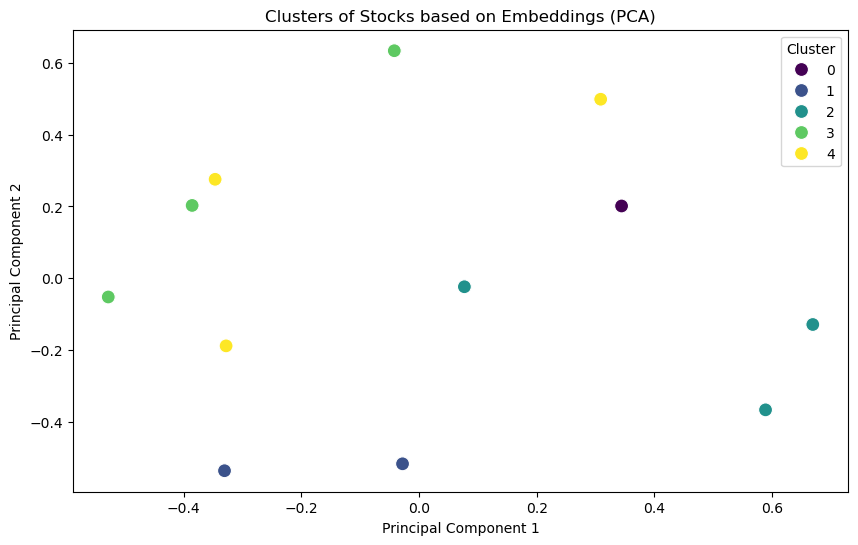

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)


# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Apply KMeans on the transformed data
n_clusters = 20  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(cosine_sim_matrix)

# Map permno_id to cluster labels
permno_id_to_cluster = {permno_id: label for permno_id, label in zip(permno_ids, labels)}

# Create a dictionary to hold lists of permno_ids for each cluster
clusters = {i: [] for i in range(n_clusters)}
for permno_id, cluster in permno_id_to_cluster.items():
    clusters[cluster].append(permno_id)

# Print the clustering results
for cluster, permno_ids in clusters.items():
    print(f"Cluster {cluster}: {permno_ids}")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=labels,
    palette="viridis",
    s=100,
)
# for i, permno_id in enumerate(permno_ids):
#     plt.text(principal_components[i, 0], principal_components[i, 1], str(permno_id), fontsize=9)

plt.title("Clusters of Stocks based on Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

#### Difference - AgglomerativeClustering and Cosine Similarity

Approach 1: Transforming Embeddings using Cosine Similarity and then Applying KMeans  
Approach 2: Agglomerative Clustering with Cosine Affinity  

1. Cosine Similarity Matrix vs. Original Embeddings:
    - Approach 1: Uses the cosine similarity matrix as the input for clustering. This means the clustering is based on the similarity scores between embeddings.  
    - Approach 2: Uses the original embeddings directly with cosine distance as the metric. The clustering is based on the pairwise cosine distances between embeddings.  
2. Clustering Algorithm:
    - Approach 1: Uses KMeans, which is a centroid-based algorithm. It aims to partition the data into clusters such that the sum of the squared distances from each point to its assigned centroid is minimized.  
    - Approach 2: Uses Agglomerative Clustering, which is a hierarchical clustering method. It builds a tree-like structure of clusters by merging pairs of clusters iteratively based on the specified linkage criterion and distance metric.  
3. Distance Metric Usage:  
    - Approach 1: Cosine similarity is precomputed and used as the input for clustering.  
    - Approach 2: Cosine distance is used directly within the clustering algorithm.|

#### Cosine Similarity Matrix

In [47]:
cosine_sim_matrix

array([[ 1.0000005 , -0.02341226,  0.00603095, -0.01878552,  0.07634288,
        -0.02448368,  0.04533082, -0.06582549,  0.0646541 ,  0.03485626,
        -0.05263662, -0.00868683],
       [-0.02341226,  0.9999999 , -0.05058887,  0.04864826,  0.20168361,
        -0.06811924,  0.06900473,  0.01429913,  0.05605198, -0.05007672,
         0.03154162, -0.01945102],
       [ 0.00603095, -0.05058887,  0.99999994,  0.054162  , -0.04721414,
        -0.05637546, -0.06127907, -0.0448039 ,  0.07741497,  0.03951667,
        -0.03575544,  0.1170498 ],
       [-0.01878552,  0.04864826,  0.054162  ,  0.9999997 , -0.0103162 ,
         0.02018012, -0.00437266, -0.14001732,  0.05263589,  0.12434519,
         0.02067832,  0.02965417],
       [ 0.07634288,  0.20168361, -0.04721414, -0.0103162 ,  1.0000004 ,
        -0.05381298,  0.01968997,  0.06040927, -0.03389465, -0.02664903,
        -0.00578395, -0.01475798],
       [-0.02448368, -0.06811924, -0.05637546,  0.02018012, -0.05381298,
         0.9999999 ,  

#### check negative value in cosine_sim_matrix

In [56]:
# Check for negative values in the cosine similarity matrix
negative_values = cosine_sim_matrix[cosine_sim_matrix < 0]

if len(negative_values) > 0:
    print(f"There are {len(negative_values)} negative values in the cosine similarity matrix.")
    print(negative_values)
else:
    print("There are no negative values in the cosine similarity matrix.")

There are no negative values in the cosine similarity matrix.


In [57]:
# Find the maximum value in the cosine similarity matrix
max_value = np.max(cosine_sim_matrix)
print(f"Max value: {max_value}")

# Find the minimum value in the cosine similarity matrix
min_value = np.min(cosine_sim_matrix)
print(f"Min value: {min_value}")

Max value: 1.000000238418579
Min value: 0.9999996423721313


Sample embeddings:
[[-0.10113669 -0.13117969  4.643764   -0.09728476 -0.13188404 -0.11414704
  -0.10199591 -0.09753642  5.2008724  -0.13804568 -0.10543156 -0.12181271
  -0.11092354 -0.10593085 -0.10379755 -0.12611543 -0.13012108 -0.10574751
  -0.10132074 -0.09109034 -0.1217372  -0.10508449 -0.12317963 -0.11023221
  -0.12776662 -0.10637771 -0.11569362 -0.1243245  -0.12921163 -0.12488127
  -0.13221206 -0.12708518 -0.34985635 -0.12901476 -0.12900788 -0.10293555
  -0.10689097 -0.12761888 -0.1141796  -0.13812514 -0.13206193 -0.10620784
  -0.13905913  0.5077686  -0.11439564 -0.10097685 -0.10466886 -0.14279886
  -0.11103318 -0.12519583 -0.12899232 -0.09925667 -0.12949999 -0.1302237
  -0.0958822  -0.11069038 -0.12490238 -0.13115653 -0.13030057 -0.10379748
  -0.099494   -0.12419097 -0.12821966 -3.0186055 ]
 [-0.10118653 -0.13112779  4.6437497  -0.09723199 -0.13183765 -0.11420897
  -0.10202868 -0.09758627  5.200917   -0.1380884  -0.10544573 -0.12179092
  -0.11095989 -0.10586552 -0.10382174 -0.12

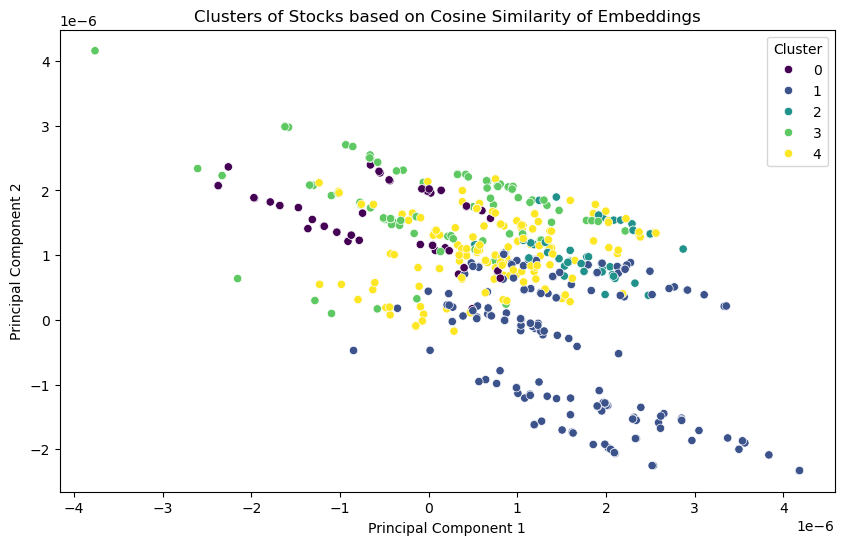

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Check the embeddings to ensure they have diverse values
print("Sample embeddings:")
print(embeddings_array[:5])

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)

# Check if there are any negative values in the cosine similarity matrix
print("Cosine Similarity Matrix Sample:")
print(cosine_sim_matrix[:5, :5])

# Ensure there are negative values
if np.any(cosine_sim_matrix < 0):
    print("Cosine similarity matrix contains negative values.")
else:
    print("Cosine similarity matrix does not contain negative values.")

# Perform K-means clustering
n_clusters = 5  # You can choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(cosine_sim_matrix)

# Create a dataframe to store permno_id and their corresponding cluster
import pandas as pd

cluster_df = pd.DataFrame({"permno_id": permno_ids, "cluster": clusters})

# Plot the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cosine_sim_matrix)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=principal_components[:, 0],
    y=principal_components[:, 1],
    hue=clusters,
    palette="viridis",
)
plt.title("Clusters of Stocks based on Cosine Similarity of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

## Clustering Stocks Return

In [51]:
list(permno_id_to_cluster.items())[:10]

[('10104', 14),
 ('10107', 1),
 ('10138', 6),
 ('10145', 1),
 ('10516', 6),
 ('10696', 1),
 ('10909', 9),
 ('11308', 1),
 ('11403', 11),
 ('11404', 1)]

In [52]:
df_clustering = df

# Add cluster_id to the original data
df_clustering["cluster_id"] = df_clustering["permno_id"].map(permno_id_to_cluster)
df_clustering

date permno_id ncusip_id  cusip_id ticker share_code  \
9263    2018-01-02     10104  68389X10  68389X10   ORCL       11.0   
9264    2018-01-03     10104  68389X10  68389X10   ORCL       11.0   
9265    2018-01-04     10104  68389X10  68389X10   ORCL       11.0   
9266    2018-01-05     10104  68389X10  68389X10   ORCL       11.0   
9267    2018-01-08     10104  68389X10  68389X10   ORCL       11.0   
...            ...       ...       ...       ...    ...        ...   
7658917 2023-12-22     93436  88160R10  88160R10   TSLA       11.0   
7658918 2023-12-26     93436  88160R10  88160R10   TSLA       11.0   
7658919 2023-12-27     93436  88160R10  88160R10   TSLA       11.0   
7658920 2023-12-28     93436  88160R10  88160R10   TSLA       11.0   
7658921 2023-12-29     93436  88160R10  88160R10   TSLA       11.0   

        share_code_type share_code_detail exchange_code company_name  ...  \
9263                  1                 1             1  ORACLE CORP  ...   
9264                  1                 1             1  ORACLE CORP  ...   
9265                  1                 1             1  ORACLE CORP  ...   
9266                  1                 1             1  ORACLE CORP  ...   
9267                  1                 1             1  ORACLE CORP  ...   
...                 ...               ...           ...          ...  ...   
7658917               1                 1             3    TESLA INC  ...   
7658918               1                 1             3    TESLA INC  ...   
7658919               1                 1             3    TESLA INC  ...   
7658920               1                 1             3    TESLA INC  ...   
7658921               1                 1             3    TESLA INC  ...   

        equal_weighted_return return_on_SP_index log_return    market_cap  \
9263                 0.011232           0.008303  -0.013843  1.930296e+08   
9264                 0.005103           0.006399   0.022897  1.975004e+08   
9265                 0.005272           0.004029   0.009803  1.994460e+08   
9266                 0.003880           0.007034   0.006001  2.006465e+08   
9267                 0.000584           0.001662   0.010467  2.027577e+08   
...                       ...                ...        ...           ...   
7658917              0.007676           0.001660  -0.007731  8.028047e+08   
7658918              0.009674           0.004232   0.015988  8.157429e+08   
7658919              0.005276           0.001430   0.018647  8.310971e+08   
7658920              0.002042           0.000370  -0.032104  8.048392e+08   
7658921             -0.007480          -0.002826  -0.018738  7.898983e+08   

        weighted_price sector_weighted_avg_log_return  \
9263      9.000972e+09                       0.000000   
9264      9.422745e+09                       0.021973   
9265      9.609309e+09                       0.002940   
9266      9.725336e+09                       0.015718   
9267      9.931072e+09                       0.006267   
...                ...                            ...   
7658917   2.027403e+11                      -0.001753   
7658918   2.093278e+11                       0.006185   
7658919   2.172820e+11                       0.003881   
7658920   2.037692e+11                      -0.002012   
7658921   1.962739e+11                      -0.002658   

         sector_simple_avg_log_return  weighted_avg_log_return  \
9263                         0.000000                     -0.0   
9264                         0.005694                      0.0   
9265                         0.001681                      0.0   
9266                         0.004005                      0.0   
9267                         0.009789                      0.0   
...                               ...                      ...   
7658917                      0.016253                     -0.0   
7658918                      0.001010                      0.0   
7658919                      0.001242       

#### 1. Calculate the log returns of the clustering corresponding to each stock, calculated using the weighted average stock prices in the clustering

In [53]:
# First, group the data by cluster_id & date
grouped = (
    df_clustering.groupby(["cluster_id", "date"]).agg({"weighted_price": "sum", "market_cap": "sum"}).reset_index()
)

# Then, calculate the weighted average price
grouped["weighted_avg_price"] = grouped["weighted_price"] / grouped["market_cap"]

# Then, calculate the log return for each cluster_id
grouped["weighted_avg_price_shifted"] = grouped.groupby("cluster_id")["weighted_avg_price"].shift(1)
grouped["cluster_weighted_avg_log_return"] = (
    np.log(grouped["weighted_avg_price"] / grouped["weighted_avg_price_shifted"]).fillna(0)
).round(6)

grouped

cluster_id       date  weighted_price    market_cap  \
0               0 2018-01-02    2.724403e+11  2.031136e+09   
1               0 2018-01-03    2.745722e+11  2.039307e+09   
2               0 2018-01-04    2.759041e+11  2.046690e+09   
3               0 2018-01-05    2.811508e+11  2.065263e+09   
4               0 2018-01-08    2.817589e+11  2.064198e+09   
...           ...        ...             ...           ...   
25417          19 2018-12-17    5.266052e+09  5.449143e+07   
25418          19 2018-12-18    5.092051e+09  5.358362e+07   
25419          19 2018-12-19    5.174904e+09  5.401779e+07   
25420          19 2018-12-20    4.806810e+09  5.206119e+07   
25421          19 2018-12-21    0.000000e+00  0.000000e+00   

       weighted_avg_price  weighted_avg_price_shifted  \
0              134.131957                         NaN   
1              134.639972                  134.131957   
2              134.805061                  134.639972   
3              136.133184                  134.805061   
4              136.497987                  136.133184   
...                   ...                         ...   
25417           96.640000                   98.220000   
25418           95.030000                   96.640000   
25419           95.800000                   95.030000   
25420           92.330000                   95.800000   
25421                 NaN                   92.330000   

       cluster_weighted_avg_log_return  
0                             0.000000  
1                             0.003780  
2                             0.001225  
3                             0.009804  
4                             0.002676  
...                                ...  
25417                        -0.016217  
25418                        -0.016800  
25419                         0.008070  
25420                        -0.036894  
25421                         0.000000  

[25422 rows x 7 columns]

In [54]:
# Merge the clustering log returns back to the original dataframe
df_clustering = df_clustering.merge(
    grouped[["date", "cluster_id", "cluster_weighted_avg_log_return"]],
    on=["date", "cluster_id"],
    how="left",
)

df_clustering.head()

date permno_id ncusip_id  cusip_id ticker share_code share_code_type  \
0 2018-01-02     10104  68389X10  68389X10   ORCL       11.0               1   
1 2018-01-03     10104  68389X10  68389X10   ORCL       11.0               1   
2 2018-01-04     10104  68389X10  68389X10   ORCL       11.0               1   
3 2018-01-05     10104  68389X10  68389X10   ORCL       11.0               1   
4 2018-01-08     10104  68389X10  68389X10   ORCL       11.0               1   

  share_code_detail exchange_code company_name  ... return_on_SP_index  \
0                 1             1  ORACLE CORP  ...           0.008303   
1                 1             1  ORACLE CORP  ...           0.006399   
2                 1             1  ORACLE CORP  ...           0.004029   
3                 1             1  ORACLE CORP  ...           0.007034   
4                 1             1  ORACLE CORP  ...           0.001662   

  log_return    market_cap weighted_price sector_weighted_avg_log_return  \
0  -0.013843  1.930296e+08   9.000972e+09                       0.000000   
1   0.022897  1.975004e+08   9.422745e+09                       0.021973   
2   0.009803  1.994460e+08   9.609309e+09                       0.002940   
3   0.006001  2.006465e+08   9.725336e+09                       0.015718   
4   0.010467  2.027577e+08   9.931072e+09                       0.006267   

  sector_simple_avg_log_return  weighted_avg_log_return  \
0                     0.000000                     -0.0   
1                     0.005694                      0.0   
2                     0.001681                      0.0   
3                     0.004005                      0.0   
4                     0.009789                      0.0   

   simple_avg_log_return  cluster_id  cluster_weighted_avg_log_return  
0               -0.00064          14                         0.000000  
1               -0.00064          14                         0.021764  
2               -0.00064          14                         0.002430  
3               -0.00064          14                         0.016969  
4               -0.00064          14                         0.005760  

[5 rows x 40 columns]

In [55]:
df_clustering["cluster_weighted_avg_log_return"]

0         0.000000
1         0.021764
2         0.002430
3         0.016969
4         0.005760
            ...   
809878    0.002708
809879    0.008723
809880    0.009865
809881   -0.016219
809882   -0.008694
Name: cluster_weighted_avg_log_return, Length: 809883, dtype: float64

#### 2. Calculate the log returns of the clustering corresponding to each stock, calculated using the arithmetic average stock prices in the clustering

In [56]:
# First, group the data by cluster_id & date
grouped = (
    df_clustering.groupby(["cluster_id", "date"])
    .agg({"close_price": "mean"})
    .reset_index()
    .rename(columns={"close_price": "avg_price"})
)

# Then, calculate the log return for each cluster_id
grouped["avg_price_Shifted"] = grouped.groupby("cluster_id")["avg_price"].shift(1)
grouped["cluster_simple_avg_log_return"] = (
    np.log(grouped["avg_price"] / grouped["avg_price_Shifted"]).fillna(0)
).round(6)

grouped

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


cluster_id       date   avg_price  avg_price_Shifted  \
0               0 2018-01-02  108.603125                NaN   
1               0 2018-01-03  109.515313         108.603125   
2               0 2018-01-04  109.613282         109.515313   
3               0 2018-01-05  110.380938         109.613282   
4               0 2018-01-08  111.411250         110.380938   
...           ...        ...         ...                ...   
25417          19 2018-12-17   96.640000          98.220000   
25418          19 2018-12-18   95.030000          96.640000   
25419          19 2018-12-19   95.800000          95.030000   
25420          19 2018-12-20   92.330000          95.800000   
25421          19 2018-12-21    0.000000          92.330000   

       cluster_simple_avg_log_return  
0                           0.000000  
1                           0.008364  
2                           0.000894  
3                           0.006979  
4                           0.009291  
...                              ...  
25417                      -0.016217  
25418                      -0.016800  
25419                       0.008070  
25420                      -0.036894  
25421                           -inf  

[25422 rows x 5 columns]

In [57]:
# Merge the clustering log returns back to the original dataframe
df_clustering = df_clustering.merge(
    grouped[["date", "cluster_id", "cluster_simple_avg_log_return"]],
    on=["date", "cluster_id"],
    how="left",
)

df_clustering.head()

date permno_id ncusip_id  cusip_id ticker share_code share_code_type  \
0 2018-01-02     10104  68389X10  68389X10   ORCL       11.0               1   
1 2018-01-03     10104  68389X10  68389X10   ORCL       11.0               1   
2 2018-01-04     10104  68389X10  68389X10   ORCL       11.0               1   
3 2018-01-05     10104  68389X10  68389X10   ORCL       11.0               1   
4 2018-01-08     10104  68389X10  68389X10   ORCL       11.0               1   

  share_code_detail exchange_code company_name  ... log_return    market_cap  \
0                 1             1  ORACLE CORP  ...  -0.013843  1.930296e+08   
1                 1             1  ORACLE CORP  ...   0.022897  1.975004e+08   
2                 1             1  ORACLE CORP  ...   0.009803  1.994460e+08   
3                 1             1  ORACLE CORP  ...   0.006001  2.006465e+08   
4                 1             1  ORACLE CORP  ...   0.010467  2.027577e+08   

  weighted_price sector_weighted_avg_log_return sector_simple_avg_log_return  \
0   9.000972e+09                       0.000000                     0.000000   
1   9.422745e+09                       0.021973                     0.005694   
2   9.609309e+09                       0.002940                     0.001681   
3   9.725336e+09                       0.015718                     0.004005   
4   9.931072e+09                       0.006267                     0.009789   

  weighted_avg_log_return  simple_avg_log_return  cluster_id  \
0                    -0.0               -0.00064          14   
1                     0.0               -0.00064          14   
2                     0.0               -0.00064          14   
3                     0.0               -0.00064          14   
4                     0.0               -0.00064          14   

   cluster_weighted_avg_log_return  cluster_simple_avg_log_return  
0                         0.000000                       0.000000  
1                         0.021764                       0.012446  
2                         0.002430                       0.005958  
3                         0.016969                       0.007333  
4                         0.005760                       0.001717  

[5 rows x 41 columns]

In [58]:
df_clustering["cluster_simple_avg_log_return"]

0         0.000000
1         0.012446
2         0.005958
3         0.007333
4         0.001717
            ...   
809878    0.012161
809879    0.004755
809880    0.001919
809881    0.000032
809882   -0.003015
Name: cluster_simple_avg_log_return, Length: 809883, dtype: float64

In [59]:
df_clustering.dtypes

date                               datetime64[ns]
permno_id                                  object
ncusip_id                                  object
cusip_id                                   object
ticker                                     object
share_code                                 object
share_code_type                            object
share_code_detail                          object
exchange_code                              object
company_name                               object
primary_exchange                           object
trading_status                             object
security_status                            object
naics                                      object
naics_sector                               object
naics_secondary                            object
ask_or_high_price                         float64
ask_price                                 float64
bid_or_low_price                          float64
bid_price                                 float64


In [60]:
df_clustering

date permno_id ncusip_id  cusip_id ticker share_code  \
0      2018-01-02     10104  68389X10  68389X10   ORCL       11.0   
1      2018-01-03     10104  68389X10  68389X10   ORCL       11.0   
2      2018-01-04     10104  68389X10  68389X10   ORCL       11.0   
3      2018-01-05     10104  68389X10  68389X10   ORCL       11.0   
4      2018-01-08     10104  68389X10  68389X10   ORCL       11.0   
...           ...       ...       ...       ...    ...        ...   
809878 2023-12-22     93436  88160R10  88160R10   TSLA       11.0   
809879 2023-12-26     93436  88160R10  88160R10   TSLA       11.0   
809880 2023-12-27     93436  88160R10  88160R10   TSLA       11.0   
809881 2023-12-28     93436  88160R10  88160R10   TSLA       11.0   
809882 2023-12-29     93436  88160R10  88160R10   TSLA       11.0   

       share_code_type share_code_detail exchange_code company_name  ...  \
0                    1                 1             1  ORACLE CORP  ...   
1                    1                 1             1  ORACLE CORP  ...   
2                    1                 1             1  ORACLE CORP  ...   
3                    1                 1             1  ORACLE CORP  ...   
4                    1                 1             1  ORACLE CORP  ...   
...                ...               ...           ...          ...  ...   
809878               1                 1             3    TESLA INC  ...   
809879               1                 1             3    TESLA INC  ...   
809880               1                 1             3    TESLA INC  ...   
809881               1                 1             3    TESLA INC  ...   
809882               1                 1             3    TESLA INC  ...   

       log_return    market_cap weighted_price sector_weighted_avg_log_return  \
0       -0.013843  1.930296e+08   9.000972e+09                       0.000000   
1        0.022897  1.975004e+08   9.422745e+09                       0.021973   
2        0.009803  1.994460e+08   9.609309e+09                       0.002940   
3        0.006001  2.006465e+08   9.725336e+09                       0.015718   
4        0.010467  2.027577e+08   9.931072e+09                       0.006267   
...           ...           ...            ...                            ...   
809878  -0.007731  8.028047e+08   2.027403e+11                      -0.001753   
809879   0.015988  8.157429e+08   2.093278e+11                       0.006185   
809880   0.018647  8.310971e+08   2.172820e+11                       0.003881   
809881  -0.032104  8.048392e+08   2.037692e+11                      -0.002012   
809882  -0.018738  7.898983e+08   1.962739e+11                      -0.002658   

       sector_simple_avg_log_return weighted_avg_log_return  \
0                          0.000000                    -0.0   
1                          0.005694                     0.0   
2                          0.001681                     0.0   
3                          0.004005                     0.0   
4                          0.009789                     0.0   
...                             ...                     ...   
809878                     0.016253                    -0.0   
809879                     0.001010                     0.0   
809880                     0.001242                     0.0   
809881                     0.004141                    -0.0   
809882                    -0.009349                    -0.0   

        simple_avg_log_return  cluster_id  cluster_weighted_avg_log_return  \
0                    -0.00064          14                         0.000000   
1                    -0.00064          14                         0.021764   
2                    -0.00064          14                         0.002430   
3                    -0.00064          14                         0.016969   
4                    -0.00064          14                         0.005760   
...                       ...         ...                              ..

## Step 3 dataset  
Including stock daily log_returns from most similar and most opposite cosine similarity 

In [61]:
df_clustering = df_clustering[["date", "permno_id", "log_return"]]

In [62]:
df_clustering.dtypes

date          datetime64[ns]
permno_id             object
log_return           float64
dtype: object

In [63]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


def find_similar_and_opposite_stocks(stock_embeddings, df_clustering, n=2):
    # Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
    embeddings_list = []
    permno_ids = []
    n = 2

    for permno_id, embedding in stock_embeddings.items():
        permno_ids.append(permno_id)
        embeddings_list.append(embedding)

    # Convert the list of embeddings to a numpy array
    embeddings_array = np.array(embeddings_list)

    # Transform embeddings using cosine similarity
    cosine_sim_matrix = cosine_similarity(embeddings_array)

    # Create a DataFrame for cosine similarity matrix for better handling
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=permno_ids, columns=permno_ids)

    base = df_clustering.copy()[["date", "permno_id", "log_return"]]

    # Initialize new columns for most similar and most opposite stocks and their log returns
    for i in range(1, n + 1):
        df_clustering[f"most_similar_{i}"] = np.nan
        # df_clustering[f"most_similar_{i}_log_return"] = np.nan
        df_clustering[f"most_opposite_{i}"] = np.nan
        # df_clustering[f"most_opposite_{i}_log_return"] = np.nan

    # Ensure the new columns are of the same type as 'permno_id'
    df_clustering = df_clustering.astype({f"most_similar_{i}": "object" for i in range(1, n + 1)})
    df_clustering = df_clustering.astype({f"most_opposite_{i}": "object" for i in range(1, n + 1)})

    # Fill new columns with permno_id and log_return of most similar and most opposite stocks
    for permno_id in df_clustering["permno_id"].unique():
        similarities = cosine_sim_df.loc[permno_id]
        sorted_similarities = similarities.sort_values(ascending=False)
        most_similar = sorted_similarities.index[1 : n + 1]  # First n most similar stocks
        most_opposite = sorted_similarities.index[-n:]  # Last n most opposite stocks

        for i in range(n):
            similar_permno_id = most_similar[i]
            opposite_permno_id = most_opposite[i]

            # Set the most similar and most opposite permno_id
            df_clustering.loc[df_clustering["permno_id"] == permno_id, f"most_similar_{i+1}"] = similar_permno_id
            df_clustering.loc[df_clustering["permno_id"] == permno_id, f"most_opposite_{i+1}"] = opposite_permno_id

    # Merge the similar stock returns
    for i in range(1, n + 1):
        df_clustering = df_clustering.merge(
            base.rename(columns={"permno_id": f"most_similar_{i}", "log_return": f"most_similar_{i}_log_return"}),
            on=["date", f"most_similar_{i}"],
            how="left",
        )

    # Merge the opposite stock returns
    for i in range(1, n + 1):
        df_clustering = df_clustering.merge(
            base.rename(columns={"permno_id": f"most_opposite_{i}", "log_return": f"most_opposite_{i}_log_return"}),
            on=["date", f"most_opposite_{i}"],
            how="left",
        )

    # for feat in ["most_similar_1", "most_opposite_1", "most_similar_2", "most_opposite_2"]:
    #     df_clustering = df_clustering.merge(base.rename(columns = {"permno_id": f"{feat}", "log_return": f"{feat}_log_return"}), on = ["date", feat], how = "left")

    return df_clustering


# Example usage:
df_clustering = find_similar_and_opposite_stocks(stock_embeddings, df_clustering, n=3)
df_clustering

/tmp/ipykernel_151/2281485965.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering[f"most_similar_{i}"] = np.nan
/tmp/ipykernel_151/2281485965.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering[f"most_opposite_{i}"] = np.nan
/tmp/ipykernel_151/2281485965.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

date permno_id  log_return most_similar_1 most_opposite_1  \
0      2018-01-02     10104   -0.013843          20057           90071   
1      2018-01-03     10104    0.022897          20057           90071   
2      2018-01-04     10104    0.009803          20057           90071   
3      2018-01-05     10104    0.006001          20057           90071   
4      2018-01-08     10104    0.010467          20057           90071   
...           ...       ...         ...            ...             ...   
809878 2023-12-22     93436   -0.007731          91063           90071   
809879 2023-12-26     93436    0.015988          91063           90071   
809880 2023-12-27     93436    0.018647          91063           90071   
809881 2023-12-28     93436   -0.032104          91063           90071   
809882 2023-12-29     93436   -0.018738          91063           90071   

       most_similar_2 most_opposite_2  most_similar_1_log_return  \
0               22265           90199                        NaN   
1               22265           90199                        NaN   
2               22265           90199                        NaN   
3               22265           90199                        NaN   
4               22265           90199                        NaN   
...               ...             ...                        ...   
809878          20189           90199                        NaN   
809879          20189           90199                        NaN   
809880          20189           90199                        NaN   
809881          20189           90199                        NaN   
809882          20189           90199                        NaN   

        most_similar_2_log_return  most_opposite_1_log_return  \
0                             NaN                    0.014639   
1                             NaN                   -0.000692   
2                             NaN                   -0.011493   
3                             NaN                    0.006285   
4                             NaN                    0.015199   
...                           ...                         ...   
809878                  -0.000298                   -0.001799   
809879                  -0.006687                    0.016070   
809880                   0.008278                    0.008037   
809881                  -0.004778                    0.012418   
809882                  -0.013260                   -0.003090   

        most_opposite_2_log_return  
0                         0.011707  
1                         0.008409  
2                        -0.003173  
3                         0.004982  
4                         0.012794  
...                            ...  
809878                    0.004796  
809879                    0.007152  
809880                    0.011061  
809881                    0.001920  
809882                   -0.007811  

[809883 rows x 11 columns]

### Check

In [69]:
df_clustering[df_clustering["most_opposite_1"] == "90071"][["date", "permno_id", "most_opposite_1_log_return"]]

date permno_id  most_opposite_1_log_return
0      2018-01-02     10104                    0.014639
1      2018-01-03     10104                   -0.000692
2      2018-01-04     10104                   -0.011493
3      2018-01-05     10104                    0.006285
4      2018-01-08     10104                    0.015199
...           ...       ...                         ...
809878 2023-12-22     93436                   -0.001799
809879 2023-12-26     93436                    0.016070
809880 2023-12-27     93436                    0.008037
809881 2023-12-28     93436                    0.012418
809882 2023-12-29     93436                   -0.003090

[161453 rows x 3 columns]

In [70]:
df_clustering[df_clustering["permno_id"] == "90071"][["date", "permno_id", "log_return"]]

date permno_id  log_return
736355 2018-01-02     90071    0.014639
736356 2018-01-03     90071   -0.000692
736357 2018-01-04     90071   -0.011493
736358 2018-01-05     90071    0.006285
736359 2018-01-08     90071    0.015199
...           ...       ...         ...
737859 2023-12-22     90071   -0.001799
737860 2023-12-26     90071    0.016070
737861 2023-12-27     90071    0.008037
737862 2023-12-28     90071    0.012418
737863 2023-12-29     90071   -0.003090

[1509 rows x 3 columns]

In [71]:
nan_counts = df_clustering.isna().sum()
print(nan_counts)

date                               0
permno_id                          0
log_return                         0
most_similar_1                     0
most_opposite_1                    0
most_similar_2                     0
most_opposite_2                    0
most_similar_1_log_return     510100
most_similar_2_log_return     537686
most_opposite_1_log_return      5155
most_opposite_2_log_return      8086
dtype: int64


In [72]:
any_nans = df_clustering.isna().any()
print(any_nans)

date                          False
permno_id                     False
log_return                    False
most_similar_1                False
most_opposite_1               False
most_similar_2                False
most_opposite_2               False
most_similar_1_log_return      True
most_similar_2_log_return      True
most_opposite_1_log_return     True
most_opposite_2_log_return     True
dtype: bool


In [73]:
any_nans_overall = df_clustering.isna().any().any()
print(f"Are there any NaN values in the DataFrame? {any_nans_overall}")

Are there any NaN values in the DataFrame? True


In [74]:
rows_with_nans = df_clustering[df_clustering.isna().any(axis=1)]
rows_with_nans

date permno_id  log_return most_similar_1 most_opposite_1  \
0      2018-01-02     10104   -0.013843          20057           90071   
1      2018-01-03     10104    0.022897          20057           90071   
2      2018-01-04     10104    0.009803          20057           90071   
3      2018-01-05     10104    0.006001          20057           90071   
4      2018-01-08     10104    0.010467          20057           90071   
...           ...       ...         ...            ...             ...   
809878 2023-12-22     93436   -0.007731          91063           90071   
809879 2023-12-26     93436    0.015988          91063           90071   
809880 2023-12-27     93436    0.018647          91063           90071   
809881 2023-12-28     93436   -0.032104          91063           90071   
809882 2023-12-29     93436   -0.018738          91063           90071   

       most_similar_2 most_opposite_2  most_similar_1_log_return  \
0               22265           90199                        NaN   
1               22265           90199                        NaN   
2               22265           90199                        NaN   
3               22265           90199                        NaN   
4               22265           90199                        NaN   
...               ...             ...                        ...   
809878          20189           90199                        NaN   
809879          20189           90199                        NaN   
809880          20189           90199                        NaN   
809881          20189           90199                        NaN   
809882          20189           90199                        NaN   

        most_similar_2_log_return  most_opposite_1_log_return  \
0                             NaN                    0.014639   
1                             NaN                   -0.000692   
2                             NaN                   -0.011493   
3                             NaN                    0.006285   
4                             NaN                    0.015199   
...                           ...                         ...   
809878                  -0.000298                   -0.001799   
809879                  -0.006687                    0.016070   
809880                   0.008278                    0.008037   
809881                  -0.004778                    0.012418   
809882                  -0.013260                   -0.003090   

        most_opposite_2_log_return  
0                         0.011707  
1                         0.008409  
2                        -0.003173  
3                         0.004982  
4                         0.012794  
...                            ...  
809878                    0.004796  
809879                    0.007152  
809880                    0.011061  
809881                    0.001920  
809882                   -0.007811  

[719229 rows x 11 columns]

### replace NaN with 0 and add new columns to indicate them
1. If there was values in the columns "most_similar_log_return" and "most_opposite_log_return", then fill 1.
2. If there was NaN in the columns "most_similar_log_return" and "most_opposite_log_return", then fill 0.
3. replace the NaN with 0 for the columns "most_similar_log_return" and "most_opposite_log_return"

In [75]:
df_clustering

date permno_id  log_return most_similar_1 most_opposite_1  \
0      2018-01-02     10104   -0.013843          20057           90071   
1      2018-01-03     10104    0.022897          20057           90071   
2      2018-01-04     10104    0.009803          20057           90071   
3      2018-01-05     10104    0.006001          20057           90071   
4      2018-01-08     10104    0.010467          20057           90071   
...           ...       ...         ...            ...             ...   
809878 2023-12-22     93436   -0.007731          91063           90071   
809879 2023-12-26     93436    0.015988          91063           90071   
809880 2023-12-27     93436    0.018647          91063           90071   
809881 2023-12-28     93436   -0.032104          91063           90071   
809882 2023-12-29     93436   -0.018738          91063           90071   

       most_similar_2 most_opposite_2  most_similar_1_log_return  \
0               22265           90199                        NaN   
1               22265           90199                        NaN   
2               22265           90199                        NaN   
3               22265           90199                        NaN   
4               22265           90199                        NaN   
...               ...             ...                        ...   
809878          20189           90199                        NaN   
809879          20189           90199                        NaN   
809880          20189           90199                        NaN   
809881          20189           90199                        NaN   
809882          20189           90199                        NaN   

        most_similar_2_log_return  most_opposite_1_log_return  \
0                             NaN                    0.014639   
1                             NaN                   -0.000692   
2                             NaN                   -0.011493   
3                             NaN                    0.006285   
4                             NaN                    0.015199   
...                           ...                         ...   
809878                  -0.000298                   -0.001799   
809879                  -0.006687                    0.016070   
809880                   0.008278                    0.008037   
809881                  -0.004778                    0.012418   
809882                  -0.013260                   -0.003090   

        most_opposite_2_log_return  
0                         0.011707  
1                         0.008409  
2                        -0.003173  
3                         0.004982  
4                         0.012794  
...                            ...  
809878                    0.004796  
809879                    0.007152  
809880                    0.011061  
809881                    0.001920  
809882                   -0.007811  

[809883 rows x 11 columns]

In [76]:
# Identify the columns that are related to most similar and most opposite log returns
similar_opposite_cols = [
    col for col in df_clustering.columns if "_log_return" in col and ("most_similar" in col or "most_opposite" in col)
]

# Add new columns to indicate if the value was NaN
for col in similar_opposite_cols:
    df_clustering[f"{col}_was_nan"] = np.where(df_clustering[col].isna(), 0, 1)

# Replace NaN values with 0 in the identified columns
df_clustering[similar_opposite_cols] = df_clustering[similar_opposite_cols].fillna(0)

# Example check
df_clustering

date permno_id  log_return most_similar_1 most_opposite_1  \
0      2018-01-02     10104   -0.013843          20057           90071   
1      2018-01-03     10104    0.022897          20057           90071   
2      2018-01-04     10104    0.009803          20057           90071   
3      2018-01-05     10104    0.006001          20057           90071   
4      2018-01-08     10104    0.010467          20057           90071   
...           ...       ...         ...            ...             ...   
809878 2023-12-22     93436   -0.007731          91063           90071   
809879 2023-12-26     93436    0.015988          91063           90071   
809880 2023-12-27     93436    0.018647          91063           90071   
809881 2023-12-28     93436   -0.032104          91063           90071   
809882 2023-12-29     93436   -0.018738          91063           90071   

       most_similar_2 most_opposite_2  most_similar_1_log_return  \
0               22265           90199                        0.0   
1               22265           90199                        0.0   
2               22265           90199                        0.0   
3               22265           90199                        0.0   
4               22265           90199                        0.0   
...               ...             ...                        ...   
809878          20189           90199                        0.0   
809879          20189           90199                        0.0   
809880          20189           90199                        0.0   
809881          20189           90199                        0.0   
809882          20189           90199                        0.0   

        most_similar_2_log_return  most_opposite_1_log_return  \
0                        0.000000                    0.014639   
1                        0.000000                   -0.000692   
2                        0.000000                   -0.011493   
3                        0.000000                    0.006285   
4                        0.000000                    0.015199   
...                           ...                         ...   
809878                  -0.000298                   -0.001799   
809879                  -0.006687                    0.016070   
809880                   0.008278                    0.008037   
809881                  -0.004778                    0.012418   
809882                  -0.013260                   -0.003090   

        most_opposite_2_log_return  most_similar_1_log_return_was_nan  \
0                         0.011707                                  0   
1                         0.008409                                  0   
2                        -0.003173                                  0   
3                         0.004982                                  0   
4                         0.012794                                  0   
...                            ...                                ...   
809878                    0.004796                                  0   
809879                    0.007152                                  0   
809880                    0.011061                                  0   
809881                    0.001920                                  0   
809882                   -0.007811                                  0   

        most_similar_2_log_return_was_nan  most_opposite_1_log_return_was_nan  \
0                                       0                                   1   
1                                       0                                   1   
2                                       0                                   1   
3                                       0                                   1   
4                                       0                                   1   
...                                   ...                                 ...   
809878                                  1                                   1   
8

In [77]:
df_clustering.columns

Index(['date', 'permno_id', 'log_return', 'most_similar_1', 'most_opposite_1',
       'most_similar_2', 'most_opposite_2', 'most_similar_1_log_return',
       'most_similar_2_log_return', 'most_opposite_1_log_return',
       'most_opposite_2_log_return', 'most_similar_1_log_return_was_nan',
       'most_similar_2_log_return_was_nan',
       'most_opposite_1_log_return_was_nan',
       'most_opposite_2_log_return_was_nan'],
      dtype='object')

In [78]:
nan_counts = df_clustering.isna().sum()
print(nan_counts)

date                                  0
permno_id                             0
log_return                            0
most_similar_1                        0
most_opposite_1                       0
most_similar_2                        0
most_opposite_2                       0
most_similar_1_log_return             0
most_similar_2_log_return             0
most_opposite_1_log_return            0
most_opposite_2_log_return            0
most_similar_1_log_return_was_nan     0
most_similar_2_log_return_was_nan     0
most_opposite_1_log_return_was_nan    0
most_opposite_2_log_return_was_nan    0
dtype: int64


## Save the cleaned df as csv & parquet


In [51]:
df_clustering.to_csv(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.csv",
    index=False,
)
df_clustering.to_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")

In [52]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")
assert df_clustering.equals(reload)

reload.head()

date permno_id ncusip_id  cusip_id ticker share_code share_code_type  \
0 2018-01-02     10104  68389X10  68389X10   ORCL       11.0               1   
1 2018-01-03     10104  68389X10  68389X10   ORCL       11.0               1   
2 2018-01-04     10104  68389X10  68389X10   ORCL       11.0               1   
3 2018-01-05     10104  68389X10  68389X10   ORCL       11.0               1   
4 2018-01-08     10104  68389X10  68389X10   ORCL       11.0               1   

  share_code_detail exchange_code company_name  ... log_return    market_cap  \
0                 1             1  ORACLE CORP  ...  -0.013843  1.930296e+08   
1                 1             1  ORACLE CORP  ...   0.022897  1.975004e+08   
2                 1             1  ORACLE CORP  ...   0.009803  1.994460e+08   
3                 1             1  ORACLE CORP  ...   0.006001  2.006465e+08   
4                 1             1  ORACLE CORP  ...   0.010467  2.027577e+08   

  weighted_price sector_weighted_avg_log_return sector_simple_avg_log_return  \
0   9.000972e+09                       0.000000                     0.000000   
1   9.422745e+09                       0.021973                     0.005694   
2   9.609309e+09                       0.002940                     0.001681   
3   9.725336e+09                       0.015718                     0.004005   
4   9.931072e+09                       0.006267                     0.009789   

  weighted_avg_log_return  simple_avg_log_return  cluster_id  \
0                    -0.0               -0.00064          16   
1                     0.0               -0.00064          16   
2                     0.0               -0.00064          16   
3                     0.0               -0.00064          16   
4                     0.0               -0.00064          16   

   cluster_weighted_avg_log_return  cluster_simple_avg_log_return  
0                         0.000000                       0.000000  
1                         0.010933                       0.009348  
2                        -0.001095                       0.000711  
3                         0.000353                       0.002520  
4                         0.001616                       0.002617  

[5 rows x 41 columns]

## Upload the parquet to s3


In [53]:
s3.upload_file(
    "/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet",
    bucket,
    "CRSP/crsp_2018-2023_clean_clustering.parquet",
)

In [54]:
reload_path = s3_download("CRSP/crsp_2018-2023_clean_clustering.parquet")

In [55]:
reload = pd.read_parquet("/home/sagemaker-user/capstone-2024-summer/data/crsp_2018-2023_clean_clustering.parquet")
assert df_clustering.equals(reload)

reload.head()

date permno_id ncusip_id  cusip_id ticker share_code share_code_type  \
0 2018-01-02     10104  68389X10  68389X10   ORCL       11.0               1   
1 2018-01-03     10104  68389X10  68389X10   ORCL       11.0               1   
2 2018-01-04     10104  68389X10  68389X10   ORCL       11.0               1   
3 2018-01-05     10104  68389X10  68389X10   ORCL       11.0               1   
4 2018-01-08     10104  68389X10  68389X10   ORCL       11.0               1   

  share_code_detail exchange_code company_name  ... log_return    market_cap  \
0                 1             1  ORACLE CORP  ...  -0.013843  1.930296e+08   
1                 1             1  ORACLE CORP  ...   0.022897  1.975004e+08   
2                 1             1  ORACLE CORP  ...   0.009803  1.994460e+08   
3                 1             1  ORACLE CORP  ...   0.006001  2.006465e+08   
4                 1             1  ORACLE CORP  ...   0.010467  2.027577e+08   

  weighted_price sector_weighted_avg_log_return sector_simple_avg_log_return  \
0   9.000972e+09                       0.000000                     0.000000   
1   9.422745e+09                       0.021973                     0.005694   
2   9.609309e+09                       0.002940                     0.001681   
3   9.725336e+09                       0.015718                     0.004005   
4   9.931072e+09                       0.006267                     0.009789   

  weighted_avg_log_return  simple_avg_log_return  cluster_id  \
0                    -0.0               -0.00064          16   
1                     0.0               -0.00064          16   
2                     0.0               -0.00064          16   
3                     0.0               -0.00064          16   
4                     0.0               -0.00064          16   

   cluster_weighted_avg_log_return  cluster_simple_avg_log_return  
0                         0.000000                       0.000000  
1                         0.010933                       0.009348  
2                        -0.001095                       0.000711  
3                         0.000353                       0.002520  
4                         0.001616                       0.002617  

[5 rows x 41 columns]